# Tutorial: applying strainFlye to the SheepGut dataset

This tutorial will walk you through some of the analyses that strainFlye can perform.

Here we will be using the same SheepGut dataset that is used in our paper, but feel free to follow along with another dataset.

The pipeline takes as input two primary types of data:

1. A __set of reads__ (in FASTA / FASTQ format) generated using PacBio HiFi sequencing.

2. An __assembly graph__ (in GFA 1 format) produced by running metaFlye (or another assembler) on these reads.

Please see the paper's "Data access" section for details about acquiring both of these types of data for the SheepGut dataset.

## Introduction

Here we take care of a few things before the tutorial starts.

### What commands are available through strainFlye?

In [1]:
!strainFlye

Usage: strainFlye [OPTIONS] COMMAND [ARGS]...

  Pipeline for the analysis of rare mutations in metagenomes.

  Please consult https://github.com/fedarko/strainFlye if you have any
  questions, comments, etc. about strainFlye. Thank you for using this tool!

Options:
  -h, --help  Show this message and exit.

Commands:
  align  Aligns reads to contigs, then filters this alignment.
  call   [+] Naïve mutation calling and diversity index computation.
  fdr    [+] FDR estimation and fixing for contigs' mutation calls.
  utils  [+] Various utility commands provided with strainFlye.


### Importing and configuring some utilities

You shouldn't need to actually do any programming to use strainFlye, but we'll be using Python to perform some plotting and other analyses throughout this tutorial—we'll import some useful packages here to reduce clutter in this notebook.

(If you prefer, you could of course use another language instead of Python!)

In [2]:
from math import ceil, floor
from matplotlib import pyplot
import pandas as pd

# Make our plots look pretty
# (this is the same style we use throughout most of the paper's figures)
pyplot.style.use("ggplot")

## 0. Convert the assembly graph to a FASTA file of contigs

**You can skip this step if:** you already have a FASTA file exactly matching the sequences of the segments in your GFA file.

Our assembly graph (the GFA file) contains the sequences of the contigs that we will use in many downstream analyses, but it will be helpful to have a FASTA file that just describes these contigs' sequences (independent of the assembly graph topology).

There are some [bash one-liners](https://www.biostars.org/p/169516/#169530) you can use to convert a GFA file to a FASTA file, but strainFlye also provides a utility command (`strainFlye utils gfa-to-fasta`) to do this for you. We'll use this here. (Our solution may be a bit slower than a bash one-liner, but it performs some useful sanity checking on the GFA file.)

In [70]:
!strainFlye utils gfa-to-fasta \
    --graph /Poppy/mfedarko/misc-data/sheepgut_flye_big_2.8_graph.gfa \
    --output-fasta /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs.fasta

--------
strainFlye utils gfa-to-fasta @ 0.00 sec: Starting...
Input GFA file: /Poppy/mfedarko/misc-data/sheepgut_flye_big_2.8_graph.gfa
Output FASTA file: /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs.fasta
--------
strainFlye utils gfa-to-fasta @ 12.63 sec: Done.
Output FASTA file contains 78,793 sequences.


## 1. Align reads to contigs; filter the resulting alignment

**You can skip this step if:** you already have a BAM file representing an alignment of reads to contigs, and this BAM file does not contain secondary alignments / partially-mapped reads / overlapping supplementary alignments (these all may cause problems in downstream analyses).

We'll need to align reads back to these contigs. The resulting alignment will be used in pretty much all downstream steps, so it's important to make sure that it is of good quality.

The `strainFlye align` command produces a BAM file corresponding to such an alignment. 

Note that this command, in particular, may take a while to run. Sequence alignment is computationally expensive! On our cluster, `strainFlye align` ran on the full SheepGut dataset in 62,941.21 seconds (aka about 17.5 hours).

In [96]:
!strainFlye align

Usage: strainFlye align [OPTIONS] READS...

  Aligns reads to contigs, then filters this alignment.

  Files of reads should be in the FASTA or FASTQ formats; GZIP'd files are
  allowed.

  This command involves multiple steps, including:

    1) Align reads to contigs (using minimap2) to generate a SAM file
    2) Convert this SAM file to a sorted and indexed BAM file
    3) Filter overlapping supplementary alignments within this BAM file
    4) Filter partially-mapped reads within this BAM file

  Note that we only sort the alignment file once, although we do re-index it
  after the two filtering steps. This decision is motivated by
  https://www.biostars.org/p/131333/#131335.

Options:
  -c, --contigs PATH          FASTA file of contigs to which reads will be
                              aligned.  [required]
  -g, --graph PATH            GFA 1-formatted file describing an assembly
                              graph of the contigs. This is used in the
                              

In [4]:
!strainFlye align \
    # We can use the FASTA file we just generated above.
    --contigs /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs.fasta \
    --graph /Poppy/mfedarko/misc-data/sheepgut_flye_big_2.8_graph.gfa \
    --output-dir /Poppy/mfedarko/sftests/tutorial-output/alignment \
    # Reads file(s) are specified here, after all of the other parameters:
    /Poppy/mkolmogo/sheep_meta/data/sheep_poop_CCS_dedup.fastq.gz \
    /Poppy/mkolmogo/sheep_meta/data/ccs_sequel_II/*.fasta.qz

This generates a BAM file (`final.bam`) and BAM index file (`final.bam.bai`) in the specified output directory.

We can use this BAM file for many analyses downstream—the first of these will be mutation calling.

## 2. Perform naïve mutation calling; estimate and fix FDRs

**You can skip this step if:** you already have a BCF file indicating single-nucleotide variant calls in these contigs.

The analyses downstream of this step take as input a set of identified single-nucleotide mutations (or, if you prefer to use different terminology, "called variants", "called SNVs", ...) in which we have some confidence. First, we will naïvely call mutations using a simple threshold-based method (referred to as "NaiveFreq" in the paper). We'll then estimate the false-discovery rates of the mutations called for each contig using the target-decoy approach, and then adjust the called mutations to fix the false-discovery rates of these mutation calls below a specified threshold.

### 2.1. $p$-mutations and $r$-mutations?

strainFlye supports calling two basic types of mutations: $p$-mutations and $r$-mutations. The docs explain the difference between these two types best:

In [5]:
!strainFlye call

Usage: strainFlye call [OPTIONS] COMMAND [ARGS]...

  [+] Naïve mutation calling and diversity index computation.

  Consider a position "pos" in a contig. A given read with a (mis)match
  operation at "pos" must have one of four nucleotides (A, C, G, T) aligned to
  pos. We represent these nucleotides' counts at pos as follows:

      N1 = # reads of the most-common aligned nucleotide at pos,
      N2 = # reads of the second-most-common aligned nucleotide at pos,
      N3 = # reads of the third-most-common aligned nucleotide at pos,
      N4 = # reads of the fourth-most-common aligned nucleotide at pos.

  (We break ties arbitrarily.)

  strainFlye supports two types of naïve mutation calling based on these
  counts: p-mutations and r-mutations. These are described below.

  p-mutations (naïve percentage-based mutation calling)
  -----------------------------------------------------

  This takes as input some percentage p in the range (0%, 50%]. Define
  freq(pos) = N2 / (N1 + N2 + N

### 2.2. Understanding these (sub)commands

First off, note that `strainFlye call` doesn't do anything besides show help info if you run it by itself. This is because, unlike `strainFlye align`, `strainFlye call` has two subcommands: `p-mutation` and `r-mutation`. Which of these you use will depend on how you want to naïvely call mutations. You can invoke one of these subcommands by listing out the full chain of commands: for example, `strainFlye call p-mutation`.

#### 2.2.1. Input and output

Both of these subcommands, `strainFlye call p-mutation` and `strainFlye call r-mutation`, take as input a *minimum* version of their corresponding threshold (either `--min-p` or `--min-r`).

These commands each output:

1. A __BCF (binary [variant call format](https://samtools.github.io/hts-specs/VCFv4.3.pdf)) file__ describing all mutations called naïvely across the contigs, based on the minimum $p$ or $r$ threshold set (`--min-p` or `--min-r`).

2. A __TSV ([tab separated values](https://en.wikipedia.org/wiki/Tab-separated_values)) file__ describing the contigs' computed diversity indices, for various values of $p$ or $r$ (controllable using the `--div-index-p-list` or `--div-index-r-list` parameters). Long story short, diversity indices indicate how many of a contig's (sufficiently-covered) positions have called mutations: in general, higher diversity indices mean more mutations.

#### 2.2.2. Interpreting the output

The default minimum value of $p$ (or $r$) used in these commands is fairly low. As you might expect, using such a low threshold for calling a position as a mutation will yield many false positives: we will definitely identify some real mutations, but also many "false" mutations that occur as the result of sequencing errors, alignment errors, etc. Viewed another way, the __false discovery rate (FDR)__ (defined as the ratio of false positives to total true + false positives) of our mutation calls will probably be unacceptably high.

After we run this command, we'll use strainFlye's FDR estimation and fixing functionality to try to address this problem. This will involve adjusting the "minimum" value of $p$ or $r$ used for each contig to reduce the FDR as needed.

### 2.3. Naïvely call $p$-mutations ($p = 0.15\%$) and compute diversity indices for various values of $p$

Now that we know what we're doing, we're ready to call mutations and compute diversity indices! We'll do $p$-mutation calling at a minimum $p$ of $0.15\%$, which matches what we used for Figure 2 in the paper. The default diversity index values of $p$ (ranging from $0.5\%$ to $50\%$) should be good for us.

Note that this command will take a while—because we're running it on all of the contigs in the SheepGut dataset, and we need to check each position in the alignment for each of these contigs. If you'd like, you can only perform mutation calling on some of these contigs by passing in a FASTA file that describes only a subset of contigs included in the BAM file. (However, we'll consider the full dataset here, at least for the time being.)



In [3]:
!strainFlye call p-mutation

Usage: strainFlye call p-mutation [OPTIONS]

  Calls p-mutations and computes diversity indices.

  The primary parameter for this command is the lower bound of p, defined by
  --min-p. The BCF output will include "mutations" for all positions that pass
  this (likely very low) threshold, but this BCF should be adjusted using the
  utilities contained in the "strainFlye fdr" module.

Options:
  -c, --contigs PATH              FASTA file of contigs in which to naïvely
                                  call mutations. All contigs in this FASTA
                                  file should also be contained in the BAM
                                  file; however, if some contigs in the BAM
                                  file are not included in this FASTA file, we
                                  won't perform any calling on these absent
                                  contigs.  [required]
  -b, --bam PATH                  Sorted and indexed BAM file representing an
             

In [ ]:
!strainFlye call p-mutation \
    --contigs /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs.fasta \
    --bam /Poppy/mfedarko/sftests/tutorial-output/alignment/final.bam \
    --min-p 15 \
    --output-dir /Poppy/mfedarko/sftests/tutorial-output/p0.15-calling

### 2.4. Analyzing diversity indices: the search for a decoy contig

We now have both our initial mutation calls (which, as we've discussed, probably have a high FDR) and information about our contigs' diversity indices. We will use the __target-decoy approach__ to attempt to estimate and thus control the FDR of our mutation calls. This is done by the `strainFlye fdr estimate` and `strainFlye fdr fix` commands.

As discussed in our paper, we can select—out of one of our $C$ contigs—a __decoy contig__ (a.k.a. a decoy genome), and compute a mutation rate for it ($\text{rate}_{\text{decoy}}$). For each of the other $C - 1$ __target contigs__, we can estimate the FDR of identified mutations in this contig as $\dfrac{\text{rate}_{\text{decoy}}}{\text{rate}_{\text{target}}}$.

#### 2.4.1. How do we select a decoy contig?

The first hurdle we'll need to surmount is selecting a decoy contig. What would make a good decoy? We can define some rules—

1. A low number of "real" mutations
2. High coverage
3. High length

The first two of these criteria match up pretty well with the diversity indices we computed earlier, which—unlike the naïve mutations described in the BCF file—take coverage information into account.

If we provide our diversity index TSV file from `strainFlye call` to `strainFlye fdr estimate`, it can automatically select a decoy contig for us. We can also specify the decoy contig ourselves, if preferred.

For the sake of demonstration, we'll demonstrate how to use Python to analyze and plot the diversity indices we've already generated (as a way of looking for promising decoy contigs).

#### 2.4.2. Analyzing diversity indices

First, we'll load the TSV file of diversity index information into a [pandas](https://pandas.pydata.org/) DataFrame.

In [14]:
div_idx = pd.read_csv("/Poppy/mfedarko/sftests/tutorial-output/p-div-indices.tsv", sep="\t", index_col=0)
div_idx.head()

AverageCoverage  Length  DivIdx(p=50,minSuffCov=1000.0)  \
Contig                                                            
edge_1       460.398484   39565                             NaN   
edge_2        63.644295     745                             NaN   
edge_3       258.569823   38161                             NaN   
edge_4       187.858268    1397                             NaN   
edge_5         3.356588   32079                             NaN   

        DivIdx(p=100,minSuffCov=500.0)  DivIdx(p=200,minSuffCov=250.0)  \
Contig                                                                   
edge_1                             NaN                         0.00889   
edge_2                             NaN                             NaN   
edge_3                             NaN                             NaN   
edge_4                             NaN                             NaN   
edge_5                             NaN                             NaN   

        DivIdx(p=500,minSuffCov=100.0)  DivIdx(p=1000,minSuffCov=50.0)  \
Contig                                                                   
edge_1                        0.007611                        0.004804   
edge_2                             NaN                        0.000000   
edge_3                        0.008092                        0.006793   
edge_4                        0.000000                        0.000000   
edge_5                             NaN                             NaN   

        DivIdx(p=2500,minSuffCov=20.0)  DivIdx(p=5000,minSuffCov=10.0)  
Contig                                                                  
edge_1                        0.002604                             0.0  
edge_2                        0.000000                             0.0  
edge_3                        0.004086                             0.0  
edge_4                        0.000000                             0.0  
edge_5                             NaN                             NaN

In [15]:
print(f"The dimensions of the DataFrame of diversity indices are {div_idx.shape[0]:,} x {div_idx.shape[1]:,}.")

The dimensions of the DataFrame of diversity indices are 78,793 x 9.


This DataFrame has dimensions (aka "shape") $C$x($D$ + 2), where $C$ is the number of contigs we performed mutation calling on (for SheepGut, 78,793) and $D$ is the number of values of $p$ included in `--div-index-p-list` (by default, seven).

There are two extra columns included at the start of the DataFrame describing contigs' average coverages (only considering (mis)match operations) and lengths. Let's sort this DataFrame (in descending order, i.e. high to low) by average coverages.

In [16]:
div_idx.sort_values(["AverageCoverage"], ascending=False).head()

AverageCoverage  Length  DivIdx(p=50,minSuffCov=1000.0)  \
Contig                                                                
edge_4390      19640.323050   16208                        0.002468   
edge_16794     15689.671505   38786                        0.000155   
edge_8210       6526.632450     604                        0.000000   
edge_4165       6176.073015  163308                        0.000056   
edge_4083       6132.755501  167755                        0.000072   

            DivIdx(p=100,minSuffCov=500.0)  DivIdx(p=200,minSuffCov=250.0)  \
Contig                                                                       
edge_4390                         0.002468                        0.002406   
edge_16794                        0.000000                        0.000000   
edge_8210                         0.000000                        0.000000   
edge_4165                         0.000006                        0.000000   
edge_4083                         0.000000                        0.000000   

            DivIdx(p=500,minSuffCov=100.0)  DivIdx(p=1000,minSuffCov=50.0)  \
Contig                                                                       
edge_4390                         0.002406                        0.001111   
edge_16794                        0.000000                        0.000000   
edge_8210                         0.000000                        0.000000   
edge_4165                         0.000000                        0.000000   
edge_4083                         0.000000                        0.000000   

            DivIdx(p=2500,minSuffCov=20.0)  DivIdx(p=5000,minSuffCov=10.0)  
Contig                                                                      
edge_4390                         0.001049                             0.0  
edge_16794                        0.000000                             0.0  
edge_8210                         0.000000                             0.0  
edge_4165                         0.000000                             0.0  
edge_4083                         0.000000                             0.0

We see a fair amount of high-coverage but relatively short contigs. Let's try filtering to contigs that are at least 1 Mbp (i.e. $1 \times 10^6$ = 1,000,000 bp), and then sorting by average coverage.

In [17]:
div_idx_just_long = div_idx[div_idx["Length"] >= 1e6]
print(f"There are {div_idx_just_long.shape[0]:,} contigs with length \u2265 1 Mbp.")
div_idx_just_long_cov_sorted = div_idx_just_long.sort_values(["AverageCoverage"], ascending=False)
div_idx_just_long_cov_sorted.head()

There are 468 contigs with length ≥ 1 Mbp.


AverageCoverage   Length  DivIdx(p=50,minSuffCov=1000.0)  \
Contig                                                                 
edge_6104       4158.572469  1289244                        0.000221   
edge_2358       2993.461914  2806161                        0.000581   
edge_1371       2215.936973  1634973                        0.001173   
edge_23917      1987.798829  1020213                        0.009018   
edge_1671       1415.072755  2153394                        0.011340   

            DivIdx(p=100,minSuffCov=500.0)  DivIdx(p=200,minSuffCov=250.0)  \
Contig                                                                       
edge_6104                         0.000064                        0.000040   
edge_2358                         0.000135                        0.000040   
edge_1371                         0.000991                        0.000909   
edge_23917                        0.003313                        0.000775   
edge_1671                         0.010501                        0.008338   

            DivIdx(p=500,minSuffCov=100.0)  DivIdx(p=1000,minSuffCov=50.0)  \
Contig                                                                       
edge_6104                         0.000027                        0.000027   
edge_2358                         0.000005                        0.000002   
edge_1371                         0.000651                        0.000081   
edge_23917                        0.000467                        0.000306   
edge_1671                         0.003400                        0.000240   

            DivIdx(p=2500,minSuffCov=20.0)  DivIdx(p=5000,minSuffCov=10.0)  
Contig                                                                      
edge_6104                     0.000000e+00                             0.0  
edge_2358                     1.069076e-06                             0.0  
edge_1371                     5.749330e-05                             0.0  
edge_23917                    0.000000e+00                             0.0  
edge_1671                     4.679987e-07                             0.0

Now we're getting somewhere. These are all high-coverage, high-length contigs. (For reference, `edge_6104`, `edge_1671`, and `edge_2358` correspond to CAMP, BACT1, and BACT2 from the paper.)

Let's do another sorting operation: this time, by the diversity index column corresponding to the lowest value of $p$ included (50, aka $p = (50 / 100) = 0.5\%$). We'll sort in ascending order this time, since we're interested in contigs with relatively low diversity indices.

In [18]:
div_idx_final = div_idx_just_long_cov_sorted.sort_values("DivIdx(p=50,minSuffCov=1000.0)")
div_idx_final.head(10)

AverageCoverage   Length  DivIdx(p=50,minSuffCov=1000.0)  \
Contig                                                                 
edge_6104       4158.572469  1289244                        0.000221   
edge_16244      1318.792597  2448520                        0.000297   
edge_2358       2993.461914  2806161                        0.000581   
edge_1371       2215.936973  1634973                        0.001173   
edge_4773       1176.249727  1371455                        0.001268   
edge_11863      1057.411793  2597011                        0.001933   
edge_23917      1987.798829  1020213                        0.009018   
edge_1671       1415.072755  2153394                        0.011340   
edge_7349       1325.510426  1175877                        0.012973   
edge_7354       1119.104000  1036318                        0.023789   

            DivIdx(p=100,minSuffCov=500.0)  DivIdx(p=200,minSuffCov=250.0)  \
Contig                                                                       
edge_6104                         0.000064                        0.000040   
edge_16244                        0.000104                        0.000083   
edge_2358                         0.000135                        0.000040   
edge_1371                         0.000991                        0.000909   
edge_4773                         0.000947                        0.000865   
edge_11863                        0.000818                        0.000670   
edge_23917                        0.003313                        0.000775   
edge_1671                         0.010501                        0.008338   
edge_7349                         0.010487                        0.008060   
edge_7354                         0.018875                        0.015372   

            DivIdx(p=500,minSuffCov=100.0)  DivIdx(p=1000,minSuffCov=50.0)  \
Contig                                                                       
edge_6104                         0.000027                        0.000027   
edge_16244                        0.000078                        0.000063   
edge_2358                         0.000005                        0.000002   
edge_1371                         0.000651                        0.000081   
edge_4773                         0.000841                        0.000556   
edge_11863                        0.000345                        0.000208   
edge_23917                        0.000467                        0.000306   
edge_1671                         0.003400                        0.000240   
edge_7349                         0.003285                        0.001409   
edge_7354                         0.009458                        0.005996   

            DivIdx(p=2500,minSuffCov=20.0)  DivIdx(p=5000,minSuffCov=10.0)  
Contig                                                                      
edge_6104                     0.000000e+00                    0.000000e+00  
edge_16244                    1.266098e-05                    0.000000e+00  
edge_2358                     1.069076e-06                    0.000000e+00  
edge_1371                     5.749330e-05                    0.000000e+00  
edge_4773                     0.000000e+00                    0.000000e+00  
edge_11863                    1.136314e-04                    3.898408e-07  
edge_23917                    0.000000e+00                    0.000000e+00  
edge_1671                     4.679987e-07                    0.000000e+00  
edge_7349                     3.500673e-04                    1.713526e-06  
edge_7354                     1.543928e-05                    0.000000e+00

Nice! This confirms our finding in the paper that `edge_6104` (CAMP) has relatively high coverage and length, and a relatively low diversity index. `edge_16244` could also be useful as a decoy contig, but CAMP has a higher coverage and lower diversity indices (for all diversity index columns we analyzed). CAMP is shorter than `edge_16244`, but both contigs have lengths ≥ 1 Mbp—so it's not a big deal.

We've just shown one way of analyzing the diversity indices, by just inspecting a DataFrame of them—we could also plot diversity indices graphically, if desired. For completeness' sake, the following section shows some examples of creating these plots, but feel free to skip this section.

#### 2.4.3. Plotting diversity indices

Note that these plots implicitly ignore contigs with `NA` diversity indices (at least for the diversity index columns being investigated). A contig could have a diversity index of `NA` (or `NaN`, as pandas displays it) if the diversity index isn't defined for this contig; this happens if a contig doesn't have enough sufficiently-covered positions for the $p$ or $r$ threshold used to compute this diversity index.

##### Histogram of diversity indices ($p = 0.5\%$)

This matches the second-from-the-bottom histogram shown in the diversity index figure in the paper (at least as of writing). (For comparison, the code that generated that figure is located [here](https://nbviewer.org/github/fedarko/sheepgut/blob/main/notebooks/DiversityIndices.ipynb), although the diversity index data is stored differently there.)

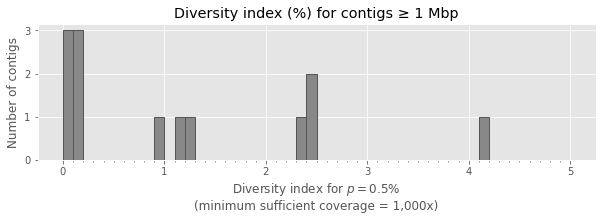

In [19]:
fig, ax = pyplot.subplots()

# Convert diversity indices to percentages
di_pcts = [100 * d for d in div_idx_final["DivIdx(p=50,minSuffCov=1000.0)"]]

# Create a histogram bin for every 0.1%. Also add nice little ticks demarcating these bins.
max_di_pct = ceil(max(di_pcts))
bins = [x / 10 for x in range((max_di_pct * 10) + 1)]

ax.hist(di_pcts, bins=bins, color="#888888", linewidth=1, edgecolor="#555555")
ax.set_xticks(bins, minor=True)

ax.set_title("Diversity index (%) for contigs \u2265 1 Mbp")
ax.set_xlabel("Diversity index for $p = 0.5\%$\n(minimum sufficient coverage = 1,000x)")
ax.set_ylabel("Number of contigs")
fig.set_size_inches(10, 2.5)

##### Scatterplot of two types of diversity indices ($p = 5\%$ and $p = 0.5\%$)

This demonstrates 1) a correlation between these values, and 2) the existence of a "cluster" of contigs with low diversity indices of both types.

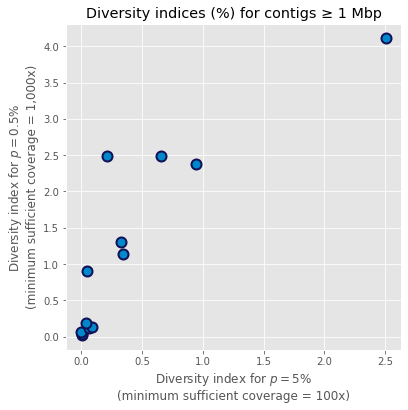

In [20]:
fig, ax = pyplot.subplots()
di_pct_x = [100 * d for d in div_idx_final["DivIdx(p=500,minSuffCov=100.0)"]]
di_pct_y = [100 * d for d in div_idx_final["DivIdx(p=50,minSuffCov=1000.0)"]]
ax.scatter(di_pct_x, di_pct_y, color="#0088cc", edgecolor="#111155", s=100, lw=2)
ax.set_title("Diversity indices (%) for contigs \u2265 1 Mbp")
ax.set_xlabel("Diversity index for $p = 5\%$\n(minimum sufficient coverage = 100x)")
ax.set_ylabel("Diversity index for $p = 0.5\%$\n(minimum sufficient coverage = 1,000x)")
fig.set_size_inches(6, 6)

### 2.5. Estimating FDRs using the target-decoy approach

We've seen that `edge_6104` is probably a good decoy contig, so we could if desired just pass it to `strainFlye fdr estimate` using that command's `-dc` or `--decoy-contig` option. However, to illustrate another option, we'll instead pass our diversity index information to `strainFlye fdr estimate` and let it do the job of selecting a decoy contig. (Spoiler alert: it'll select `edge_6104` anyway.)

In [21]:
!strainFlye fdr

Usage: strainFlye fdr [OPTIONS] COMMAND [ARGS]...

  [+] FDR estimation and fixing for contigs' mutation calls.

Options:
  -h, --help  Show this message and exit.

Commands:
  estimate  Estimates contigs' mutation calls' FDRs.
  fix       Fixes contigs' mutation calls' FDRs to an upper limit.


In [7]:
!strainFlye fdr estimate

Usage: strainFlye fdr estimate [OPTIONS]

  Estimates contigs' mutation calls' FDRs.

  We do this using the target-decoy approach (TDA). Given a set of C contigs,
  we select a "decoy contig" with relatively few called mutations. We then
  compute a mutation rate for this decoy contig, and use this mutation rate
  (along with the mutation rates of the other C - 1 "target" contigs) to
  estimate the FDRs of all of these target contigs' mutation calls.

  We can produce multiple FDR estimates for a single target contig's calls by
  varying the p or r threshold used (from the --min-p or --min-r threshold
  used to generate the input BCF file, up to the --high-p or --high-r
  threshold given here). Using this information (and information about the
  numbers of mutations called per megabase), we can plot an FDR curve for a
  given target contig's mutation calls.

Options:
  -c, --contigs PATH              FASTA file of contigs.  [required]
  -b, --bcf PATH                  Indexed BCF file

In [13]:
!strainFlye fdr estimate \
    --contigs /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs.fasta \
    --bcf /Poppy/mfedarko/sftests/tutorial-output/p0.15.bcf \
    --diversity-indices /Poppy/mfedarko/sftests/tutorial-output/p-div-indices.tsv \
    --decoy-context Full \
    --output-fdr-info /Poppy/mfedarko/sftests/tutorial-output/p-fdr-info.tsv \
    --output-num-info /Poppy/mfedarko/sftests/tutorial-output/p-num-info.tsv

--------
strainFlye fdr estimate @ 0.00 sec: Starting...
Input contig file: /Poppy/mfedarko/sftests/tutorial-output/sheepgut_contigs.fasta
Input BCF file: /Poppy/mfedarko/sftests/tutorial-output/p0.15.bcf
Input diversity indices file: /Poppy/mfedarko/sftests/tutorial-output/p-div-indices.tsv
Input manually-set decoy contig: None
Input decoy contig context-dependent mutation type: Full
Input high p threshold (only used if the BCF describes p-mutations): 500
Input high r threshold (only used if the BCF describes r-mutations): 100
Input min length of a potential decoy contig (only used if diversity indices are specified): 1000000
Input min average coverage of a potential decoy contig (only used if diversity indices are specified): 500.0
Output FDR estimate file: /Poppy/mfedarko/sftests/tutorial-output/p-fdr-info.tsv
Output number of mutations per megabase file: /Poppy/mfedarko/sftests/tutorial-output/p-num-info.tsv
--------
strainFlye fdr estimate @ 0.00 sec: Loading and checking contig i

### 2.6. Plotting FDR curves

To demonstrate how to plot this information, let's plot FDR curves for 25 relatively-high-mutation-rate contigs (considering 25 contigs that are at least 1 Mbp long and have the relatively highest diversity indices at $p = 2\%$).

(We use the $p = 2\%$ diversity indices here arbitrarily; the main reason is that there aren't 25 sufficiently-covered target contigs for any of the lower values of $p$ that we computed diversity indices.)

In [22]:
fdr_ests = pd.read_csv("/Poppy/mfedarko/sftests/tutorial-output/p-fdr-info.tsv", sep="\t", index_col=0)
numpermbs = pd.read_csv("/Poppy/mfedarko/sftests/tutorial-output/p-num-info.tsv", sep="\t", index_col=0)

In [23]:
div_idx_high_to_low = div_idx_just_long_cov_sorted.sort_values("DivIdx(p=200,minSuffCov=250.0)", ascending=False)
div_idx_high_to_low.head(25)

AverageCoverage   Length  DivIdx(p=50,minSuffCov=1000.0)  \
Contig                                                                 
edge_3030       1035.740707  1915304                        0.041088   
edge_8569        270.174269  2087330                             NaN   
edge_7356        742.905564  1602179                        0.024833   
edge_1526        518.044165  2338731                             NaN   
edge_1350        292.412389  2038177                             NaN   
edge_7354       1119.104000  1036318                        0.023789   
edge_1717        603.009889  2679593                             NaN   
edge_3402        877.282137  3713351                        0.024924   
edge_2406        284.263638  1769728                             NaN   
edge_4811        608.536703  1166051                             NaN   
edge_1671       1415.072755  2153394                        0.011340   
edge_694         322.596499  1125410                             NaN   
edge_7326        268.480987  1683810                             NaN   
edge_7349       1325.510426  1175877                        0.012973   
edge_4936        286.696127  1206308                             NaN   
edge_4751        345.769085  1549670                             NaN   
edge_1387        763.352489  2893861                             NaN   
edge_2008        381.732153  2665015                             NaN   
edge_1719        489.317975  1504657                             NaN   
edge_10177       521.484137  1515080                             NaN   
edge_62333       457.161299  1199970                             NaN   
edge_882         586.685511  2000256                             NaN   
edge_2075        572.226881  1853046                             NaN   
edge_13930       272.163645  1465791                             NaN   
edge_1076        363.697268  2313017                             NaN   

            DivIdx(p=100,minSuffCov=500.0)  DivIdx(p=200,minSuffCov=250.0)  \
Contig                                                                       
edge_3030                         0.033952                        0.031322   
edge_8569                              NaN                        0.022879   
edge_7356                         0.021453                        0.017328   
edge_1526                         0.019049                        0.016268   
edge_1350                              NaN                        0.016155   
edge_7354                         0.018875                        0.015372   
edge_1717                         0.017519                        0.012952   
edge_3402                         0.018800                        0.012130   
edge_2406                              NaN                        0.010964   
edge_4811                         0.013417                        0.009829   
edge_1671                         0.010501                        0.008338   
edge_694                               NaN                        0.008290   
edge_7326                              NaN                        0.008247   
edge_7349                         0.010487                        0.008060   
edge_4936                              NaN                        0.006756   
edge_4751                              NaN                        0.006060   
edge_1387                         0.009901                        0.005979   
edge_2008                              NaN                        0.005770   
edge_1719                         0.013607                        0.005361   
edge_10177                        0.008247                        0.004964   
edge_62333                             NaN                        0.004570   
edge_882                          0.008481                        0.002360   
edge_2075                         0.002382                        0.001803   
edge_13930                             NaN                        0.001294   
edge_1076                              

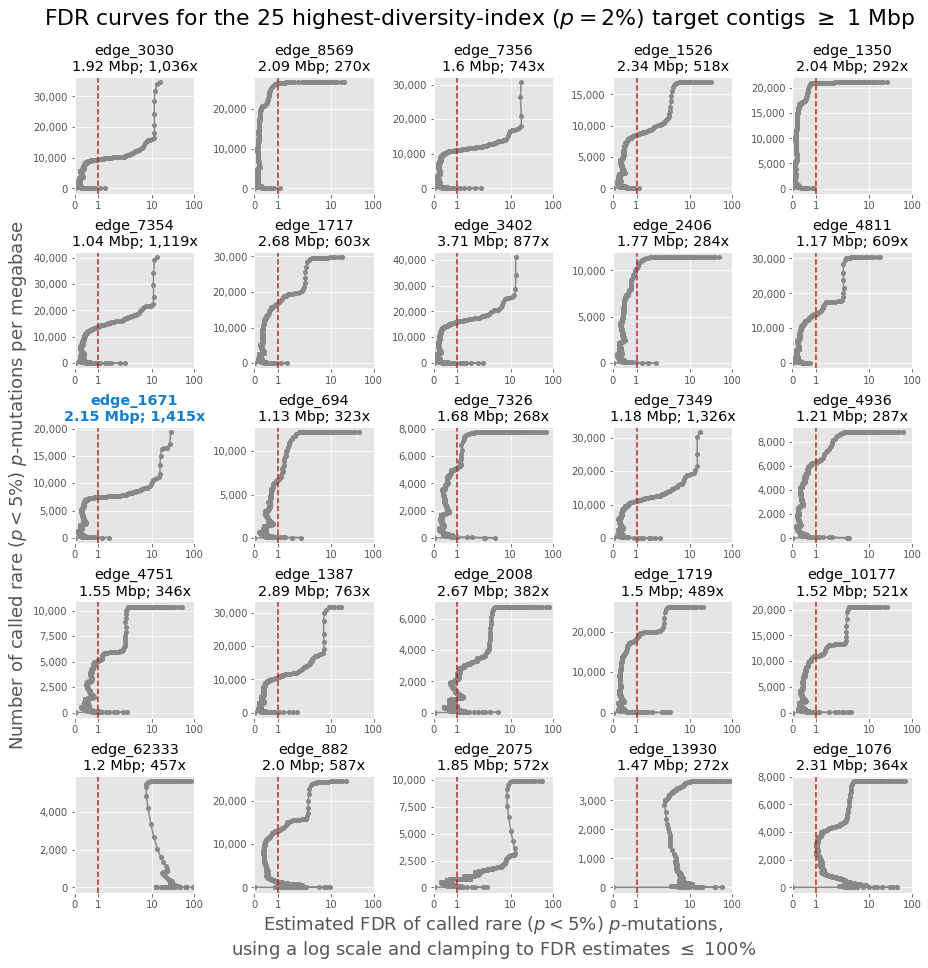

In [24]:
fig, axes = pyplot.subplots(5, 5, gridspec_kw={"hspace": 0.5, "wspace": 0.5})

contigs_to_plot = list(div_idx_high_to_low.index[:25])

# Ignore the decoy genome here: we don't have FDR estimates for it
if "edge_6104" in contigs_to_plot:
    contigs_to_plot.remove("edge_6104")
    contigs_to_plot.append(div_idx_high_to_low.index[25])

for ci, contig in enumerate(contigs_to_plot):
    # We'll organize the grid of plots starting from the top-left and moving right:
    # 0 1 2 3 4
    # 5 6 7 8 9
    # ... and so on, until we get to ci = 24.
    col = ci % 5
    row = floor(ci / 5)
    
    # Figure out exactly which points to plot -- ignore cases where no mutations were called
    # for this contig, since this results in a target mutation rate of 0 (resulting in an
    # undefined FDR). I'm pretty sure matplotlib will automatially account for this case without
    # us needing to do this, but I'm paranoid.
    x = []
    y = []
    xvals = fdr_ests.loc[contig]
    yvals = numpermbs.loc[contig]
    for f, n in zip(xvals, yvals):
        if not pd.isna(f):
            x.append(f)
            y.append(n)
    
    length_info = f"{round(div_idx_high_to_low['Length'][contig] / 1e6, 2):,} Mbp"
    cov_info = f"{round(div_idx_high_to_low['AverageCoverage'][contig]):,}x"
    title = f"{contig}\n{length_info}; {cov_info}"
    
    # Highlight the "selected" contigs (BACT1, BACT2) in blue
    tparams = {}
    if contig == "edge_1671" or contig == "edge_2358":
        tparams = {"fontweight": "semibold", "color": "#0f7ed4"}
    axes[row, col].set_title(title, **tparams)

    axes[row, col].plot(x, y, marker="o", color="#888", markersize=4)
    axes[row, col].axvline(x=1, linestyle="--", color="#b22")
    axes[row, col].set_xscale("symlog")
    axes[row, col].xaxis.set_major_formatter("{x:,.0f}")
    axes[row, col].yaxis.set_major_formatter("{x:,.0f}")
    axes[row, col].set_xlim(0, 100)

axes[2, 0].set_ylabel("Number of called rare ($p < 5\%$) $p$-mutations per megabase", fontsize=18)
axes[4, 2].set_xlabel(
    "Estimated FDR of called rare ($p < 5\%$) $p$-mutations,\nusing a log scale and clamping to FDR estimates $\leq$ 100%",
    fontsize=18
)
fig.suptitle(
    "FDR curves for the 25 highest-diversity-index ($p = 2\%$) target contigs $\geq$ 1 Mbp",
    fontsize=22,
    y=0.945
)
fig.set_size_inches(15, 15)

### 2.7. Fixing mutation calls' FDRs to an upper limit of $1\%$

In [2]:
!strainFlye fdr fix

Usage: strainFlye fdr fix [OPTIONS]

  Fixes contigs' mutation calls' FDRs to an upper limit.

  This takes as input the outputs of "strainFlye fdr estimate" to guide us on
  how to fix the FDR for each contig. Note that mutations that passed the
  "high" p or r threshold specified for "strainFlye fdr estimate", which were
  not used for FDR estimation, will all be included in the output BCF file
  from this command; these mutations are considered indisputable.

Options:
  -b, --bcf PATH         Indexed BCF file describing naïvely called p- or
                         r-mutations.  [required]
  -fi, --fdr-info FILE   Estimated FDR TSV file produced by "strainFlye fdr
                         estimate".  [required]
  --fdr FLOAT RANGE      False discovery rate at which identified mutations
                         will be fixed. This is interpreted as a percentage:
                         the default of 1 corresponds to an FDR of 1%. No
                         upper limit is imposed, 

In [9]:
!strainFlye fdr fix \
    --bcf /Poppy/mfedarko/sftests/tutorial-output/p0.15.bcf \
    --fdr-info /Poppy/mfedarko/sftests/tutorial-output/p-fdr-info.tsv \
    --fdr 1 \
    --output-bcf /Poppy/mfedarko/sftests/tutorial-output/p0.15-fdr1pct.bcf

--------
strainFlye fdr fix @ 0.00 sec: Starting...
Input BCF file: /Poppy/mfedarko/sftests/tutorial-output/p0.15.bcf
Input FDR estimate file: /Poppy/mfedarko/sftests/tutorial-output/p-fdr-info.tsv
Input FDR to fix mutation calls at: 1.0
Output BCF file with mutation calls at the fixed FDR: /Poppy/mfedarko/sftests/tutorial-output/p0.15-fdr1pct.bcf
--------
strainFlye fdr fix @ 0.00 sec: Loading and checking BCF and TSV files...
strainFlye fdr fix @ 2.77 sec: Looks good so far; decoy contig seems to be edge_6104.
strainFlye fdr fix @ 2.77 sec: Looks like the cutoff for "indisputable" mutations was p = 500.
strainFlye fdr fix @ 2.77 sec: All mutations passing this cutoff will be included in the output BCF file.
--------
strainFlye fdr fix @ 2.77 sec: Based on the FDR information, finding optimal values of p for each contig...
strainFlye fdr fix @ 5.97 sec: Done.
strainFlye fdr fix @ 5.98 sec: For 4,168 / 78,792 contigs, there exist values of p (at least, considering the range from p = 15

strainFlye fdr fix @ 6.63 sec: Wrote out 32,948 / 32,948 mutations for edge_106.
strainFlye fdr fix @ 6.63 sec: Wrote out 0 / 0 mutations for edge_107.
strainFlye fdr fix @ 6.64 sec: Wrote out 2,071 / 2,212 mutations for edge_108.
strainFlye fdr fix @ 6.64 sec: Wrote out 0 / 0 mutations for edge_109.
strainFlye fdr fix @ 6.64 sec: Wrote out 0 / 0 mutations for edge_110.
strainFlye fdr fix @ 6.64 sec: Wrote out 79 / 79 mutations for edge_111.
strainFlye fdr fix @ 6.64 sec: Wrote out 0 / 0 mutations for edge_112.
strainFlye fdr fix @ 6.64 sec: Wrote out 1,176 / 1,176 mutations for edge_113.
strainFlye fdr fix @ 6.64 sec: Wrote out 0 / 0 mutations for edge_114.
strainFlye fdr fix @ 6.64 sec: Wrote out 0 / 0 mutations for edge_115.
strainFlye fdr fix @ 6.64 sec: Wrote out 0 / 0 mutations for edge_116.
strainFlye fdr fix @ 6.64 sec: Wrote out 0 / 0 mutations for edge_117.
strainFlye fdr fix @ 6.64 sec: Wrote out 0 / 0 mutations for edge_118.
strainFlye fdr fix @ 6.64 sec: Wrote out 0 / 0 mu

strainFlye fdr fix @ 6.73 sec: Wrote out 8,784 / 8,803 mutations for edge_269.
strainFlye fdr fix @ 6.73 sec: Wrote out 0 / 0 mutations for edge_270.
strainFlye fdr fix @ 6.73 sec: Wrote out 0 / 0 mutations for edge_271.
strainFlye fdr fix @ 6.73 sec: Wrote out 0 / 0 mutations for edge_272.
strainFlye fdr fix @ 6.73 sec: Wrote out 0 / 0 mutations for edge_273.
strainFlye fdr fix @ 6.73 sec: Wrote out 0 / 0 mutations for edge_274.
strainFlye fdr fix @ 6.73 sec: Wrote out 0 / 0 mutations for edge_275.
strainFlye fdr fix @ 6.73 sec: Wrote out 0 / 0 mutations for edge_276.
strainFlye fdr fix @ 6.73 sec: Wrote out 0 / 0 mutations for edge_277.
strainFlye fdr fix @ 6.73 sec: Wrote out 0 / 0 mutations for edge_278.
strainFlye fdr fix @ 6.73 sec: Wrote out 0 / 0 mutations for edge_279.
strainFlye fdr fix @ 6.73 sec: Wrote out 0 / 0 mutations for edge_280.
strainFlye fdr fix @ 6.73 sec: Wrote out 0 / 0 mutations for edge_281.
strainFlye fdr fix @ 6.73 sec: Wrote out 414 / 414 mutations for edge

strainFlye fdr fix @ 6.77 sec: Wrote out 1,243 / 1,243 mutations for edge_471.
strainFlye fdr fix @ 6.77 sec: Wrote out 0 / 0 mutations for edge_472.
strainFlye fdr fix @ 6.77 sec: Wrote out 0 / 0 mutations for edge_473.
strainFlye fdr fix @ 6.77 sec: Wrote out 0 / 0 mutations for edge_474.
strainFlye fdr fix @ 6.77 sec: Wrote out 0 / 0 mutations for edge_475.
strainFlye fdr fix @ 6.77 sec: Wrote out 0 / 0 mutations for edge_476.
strainFlye fdr fix @ 6.77 sec: Wrote out 0 / 0 mutations for edge_477.
strainFlye fdr fix @ 6.77 sec: Wrote out 0 / 0 mutations for edge_478.
strainFlye fdr fix @ 6.77 sec: Wrote out 0 / 0 mutations for edge_479.
strainFlye fdr fix @ 6.77 sec: Wrote out 0 / 0 mutations for edge_480.
strainFlye fdr fix @ 6.77 sec: Wrote out 0 / 0 mutations for edge_481.
strainFlye fdr fix @ 6.77 sec: Wrote out 0 / 0 mutations for edge_482.
strainFlye fdr fix @ 6.77 sec: Wrote out 0 / 0 mutations for edge_483.
strainFlye fdr fix @ 6.77 sec: Wrote out 0 / 0 mutations for edge_484

strainFlye fdr fix @ 6.83 sec: Wrote out 5,620 / 5,620 mutations for edge_654.
strainFlye fdr fix @ 6.86 sec: Wrote out 2,676 / 3,169 mutations for edge_655.
strainFlye fdr fix @ 6.86 sec: Wrote out 0 / 0 mutations for edge_656.
strainFlye fdr fix @ 6.86 sec: Wrote out 79 / 979 mutations for edge_657.
strainFlye fdr fix @ 6.86 sec: Wrote out 0 / 0 mutations for edge_658.
strainFlye fdr fix @ 6.86 sec: Wrote out 0 / 0 mutations for edge_659.
strainFlye fdr fix @ 6.86 sec: Wrote out 69 / 69 mutations for edge_660.
strainFlye fdr fix @ 6.86 sec: Wrote out 0 / 0 mutations for edge_661.
strainFlye fdr fix @ 6.86 sec: Wrote out 0 / 0 mutations for edge_662.
strainFlye fdr fix @ 6.86 sec: Wrote out 0 / 0 mutations for edge_663.
strainFlye fdr fix @ 6.86 sec: Wrote out 0 / 0 mutations for edge_664.
strainFlye fdr fix @ 6.86 sec: Wrote out 0 / 0 mutations for edge_665.
strainFlye fdr fix @ 6.86 sec: Wrote out 0 / 0 mutations for edge_666.
strainFlye fdr fix @ 6.86 sec: Wrote out 0 / 0 mutations

strainFlye fdr fix @ 7.08 sec: Wrote out 9,678 / 9,678 mutations for edge_772.
strainFlye fdr fix @ 7.08 sec: Wrote out 1 / 3 mutations for edge_773.
strainFlye fdr fix @ 7.08 sec: Wrote out 0 / 0 mutations for edge_774.
strainFlye fdr fix @ 7.08 sec: Wrote out 0 / 0 mutations for edge_775.
strainFlye fdr fix @ 7.08 sec: Wrote out 0 / 0 mutations for edge_776.
strainFlye fdr fix @ 7.08 sec: Wrote out 0 / 0 mutations for edge_777.
strainFlye fdr fix @ 7.08 sec: Wrote out 0 / 0 mutations for edge_778.
strainFlye fdr fix @ 7.08 sec: Wrote out 81 / 81 mutations for edge_779.
strainFlye fdr fix @ 7.08 sec: Wrote out 3 / 3 mutations for edge_780.
strainFlye fdr fix @ 7.08 sec: Wrote out 0 / 0 mutations for edge_781.
strainFlye fdr fix @ 7.08 sec: Wrote out 0 / 0 mutations for edge_782.
strainFlye fdr fix @ 7.08 sec: Wrote out 0 / 0 mutations for edge_783.
strainFlye fdr fix @ 7.08 sec: Wrote out 819 / 819 mutations for edge_784.
strainFlye fdr fix @ 7.08 sec: Wrote out 0 / 0 mutations for ed

strainFlye fdr fix @ 7.64 sec: Wrote out 8,591 / 8,766 mutations for edge_900.
strainFlye fdr fix @ 7.64 sec: Wrote out 0 / 0 mutations for edge_901.
strainFlye fdr fix @ 7.64 sec: Wrote out 0 / 0 mutations for edge_902.
strainFlye fdr fix @ 7.64 sec: Wrote out 0 / 0 mutations for edge_903.
strainFlye fdr fix @ 7.64 sec: Wrote out 0 / 0 mutations for edge_904.
strainFlye fdr fix @ 7.64 sec: Wrote out 0 / 0 mutations for edge_905.
strainFlye fdr fix @ 7.64 sec: Wrote out 0 / 0 mutations for edge_906.
strainFlye fdr fix @ 7.64 sec: Wrote out 0 / 0 mutations for edge_907.
strainFlye fdr fix @ 7.65 sec: Wrote out 4,435 / 4,435 mutations for edge_908.
strainFlye fdr fix @ 7.65 sec: Wrote out 0 / 0 mutations for edge_909.
strainFlye fdr fix @ 7.65 sec: Wrote out 0 / 0 mutations for edge_910.
strainFlye fdr fix @ 7.65 sec: Wrote out 0 / 0 mutations for edge_911.
strainFlye fdr fix @ 7.65 sec: Wrote out 0 / 0 mutations for edge_912.
strainFlye fdr fix @ 7.69 sec: Wrote out 5,856 / 9,108 mutati

strainFlye fdr fix @ 8.03 sec: Wrote out 7,301 / 19,225 mutations for edge_1076.
strainFlye fdr fix @ 8.17 sec: Wrote out 15,681 / 45,553 mutations for edge_1077.
strainFlye fdr fix @ 8.17 sec: Wrote out 0 / 0 mutations for edge_1078.
strainFlye fdr fix @ 8.17 sec: Wrote out 0 / 0 mutations for edge_1079.
strainFlye fdr fix @ 8.17 sec: Wrote out 0 / 0 mutations for edge_1080.
strainFlye fdr fix @ 8.17 sec: Wrote out 0 / 0 mutations for edge_1081.
strainFlye fdr fix @ 8.17 sec: Wrote out 0 / 0 mutations for edge_1082.
strainFlye fdr fix @ 8.17 sec: Wrote out 0 / 0 mutations for edge_1083.
strainFlye fdr fix @ 8.17 sec: Wrote out 0 / 0 mutations for edge_1084.
strainFlye fdr fix @ 8.17 sec: Wrote out 0 / 0 mutations for edge_1085.
strainFlye fdr fix @ 8.17 sec: Wrote out 0 / 0 mutations for edge_1086.
strainFlye fdr fix @ 8.17 sec: Wrote out 0 / 0 mutations for edge_1087.
strainFlye fdr fix @ 8.17 sec: Wrote out 0 / 0 mutations for edge_1088.
strainFlye fdr fix @ 8.22 sec: Wrote out 10,8

strainFlye fdr fix @ 8.48 sec: Wrote out 9,011 / 9,011 mutations for edge_1224.
strainFlye fdr fix @ 8.48 sec: Wrote out 0 / 0 mutations for edge_1225.
strainFlye fdr fix @ 8.48 sec: Wrote out 0 / 0 mutations for edge_1226.
strainFlye fdr fix @ 8.48 sec: Wrote out 0 / 0 mutations for edge_1227.
strainFlye fdr fix @ 8.48 sec: Wrote out 0 / 0 mutations for edge_1228.
strainFlye fdr fix @ 8.48 sec: Wrote out 0 / 0 mutations for edge_1229.
strainFlye fdr fix @ 8.48 sec: Wrote out 97 / 97 mutations for edge_1230.
strainFlye fdr fix @ 8.48 sec: Wrote out 0 / 0 mutations for edge_1231.
strainFlye fdr fix @ 8.48 sec: Wrote out 0 / 0 mutations for edge_1232.
strainFlye fdr fix @ 8.48 sec: Wrote out 0 / 0 mutations for edge_1233.
strainFlye fdr fix @ 8.48 sec: Wrote out 0 / 0 mutations for edge_1234.
strainFlye fdr fix @ 8.48 sec: Wrote out 0 / 0 mutations for edge_1235.
strainFlye fdr fix @ 8.48 sec: Wrote out 0 / 0 mutations for edge_1236.
strainFlye fdr fix @ 8.48 sec: Wrote out 0 / 0 mutatio

strainFlye fdr fix @ 9.41 sec: Wrote out 1,972 / 2,466 mutations for edge_1348.
strainFlye fdr fix @ 9.41 sec: Wrote out 169 / 173 mutations for edge_1349.
strainFlye fdr fix @ 9.64 sec: Wrote out 53,839 / 53,952 mutations for edge_1350.
strainFlye fdr fix @ 9.64 sec: Wrote out 319 / 319 mutations for edge_1351.
strainFlye fdr fix @ 9.65 sec: Wrote out 2,613 / 2,800 mutations for edge_1352.
strainFlye fdr fix @ 9.66 sec: Wrote out 708 / 708 mutations for edge_1353.
strainFlye fdr fix @ 9.66 sec: Wrote out 0 / 0 mutations for edge_1354.
strainFlye fdr fix @ 9.66 sec: Wrote out 2,529 / 2,529 mutations for edge_1355.
strainFlye fdr fix @ 9.66 sec: Wrote out 0 / 0 mutations for edge_1356.
strainFlye fdr fix @ 9.66 sec: Wrote out 0 / 0 mutations for edge_1357.
strainFlye fdr fix @ 9.67 sec: Wrote out 265 / 266 mutations for edge_1358.
strainFlye fdr fix @ 9.69 sec: Wrote out 7,657 / 7,657 mutations for edge_1359.
strainFlye fdr fix @ 9.69 sec: Wrote out 0 / 0 mutations for edge_1360.
strain

strainFlye fdr fix @ 10.67 sec: Wrote out 15,934 / 15,935 mutations for edge_1463.
strainFlye fdr fix @ 10.67 sec: Wrote out 0 / 0 mutations for edge_1464.
strainFlye fdr fix @ 10.78 sec: Wrote out 25,870 / 25,932 mutations for edge_1465.
strainFlye fdr fix @ 10.78 sec: Wrote out 0 / 0 mutations for edge_1466.
strainFlye fdr fix @ 10.78 sec: Wrote out 0 / 0 mutations for edge_1467.
strainFlye fdr fix @ 10.78 sec: Wrote out 0 / 0 mutations for edge_1468.
strainFlye fdr fix @ 10.81 sec: Wrote out 6,840 / 7,243 mutations for edge_1469.
strainFlye fdr fix @ 10.81 sec: Wrote out 0 / 0 mutations for edge_1470.
strainFlye fdr fix @ 10.81 sec: Wrote out 64 / 64 mutations for edge_1471.
strainFlye fdr fix @ 10.81 sec: Wrote out 0 / 0 mutations for edge_1472.
strainFlye fdr fix @ 10.81 sec: Wrote out 0 / 0 mutations for edge_1473.
strainFlye fdr fix @ 10.81 sec: Wrote out 0 / 0 mutations for edge_1474.
strainFlye fdr fix @ 10.81 sec: Wrote out 0 / 0 mutations for edge_1475.
strainFlye fdr fix @ 

strainFlye fdr fix @ 11.97 sec: Wrote out 63,837 / 63,837 mutations for edge_1583.
strainFlye fdr fix @ 11.97 sec: Wrote out 844 / 844 mutations for edge_1584.
strainFlye fdr fix @ 11.98 sec: Wrote out 1,279 / 1,409 mutations for edge_1585.
strainFlye fdr fix @ 11.98 sec: Wrote out 3 / 3 mutations for edge_1586.
strainFlye fdr fix @ 11.98 sec: Wrote out 0 / 0 mutations for edge_1587.
strainFlye fdr fix @ 12.27 sec: Wrote out 67,273 / 67,449 mutations for edge_1588.
strainFlye fdr fix @ 12.27 sec: Wrote out 1,036 / 1,036 mutations for edge_1589.
strainFlye fdr fix @ 12.27 sec: Wrote out 0 / 0 mutations for edge_1590.
strainFlye fdr fix @ 12.27 sec: Wrote out 0 / 0 mutations for edge_1591.
strainFlye fdr fix @ 12.27 sec: Wrote out 0 / 0 mutations for edge_1592.
strainFlye fdr fix @ 12.27 sec: Wrote out 0 / 0 mutations for edge_1593.
strainFlye fdr fix @ 12.27 sec: Wrote out 0 / 0 mutations for edge_1594.
strainFlye fdr fix @ 12.27 sec: Wrote out 33 / 33 mutations for edge_1595.
strainFly

strainFlye fdr fix @ 13.14 sec: Wrote out 10,097 / 10,502 mutations for edge_1702.
strainFlye fdr fix @ 13.14 sec: Wrote out 1,231 / 1,231 mutations for edge_1703.
strainFlye fdr fix @ 13.14 sec: Wrote out 0 / 0 mutations for edge_1704.
strainFlye fdr fix @ 13.21 sec: Wrote out 12,414 / 15,758 mutations for edge_1705.
strainFlye fdr fix @ 13.22 sec: Wrote out 2,205 / 2,205 mutations for edge_1706.
strainFlye fdr fix @ 13.22 sec: Wrote out 0 / 0 mutations for edge_1707.
strainFlye fdr fix @ 13.22 sec: Wrote out 0 / 0 mutations for edge_1708.
strainFlye fdr fix @ 13.22 sec: Wrote out 0 / 0 mutations for edge_1709.
strainFlye fdr fix @ 13.27 sec: Wrote out 10,298 / 14,089 mutations for edge_1710.
strainFlye fdr fix @ 13.27 sec: Wrote out 253 / 253 mutations for edge_1711.
strainFlye fdr fix @ 13.27 sec: Wrote out 303 / 326 mutations for edge_1712.
strainFlye fdr fix @ 13.31 sec: Wrote out 7,890 / 8,284 mutations for edge_1713.
strainFlye fdr fix @ 13.32 sec: Wrote out 2,401 / 2,401 mutati

strainFlye fdr fix @ 14.78 sec: Wrote out 10,520 / 17,254 mutations for edge_1809.
strainFlye fdr fix @ 14.78 sec: Wrote out 0 / 0 mutations for edge_1810.
strainFlye fdr fix @ 14.78 sec: Wrote out 0 / 0 mutations for edge_1811.
strainFlye fdr fix @ 14.78 sec: Wrote out 0 / 0 mutations for edge_1812.
strainFlye fdr fix @ 14.78 sec: Wrote out 0 / 0 mutations for edge_1813.
strainFlye fdr fix @ 14.78 sec: Wrote out 0 / 0 mutations for edge_1814.
strainFlye fdr fix @ 14.78 sec: Wrote out 0 / 0 mutations for edge_1815.
strainFlye fdr fix @ 14.79 sec: Wrote out 1,027 / 3,116 mutations for edge_1816.
strainFlye fdr fix @ 14.79 sec: Wrote out 0 / 0 mutations for edge_1817.
strainFlye fdr fix @ 14.79 sec: Wrote out 0 / 0 mutations for edge_1818.
strainFlye fdr fix @ 14.92 sec: Wrote out 30,362 / 30,376 mutations for edge_1819.
strainFlye fdr fix @ 14.92 sec: Wrote out 242 / 242 mutations for edge_1820.
strainFlye fdr fix @ 14.92 sec: Wrote out 300 / 300 mutations for edge_1821.
strainFlye fdr 

strainFlye fdr fix @ 15.31 sec: Wrote out 10,107 / 10,107 mutations for edge_1919.
strainFlye fdr fix @ 15.32 sec: Wrote out 1,905 / 1,905 mutations for edge_1920.
strainFlye fdr fix @ 15.32 sec: Wrote out 1,926 / 1,926 mutations for edge_1921.
strainFlye fdr fix @ 15.32 sec: Wrote out 2 / 2 mutations for edge_1922.
strainFlye fdr fix @ 15.32 sec: Wrote out 181 / 181 mutations for edge_1923.
strainFlye fdr fix @ 15.32 sec: Wrote out 0 / 0 mutations for edge_1924.
strainFlye fdr fix @ 15.33 sec: Wrote out 924 / 924 mutations for edge_1925.
strainFlye fdr fix @ 15.33 sec: Wrote out 0 / 0 mutations for edge_1926.
strainFlye fdr fix @ 15.33 sec: Wrote out 0 / 0 mutations for edge_1927.
strainFlye fdr fix @ 15.33 sec: Wrote out 212 / 212 mutations for edge_1928.
strainFlye fdr fix @ 15.34 sec: Wrote out 2,243 / 2,251 mutations for edge_1929.
strainFlye fdr fix @ 15.34 sec: Wrote out 240 / 383 mutations for edge_1930.
strainFlye fdr fix @ 15.34 sec: Wrote out 0 / 27 mutations for edge_1931.


strainFlye fdr fix @ 16.12 sec: Wrote out 4,045 / 4,045 mutations for edge_2031.
strainFlye fdr fix @ 16.13 sec: Wrote out 1,198 / 1,198 mutations for edge_2032.
strainFlye fdr fix @ 16.13 sec: Wrote out 67 / 67 mutations for edge_2033.
strainFlye fdr fix @ 16.13 sec: Wrote out 0 / 0 mutations for edge_2034.
strainFlye fdr fix @ 16.13 sec: Wrote out 0 / 0 mutations for edge_2035.
strainFlye fdr fix @ 16.13 sec: Wrote out 423 / 423 mutations for edge_2036.
strainFlye fdr fix @ 16.13 sec: Wrote out 0 / 0 mutations for edge_2037.
strainFlye fdr fix @ 16.19 sec: Wrote out 13,924 / 13,924 mutations for edge_2038.
strainFlye fdr fix @ 16.19 sec: Wrote out 0 / 0 mutations for edge_2039.
strainFlye fdr fix @ 16.19 sec: Wrote out 0 / 0 mutations for edge_2040.
strainFlye fdr fix @ 16.19 sec: Wrote out 0 / 0 mutations for edge_2041.
strainFlye fdr fix @ 16.19 sec: Wrote out 0 / 0 mutations for edge_2042.
strainFlye fdr fix @ 16.20 sec: Wrote out 2,855 / 2,856 mutations for edge_2043.
strainFlye 

strainFlye fdr fix @ 17.68 sec: Wrote out 12,431 / 12,431 mutations for edge_2140.
strainFlye fdr fix @ 17.70 sec: Wrote out 2,613 / 4,873 mutations for edge_2141.
strainFlye fdr fix @ 17.71 sec: Wrote out 3,585 / 4,934 mutations for edge_2142.
strainFlye fdr fix @ 17.72 sec: Wrote out 387 / 387 mutations for edge_2143.
strainFlye fdr fix @ 17.72 sec: Wrote out 0 / 0 mutations for edge_2144.
strainFlye fdr fix @ 17.72 sec: Wrote out 458 / 458 mutations for edge_2145.
strainFlye fdr fix @ 17.75 sec: Wrote out 10,155 / 10,155 mutations for edge_2146.
strainFlye fdr fix @ 17.75 sec: Wrote out 9 / 9 mutations for edge_2147.
strainFlye fdr fix @ 17.75 sec: Wrote out 188 / 188 mutations for edge_2148.
strainFlye fdr fix @ 17.76 sec: Wrote out 1,116 / 1,116 mutations for edge_2149.
strainFlye fdr fix @ 17.76 sec: Wrote out 0 / 0 mutations for edge_2150.
strainFlye fdr fix @ 17.76 sec: Wrote out 261 / 455 mutations for edge_2151.
strainFlye fdr fix @ 17.76 sec: Wrote out 0 / 0 mutations for ed

strainFlye fdr fix @ 18.56 sec: Wrote out 3,619 / 3,619 mutations for edge_2264.
strainFlye fdr fix @ 18.56 sec: Wrote out 1,247 / 1,247 mutations for edge_2265.
strainFlye fdr fix @ 18.61 sec: Wrote out 14,101 / 14,101 mutations for edge_2266.
strainFlye fdr fix @ 18.62 sec: Wrote out 1,827 / 1,827 mutations for edge_2267.
strainFlye fdr fix @ 18.62 sec: Wrote out 1,013 / 1,013 mutations for edge_2268.
strainFlye fdr fix @ 18.62 sec: Wrote out 1,467 / 1,475 mutations for edge_2269.
strainFlye fdr fix @ 18.63 sec: Wrote out 556 / 564 mutations for edge_2270.
strainFlye fdr fix @ 18.63 sec: Wrote out 0 / 0 mutations for edge_2271.
strainFlye fdr fix @ 18.64 sec: Wrote out 2,269 / 3,668 mutations for edge_2272.
strainFlye fdr fix @ 18.64 sec: Wrote out 0 / 0 mutations for edge_2273.
strainFlye fdr fix @ 18.64 sec: Wrote out 1 / 420 mutations for edge_2274.
strainFlye fdr fix @ 18.64 sec: Wrote out 0 / 0 mutations for edge_2275.
strainFlye fdr fix @ 18.64 sec: Wrote out 0 / 0 mutations fo

strainFlye fdr fix @ 19.24 sec: Wrote out 9,461 / 9,461 mutations for edge_2380.
strainFlye fdr fix @ 19.24 sec: Wrote out 0 / 0 mutations for edge_2381.
strainFlye fdr fix @ 19.24 sec: Wrote out 0 / 0 mutations for edge_2382.
strainFlye fdr fix @ 19.25 sec: Wrote out 601 / 601 mutations for edge_2383.
strainFlye fdr fix @ 19.25 sec: Wrote out 0 / 0 mutations for edge_2384.
strainFlye fdr fix @ 19.27 sec: Wrote out 6,457 / 6,457 mutations for edge_2385.
strainFlye fdr fix @ 19.28 sec: Wrote out 2,313 / 2,313 mutations for edge_2386.
strainFlye fdr fix @ 19.28 sec: Wrote out 0 / 0 mutations for edge_2387.
strainFlye fdr fix @ 19.30 sec: Wrote out 5,197 / 6,998 mutations for edge_2388.
strainFlye fdr fix @ 19.30 sec: Wrote out 0 / 0 mutations for edge_2389.
strainFlye fdr fix @ 19.30 sec: Wrote out 0 / 0 mutations for edge_2390.
strainFlye fdr fix @ 19.30 sec: Wrote out 371 / 371 mutations for edge_2391.
strainFlye fdr fix @ 19.30 sec: Wrote out 0 / 0 mutations for edge_2392.
strainFlye 

strainFlye fdr fix @ 20.02 sec: Wrote out 2,131 / 2,131 mutations for edge_2496.
strainFlye fdr fix @ 20.03 sec: Wrote out 2,066 / 2,066 mutations for edge_2497.
strainFlye fdr fix @ 20.03 sec: Wrote out 0 / 0 mutations for edge_2498.
strainFlye fdr fix @ 20.04 sec: Wrote out 409 / 409 mutations for edge_2499.
strainFlye fdr fix @ 20.04 sec: Wrote out 0 / 0 mutations for edge_2500.
strainFlye fdr fix @ 20.04 sec: Wrote out 853 / 1,049 mutations for edge_2501.
strainFlye fdr fix @ 20.06 sec: Wrote out 5,193 / 5,271 mutations for edge_2502.
strainFlye fdr fix @ 20.06 sec: Wrote out 0 / 0 mutations for edge_2503.
strainFlye fdr fix @ 20.06 sec: Wrote out 60 / 60 mutations for edge_2504.
strainFlye fdr fix @ 20.06 sec: Wrote out 0 / 0 mutations for edge_2505.
strainFlye fdr fix @ 20.06 sec: Wrote out 0 / 0 mutations for edge_2506.
strainFlye fdr fix @ 20.06 sec: Wrote out 631 / 631 mutations for edge_2507.
strainFlye fdr fix @ 20.06 sec: Wrote out 860 / 870 mutations for edge_2508.
strainF

strainFlye fdr fix @ 20.53 sec: Wrote out 966 / 966 mutations for edge_2624.
strainFlye fdr fix @ 20.54 sec: Wrote out 3,148 / 3,454 mutations for edge_2625.
strainFlye fdr fix @ 20.54 sec: Wrote out 0 / 0 mutations for edge_2626.
strainFlye fdr fix @ 20.55 sec: Wrote out 997 / 997 mutations for edge_2627.
strainFlye fdr fix @ 20.55 sec: Wrote out 24 / 24 mutations for edge_2628.
strainFlye fdr fix @ 20.55 sec: Wrote out 2 / 2 mutations for edge_2629.
strainFlye fdr fix @ 20.55 sec: Wrote out 259 / 313 mutations for edge_2630.
strainFlye fdr fix @ 20.55 sec: Wrote out 0 / 0 mutations for edge_2631.
strainFlye fdr fix @ 20.55 sec: Wrote out 325 / 325 mutations for edge_2632.
strainFlye fdr fix @ 20.55 sec: Wrote out 0 / 0 mutations for edge_2633.
strainFlye fdr fix @ 20.55 sec: Wrote out 0 / 0 mutations for edge_2634.
strainFlye fdr fix @ 20.57 sec: Wrote out 3,620 / 3,620 mutations for edge_2635.
strainFlye fdr fix @ 20.64 sec: Wrote out 16,447 / 16,447 mutations for edge_2636.
strainF

strainFlye fdr fix @ 21.21 sec: Wrote out 20,276 / 20,285 mutations for edge_2747.
strainFlye fdr fix @ 21.21 sec: Wrote out 0 / 0 mutations for edge_2748.
strainFlye fdr fix @ 21.22 sec: Wrote out 944 / 944 mutations for edge_2749.
strainFlye fdr fix @ 21.27 sec: Wrote out 16,523 / 16,523 mutations for edge_2750.
strainFlye fdr fix @ 21.27 sec: Wrote out 0 / 0 mutations for edge_2751.
strainFlye fdr fix @ 21.27 sec: Wrote out 0 / 0 mutations for edge_2752.
strainFlye fdr fix @ 21.27 sec: Wrote out 0 / 0 mutations for edge_2753.
strainFlye fdr fix @ 21.27 sec: Wrote out 435 / 435 mutations for edge_2754.
strainFlye fdr fix @ 21.27 sec: Wrote out 0 / 0 mutations for edge_2755.
strainFlye fdr fix @ 21.28 sec: Wrote out 1,724 / 1,813 mutations for edge_2756.
strainFlye fdr fix @ 21.28 sec: Wrote out 439 / 439 mutations for edge_2757.
strainFlye fdr fix @ 21.29 sec: Wrote out 1,904 / 1,904 mutations for edge_2758.
strainFlye fdr fix @ 21.29 sec: Wrote out 173 / 388 mutations for edge_2759.

strainFlye fdr fix @ 21.75 sec: Wrote out 523 / 523 mutations for edge_2861.
strainFlye fdr fix @ 21.75 sec: Wrote out 381 / 381 mutations for edge_2862.
strainFlye fdr fix @ 21.75 sec: Wrote out 0 / 0 mutations for edge_2863.
strainFlye fdr fix @ 21.75 sec: Wrote out 2 / 2 mutations for edge_2864.
strainFlye fdr fix @ 21.75 sec: Wrote out 0 / 0 mutations for edge_2865.
strainFlye fdr fix @ 21.75 sec: Wrote out 0 / 0 mutations for edge_2866.
strainFlye fdr fix @ 21.75 sec: Wrote out 0 / 0 mutations for edge_2867.
strainFlye fdr fix @ 21.81 sec: Wrote out 12,453 / 12,453 mutations for edge_2868.
strainFlye fdr fix @ 21.81 sec: Wrote out 0 / 0 mutations for edge_2869.
strainFlye fdr fix @ 21.81 sec: Wrote out 0 / 0 mutations for edge_2870.
strainFlye fdr fix @ 21.81 sec: Wrote out 0 / 0 mutations for edge_2871.
strainFlye fdr fix @ 21.81 sec: Wrote out 0 / 0 mutations for edge_2872.
strainFlye fdr fix @ 21.81 sec: Wrote out 0 / 0 mutations for edge_2873.
strainFlye fdr fix @ 21.81 sec: W

strainFlye fdr fix @ 22.31 sec: Wrote out 626 / 626 mutations for edge_2975.
strainFlye fdr fix @ 22.31 sec: Wrote out 619 / 619 mutations for edge_2976.
strainFlye fdr fix @ 22.34 sec: Wrote out 5,650 / 5,650 mutations for edge_2977.
strainFlye fdr fix @ 22.34 sec: Wrote out 0 / 0 mutations for edge_2978.
strainFlye fdr fix @ 22.34 sec: Wrote out 1,529 / 1,529 mutations for edge_2979.
strainFlye fdr fix @ 22.36 sec: Wrote out 4,226 / 4,226 mutations for edge_2980.
strainFlye fdr fix @ 22.36 sec: Wrote out 0 / 0 mutations for edge_2981.
strainFlye fdr fix @ 22.36 sec: Wrote out 764 / 764 mutations for edge_2982.
strainFlye fdr fix @ 22.36 sec: Wrote out 0 / 0 mutations for edge_2983.
strainFlye fdr fix @ 22.37 sec: Wrote out 1,870 / 2,287 mutations for edge_2984.
strainFlye fdr fix @ 22.37 sec: Wrote out 0 / 0 mutations for edge_2985.
strainFlye fdr fix @ 22.39 sec: Wrote out 2,437 / 6,492 mutations for edge_2986.
strainFlye fdr fix @ 22.39 sec: Wrote out 1 / 1 mutations for edge_2987.

strainFlye fdr fix @ 23.14 sec: Wrote out 5,189 / 5,189 mutations for edge_3087.
strainFlye fdr fix @ 23.14 sec: Wrote out 0 / 0 mutations for edge_3088.
strainFlye fdr fix @ 23.22 sec: Wrote out 21,861 / 21,861 mutations for edge_3089.
strainFlye fdr fix @ 23.22 sec: Wrote out 0 / 0 mutations for edge_3090.
strainFlye fdr fix @ 23.30 sec: Wrote out 19,296 / 19,298 mutations for edge_3091.
strainFlye fdr fix @ 23.33 sec: Wrote out 9,066 / 9,068 mutations for edge_3092.
strainFlye fdr fix @ 23.33 sec: Wrote out 0 / 0 mutations for edge_3093.
strainFlye fdr fix @ 23.33 sec: Wrote out 0 / 0 mutations for edge_3094.
strainFlye fdr fix @ 23.33 sec: Wrote out 0 / 0 mutations for edge_3095.
strainFlye fdr fix @ 23.33 sec: Wrote out 1,202 / 1,202 mutations for edge_3096.
strainFlye fdr fix @ 23.34 sec: Wrote out 1,686 / 1,686 mutations for edge_3097.
strainFlye fdr fix @ 23.34 sec: Wrote out 0 / 0 mutations for edge_3098.
strainFlye fdr fix @ 23.34 sec: Wrote out 161 / 161 mutations for edge_3

strainFlye fdr fix @ 23.89 sec: Wrote out 1,824 / 1,824 mutations for edge_3211.
strainFlye fdr fix @ 23.89 sec: Wrote out 0 / 0 mutations for edge_3212.
strainFlye fdr fix @ 23.89 sec: Wrote out 0 / 0 mutations for edge_3213.
strainFlye fdr fix @ 23.89 sec: Wrote out 1 / 1 mutations for edge_3214.
strainFlye fdr fix @ 23.89 sec: Wrote out 0 / 0 mutations for edge_3215.
strainFlye fdr fix @ 23.89 sec: Wrote out 0 / 0 mutations for edge_3216.
strainFlye fdr fix @ 23.89 sec: Wrote out 4 / 4 mutations for edge_3217.
strainFlye fdr fix @ 23.89 sec: Wrote out 0 / 0 mutations for edge_3218.
strainFlye fdr fix @ 23.94 sec: Wrote out 10,234 / 10,234 mutations for edge_3219.
strainFlye fdr fix @ 23.94 sec: Wrote out 1,560 / 1,560 mutations for edge_3220.
strainFlye fdr fix @ 23.97 sec: Wrote out 7,148 / 7,148 mutations for edge_3221.
strainFlye fdr fix @ 24.03 sec: Wrote out 13,242 / 13,242 mutations for edge_3222.
strainFlye fdr fix @ 24.04 sec: Wrote out 4,440 / 4,440 mutations for edge_3223.

strainFlye fdr fix @ 24.65 sec: Wrote out 6,374 / 6,374 mutations for edge_3324.
strainFlye fdr fix @ 24.66 sec: Wrote out 2,357 / 2,357 mutations for edge_3325.
strainFlye fdr fix @ 24.66 sec: Wrote out 8 / 8 mutations for edge_3326.
strainFlye fdr fix @ 24.67 sec: Wrote out 579 / 579 mutations for edge_3327.
strainFlye fdr fix @ 24.67 sec: Wrote out 0 / 0 mutations for edge_3328.
strainFlye fdr fix @ 24.67 sec: Wrote out 5 / 27 mutations for edge_3329.
strainFlye fdr fix @ 24.72 sec: Wrote out 13,570 / 13,570 mutations for edge_3330.
strainFlye fdr fix @ 24.73 sec: Wrote out 892 / 892 mutations for edge_3331.
strainFlye fdr fix @ 24.73 sec: Wrote out 1,704 / 2,164 mutations for edge_3332.
strainFlye fdr fix @ 24.73 sec: Wrote out 0 / 0 mutations for edge_3333.
strainFlye fdr fix @ 24.75 sec: Wrote out 4,548 / 4,548 mutations for edge_3334.
strainFlye fdr fix @ 24.75 sec: Wrote out 740 / 740 mutations for edge_3335.
strainFlye fdr fix @ 24.76 sec: Wrote out 844 / 844 mutations for edg

strainFlye fdr fix @ 25.62 sec: Wrote out 3,759 / 3,759 mutations for edge_3445.
strainFlye fdr fix @ 25.64 sec: Wrote out 3,481 / 3,481 mutations for edge_3446.
strainFlye fdr fix @ 25.64 sec: Wrote out 0 / 0 mutations for edge_3447.
strainFlye fdr fix @ 25.65 sec: Wrote out 2,785 / 2,785 mutations for edge_3448.
strainFlye fdr fix @ 25.65 sec: Wrote out 93 / 93 mutations for edge_3449.
strainFlye fdr fix @ 25.65 sec: Wrote out 13 / 13 mutations for edge_3450.
strainFlye fdr fix @ 25.73 sec: Wrote out 18,302 / 18,321 mutations for edge_3451.
strainFlye fdr fix @ 25.73 sec: Wrote out 0 / 0 mutations for edge_3452.
strainFlye fdr fix @ 25.74 sec: Wrote out 3,729 / 3,729 mutations for edge_3453.
strainFlye fdr fix @ 25.74 sec: Wrote out 386 / 386 mutations for edge_3454.
strainFlye fdr fix @ 25.74 sec: Wrote out 0 / 0 mutations for edge_3455.
strainFlye fdr fix @ 25.74 sec: Wrote out 545 / 545 mutations for edge_3456.
strainFlye fdr fix @ 25.75 sec: Wrote out 3,326 / 3,326 mutations for 

strainFlye fdr fix @ 26.29 sec: Wrote out 8,184 / 8,184 mutations for edge_3568.
strainFlye fdr fix @ 26.38 sec: Wrote out 26,423 / 26,423 mutations for edge_3569.
strainFlye fdr fix @ 26.38 sec: Wrote out 57 / 57 mutations for edge_3570.
strainFlye fdr fix @ 26.38 sec: Wrote out 0 / 0 mutations for edge_3571.
strainFlye fdr fix @ 26.38 sec: Wrote out 0 / 0 mutations for edge_3572.
strainFlye fdr fix @ 26.39 sec: Wrote out 705 / 705 mutations for edge_3573.
strainFlye fdr fix @ 26.39 sec: Wrote out 0 / 0 mutations for edge_3574.
strainFlye fdr fix @ 26.39 sec: Wrote out 353 / 353 mutations for edge_3575.
strainFlye fdr fix @ 26.39 sec: Wrote out 0 / 0 mutations for edge_3576.
strainFlye fdr fix @ 26.39 sec: Wrote out 23 / 23 mutations for edge_3577.
strainFlye fdr fix @ 26.39 sec: Wrote out 1,325 / 1,325 mutations for edge_3578.
strainFlye fdr fix @ 26.40 sec: Wrote out 429 / 429 mutations for edge_3579.
strainFlye fdr fix @ 26.40 sec: Wrote out 0 / 0 mutations for edge_3580.
strainFly

strainFlye fdr fix @ 26.94 sec: Wrote out 2,226 / 2,226 mutations for edge_3680.
strainFlye fdr fix @ 26.94 sec: Wrote out 0 / 0 mutations for edge_3681.
strainFlye fdr fix @ 26.95 sec: Wrote out 2,879 / 2,879 mutations for edge_3682.
strainFlye fdr fix @ 26.95 sec: Wrote out 1,121 / 1,121 mutations for edge_3683.
strainFlye fdr fix @ 26.96 sec: Wrote out 214 / 214 mutations for edge_3684.
strainFlye fdr fix @ 26.96 sec: Wrote out 0 / 0 mutations for edge_3685.
strainFlye fdr fix @ 26.96 sec: Wrote out 1,407 / 1,407 mutations for edge_3686.
strainFlye fdr fix @ 26.96 sec: Wrote out 0 / 0 mutations for edge_3687.
strainFlye fdr fix @ 26.96 sec: Wrote out 0 / 0 mutations for edge_3688.
strainFlye fdr fix @ 26.96 sec: Wrote out 0 / 0 mutations for edge_3689.
strainFlye fdr fix @ 26.96 sec: Wrote out 0 / 0 mutations for edge_3690.
strainFlye fdr fix @ 26.96 sec: Wrote out 0 / 0 mutations for edge_3691.
strainFlye fdr fix @ 26.97 sec: Wrote out 1,627 / 1,627 mutations for edge_3692.
strainF

strainFlye fdr fix @ 27.41 sec: Wrote out 4,512 / 4,512 mutations for edge_3808.
strainFlye fdr fix @ 27.41 sec: Wrote out 0 / 0 mutations for edge_3809.
strainFlye fdr fix @ 27.41 sec: Wrote out 0 / 0 mutations for edge_3810.
strainFlye fdr fix @ 27.45 sec: Wrote out 10,465 / 10,465 mutations for edge_3811.
strainFlye fdr fix @ 27.46 sec: Wrote out 681 / 681 mutations for edge_3812.
strainFlye fdr fix @ 27.46 sec: Wrote out 0 / 0 mutations for edge_3813.
strainFlye fdr fix @ 27.47 sec: Wrote out 2,912 / 2,912 mutations for edge_3814.
strainFlye fdr fix @ 27.47 sec: Wrote out 4 / 4 mutations for edge_3815.
strainFlye fdr fix @ 27.47 sec: Wrote out 5 / 5 mutations for edge_3816.
strainFlye fdr fix @ 27.47 sec: Wrote out 1,752 / 1,752 mutations for edge_3817.
strainFlye fdr fix @ 27.47 sec: Wrote out 10 / 10 mutations for edge_3818.
strainFlye fdr fix @ 27.49 sec: Wrote out 4,398 / 4,398 mutations for edge_3819.
strainFlye fdr fix @ 27.49 sec: Wrote out 30 / 30 mutations for edge_3820.
s

strainFlye fdr fix @ 27.82 sec: Wrote out 5,556 / 5,556 mutations for edge_3924.
strainFlye fdr fix @ 27.82 sec: Wrote out 1,227 / 1,227 mutations for edge_3925.
strainFlye fdr fix @ 27.82 sec: Wrote out 0 / 0 mutations for edge_3926.
strainFlye fdr fix @ 27.83 sec: Wrote out 1,283 / 1,378 mutations for edge_3927.
strainFlye fdr fix @ 27.83 sec: Wrote out 0 / 0 mutations for edge_3928.
strainFlye fdr fix @ 27.83 sec: Wrote out 0 / 0 mutations for edge_3929.
strainFlye fdr fix @ 27.83 sec: Wrote out 0 / 0 mutations for edge_3930.
strainFlye fdr fix @ 27.83 sec: Wrote out 0 / 0 mutations for edge_3931.
strainFlye fdr fix @ 27.83 sec: Wrote out 0 / 0 mutations for edge_3932.
strainFlye fdr fix @ 27.84 sec: Wrote out 1,384 / 1,384 mutations for edge_3933.
strainFlye fdr fix @ 27.84 sec: Wrote out 456 / 456 mutations for edge_3934.
strainFlye fdr fix @ 27.84 sec: Wrote out 0 / 0 mutations for edge_3935.
strainFlye fdr fix @ 27.84 sec: Wrote out 0 / 0 mutations for edge_3936.
strainFlye fdr 

strainFlye fdr fix @ 28.11 sec: Wrote out 4,073 / 4,073 mutations for edge_4037.
strainFlye fdr fix @ 28.13 sec: Wrote out 2,330 / 4,276 mutations for edge_4038.
strainFlye fdr fix @ 28.13 sec: Wrote out 0 / 0 mutations for edge_4039.
strainFlye fdr fix @ 28.13 sec: Wrote out 0 / 0 mutations for edge_4040.
strainFlye fdr fix @ 28.13 sec: Wrote out 0 / 47 mutations for edge_4041.
strainFlye fdr fix @ 28.13 sec: Wrote out 424 / 424 mutations for edge_4042.
strainFlye fdr fix @ 28.13 sec: Wrote out 0 / 0 mutations for edge_4043.
strainFlye fdr fix @ 28.13 sec: Wrote out 0 / 0 mutations for edge_4044.
strainFlye fdr fix @ 28.13 sec: Wrote out 0 / 0 mutations for edge_4045.
strainFlye fdr fix @ 28.13 sec: Wrote out 0 / 0 mutations for edge_4046.
strainFlye fdr fix @ 28.13 sec: Wrote out 0 / 0 mutations for edge_4047.
strainFlye fdr fix @ 28.19 sec: Wrote out 18,276 / 18,276 mutations for edge_4048.
strainFlye fdr fix @ 28.19 sec: Wrote out 0 / 0 mutations for edge_4049.
strainFlye fdr fix @

strainFlye fdr fix @ 28.27 sec: Wrote out 7,972 / 7,972 mutations for edge_4229.
strainFlye fdr fix @ 28.32 sec: Wrote out 13,771 / 14,013 mutations for edge_4230.
strainFlye fdr fix @ 28.32 sec: Wrote out 0 / 0 mutations for edge_4231.
strainFlye fdr fix @ 28.33 sec: Wrote out 902 / 902 mutations for edge_4232.
strainFlye fdr fix @ 28.40 sec: Wrote out 16,387 / 17,223 mutations for edge_4233.
strainFlye fdr fix @ 28.52 sec: Wrote out 29,726 / 30,236 mutations for edge_4234.
strainFlye fdr fix @ 28.53 sec: Wrote out 19 / 22 mutations for edge_4235.
strainFlye fdr fix @ 28.53 sec: Wrote out 0 / 0 mutations for edge_4236.
strainFlye fdr fix @ 28.53 sec: Wrote out 0 / 0 mutations for edge_4237.
strainFlye fdr fix @ 28.53 sec: Wrote out 0 / 0 mutations for edge_4238.
strainFlye fdr fix @ 28.53 sec: Wrote out 0 / 0 mutations for edge_4239.
strainFlye fdr fix @ 28.53 sec: Wrote out 0 / 0 mutations for edge_4240.
strainFlye fdr fix @ 28.53 sec: Wrote out 0 / 0 mutations for edge_4241.
strainF

strainFlye fdr fix @ 28.64 sec: Wrote out 24,314 / 24,314 mutations for edge_4371.
strainFlye fdr fix @ 28.64 sec: Wrote out 0 / 0 mutations for edge_4372.
strainFlye fdr fix @ 28.64 sec: Wrote out 0 / 0 mutations for edge_4373.
strainFlye fdr fix @ 28.64 sec: Wrote out 0 / 0 mutations for edge_4374.
strainFlye fdr fix @ 28.64 sec: Wrote out 0 / 0 mutations for edge_4375.
strainFlye fdr fix @ 28.64 sec: Wrote out 0 / 0 mutations for edge_4376.
strainFlye fdr fix @ 28.64 sec: Wrote out 0 / 0 mutations for edge_4377.
strainFlye fdr fix @ 28.64 sec: Wrote out 0 / 0 mutations for edge_4378.
strainFlye fdr fix @ 28.64 sec: Wrote out 82 / 82 mutations for edge_4379.
strainFlye fdr fix @ 28.72 sec: Wrote out 21,083 / 21,628 mutations for edge_4380.
strainFlye fdr fix @ 28.72 sec: Wrote out 0 / 0 mutations for edge_4381.
strainFlye fdr fix @ 28.74 sec: Wrote out 8,185 / 8,985 mutations for edge_4382.
strainFlye fdr fix @ 28.77 sec: Wrote out 5,806 / 5,806 mutations for edge_4383.
strainFlye fd

strainFlye fdr fix @ 29.18 sec: Wrote out 7,972 / 7,991 mutations for edge_4493.
strainFlye fdr fix @ 29.18 sec: Wrote out 0 / 0 mutations for edge_4494.
strainFlye fdr fix @ 29.18 sec: Wrote out 1 / 1 mutations for edge_4495.
strainFlye fdr fix @ 29.18 sec: Wrote out 0 / 0 mutations for edge_4496.
strainFlye fdr fix @ 29.18 sec: Wrote out 521 / 521 mutations for edge_4497.
strainFlye fdr fix @ 29.18 sec: Wrote out 0 / 0 mutations for edge_4498.
strainFlye fdr fix @ 29.18 sec: Wrote out 0 / 0 mutations for edge_4499.
strainFlye fdr fix @ 29.18 sec: Wrote out 1,215 / 1,215 mutations for edge_4500.
strainFlye fdr fix @ 29.18 sec: Wrote out 0 / 0 mutations for edge_4501.
strainFlye fdr fix @ 29.18 sec: Wrote out 0 / 0 mutations for edge_4502.
strainFlye fdr fix @ 29.18 sec: Wrote out 0 / 0 mutations for edge_4503.
strainFlye fdr fix @ 29.18 sec: Wrote out 0 / 0 mutations for edge_4504.
strainFlye fdr fix @ 29.18 sec: Wrote out 0 / 0 mutations for edge_4505.
strainFlye fdr fix @ 29.18 sec:

strainFlye fdr fix @ 29.48 sec: Wrote out 19,053 / 19,053 mutations for edge_4632.
strainFlye fdr fix @ 29.48 sec: Wrote out 0 / 0 mutations for edge_4633.
strainFlye fdr fix @ 29.48 sec: Wrote out 0 / 0 mutations for edge_4634.
strainFlye fdr fix @ 29.48 sec: Wrote out 0 / 0 mutations for edge_4635.
strainFlye fdr fix @ 29.48 sec: Wrote out 0 / 0 mutations for edge_4636.
strainFlye fdr fix @ 29.48 sec: Wrote out 0 / 0 mutations for edge_4637.
strainFlye fdr fix @ 29.48 sec: Wrote out 0 / 0 mutations for edge_4638.
strainFlye fdr fix @ 29.48 sec: Wrote out 0 / 0 mutations for edge_4639.
strainFlye fdr fix @ 29.48 sec: Wrote out 0 / 0 mutations for edge_4640.
strainFlye fdr fix @ 29.48 sec: Wrote out 0 / 0 mutations for edge_4641.
strainFlye fdr fix @ 29.48 sec: Wrote out 0 / 0 mutations for edge_4642.
strainFlye fdr fix @ 29.48 sec: Wrote out 0 / 0 mutations for edge_4643.
strainFlye fdr fix @ 29.48 sec: Wrote out 0 / 0 mutations for edge_4644.
strainFlye fdr fix @ 29.48 sec: Wrote out

strainFlye fdr fix @ 29.61 sec: Wrote out 8,345 / 12,862 mutations for edge_4744.
strainFlye fdr fix @ 29.61 sec: Wrote out 0 / 0 mutations for edge_4745.
strainFlye fdr fix @ 29.61 sec: Wrote out 0 / 5 mutations for edge_4746.
strainFlye fdr fix @ 29.61 sec: Wrote out 0 / 0 mutations for edge_4747.
strainFlye fdr fix @ 29.61 sec: Wrote out 0 / 0 mutations for edge_4748.
strainFlye fdr fix @ 29.61 sec: Wrote out 1 / 4 mutations for edge_4749.
strainFlye fdr fix @ 29.66 sec: Wrote out 8,474 / 14,186 mutations for edge_4750.
strainFlye fdr fix @ 29.74 sec: Wrote out 13,594 / 21,774 mutations for edge_4751.
strainFlye fdr fix @ 29.74 sec: Wrote out 0 / 0 mutations for edge_4752.
strainFlye fdr fix @ 29.74 sec: Wrote out 0 / 0 mutations for edge_4753.
strainFlye fdr fix @ 29.74 sec: Wrote out 0 / 0 mutations for edge_4754.
strainFlye fdr fix @ 29.74 sec: Wrote out 0 / 0 mutations for edge_4755.
strainFlye fdr fix @ 29.75 sec: Wrote out 995 / 995 mutations for edge_4756.
strainFlye fdr fix 

strainFlye fdr fix @ 30.71 sec: Wrote out 4,224 / 4,226 mutations for edge_4878.
strainFlye fdr fix @ 30.71 sec: Wrote out 75 / 75 mutations for edge_4879.
strainFlye fdr fix @ 30.71 sec: Wrote out 65 / 65 mutations for edge_4880.
strainFlye fdr fix @ 30.71 sec: Wrote out 0 / 0 mutations for edge_4881.
strainFlye fdr fix @ 30.71 sec: Wrote out 0 / 0 mutations for edge_4882.
strainFlye fdr fix @ 30.71 sec: Wrote out 29 / 29 mutations for edge_4883.
strainFlye fdr fix @ 30.71 sec: Wrote out 923 / 923 mutations for edge_4884.
strainFlye fdr fix @ 30.71 sec: Wrote out 96 / 96 mutations for edge_4885.
strainFlye fdr fix @ 30.71 sec: Wrote out 0 / 0 mutations for edge_4886.
strainFlye fdr fix @ 30.71 sec: Wrote out 0 / 0 mutations for edge_4887.
strainFlye fdr fix @ 30.74 sec: Wrote out 7,609 / 7,609 mutations for edge_4888.
strainFlye fdr fix @ 30.74 sec: Wrote out 0 / 0 mutations for edge_4889.
strainFlye fdr fix @ 30.74 sec: Wrote out 0 / 0 mutations for edge_4890.
strainFlye fdr fix @ 30

strainFlye fdr fix @ 31.16 sec: Wrote out 3,538 / 3,538 mutations for edge_5023.
strainFlye fdr fix @ 31.19 sec: Wrote out 1,183 / 11,637 mutations for edge_5024.
strainFlye fdr fix @ 31.19 sec: Wrote out 0 / 0 mutations for edge_5025.
strainFlye fdr fix @ 31.19 sec: Wrote out 0 / 0 mutations for edge_5026.
strainFlye fdr fix @ 31.19 sec: Wrote out 309 / 314 mutations for edge_5027.
strainFlye fdr fix @ 31.19 sec: Wrote out 37 / 37 mutations for edge_5028.
strainFlye fdr fix @ 31.19 sec: Wrote out 0 / 0 mutations for edge_5029.
strainFlye fdr fix @ 31.19 sec: Wrote out 0 / 2 mutations for edge_5030.
strainFlye fdr fix @ 31.19 sec: Wrote out 0 / 0 mutations for edge_5031.
strainFlye fdr fix @ 31.19 sec: Wrote out 103 / 103 mutations for edge_5032.
strainFlye fdr fix @ 31.19 sec: Wrote out 0 / 0 mutations for edge_5033.
strainFlye fdr fix @ 31.19 sec: Wrote out 0 / 0 mutations for edge_5034.
strainFlye fdr fix @ 31.19 sec: Wrote out 0 / 0 mutations for edge_5035.
strainFlye fdr fix @ 31.

strainFlye fdr fix @ 31.52 sec: Wrote out 8,654 / 8,654 mutations for edge_5184.
strainFlye fdr fix @ 31.52 sec: Wrote out 0 / 0 mutations for edge_5185.
strainFlye fdr fix @ 31.52 sec: Wrote out 0 / 0 mutations for edge_5186.
strainFlye fdr fix @ 31.52 sec: Wrote out 0 / 0 mutations for edge_5187.
strainFlye fdr fix @ 31.52 sec: Wrote out 3 / 3 mutations for edge_5188.
strainFlye fdr fix @ 31.53 sec: Wrote out 2,662 / 2,662 mutations for edge_5189.
strainFlye fdr fix @ 31.54 sec: Wrote out 1,734 / 1,734 mutations for edge_5190.
strainFlye fdr fix @ 31.54 sec: Wrote out 0 / 0 mutations for edge_5191.
strainFlye fdr fix @ 31.54 sec: Wrote out 0 / 0 mutations for edge_5192.
strainFlye fdr fix @ 31.54 sec: Wrote out 1,232 / 1,232 mutations for edge_5193.
strainFlye fdr fix @ 31.55 sec: Wrote out 1,788 / 1,788 mutations for edge_5194.
strainFlye fdr fix @ 31.55 sec: Wrote out 72 / 72 mutations for edge_5195.
strainFlye fdr fix @ 31.56 sec: Wrote out 3,905 / 3,905 mutations for edge_5196.
s

strainFlye fdr fix @ 31.89 sec: Wrote out 7,717 / 7,751 mutations for edge_5294.
strainFlye fdr fix @ 32.24 sec: Wrote out 81,828 / 81,828 mutations for edge_5295.
strainFlye fdr fix @ 32.24 sec: Wrote out 0 / 0 mutations for edge_5296.
strainFlye fdr fix @ 32.24 sec: Wrote out 491 / 491 mutations for edge_5297.
strainFlye fdr fix @ 32.28 sec: Wrote out 11,778 / 11,778 mutations for edge_5298.
strainFlye fdr fix @ 32.28 sec: Wrote out 150 / 150 mutations for edge_5299.
strainFlye fdr fix @ 32.28 sec: Wrote out 0 / 0 mutations for edge_5300.
strainFlye fdr fix @ 32.28 sec: Wrote out 1,419 / 1,419 mutations for edge_5301.
strainFlye fdr fix @ 32.28 sec: Wrote out 1 / 1 mutations for edge_5302.
strainFlye fdr fix @ 32.28 sec: Wrote out 32 / 32 mutations for edge_5303.
strainFlye fdr fix @ 32.31 sec: Wrote out 4,483 / 5,811 mutations for edge_5304.
strainFlye fdr fix @ 32.31 sec: Wrote out 23 / 23 mutations for edge_5305.
strainFlye fdr fix @ 32.31 sec: Wrote out 0 / 0 mutations for edge_5

strainFlye fdr fix @ 32.69 sec: Wrote out 6,155 / 6,155 mutations for edge_5409.
strainFlye fdr fix @ 32.69 sec: Wrote out 0 / 0 mutations for edge_5410.
strainFlye fdr fix @ 32.69 sec: Wrote out 0 / 0 mutations for edge_5411.
strainFlye fdr fix @ 32.69 sec: Wrote out 0 / 0 mutations for edge_5412.
strainFlye fdr fix @ 32.69 sec: Wrote out 0 / 0 mutations for edge_5413.
strainFlye fdr fix @ 32.69 sec: Wrote out 0 / 0 mutations for edge_5414.
strainFlye fdr fix @ 32.69 sec: Wrote out 0 / 0 mutations for edge_5415.
strainFlye fdr fix @ 32.69 sec: Wrote out 828 / 828 mutations for edge_5416.
strainFlye fdr fix @ 32.69 sec: Wrote out 0 / 0 mutations for edge_5417.
strainFlye fdr fix @ 32.71 sec: Wrote out 3,724 / 3,724 mutations for edge_5418.
strainFlye fdr fix @ 32.71 sec: Wrote out 229 / 229 mutations for edge_5419.
strainFlye fdr fix @ 32.71 sec: Wrote out 0 / 0 mutations for edge_5420.
strainFlye fdr fix @ 32.71 sec: Wrote out 0 / 0 mutations for edge_5421.
strainFlye fdr fix @ 32.71 

strainFlye fdr fix @ 33.14 sec: Wrote out 5,666 / 5,666 mutations for edge_5518.
strainFlye fdr fix @ 33.14 sec: Wrote out 0 / 0 mutations for edge_5519.
strainFlye fdr fix @ 33.14 sec: Wrote out 0 / 0 mutations for edge_5520.
strainFlye fdr fix @ 33.15 sec: Wrote out 1,812 / 1,812 mutations for edge_5521.
strainFlye fdr fix @ 33.15 sec: Wrote out 0 / 0 mutations for edge_5522.
strainFlye fdr fix @ 33.15 sec: Wrote out 0 / 0 mutations for edge_5523.
strainFlye fdr fix @ 33.15 sec: Wrote out 99 / 99 mutations for edge_5524.
strainFlye fdr fix @ 33.15 sec: Wrote out 711 / 715 mutations for edge_5525.
strainFlye fdr fix @ 33.15 sec: Wrote out 0 / 0 mutations for edge_5526.
strainFlye fdr fix @ 33.15 sec: Wrote out 0 / 0 mutations for edge_5527.
strainFlye fdr fix @ 33.15 sec: Wrote out 931 / 931 mutations for edge_5528.
strainFlye fdr fix @ 33.15 sec: Wrote out 0 / 0 mutations for edge_5529.
strainFlye fdr fix @ 33.15 sec: Wrote out 0 / 0 mutations for edge_5530.
strainFlye fdr fix @ 33.1

strainFlye fdr fix @ 33.39 sec: Wrote out 3,928 / 3,947 mutations for edge_5650.
strainFlye fdr fix @ 33.39 sec: Wrote out 0 / 0 mutations for edge_5651.
strainFlye fdr fix @ 33.39 sec: Wrote out 0 / 0 mutations for edge_5652.
strainFlye fdr fix @ 33.39 sec: Wrote out 0 / 0 mutations for edge_5653.
strainFlye fdr fix @ 33.39 sec: Wrote out 0 / 0 mutations for edge_5654.
strainFlye fdr fix @ 33.39 sec: Wrote out 0 / 0 mutations for edge_5655.
strainFlye fdr fix @ 33.40 sec: Wrote out 628 / 628 mutations for edge_5656.
strainFlye fdr fix @ 33.40 sec: Wrote out 2 / 2 mutations for edge_5657.
strainFlye fdr fix @ 33.40 sec: Wrote out 0 / 0 mutations for edge_5658.
strainFlye fdr fix @ 33.40 sec: Wrote out 0 / 0 mutations for edge_5659.
strainFlye fdr fix @ 33.40 sec: Wrote out 1,117 / 1,117 mutations for edge_5660.
strainFlye fdr fix @ 33.41 sec: Wrote out 1,744 / 1,744 mutations for edge_5661.
strainFlye fdr fix @ 33.41 sec: Wrote out 215 / 215 mutations for edge_5662.
strainFlye fdr fix 

strainFlye fdr fix @ 33.65 sec: Wrote out 14,317 / 14,361 mutations for edge_5763.
strainFlye fdr fix @ 33.66 sec: Wrote out 2,715 / 3,131 mutations for edge_5764.
strainFlye fdr fix @ 33.66 sec: Wrote out 0 / 0 mutations for edge_5765.
strainFlye fdr fix @ 33.66 sec: Wrote out 0 / 0 mutations for edge_5766.
strainFlye fdr fix @ 33.66 sec: Wrote out 0 / 0 mutations for edge_5767.
strainFlye fdr fix @ 33.66 sec: Wrote out 0 / 0 mutations for edge_5768.
strainFlye fdr fix @ 33.66 sec: Wrote out 257 / 257 mutations for edge_5769.
strainFlye fdr fix @ 33.66 sec: Wrote out 0 / 0 mutations for edge_5770.
strainFlye fdr fix @ 33.66 sec: Wrote out 0 / 0 mutations for edge_5771.
strainFlye fdr fix @ 33.66 sec: Wrote out 0 / 0 mutations for edge_5772.
strainFlye fdr fix @ 33.66 sec: Wrote out 0 / 0 mutations for edge_5773.
strainFlye fdr fix @ 33.66 sec: Wrote out 0 / 0 mutations for edge_5774.
strainFlye fdr fix @ 33.66 sec: Wrote out 9 / 9 mutations for edge_5775.
strainFlye fdr fix @ 33.66 se

strainFlye fdr fix @ 33.91 sec: Wrote out 3,671 / 3,671 mutations for edge_5887.
strainFlye fdr fix @ 33.91 sec: Wrote out 0 / 0 mutations for edge_5888.
strainFlye fdr fix @ 33.91 sec: Wrote out 0 / 0 mutations for edge_5889.
strainFlye fdr fix @ 33.91 sec: Wrote out 1 / 1 mutations for edge_5890.
strainFlye fdr fix @ 33.91 sec: Wrote out 0 / 0 mutations for edge_5891.
strainFlye fdr fix @ 33.91 sec: Wrote out 810 / 810 mutations for edge_5892.
strainFlye fdr fix @ 33.91 sec: Wrote out 0 / 0 mutations for edge_5893.
strainFlye fdr fix @ 33.91 sec: Wrote out 672 / 672 mutations for edge_5894.
strainFlye fdr fix @ 33.92 sec: Wrote out 755 / 755 mutations for edge_5895.
strainFlye fdr fix @ 33.92 sec: Wrote out 1 / 1 mutations for edge_5896.
strainFlye fdr fix @ 33.93 sec: Wrote out 3,428 / 3,428 mutations for edge_5897.
strainFlye fdr fix @ 33.93 sec: Wrote out 81 / 81 mutations for edge_5898.
strainFlye fdr fix @ 33.93 sec: Wrote out 0 / 0 mutations for edge_5899.
strainFlye fdr fix @ 

strainFlye fdr fix @ 34.36 sec: Wrote out 19,948 / 19,948 mutations for edge_6002.
strainFlye fdr fix @ 34.36 sec: Wrote out 0 / 0 mutations for edge_6003.
strainFlye fdr fix @ 34.36 sec: Wrote out 485 / 485 mutations for edge_6004.
strainFlye fdr fix @ 34.36 sec: Wrote out 0 / 0 mutations for edge_6005.
strainFlye fdr fix @ 34.36 sec: Wrote out 13 / 17 mutations for edge_6006.
strainFlye fdr fix @ 34.36 sec: Wrote out 0 / 0 mutations for edge_6007.
strainFlye fdr fix @ 34.36 sec: Wrote out 0 / 0 mutations for edge_6008.
strainFlye fdr fix @ 34.36 sec: Wrote out 445 / 445 mutations for edge_6009.
strainFlye fdr fix @ 34.36 sec: Wrote out 0 / 0 mutations for edge_6010.
strainFlye fdr fix @ 34.36 sec: Wrote out 0 / 0 mutations for edge_6011.
strainFlye fdr fix @ 34.36 sec: Wrote out 0 / 0 mutations for edge_6012.
strainFlye fdr fix @ 34.36 sec: Wrote out 0 / 0 mutations for edge_6013.
strainFlye fdr fix @ 34.36 sec: Wrote out 0 / 0 mutations for edge_6014.
strainFlye fdr fix @ 34.36 sec:

strainFlye fdr fix @ 34.57 sec: Wrote out 4,366 / 4,366 mutations for edge_6120.
strainFlye fdr fix @ 34.57 sec: Wrote out 411 / 411 mutations for edge_6121.
strainFlye fdr fix @ 34.57 sec: Wrote out 0 / 0 mutations for edge_6122.
strainFlye fdr fix @ 34.57 sec: Wrote out 468 / 468 mutations for edge_6123.
strainFlye fdr fix @ 34.57 sec: Wrote out 233 / 233 mutations for edge_6124.
strainFlye fdr fix @ 34.57 sec: Wrote out 0 / 0 mutations for edge_6125.
strainFlye fdr fix @ 34.57 sec: Wrote out 0 / 0 mutations for edge_6126.
strainFlye fdr fix @ 34.59 sec: Wrote out 4,939 / 4,939 mutations for edge_6127.
strainFlye fdr fix @ 34.59 sec: Wrote out 0 / 0 mutations for edge_6128.
strainFlye fdr fix @ 34.60 sec: Wrote out 2,783 / 2,846 mutations for edge_6129.
strainFlye fdr fix @ 34.60 sec: Wrote out 0 / 0 mutations for edge_6130.
strainFlye fdr fix @ 34.60 sec: Wrote out 762 / 762 mutations for edge_6131.
strainFlye fdr fix @ 34.61 sec: Wrote out 2,898 / 2,984 mutations for edge_6132.
str

strainFlye fdr fix @ 34.94 sec: Wrote out 7,090 / 7,090 mutations for edge_6239.
strainFlye fdr fix @ 34.94 sec: Wrote out 0 / 0 mutations for edge_6240.
strainFlye fdr fix @ 34.94 sec: Wrote out 80 / 92 mutations for edge_6241.
strainFlye fdr fix @ 34.96 sec: Wrote out 4,608 / 4,867 mutations for edge_6242.
strainFlye fdr fix @ 34.96 sec: Wrote out 0 / 0 mutations for edge_6243.
strainFlye fdr fix @ 34.96 sec: Wrote out 25 / 25 mutations for edge_6244.
strainFlye fdr fix @ 34.99 sec: Wrote out 8,007 / 8,007 mutations for edge_6245.
strainFlye fdr fix @ 34.99 sec: Wrote out 0 / 0 mutations for edge_6246.
strainFlye fdr fix @ 34.99 sec: Wrote out 0 / 0 mutations for edge_6247.
strainFlye fdr fix @ 34.99 sec: Wrote out 0 / 0 mutations for edge_6248.
strainFlye fdr fix @ 34.99 sec: Wrote out 15 / 15 mutations for edge_6249.
strainFlye fdr fix @ 34.99 sec: Wrote out 378 / 378 mutations for edge_6250.
strainFlye fdr fix @ 34.99 sec: Wrote out 0 / 0 mutations for edge_6251.
strainFlye fdr fi

strainFlye fdr fix @ 35.42 sec: Wrote out 82,122 / 82,122 mutations for edge_6430.
strainFlye fdr fix @ 35.42 sec: Wrote out 0 / 0 mutations for edge_6431.
strainFlye fdr fix @ 35.42 sec: Wrote out 458 / 458 mutations for edge_6432.
strainFlye fdr fix @ 35.43 sec: Wrote out 2,555 / 2,623 mutations for edge_6433.
strainFlye fdr fix @ 35.43 sec: Wrote out 0 / 0 mutations for edge_6434.
strainFlye fdr fix @ 35.46 sec: Wrote out 5,262 / 5,262 mutations for edge_6435.
strainFlye fdr fix @ 35.46 sec: Wrote out 2 / 2 mutations for edge_6436.
strainFlye fdr fix @ 35.46 sec: Wrote out 0 / 0 mutations for edge_6437.
strainFlye fdr fix @ 35.46 sec: Wrote out 0 / 0 mutations for edge_6438.
strainFlye fdr fix @ 35.46 sec: Wrote out 4 / 4 mutations for edge_6439.
strainFlye fdr fix @ 35.46 sec: Wrote out 0 / 0 mutations for edge_6440.
strainFlye fdr fix @ 35.46 sec: Wrote out 0 / 0 mutations for edge_6441.
strainFlye fdr fix @ 35.49 sec: Wrote out 8,692 / 8,692 mutations for edge_6442.
strainFlye fd

strainFlye fdr fix @ 35.73 sec: Wrote out 7,404 / 7,465 mutations for edge_6557.
strainFlye fdr fix @ 35.74 sec: Wrote out 2,310 / 2,310 mutations for edge_6558.
strainFlye fdr fix @ 35.74 sec: Wrote out 0 / 0 mutations for edge_6559.
strainFlye fdr fix @ 35.74 sec: Wrote out 1,100 / 1,100 mutations for edge_6560.
strainFlye fdr fix @ 35.74 sec: Wrote out 7 / 7 mutations for edge_6561.
strainFlye fdr fix @ 35.75 sec: Wrote out 597 / 598 mutations for edge_6562.
strainFlye fdr fix @ 35.75 sec: Wrote out 1,959 / 1,980 mutations for edge_6563.
strainFlye fdr fix @ 35.75 sec: Wrote out 0 / 0 mutations for edge_6564.
strainFlye fdr fix @ 35.76 sec: Wrote out 1,694 / 1,694 mutations for edge_6565.
strainFlye fdr fix @ 35.76 sec: Wrote out 118 / 118 mutations for edge_6566.
strainFlye fdr fix @ 35.76 sec: Wrote out 0 / 0 mutations for edge_6567.
strainFlye fdr fix @ 35.77 sec: Wrote out 2,304 / 2,304 mutations for edge_6568.
strainFlye fdr fix @ 35.77 sec: Wrote out 0 / 0 mutations for edge_6

strainFlye fdr fix @ 35.99 sec: Wrote out 7,659 / 7,659 mutations for edge_6708.
strainFlye fdr fix @ 35.99 sec: Wrote out 0 / 0 mutations for edge_6709.
strainFlye fdr fix @ 35.99 sec: Wrote out 0 / 0 mutations for edge_6710.
strainFlye fdr fix @ 35.99 sec: Wrote out 0 / 0 mutations for edge_6711.
strainFlye fdr fix @ 35.99 sec: Wrote out 6 / 6 mutations for edge_6712.
strainFlye fdr fix @ 35.99 sec: Wrote out 0 / 0 mutations for edge_6713.
strainFlye fdr fix @ 35.99 sec: Wrote out 0 / 0 mutations for edge_6714.
strainFlye fdr fix @ 35.99 sec: Wrote out 0 / 0 mutations for edge_6715.
strainFlye fdr fix @ 35.99 sec: Wrote out 0 / 0 mutations for edge_6716.
strainFlye fdr fix @ 35.99 sec: Wrote out 0 / 0 mutations for edge_6717.
strainFlye fdr fix @ 35.99 sec: Wrote out 15 / 41 mutations for edge_6718.
strainFlye fdr fix @ 35.99 sec: Wrote out 0 / 0 mutations for edge_6719.
strainFlye fdr fix @ 36.01 sec: Wrote out 3,152 / 3,152 mutations for edge_6720.
strainFlye fdr fix @ 36.01 sec: W

strainFlye fdr fix @ 36.26 sec: Wrote out 17,693 / 17,693 mutations for edge_6821.
strainFlye fdr fix @ 36.26 sec: Wrote out 887 / 887 mutations for edge_6822.
strainFlye fdr fix @ 36.28 sec: Wrote out 5,226 / 5,681 mutations for edge_6823.
strainFlye fdr fix @ 36.28 sec: Wrote out 0 / 0 mutations for edge_6824.
strainFlye fdr fix @ 36.28 sec: Wrote out 0 / 0 mutations for edge_6825.
strainFlye fdr fix @ 36.28 sec: Wrote out 0 / 0 mutations for edge_6826.
strainFlye fdr fix @ 36.28 sec: Wrote out 0 / 0 mutations for edge_6827.
strainFlye fdr fix @ 36.28 sec: Wrote out 0 / 0 mutations for edge_6828.
strainFlye fdr fix @ 36.28 sec: Wrote out 0 / 0 mutations for edge_6829.
strainFlye fdr fix @ 36.30 sec: Wrote out 2,754 / 2,754 mutations for edge_6830.
strainFlye fdr fix @ 36.30 sec: Wrote out 0 / 0 mutations for edge_6831.
strainFlye fdr fix @ 36.30 sec: Wrote out 0 / 0 mutations for edge_6832.
strainFlye fdr fix @ 36.30 sec: Wrote out 537 / 537 mutations for edge_6833.
strainFlye fdr fi

strainFlye fdr fix @ 36.56 sec: Wrote out 4,459 / 4,533 mutations for edge_6960.
strainFlye fdr fix @ 36.56 sec: Wrote out 0 / 0 mutations for edge_6961.
strainFlye fdr fix @ 36.56 sec: Wrote out 0 / 0 mutations for edge_6962.
strainFlye fdr fix @ 36.56 sec: Wrote out 0 / 0 mutations for edge_6963.
strainFlye fdr fix @ 36.56 sec: Wrote out 0 / 0 mutations for edge_6964.
strainFlye fdr fix @ 36.56 sec: Wrote out 0 / 0 mutations for edge_6965.
strainFlye fdr fix @ 36.56 sec: Wrote out 1,543 / 1,543 mutations for edge_6966.
strainFlye fdr fix @ 36.56 sec: Wrote out 0 / 0 mutations for edge_6967.
strainFlye fdr fix @ 36.56 sec: Wrote out 0 / 0 mutations for edge_6968.
strainFlye fdr fix @ 36.56 sec: Wrote out 0 / 0 mutations for edge_6969.
strainFlye fdr fix @ 36.56 sec: Wrote out 0 / 0 mutations for edge_6970.
strainFlye fdr fix @ 36.56 sec: Wrote out 0 / 0 mutations for edge_6971.
strainFlye fdr fix @ 36.56 sec: Wrote out 0 / 0 mutations for edge_6972.
strainFlye fdr fix @ 36.56 sec: Wro

strainFlye fdr fix @ 36.79 sec: Wrote out 458 / 470 mutations for edge_7072.
strainFlye fdr fix @ 36.80 sec: Wrote out 131 / 131 mutations for edge_7073.
strainFlye fdr fix @ 36.80 sec: Wrote out 11 / 14 mutations for edge_7074.
strainFlye fdr fix @ 36.88 sec: Wrote out 21,295 / 21,295 mutations for edge_7075.
strainFlye fdr fix @ 36.89 sec: Wrote out 2,638 / 2,638 mutations for edge_7076.
strainFlye fdr fix @ 36.90 sec: Wrote out 0 / 0 mutations for edge_7077.
strainFlye fdr fix @ 36.90 sec: Wrote out 0 / 0 mutations for edge_7078.
strainFlye fdr fix @ 36.90 sec: Wrote out 0 / 0 mutations for edge_7079.
strainFlye fdr fix @ 36.90 sec: Wrote out 0 / 0 mutations for edge_7080.
strainFlye fdr fix @ 36.90 sec: Wrote out 417 / 417 mutations for edge_7081.
strainFlye fdr fix @ 36.90 sec: Wrote out 0 / 0 mutations for edge_7082.
strainFlye fdr fix @ 36.90 sec: Wrote out 0 / 0 mutations for edge_7083.
strainFlye fdr fix @ 36.90 sec: Wrote out 0 / 0 mutations for edge_7084.
strainFlye fdr fix 

strainFlye fdr fix @ 37.07 sec: Wrote out 7,350 / 8,157 mutations for edge_7209.
strainFlye fdr fix @ 37.07 sec: Wrote out 0 / 0 mutations for edge_7210.
strainFlye fdr fix @ 37.07 sec: Wrote out 0 / 0 mutations for edge_7211.
strainFlye fdr fix @ 37.08 sec: Wrote out 2,154 / 2,154 mutations for edge_7212.
strainFlye fdr fix @ 37.08 sec: Wrote out 0 / 0 mutations for edge_7213.
strainFlye fdr fix @ 37.09 sec: Wrote out 680 / 680 mutations for edge_7214.
strainFlye fdr fix @ 37.09 sec: Wrote out 0 / 0 mutations for edge_7215.
strainFlye fdr fix @ 37.09 sec: Wrote out 0 / 0 mutations for edge_7216.
strainFlye fdr fix @ 37.09 sec: Wrote out 0 / 0 mutations for edge_7217.
strainFlye fdr fix @ 37.09 sec: Wrote out 0 / 0 mutations for edge_7218.
strainFlye fdr fix @ 37.09 sec: Wrote out 245 / 245 mutations for edge_7219.
strainFlye fdr fix @ 37.09 sec: Wrote out 0 / 0 mutations for edge_7220.
strainFlye fdr fix @ 37.09 sec: Wrote out 0 / 0 mutations for edge_7221.
strainFlye fdr fix @ 37.09 

strainFlye fdr fix @ 37.25 sec: Wrote out 1,191 / 1,191 mutations for edge_7320.
strainFlye fdr fix @ 37.25 sec: Wrote out 0 / 0 mutations for edge_7321.
strainFlye fdr fix @ 37.25 sec: Wrote out 0 / 0 mutations for edge_7322.
strainFlye fdr fix @ 37.26 sec: Wrote out 3,005 / 3,128 mutations for edge_7323.
strainFlye fdr fix @ 37.26 sec: Wrote out 0 / 0 mutations for edge_7324.
strainFlye fdr fix @ 37.30 sec: Wrote out 1,117 / 15,538 mutations for edge_7325.
strainFlye fdr fix @ 37.40 sec: Wrote out 20,068 / 24,546 mutations for edge_7326.
strainFlye fdr fix @ 37.43 sec: Wrote out 4,461 / 8,810 mutations for edge_7327.
strainFlye fdr fix @ 37.43 sec: Wrote out 0 / 0 mutations for edge_7328.
strainFlye fdr fix @ 37.44 sec: Wrote out 2,440 / 2,460 mutations for edge_7329.
strainFlye fdr fix @ 37.44 sec: Wrote out 1 / 1 mutations for edge_7330.
strainFlye fdr fix @ 37.48 sec: Wrote out 9,642 / 9,642 mutations for edge_7331.
strainFlye fdr fix @ 37.48 sec: Wrote out 0 / 0 mutations for edg

strainFlye fdr fix @ 38.27 sec: Wrote out 972 / 972 mutations for edge_7443.
strainFlye fdr fix @ 38.27 sec: Wrote out 0 / 0 mutations for edge_7444.
strainFlye fdr fix @ 38.30 sec: Wrote out 9,999 / 9,999 mutations for edge_7445.
strainFlye fdr fix @ 38.30 sec: Wrote out 0 / 0 mutations for edge_7446.
strainFlye fdr fix @ 38.30 sec: Wrote out 7 / 7 mutations for edge_7447.
strainFlye fdr fix @ 38.30 sec: Wrote out 0 / 0 mutations for edge_7448.
strainFlye fdr fix @ 38.30 sec: Wrote out 0 / 0 mutations for edge_7449.
strainFlye fdr fix @ 38.30 sec: Wrote out 18 / 24 mutations for edge_7450.
strainFlye fdr fix @ 38.31 sec: Wrote out 28 / 2,452 mutations for edge_7451.
strainFlye fdr fix @ 38.31 sec: Wrote out 258 / 258 mutations for edge_7452.
strainFlye fdr fix @ 38.32 sec: Wrote out 1,747 / 1,747 mutations for edge_7453.
strainFlye fdr fix @ 38.32 sec: Wrote out 0 / 0 mutations for edge_7454.
strainFlye fdr fix @ 38.32 sec: Wrote out 83 / 723 mutations for edge_7455.
strainFlye fdr fi

strainFlye fdr fix @ 38.49 sec: Wrote out 3,830 / 4,446 mutations for edge_7585.
strainFlye fdr fix @ 38.49 sec: Wrote out 0 / 0 mutations for edge_7586.
strainFlye fdr fix @ 38.49 sec: Wrote out 0 / 0 mutations for edge_7587.
strainFlye fdr fix @ 38.49 sec: Wrote out 0 / 0 mutations for edge_7588.
strainFlye fdr fix @ 38.49 sec: Wrote out 0 / 0 mutations for edge_7589.
strainFlye fdr fix @ 38.49 sec: Wrote out 0 / 0 mutations for edge_7590.
strainFlye fdr fix @ 38.49 sec: Wrote out 0 / 0 mutations for edge_7591.
strainFlye fdr fix @ 38.49 sec: Wrote out 0 / 0 mutations for edge_7592.
strainFlye fdr fix @ 38.49 sec: Wrote out 0 / 0 mutations for edge_7593.
strainFlye fdr fix @ 38.49 sec: Wrote out 0 / 0 mutations for edge_7594.
strainFlye fdr fix @ 38.49 sec: Wrote out 0 / 0 mutations for edge_7595.
strainFlye fdr fix @ 38.49 sec: Wrote out 0 / 0 mutations for edge_7596.
strainFlye fdr fix @ 38.49 sec: Wrote out 0 / 0 mutations for edge_7597.
strainFlye fdr fix @ 38.49 sec: Wrote out 0

strainFlye fdr fix @ 38.93 sec: Wrote out 4,862 / 4,862 mutations for edge_7725.
strainFlye fdr fix @ 38.93 sec: Wrote out 0 / 0 mutations for edge_7726.
strainFlye fdr fix @ 38.93 sec: Wrote out 192 / 192 mutations for edge_7727.
strainFlye fdr fix @ 38.93 sec: Wrote out 0 / 0 mutations for edge_7728.
strainFlye fdr fix @ 38.93 sec: Wrote out 107 / 107 mutations for edge_7729.
strainFlye fdr fix @ 38.93 sec: Wrote out 0 / 0 mutations for edge_7730.
strainFlye fdr fix @ 38.93 sec: Wrote out 227 / 227 mutations for edge_7731.
strainFlye fdr fix @ 38.93 sec: Wrote out 0 / 0 mutations for edge_7732.
strainFlye fdr fix @ 38.93 sec: Wrote out 0 / 0 mutations for edge_7733.
strainFlye fdr fix @ 38.93 sec: Wrote out 0 / 0 mutations for edge_7734.
strainFlye fdr fix @ 38.93 sec: Wrote out 0 / 0 mutations for edge_7735.
strainFlye fdr fix @ 38.93 sec: Wrote out 0 / 0 mutations for edge_7736.
strainFlye fdr fix @ 38.93 sec: Wrote out 0 / 0 mutations for edge_7737.
strainFlye fdr fix @ 38.93 sec:

strainFlye fdr fix @ 39.04 sec: Wrote out 7,042 / 7,042 mutations for edge_7860.
strainFlye fdr fix @ 39.05 sec: Wrote out 545 / 545 mutations for edge_7861.
strainFlye fdr fix @ 39.05 sec: Wrote out 0 / 0 mutations for edge_7862.
strainFlye fdr fix @ 39.05 sec: Wrote out 0 / 0 mutations for edge_7863.
strainFlye fdr fix @ 39.05 sec: Wrote out 0 / 0 mutations for edge_7864.
strainFlye fdr fix @ 39.05 sec: Wrote out 0 / 0 mutations for edge_7865.
strainFlye fdr fix @ 39.05 sec: Wrote out 0 / 0 mutations for edge_7866.
strainFlye fdr fix @ 39.05 sec: Wrote out 0 / 0 mutations for edge_7867.
strainFlye fdr fix @ 39.05 sec: Wrote out 549 / 549 mutations for edge_7868.
strainFlye fdr fix @ 39.06 sec: Wrote out 3,171 / 3,171 mutations for edge_7869.
strainFlye fdr fix @ 39.06 sec: Wrote out 0 / 0 mutations for edge_7870.
strainFlye fdr fix @ 39.06 sec: Wrote out 970 / 970 mutations for edge_7871.
strainFlye fdr fix @ 39.07 sec: Wrote out 2,222 / 2,222 mutations for edge_7872.
strainFlye fdr 

strainFlye fdr fix @ 39.30 sec: Wrote out 2,851 / 3,361 mutations for edge_7972.
strainFlye fdr fix @ 39.30 sec: Wrote out 772 / 796 mutations for edge_7973.
strainFlye fdr fix @ 39.30 sec: Wrote out 480 / 480 mutations for edge_7974.
strainFlye fdr fix @ 39.30 sec: Wrote out 0 / 0 mutations for edge_7975.
strainFlye fdr fix @ 39.32 sec: Wrote out 4,039 / 4,330 mutations for edge_7976.
strainFlye fdr fix @ 39.34 sec: Wrote out 3,640 / 3,906 mutations for edge_7977.
strainFlye fdr fix @ 39.34 sec: Wrote out 82 / 82 mutations for edge_7978.
strainFlye fdr fix @ 39.34 sec: Wrote out 0 / 0 mutations for edge_7979.
strainFlye fdr fix @ 39.34 sec: Wrote out 0 / 0 mutations for edge_7980.
strainFlye fdr fix @ 39.34 sec: Wrote out 0 / 0 mutations for edge_7981.
strainFlye fdr fix @ 39.34 sec: Wrote out 0 / 0 mutations for edge_7982.
strainFlye fdr fix @ 39.34 sec: Wrote out 0 / 0 mutations for edge_7983.
strainFlye fdr fix @ 39.34 sec: Wrote out 0 / 0 mutations for edge_7984.
strainFlye fdr fi

strainFlye fdr fix @ 39.56 sec: Wrote out 6,510 / 6,510 mutations for edge_8086.
strainFlye fdr fix @ 39.56 sec: Wrote out 0 / 0 mutations for edge_8087.
strainFlye fdr fix @ 39.57 sec: Wrote out 2,093 / 2,093 mutations for edge_8088.
strainFlye fdr fix @ 39.60 sec: Wrote out 6,278 / 6,278 mutations for edge_8089.
strainFlye fdr fix @ 39.62 sec: Wrote out 7,844 / 7,845 mutations for edge_8090.
strainFlye fdr fix @ 39.62 sec: Wrote out 0 / 0 mutations for edge_8091.
strainFlye fdr fix @ 39.62 sec: Wrote out 0 / 0 mutations for edge_8092.
strainFlye fdr fix @ 39.62 sec: Wrote out 0 / 0 mutations for edge_8093.
strainFlye fdr fix @ 39.62 sec: Wrote out 0 / 0 mutations for edge_8094.
strainFlye fdr fix @ 39.62 sec: Wrote out 0 / 0 mutations for edge_8095.
strainFlye fdr fix @ 39.62 sec: Wrote out 0 / 0 mutations for edge_8096.
strainFlye fdr fix @ 39.62 sec: Wrote out 386 / 386 mutations for edge_8097.
strainFlye fdr fix @ 39.63 sec: Wrote out 2,141 / 2,141 mutations for edge_8098.
strainF

strainFlye fdr fix @ 39.79 sec: Wrote out 14,318 / 14,318 mutations for edge_8221.
strainFlye fdr fix @ 39.80 sec: Wrote out 720 / 720 mutations for edge_8222.
strainFlye fdr fix @ 39.80 sec: Wrote out 468 / 468 mutations for edge_8223.
strainFlye fdr fix @ 39.80 sec: Wrote out 0 / 0 mutations for edge_8224.
strainFlye fdr fix @ 39.80 sec: Wrote out 0 / 0 mutations for edge_8225.
strainFlye fdr fix @ 39.80 sec: Wrote out 0 / 0 mutations for edge_8226.
strainFlye fdr fix @ 39.80 sec: Wrote out 0 / 0 mutations for edge_8227.
strainFlye fdr fix @ 39.80 sec: Wrote out 0 / 0 mutations for edge_8228.
strainFlye fdr fix @ 39.80 sec: Wrote out 7 / 7 mutations for edge_8229.
strainFlye fdr fix @ 39.80 sec: Wrote out 0 / 0 mutations for edge_8230.
strainFlye fdr fix @ 39.80 sec: Wrote out 484 / 484 mutations for edge_8231.
strainFlye fdr fix @ 39.80 sec: Wrote out 1 / 1 mutations for edge_8232.
strainFlye fdr fix @ 39.80 sec: Wrote out 0 / 0 mutations for edge_8233.
strainFlye fdr fix @ 39.80 se

strainFlye fdr fix @ 40.05 sec: Wrote out 2,458 / 2,460 mutations for edge_8393.
strainFlye fdr fix @ 40.05 sec: Wrote out 0 / 0 mutations for edge_8394.
strainFlye fdr fix @ 40.05 sec: Wrote out 0 / 0 mutations for edge_8395.
strainFlye fdr fix @ 40.05 sec: Wrote out 0 / 0 mutations for edge_8396.
strainFlye fdr fix @ 40.05 sec: Wrote out 3 / 3 mutations for edge_8397.
strainFlye fdr fix @ 40.05 sec: Wrote out 0 / 0 mutations for edge_8398.
strainFlye fdr fix @ 40.05 sec: Wrote out 92 / 92 mutations for edge_8399.
strainFlye fdr fix @ 40.05 sec: Wrote out 0 / 0 mutations for edge_8400.
strainFlye fdr fix @ 40.05 sec: Wrote out 0 / 0 mutations for edge_8401.
strainFlye fdr fix @ 40.05 sec: Wrote out 0 / 0 mutations for edge_8402.
strainFlye fdr fix @ 40.05 sec: Wrote out 0 / 0 mutations for edge_8403.
strainFlye fdr fix @ 40.05 sec: Wrote out 0 / 0 mutations for edge_8404.
strainFlye fdr fix @ 40.05 sec: Wrote out 0 / 0 mutations for edge_8405.
strainFlye fdr fix @ 40.05 sec: Wrote out

strainFlye fdr fix @ 40.26 sec: Wrote out 4,178 / 4,606 mutations for edge_8548.
strainFlye fdr fix @ 40.26 sec: Wrote out 0 / 0 mutations for edge_8549.
strainFlye fdr fix @ 40.26 sec: Wrote out 0 / 0 mutations for edge_8550.
strainFlye fdr fix @ 40.26 sec: Wrote out 0 / 0 mutations for edge_8551.
strainFlye fdr fix @ 40.26 sec: Wrote out 205 / 205 mutations for edge_8552.
strainFlye fdr fix @ 40.26 sec: Wrote out 0 / 8 mutations for edge_8553.
strainFlye fdr fix @ 40.26 sec: Wrote out 0 / 0 mutations for edge_8554.
strainFlye fdr fix @ 40.26 sec: Wrote out 0 / 0 mutations for edge_8555.
strainFlye fdr fix @ 40.26 sec: Wrote out 0 / 0 mutations for edge_8556.
strainFlye fdr fix @ 40.26 sec: Wrote out 0 / 0 mutations for edge_8557.
strainFlye fdr fix @ 40.26 sec: Wrote out 0 / 0 mutations for edge_8558.
strainFlye fdr fix @ 40.26 sec: Wrote out 0 / 0 mutations for edge_8559.
strainFlye fdr fix @ 40.26 sec: Wrote out 0 / 0 mutations for edge_8560.
strainFlye fdr fix @ 40.26 sec: Wrote o

strainFlye fdr fix @ 40.70 sec: Wrote out 11,456 / 11,806 mutations for edge_8710.
strainFlye fdr fix @ 40.70 sec: Wrote out 0 / 0 mutations for edge_8711.
strainFlye fdr fix @ 40.70 sec: Wrote out 0 / 0 mutations for edge_8712.
strainFlye fdr fix @ 40.70 sec: Wrote out 96 / 96 mutations for edge_8713.
strainFlye fdr fix @ 40.70 sec: Wrote out 1,652 / 1,652 mutations for edge_8714.
strainFlye fdr fix @ 40.70 sec: Wrote out 81 / 81 mutations for edge_8715.
strainFlye fdr fix @ 40.70 sec: Wrote out 0 / 0 mutations for edge_8716.
strainFlye fdr fix @ 40.70 sec: Wrote out 0 / 0 mutations for edge_8717.
strainFlye fdr fix @ 40.73 sec: Wrote out 5,029 / 5,029 mutations for edge_8718.
strainFlye fdr fix @ 40.73 sec: Wrote out 0 / 0 mutations for edge_8719.
strainFlye fdr fix @ 40.73 sec: Wrote out 0 / 0 mutations for edge_8720.
strainFlye fdr fix @ 40.73 sec: Wrote out 0 / 0 mutations for edge_8721.
strainFlye fdr fix @ 40.73 sec: Wrote out 0 / 0 mutations for edge_8722.
strainFlye fdr fix @ 

strainFlye fdr fix @ 41.09 sec: Wrote out 7,908 / 7,908 mutations for edge_8821.
strainFlye fdr fix @ 41.09 sec: Wrote out 0 / 0 mutations for edge_8822.
strainFlye fdr fix @ 41.09 sec: Wrote out 0 / 0 mutations for edge_8823.
strainFlye fdr fix @ 41.09 sec: Wrote out 0 / 0 mutations for edge_8824.
strainFlye fdr fix @ 41.09 sec: Wrote out 0 / 0 mutations for edge_8825.
strainFlye fdr fix @ 41.09 sec: Wrote out 0 / 0 mutations for edge_8826.
strainFlye fdr fix @ 41.09 sec: Wrote out 0 / 0 mutations for edge_8827.
strainFlye fdr fix @ 41.09 sec: Wrote out 0 / 0 mutations for edge_8828.
strainFlye fdr fix @ 41.09 sec: Wrote out 0 / 0 mutations for edge_8829.
strainFlye fdr fix @ 41.09 sec: Wrote out 0 / 0 mutations for edge_8830.
strainFlye fdr fix @ 41.09 sec: Wrote out 0 / 0 mutations for edge_8831.
strainFlye fdr fix @ 41.09 sec: Wrote out 0 / 0 mutations for edge_8832.
strainFlye fdr fix @ 41.09 sec: Wrote out 0 / 0 mutations for edge_8833.
strainFlye fdr fix @ 41.09 sec: Wrote out 0

strainFlye fdr fix @ 41.22 sec: Wrote out 1,705 / 1,705 mutations for edge_8955.
strainFlye fdr fix @ 41.22 sec: Wrote out 0 / 0 mutations for edge_8956.
strainFlye fdr fix @ 41.22 sec: Wrote out 0 / 0 mutations for edge_8957.
strainFlye fdr fix @ 41.22 sec: Wrote out 0 / 0 mutations for edge_8958.
strainFlye fdr fix @ 41.22 sec: Wrote out 0 / 0 mutations for edge_8959.
strainFlye fdr fix @ 41.22 sec: Wrote out 0 / 0 mutations for edge_8960.
strainFlye fdr fix @ 41.22 sec: Wrote out 0 / 0 mutations for edge_8961.
strainFlye fdr fix @ 41.22 sec: Wrote out 5 / 5 mutations for edge_8962.
strainFlye fdr fix @ 41.22 sec: Wrote out 0 / 0 mutations for edge_8963.
strainFlye fdr fix @ 41.22 sec: Wrote out 0 / 0 mutations for edge_8964.
strainFlye fdr fix @ 41.23 sec: Wrote out 1,289 / 1,289 mutations for edge_8965.
strainFlye fdr fix @ 41.23 sec: Wrote out 0 / 0 mutations for edge_8966.
strainFlye fdr fix @ 41.23 sec: Wrote out 0 / 0 mutations for edge_8967.
strainFlye fdr fix @ 41.23 sec: Wro

strainFlye fdr fix @ 41.32 sec: Wrote out 2,471 / 2,471 mutations for edge_9224.
strainFlye fdr fix @ 41.33 sec: Wrote out 2,559 / 2,559 mutations for edge_9225.
strainFlye fdr fix @ 41.33 sec: Wrote out 1 / 1 mutations for edge_9226.
strainFlye fdr fix @ 41.33 sec: Wrote out 1 / 1 mutations for edge_9227.
strainFlye fdr fix @ 41.33 sec: Wrote out 229 / 229 mutations for edge_9228.
strainFlye fdr fix @ 41.35 sec: Wrote out 4,544 / 4,544 mutations for edge_9229.
strainFlye fdr fix @ 41.36 sec: Wrote out 3,733 / 3,733 mutations for edge_9230.
strainFlye fdr fix @ 41.38 sec: Wrote out 5,656 / 5,656 mutations for edge_9231.
strainFlye fdr fix @ 41.38 sec: Wrote out 69 / 69 mutations for edge_9232.
strainFlye fdr fix @ 41.38 sec: Wrote out 0 / 0 mutations for edge_9233.
strainFlye fdr fix @ 41.38 sec: Wrote out 0 / 0 mutations for edge_9234.
strainFlye fdr fix @ 41.38 sec: Wrote out 0 / 0 mutations for edge_9235.
strainFlye fdr fix @ 41.38 sec: Wrote out 0 / 0 mutations for edge_9236.
strai

strainFlye fdr fix @ 41.71 sec: Wrote out 16,275 / 16,275 mutations for edge_9369.
strainFlye fdr fix @ 41.71 sec: Wrote out 0 / 0 mutations for edge_9370.
strainFlye fdr fix @ 41.89 sec: Wrote out 49,911 / 49,911 mutations for edge_9371.
strainFlye fdr fix @ 41.89 sec: Wrote out 666 / 666 mutations for edge_9372.
strainFlye fdr fix @ 41.89 sec: Wrote out 1 / 1 mutations for edge_9373.
strainFlye fdr fix @ 41.96 sec: Wrote out 21,188 / 21,188 mutations for edge_9374.
strainFlye fdr fix @ 41.98 sec: Wrote out 4,850 / 4,850 mutations for edge_9375.
strainFlye fdr fix @ 41.98 sec: Wrote out 0 / 0 mutations for edge_9376.
strainFlye fdr fix @ 41.99 sec: Wrote out 2,813 / 2,813 mutations for edge_9377.
strainFlye fdr fix @ 41.99 sec: Wrote out 3 / 3 mutations for edge_9378.
strainFlye fdr fix @ 42.00 sec: Wrote out 3,188 / 3,188 mutations for edge_9379.
strainFlye fdr fix @ 42.01 sec: Wrote out 2,697 / 2,700 mutations for edge_9380.
strainFlye fdr fix @ 42.01 sec: Wrote out 681 / 681 mutati

strainFlye fdr fix @ 42.26 sec: Wrote out 15,746 / 15,746 mutations for edge_9495.
strainFlye fdr fix @ 42.26 sec: Wrote out 0 / 0 mutations for edge_9496.
strainFlye fdr fix @ 42.26 sec: Wrote out 2,234 / 2,399 mutations for edge_9497.
strainFlye fdr fix @ 42.26 sec: Wrote out 0 / 0 mutations for edge_9498.
strainFlye fdr fix @ 42.26 sec: Wrote out 0 / 0 mutations for edge_9499.
strainFlye fdr fix @ 42.26 sec: Wrote out 8 / 8 mutations for edge_9500.
strainFlye fdr fix @ 42.26 sec: Wrote out 0 / 0 mutations for edge_9501.
strainFlye fdr fix @ 42.27 sec: Wrote out 1,445 / 1,445 mutations for edge_9502.
strainFlye fdr fix @ 42.27 sec: Wrote out 324 / 324 mutations for edge_9503.
strainFlye fdr fix @ 42.28 sec: Wrote out 1,107 / 1,107 mutations for edge_9504.
strainFlye fdr fix @ 42.28 sec: Wrote out 5 / 5 mutations for edge_9505.
strainFlye fdr fix @ 42.28 sec: Wrote out 0 / 0 mutations for edge_9506.
strainFlye fdr fix @ 42.28 sec: Wrote out 0 / 0 mutations for edge_9507.
strainFlye fd

strainFlye fdr fix @ 42.38 sec: Wrote out 153 / 264 mutations for edge_9637.
strainFlye fdr fix @ 42.38 sec: Wrote out 1 / 1 mutations for edge_9638.
strainFlye fdr fix @ 42.38 sec: Wrote out 0 / 0 mutations for edge_9639.
strainFlye fdr fix @ 42.38 sec: Wrote out 39 / 39 mutations for edge_9640.
strainFlye fdr fix @ 42.38 sec: Wrote out 0 / 0 mutations for edge_9641.
strainFlye fdr fix @ 42.40 sec: Wrote out 2,663 / 3,491 mutations for edge_9642.
strainFlye fdr fix @ 42.40 sec: Wrote out 0 / 0 mutations for edge_9643.
strainFlye fdr fix @ 42.40 sec: Wrote out 0 / 0 mutations for edge_9644.
strainFlye fdr fix @ 42.40 sec: Wrote out 0 / 0 mutations for edge_9645.
strainFlye fdr fix @ 42.40 sec: Wrote out 0 / 0 mutations for edge_9646.
strainFlye fdr fix @ 42.40 sec: Wrote out 0 / 0 mutations for edge_9647.
strainFlye fdr fix @ 42.40 sec: Wrote out 0 / 0 mutations for edge_9648.
strainFlye fdr fix @ 42.40 sec: Wrote out 0 / 0 mutations for edge_9649.
strainFlye fdr fix @ 42.40 sec: Wrote

strainFlye fdr fix @ 42.68 sec: Wrote out 8,076 / 11,065 mutations for edge_9751.
strainFlye fdr fix @ 42.68 sec: Wrote out 0 / 0 mutations for edge_9752.
strainFlye fdr fix @ 42.68 sec: Wrote out 0 / 0 mutations for edge_9753.
strainFlye fdr fix @ 42.68 sec: Wrote out 0 / 0 mutations for edge_9754.
strainFlye fdr fix @ 42.68 sec: Wrote out 0 / 0 mutations for edge_9755.
strainFlye fdr fix @ 42.68 sec: Wrote out 0 / 0 mutations for edge_9756.
strainFlye fdr fix @ 42.68 sec: Wrote out 0 / 0 mutations for edge_9757.
strainFlye fdr fix @ 42.68 sec: Wrote out 0 / 0 mutations for edge_9758.
strainFlye fdr fix @ 42.68 sec: Wrote out 0 / 0 mutations for edge_9759.
strainFlye fdr fix @ 42.68 sec: Wrote out 0 / 0 mutations for edge_9760.
strainFlye fdr fix @ 42.68 sec: Wrote out 0 / 0 mutations for edge_9761.
strainFlye fdr fix @ 42.68 sec: Wrote out 156 / 280 mutations for edge_9762.
strainFlye fdr fix @ 42.68 sec: Wrote out 0 / 0 mutations for edge_9763.
strainFlye fdr fix @ 42.69 sec: Wrote 

strainFlye fdr fix @ 42.87 sec: Wrote out 6,545 / 6,545 mutations for edge_9880.
strainFlye fdr fix @ 42.90 sec: Wrote out 8,320 / 8,323 mutations for edge_9881.
strainFlye fdr fix @ 42.90 sec: Wrote out 0 / 0 mutations for edge_9882.
strainFlye fdr fix @ 42.90 sec: Wrote out 0 / 0 mutations for edge_9883.
strainFlye fdr fix @ 42.90 sec: Wrote out 0 / 0 mutations for edge_9884.
strainFlye fdr fix @ 42.90 sec: Wrote out 0 / 0 mutations for edge_9885.
strainFlye fdr fix @ 42.90 sec: Wrote out 0 / 0 mutations for edge_9886.
strainFlye fdr fix @ 42.90 sec: Wrote out 218 / 218 mutations for edge_9887.
strainFlye fdr fix @ 42.90 sec: Wrote out 0 / 0 mutations for edge_9888.
strainFlye fdr fix @ 42.90 sec: Wrote out 0 / 0 mutations for edge_9889.
strainFlye fdr fix @ 42.90 sec: Wrote out 0 / 0 mutations for edge_9890.
strainFlye fdr fix @ 42.90 sec: Wrote out 0 / 0 mutations for edge_9891.
strainFlye fdr fix @ 42.90 sec: Wrote out 0 / 0 mutations for edge_9892.
strainFlye fdr fix @ 42.90 sec:

strainFlye fdr fix @ 43.05 sec: Wrote out 2,500 / 2,500 mutations for edge_9992.
strainFlye fdr fix @ 43.05 sec: Wrote out 0 / 0 mutations for edge_9993.
strainFlye fdr fix @ 43.05 sec: Wrote out 0 / 0 mutations for edge_9994.
strainFlye fdr fix @ 43.05 sec: Wrote out 0 / 0 mutations for edge_9995.
strainFlye fdr fix @ 43.05 sec: Wrote out 0 / 0 mutations for edge_9996.
strainFlye fdr fix @ 43.05 sec: Wrote out 0 / 0 mutations for edge_9997.
strainFlye fdr fix @ 43.05 sec: Wrote out 0 / 0 mutations for edge_9998.
strainFlye fdr fix @ 43.05 sec: Wrote out 0 / 0 mutations for edge_9999.
strainFlye fdr fix @ 43.05 sec: Wrote out 0 / 0 mutations for edge_10000.
strainFlye fdr fix @ 43.05 sec: Wrote out 0 / 0 mutations for edge_10001.
strainFlye fdr fix @ 43.05 sec: Wrote out 0 / 0 mutations for edge_10002.
strainFlye fdr fix @ 43.05 sec: Wrote out 39 / 39 mutations for edge_10003.
strainFlye fdr fix @ 43.05 sec: Wrote out 0 / 0 mutations for edge_10004.
strainFlye fdr fix @ 43.05 sec: Wrot

strainFlye fdr fix @ 43.35 sec: Wrote out 12,034 / 12,069 mutations for edge_10107.
strainFlye fdr fix @ 43.35 sec: Wrote out 0 / 0 mutations for edge_10108.
strainFlye fdr fix @ 43.35 sec: Wrote out 195 / 195 mutations for edge_10109.
strainFlye fdr fix @ 43.35 sec: Wrote out 0 / 0 mutations for edge_10110.
strainFlye fdr fix @ 43.36 sec: Wrote out 3,727 / 3,727 mutations for edge_10111.
strainFlye fdr fix @ 43.36 sec: Wrote out 0 / 0 mutations for edge_10112.
strainFlye fdr fix @ 43.36 sec: Wrote out 0 / 0 mutations for edge_10113.
strainFlye fdr fix @ 43.36 sec: Wrote out 297 / 297 mutations for edge_10114.
strainFlye fdr fix @ 43.36 sec: Wrote out 458 / 458 mutations for edge_10115.
strainFlye fdr fix @ 43.36 sec: Wrote out 329 / 329 mutations for edge_10116.
strainFlye fdr fix @ 43.36 sec: Wrote out 1 / 1 mutations for edge_10117.
strainFlye fdr fix @ 43.36 sec: Wrote out 0 / 0 mutations for edge_10118.
strainFlye fdr fix @ 43.36 sec: Wrote out 109 / 109 mutations for edge_10119.


strainFlye fdr fix @ 43.66 sec: Wrote out 1,282 / 1,282 mutations for edge_10246.
strainFlye fdr fix @ 43.66 sec: Wrote out 1,434 / 1,434 mutations for edge_10247.
strainFlye fdr fix @ 43.66 sec: Wrote out 0 / 0 mutations for edge_10248.
strainFlye fdr fix @ 43.66 sec: Wrote out 0 / 0 mutations for edge_10249.
strainFlye fdr fix @ 43.67 sec: Wrote out 350 / 350 mutations for edge_10250.
strainFlye fdr fix @ 43.67 sec: Wrote out 0 / 0 mutations for edge_10251.
strainFlye fdr fix @ 43.67 sec: Wrote out 0 / 0 mutations for edge_10252.
strainFlye fdr fix @ 43.67 sec: Wrote out 0 / 0 mutations for edge_10253.
strainFlye fdr fix @ 43.67 sec: Wrote out 1,037 / 1,037 mutations for edge_10254.
strainFlye fdr fix @ 43.67 sec: Wrote out 0 / 0 mutations for edge_10255.
strainFlye fdr fix @ 43.67 sec: Wrote out 4 / 4 mutations for edge_10256.
strainFlye fdr fix @ 43.67 sec: Wrote out 0 / 0 mutations for edge_10257.
strainFlye fdr fix @ 43.67 sec: Wrote out 4 / 4 mutations for edge_10258.
strainFlye

strainFlye fdr fix @ 43.81 sec: Wrote out 1,935 / 1,935 mutations for edge_10402.
strainFlye fdr fix @ 43.81 sec: Wrote out 0 / 0 mutations for edge_10403.
strainFlye fdr fix @ 43.82 sec: Wrote out 565 / 565 mutations for edge_10404.
strainFlye fdr fix @ 43.83 sec: Wrote out 2,725 / 2,725 mutations for edge_10405.
strainFlye fdr fix @ 43.83 sec: Wrote out 0 / 0 mutations for edge_10406.
strainFlye fdr fix @ 43.83 sec: Wrote out 0 / 0 mutations for edge_10407.
strainFlye fdr fix @ 43.83 sec: Wrote out 0 / 0 mutations for edge_10408.
strainFlye fdr fix @ 43.83 sec: Wrote out 0 / 0 mutations for edge_10409.
strainFlye fdr fix @ 43.83 sec: Wrote out 0 / 0 mutations for edge_10410.
strainFlye fdr fix @ 43.83 sec: Wrote out 0 / 0 mutations for edge_10411.
strainFlye fdr fix @ 43.83 sec: Wrote out 0 / 0 mutations for edge_10412.
strainFlye fdr fix @ 43.83 sec: Wrote out 0 / 0 mutations for edge_10413.
strainFlye fdr fix @ 43.83 sec: Wrote out 0 / 0 mutations for edge_10414.
strainFlye fdr fix

strainFlye fdr fix @ 44.07 sec: Wrote out 2,732 / 2,736 mutations for edge_10521.
strainFlye fdr fix @ 44.07 sec: Wrote out 0 / 0 mutations for edge_10522.
strainFlye fdr fix @ 44.07 sec: Wrote out 885 / 885 mutations for edge_10523.
strainFlye fdr fix @ 44.07 sec: Wrote out 201 / 201 mutations for edge_10524.
strainFlye fdr fix @ 44.07 sec: Wrote out 0 / 0 mutations for edge_10525.
strainFlye fdr fix @ 44.07 sec: Wrote out 0 / 0 mutations for edge_10526.
strainFlye fdr fix @ 44.07 sec: Wrote out 63 / 63 mutations for edge_10527.
strainFlye fdr fix @ 44.08 sec: Wrote out 1,246 / 1,246 mutations for edge_10528.
strainFlye fdr fix @ 44.08 sec: Wrote out 0 / 0 mutations for edge_10529.
strainFlye fdr fix @ 44.11 sec: Wrote out 7,528 / 7,528 mutations for edge_10530.
strainFlye fdr fix @ 44.11 sec: Wrote out 0 / 0 mutations for edge_10531.
strainFlye fdr fix @ 44.11 sec: Wrote out 0 / 0 mutations for edge_10532.
strainFlye fdr fix @ 44.11 sec: Wrote out 1 / 1 mutations for edge_10533.
stra

strainFlye fdr fix @ 44.32 sec: Wrote out 423 / 423 mutations for edge_10640.
strainFlye fdr fix @ 44.32 sec: Wrote out 0 / 0 mutations for edge_10641.
strainFlye fdr fix @ 44.32 sec: Wrote out 0 / 0 mutations for edge_10642.
strainFlye fdr fix @ 44.32 sec: Wrote out 0 / 0 mutations for edge_10643.
strainFlye fdr fix @ 44.32 sec: Wrote out 1 / 1 mutations for edge_10644.
strainFlye fdr fix @ 44.32 sec: Wrote out 252 / 252 mutations for edge_10645.
strainFlye fdr fix @ 44.32 sec: Wrote out 0 / 0 mutations for edge_10646.
strainFlye fdr fix @ 44.32 sec: Wrote out 0 / 0 mutations for edge_10647.
strainFlye fdr fix @ 44.32 sec: Wrote out 22 / 22 mutations for edge_10648.
strainFlye fdr fix @ 44.32 sec: Wrote out 7 / 7 mutations for edge_10649.
strainFlye fdr fix @ 44.32 sec: Wrote out 0 / 0 mutations for edge_10650.
strainFlye fdr fix @ 44.35 sec: Wrote out 7,598 / 7,598 mutations for edge_10651.
strainFlye fdr fix @ 44.35 sec: Wrote out 0 / 0 mutations for edge_10652.
strainFlye fdr fix @

strainFlye fdr fix @ 44.47 sec: Wrote out 3,535 / 3,535 mutations for edge_10771.
strainFlye fdr fix @ 44.47 sec: Wrote out 0 / 0 mutations for edge_10772.
strainFlye fdr fix @ 44.48 sec: Wrote out 601 / 601 mutations for edge_10773.
strainFlye fdr fix @ 44.48 sec: Wrote out 0 / 0 mutations for edge_10774.
strainFlye fdr fix @ 44.48 sec: Wrote out 0 / 0 mutations for edge_10775.
strainFlye fdr fix @ 44.48 sec: Wrote out 0 / 0 mutations for edge_10776.
strainFlye fdr fix @ 44.48 sec: Wrote out 0 / 0 mutations for edge_10777.
strainFlye fdr fix @ 44.48 sec: Wrote out 0 / 0 mutations for edge_10778.
strainFlye fdr fix @ 44.48 sec: Wrote out 0 / 0 mutations for edge_10779.
strainFlye fdr fix @ 44.48 sec: Wrote out 0 / 0 mutations for edge_10780.
strainFlye fdr fix @ 44.48 sec: Wrote out 0 / 0 mutations for edge_10781.
strainFlye fdr fix @ 44.48 sec: Wrote out 0 / 0 mutations for edge_10782.
strainFlye fdr fix @ 44.48 sec: Wrote out 0 / 0 mutations for edge_10783.
strainFlye fdr fix @ 44.48

strainFlye fdr fix @ 44.78 sec: Wrote out 25,424 / 34,020 mutations for edge_10908.
strainFlye fdr fix @ 44.78 sec: Wrote out 55 / 55 mutations for edge_10909.
strainFlye fdr fix @ 44.78 sec: Wrote out 0 / 0 mutations for edge_10910.
strainFlye fdr fix @ 44.78 sec: Wrote out 0 / 0 mutations for edge_10911.
strainFlye fdr fix @ 44.78 sec: Wrote out 0 / 0 mutations for edge_10912.
strainFlye fdr fix @ 44.78 sec: Wrote out 0 / 0 mutations for edge_10913.
strainFlye fdr fix @ 44.78 sec: Wrote out 0 / 0 mutations for edge_10914.
strainFlye fdr fix @ 44.78 sec: Wrote out 0 / 0 mutations for edge_10915.
strainFlye fdr fix @ 44.78 sec: Wrote out 0 / 0 mutations for edge_10916.
strainFlye fdr fix @ 44.78 sec: Wrote out 0 / 0 mutations for edge_10917.
strainFlye fdr fix @ 44.78 sec: Wrote out 4 / 4 mutations for edge_10918.
strainFlye fdr fix @ 44.78 sec: Wrote out 314 / 314 mutations for edge_10919.
strainFlye fdr fix @ 44.78 sec: Wrote out 15 / 15 mutations for edge_10920.
strainFlye fdr fix @

strainFlye fdr fix @ 44.98 sec: Wrote out 1 / 1 mutations for edge_11071.
strainFlye fdr fix @ 44.98 sec: Wrote out 3 / 3 mutations for edge_11072.
strainFlye fdr fix @ 44.98 sec: Wrote out 0 / 0 mutations for edge_11073.
strainFlye fdr fix @ 44.98 sec: Wrote out 0 / 0 mutations for edge_11074.
strainFlye fdr fix @ 44.98 sec: Wrote out 0 / 0 mutations for edge_11075.
strainFlye fdr fix @ 44.98 sec: Wrote out 0 / 0 mutations for edge_11076.
strainFlye fdr fix @ 44.98 sec: Wrote out 0 / 0 mutations for edge_11077.
strainFlye fdr fix @ 44.98 sec: Wrote out 0 / 0 mutations for edge_11078.
strainFlye fdr fix @ 44.98 sec: Wrote out 0 / 0 mutations for edge_11079.
strainFlye fdr fix @ 44.98 sec: Wrote out 0 / 0 mutations for edge_11080.
strainFlye fdr fix @ 44.98 sec: Wrote out 0 / 0 mutations for edge_11081.
strainFlye fdr fix @ 44.98 sec: Wrote out 0 / 0 mutations for edge_11082.
strainFlye fdr fix @ 44.98 sec: Wrote out 0 / 0 mutations for edge_11083.
strainFlye fdr fix @ 44.98 sec: Wrote 

strainFlye fdr fix @ 45.23 sec: Wrote out 424 / 424 mutations for edge_11189.
strainFlye fdr fix @ 45.23 sec: Wrote out 5 / 5 mutations for edge_11190.
strainFlye fdr fix @ 45.24 sec: Wrote out 2,567 / 2,567 mutations for edge_11191.
strainFlye fdr fix @ 45.24 sec: Wrote out 0 / 0 mutations for edge_11192.
strainFlye fdr fix @ 45.24 sec: Wrote out 0 / 0 mutations for edge_11193.
strainFlye fdr fix @ 45.24 sec: Wrote out 0 / 0 mutations for edge_11194.
strainFlye fdr fix @ 45.25 sec: Wrote out 1,701 / 1,701 mutations for edge_11195.
strainFlye fdr fix @ 45.25 sec: Wrote out 0 / 0 mutations for edge_11196.
strainFlye fdr fix @ 45.25 sec: Wrote out 37 / 37 mutations for edge_11197.
strainFlye fdr fix @ 45.25 sec: Wrote out 0 / 0 mutations for edge_11198.
strainFlye fdr fix @ 45.25 sec: Wrote out 8 / 8 mutations for edge_11199.
strainFlye fdr fix @ 45.25 sec: Wrote out 0 / 0 mutations for edge_11200.
strainFlye fdr fix @ 45.25 sec: Wrote out 223 / 223 mutations for edge_11201.
strainFlye f

strainFlye fdr fix @ 45.65 sec: Wrote out 3,810 / 5,480 mutations for edge_11305.
strainFlye fdr fix @ 45.66 sec: Wrote out 1,434 / 1,434 mutations for edge_11306.
strainFlye fdr fix @ 45.66 sec: Wrote out 0 / 0 mutations for edge_11307.
strainFlye fdr fix @ 45.66 sec: Wrote out 0 / 0 mutations for edge_11308.
strainFlye fdr fix @ 45.66 sec: Wrote out 0 / 0 mutations for edge_11309.
strainFlye fdr fix @ 45.66 sec: Wrote out 0 / 0 mutations for edge_11310.
strainFlye fdr fix @ 45.66 sec: Wrote out 0 / 0 mutations for edge_11311.
strainFlye fdr fix @ 45.66 sec: Wrote out 0 / 0 mutations for edge_11312.
strainFlye fdr fix @ 45.66 sec: Wrote out 834 / 834 mutations for edge_11313.
strainFlye fdr fix @ 45.66 sec: Wrote out 0 / 0 mutations for edge_11314.
strainFlye fdr fix @ 45.66 sec: Wrote out 0 / 0 mutations for edge_11315.
strainFlye fdr fix @ 45.66 sec: Wrote out 0 / 0 mutations for edge_11316.
strainFlye fdr fix @ 45.67 sec: Wrote out 1,418 / 1,418 mutations for edge_11317.
strainFlye

strainFlye fdr fix @ 45.90 sec: Wrote out 1,383 / 1,383 mutations for edge_11414.
strainFlye fdr fix @ 45.90 sec: Wrote out 917 / 917 mutations for edge_11415.
strainFlye fdr fix @ 45.90 sec: Wrote out 0 / 0 mutations for edge_11416.
strainFlye fdr fix @ 45.90 sec: Wrote out 0 / 0 mutations for edge_11417.
strainFlye fdr fix @ 45.90 sec: Wrote out 0 / 0 mutations for edge_11418.
strainFlye fdr fix @ 45.90 sec: Wrote out 0 / 0 mutations for edge_11419.
strainFlye fdr fix @ 45.90 sec: Wrote out 0 / 0 mutations for edge_11420.
strainFlye fdr fix @ 45.90 sec: Wrote out 0 / 0 mutations for edge_11421.
strainFlye fdr fix @ 45.90 sec: Wrote out 0 / 0 mutations for edge_11422.
strainFlye fdr fix @ 45.90 sec: Wrote out 0 / 0 mutations for edge_11423.
strainFlye fdr fix @ 45.90 sec: Wrote out 0 / 0 mutations for edge_11424.
strainFlye fdr fix @ 45.90 sec: Wrote out 0 / 0 mutations for edge_11425.
strainFlye fdr fix @ 45.90 sec: Wrote out 0 / 0 mutations for edge_11426.
strainFlye fdr fix @ 45.90

strainFlye fdr fix @ 46.00 sec: Wrote out 250 / 250 mutations for edge_11527.
strainFlye fdr fix @ 46.00 sec: Wrote out 0 / 0 mutations for edge_11528.
strainFlye fdr fix @ 46.00 sec: Wrote out 0 / 0 mutations for edge_11529.
strainFlye fdr fix @ 46.00 sec: Wrote out 0 / 0 mutations for edge_11530.
strainFlye fdr fix @ 46.00 sec: Wrote out 0 / 0 mutations for edge_11531.
strainFlye fdr fix @ 46.00 sec: Wrote out 0 / 0 mutations for edge_11532.
strainFlye fdr fix @ 46.00 sec: Wrote out 0 / 0 mutations for edge_11533.
strainFlye fdr fix @ 46.00 sec: Wrote out 0 / 0 mutations for edge_11534.
strainFlye fdr fix @ 46.00 sec: Wrote out 0 / 0 mutations for edge_11535.
strainFlye fdr fix @ 46.00 sec: Wrote out 7 / 7 mutations for edge_11536.
strainFlye fdr fix @ 46.00 sec: Wrote out 0 / 0 mutations for edge_11537.
strainFlye fdr fix @ 46.00 sec: Wrote out 0 / 0 mutations for edge_11538.
strainFlye fdr fix @ 46.00 sec: Wrote out 6 / 6 mutations for edge_11539.
strainFlye fdr fix @ 46.00 sec: Wr

strainFlye fdr fix @ 46.15 sec: Wrote out 1,332 / 1,332 mutations for edge_11659.
strainFlye fdr fix @ 46.15 sec: Wrote out 0 / 0 mutations for edge_11660.
strainFlye fdr fix @ 46.15 sec: Wrote out 0 / 0 mutations for edge_11661.
strainFlye fdr fix @ 46.15 sec: Wrote out 857 / 857 mutations for edge_11662.
strainFlye fdr fix @ 46.15 sec: Wrote out 0 / 0 mutations for edge_11663.
strainFlye fdr fix @ 46.15 sec: Wrote out 0 / 0 mutations for edge_11664.
strainFlye fdr fix @ 46.15 sec: Wrote out 0 / 0 mutations for edge_11665.
strainFlye fdr fix @ 46.15 sec: Wrote out 0 / 0 mutations for edge_11666.
strainFlye fdr fix @ 46.17 sec: Wrote out 3,310 / 3,310 mutations for edge_11667.
strainFlye fdr fix @ 46.17 sec: Wrote out 750 / 766 mutations for edge_11668.
strainFlye fdr fix @ 46.17 sec: Wrote out 9 / 9 mutations for edge_11669.
strainFlye fdr fix @ 46.17 sec: Wrote out 0 / 0 mutations for edge_11670.
strainFlye fdr fix @ 46.17 sec: Wrote out 0 / 0 mutations for edge_11671.
strainFlye fdr

strainFlye fdr fix @ 46.41 sec: Wrote out 3,597 / 3,750 mutations for edge_11815.
strainFlye fdr fix @ 46.41 sec: Wrote out 3 / 37 mutations for edge_11816.
strainFlye fdr fix @ 46.41 sec: Wrote out 0 / 0 mutations for edge_11817.
strainFlye fdr fix @ 46.41 sec: Wrote out 1,483 / 1,483 mutations for edge_11818.
strainFlye fdr fix @ 46.41 sec: Wrote out 0 / 0 mutations for edge_11819.
strainFlye fdr fix @ 46.41 sec: Wrote out 1 / 2 mutations for edge_11820.
strainFlye fdr fix @ 46.41 sec: Wrote out 0 / 0 mutations for edge_11821.
strainFlye fdr fix @ 46.41 sec: Wrote out 0 / 0 mutations for edge_11822.
strainFlye fdr fix @ 46.41 sec: Wrote out 111 / 111 mutations for edge_11823.
strainFlye fdr fix @ 46.42 sec: Wrote out 0 / 0 mutations for edge_11824.
strainFlye fdr fix @ 46.42 sec: Wrote out 0 / 0 mutations for edge_11825.
strainFlye fdr fix @ 46.42 sec: Wrote out 0 / 0 mutations for edge_11826.
strainFlye fdr fix @ 46.42 sec: Wrote out 0 / 0 mutations for edge_11827.
strainFlye fdr fi

strainFlye fdr fix @ 46.76 sec: Wrote out 5,364 / 9,683 mutations for edge_11952.
strainFlye fdr fix @ 46.76 sec: Wrote out 0 / 0 mutations for edge_11953.
strainFlye fdr fix @ 46.78 sec: Wrote out 3,457 / 3,457 mutations for edge_11954.
strainFlye fdr fix @ 46.79 sec: Wrote out 3,108 / 3,115 mutations for edge_11955.
strainFlye fdr fix @ 46.79 sec: Wrote out 0 / 0 mutations for edge_11956.
strainFlye fdr fix @ 46.79 sec: Wrote out 0 / 0 mutations for edge_11957.
strainFlye fdr fix @ 46.79 sec: Wrote out 0 / 2 mutations for edge_11958.
strainFlye fdr fix @ 46.79 sec: Wrote out 0 / 0 mutations for edge_11959.
strainFlye fdr fix @ 46.79 sec: Wrote out 302 / 322 mutations for edge_11960.
strainFlye fdr fix @ 46.79 sec: Wrote out 0 / 5 mutations for edge_11961.
strainFlye fdr fix @ 46.79 sec: Wrote out 289 / 289 mutations for edge_11962.
strainFlye fdr fix @ 46.79 sec: Wrote out 0 / 0 mutations for edge_11963.
strainFlye fdr fix @ 46.79 sec: Wrote out 0 / 0 mutations for edge_11964.
strain

strainFlye fdr fix @ 46.91 sec: Wrote out 4,413 / 4,413 mutations for edge_12061.
strainFlye fdr fix @ 46.91 sec: Wrote out 0 / 0 mutations for edge_12062.
strainFlye fdr fix @ 46.92 sec: Wrote out 155 / 155 mutations for edge_12063.
strainFlye fdr fix @ 46.92 sec: Wrote out 0 / 0 mutations for edge_12064.
strainFlye fdr fix @ 46.92 sec: Wrote out 0 / 0 mutations for edge_12065.
strainFlye fdr fix @ 46.92 sec: Wrote out 0 / 0 mutations for edge_12066.
strainFlye fdr fix @ 46.92 sec: Wrote out 680 / 680 mutations for edge_12067.
strainFlye fdr fix @ 46.92 sec: Wrote out 1 / 1 mutations for edge_12068.
strainFlye fdr fix @ 46.93 sec: Wrote out 2,180 / 2,180 mutations for edge_12069.
strainFlye fdr fix @ 46.93 sec: Wrote out 0 / 0 mutations for edge_12070.
strainFlye fdr fix @ 46.95 sec: Wrote out 5,034 / 5,034 mutations for edge_12071.
strainFlye fdr fix @ 46.95 sec: Wrote out 1,220 / 1,220 mutations for edge_12072.
strainFlye fdr fix @ 46.95 sec: Wrote out 286 / 286 mutations for edge_1

strainFlye fdr fix @ 47.17 sec: Wrote out 4 / 4 mutations for edge_12185.
strainFlye fdr fix @ 47.17 sec: Wrote out 0 / 0 mutations for edge_12186.
strainFlye fdr fix @ 47.17 sec: Wrote out 0 / 0 mutations for edge_12187.
strainFlye fdr fix @ 47.17 sec: Wrote out 0 / 0 mutations for edge_12188.
strainFlye fdr fix @ 47.17 sec: Wrote out 0 / 0 mutations for edge_12189.
strainFlye fdr fix @ 47.17 sec: Wrote out 0 / 0 mutations for edge_12190.
strainFlye fdr fix @ 47.17 sec: Wrote out 0 / 0 mutations for edge_12191.
strainFlye fdr fix @ 47.17 sec: Wrote out 0 / 0 mutations for edge_12192.
strainFlye fdr fix @ 47.17 sec: Wrote out 0 / 0 mutations for edge_12193.
strainFlye fdr fix @ 47.17 sec: Wrote out 0 / 0 mutations for edge_12194.
strainFlye fdr fix @ 47.17 sec: Wrote out 27 / 27 mutations for edge_12195.
strainFlye fdr fix @ 47.17 sec: Wrote out 0 / 0 mutations for edge_12196.
strainFlye fdr fix @ 47.17 sec: Wrote out 146 / 146 mutations for edge_12197.
strainFlye fdr fix @ 47.17 sec: 

strainFlye fdr fix @ 47.32 sec: Wrote out 1,979 / 1,979 mutations for edge_12305.
strainFlye fdr fix @ 47.32 sec: Wrote out 0 / 0 mutations for edge_12306.
strainFlye fdr fix @ 47.32 sec: Wrote out 0 / 0 mutations for edge_12307.
strainFlye fdr fix @ 47.33 sec: Wrote out 1,430 / 1,430 mutations for edge_12308.
strainFlye fdr fix @ 47.33 sec: Wrote out 0 / 0 mutations for edge_12309.
strainFlye fdr fix @ 47.33 sec: Wrote out 0 / 0 mutations for edge_12310.
strainFlye fdr fix @ 47.33 sec: Wrote out 6 / 6 mutations for edge_12311.
strainFlye fdr fix @ 47.34 sec: Wrote out 1,766 / 1,766 mutations for edge_12312.
strainFlye fdr fix @ 47.34 sec: Wrote out 0 / 0 mutations for edge_12313.
strainFlye fdr fix @ 47.34 sec: Wrote out 413 / 413 mutations for edge_12314.
strainFlye fdr fix @ 47.34 sec: Wrote out 0 / 0 mutations for edge_12315.
strainFlye fdr fix @ 47.34 sec: Wrote out 0 / 0 mutations for edge_12316.
strainFlye fdr fix @ 47.34 sec: Wrote out 298 / 298 mutations for edge_12317.
strain

strainFlye fdr fix @ 47.58 sec: Wrote out 10,224 / 10,224 mutations for edge_12418.
strainFlye fdr fix @ 47.58 sec: Wrote out 1,218 / 1,218 mutations for edge_12419.
strainFlye fdr fix @ 47.62 sec: Wrote out 9,857 / 9,857 mutations for edge_12420.
strainFlye fdr fix @ 47.62 sec: Wrote out 0 / 0 mutations for edge_12421.
strainFlye fdr fix @ 47.62 sec: Wrote out 0 / 0 mutations for edge_12422.
strainFlye fdr fix @ 47.62 sec: Wrote out 0 / 0 mutations for edge_12423.
strainFlye fdr fix @ 47.62 sec: Wrote out 0 / 0 mutations for edge_12424.
strainFlye fdr fix @ 47.62 sec: Wrote out 0 / 0 mutations for edge_12425.
strainFlye fdr fix @ 47.62 sec: Wrote out 0 / 0 mutations for edge_12426.
strainFlye fdr fix @ 47.62 sec: Wrote out 209 / 209 mutations for edge_12427.
strainFlye fdr fix @ 47.62 sec: Wrote out 0 / 0 mutations for edge_12428.
strainFlye fdr fix @ 47.62 sec: Wrote out 0 / 0 mutations for edge_12429.
strainFlye fdr fix @ 47.70 sec: Wrote out 23,808 / 23,808 mutations for edge_12430

strainFlye fdr fix @ 47.93 sec: Wrote out 1,550 / 1,591 mutations for edge_12544.
strainFlye fdr fix @ 47.93 sec: Wrote out 0 / 0 mutations for edge_12545.
strainFlye fdr fix @ 47.93 sec: Wrote out 0 / 0 mutations for edge_12546.
strainFlye fdr fix @ 47.93 sec: Wrote out 0 / 0 mutations for edge_12547.
strainFlye fdr fix @ 47.93 sec: Wrote out 0 / 0 mutations for edge_12548.
strainFlye fdr fix @ 47.93 sec: Wrote out 0 / 0 mutations for edge_12549.
strainFlye fdr fix @ 47.93 sec: Wrote out 0 / 0 mutations for edge_12550.
strainFlye fdr fix @ 47.94 sec: Wrote out 453 / 453 mutations for edge_12551.
strainFlye fdr fix @ 47.94 sec: Wrote out 2 / 2 mutations for edge_12552.
strainFlye fdr fix @ 47.94 sec: Wrote out 72 / 72 mutations for edge_12553.
strainFlye fdr fix @ 47.94 sec: Wrote out 205 / 205 mutations for edge_12554.
strainFlye fdr fix @ 47.94 sec: Wrote out 0 / 0 mutations for edge_12555.
strainFlye fdr fix @ 47.94 sec: Wrote out 25 / 25 mutations for edge_12556.
strainFlye fdr fix

strainFlye fdr fix @ 48.03 sec: Wrote out 457 / 457 mutations for edge_12664.
strainFlye fdr fix @ 48.03 sec: Wrote out 0 / 0 mutations for edge_12665.
strainFlye fdr fix @ 48.03 sec: Wrote out 0 / 0 mutations for edge_12666.
strainFlye fdr fix @ 48.03 sec: Wrote out 0 / 0 mutations for edge_12667.
strainFlye fdr fix @ 48.03 sec: Wrote out 38 / 38 mutations for edge_12668.
strainFlye fdr fix @ 48.03 sec: Wrote out 0 / 0 mutations for edge_12669.
strainFlye fdr fix @ 48.03 sec: Wrote out 0 / 0 mutations for edge_12670.
strainFlye fdr fix @ 48.03 sec: Wrote out 0 / 0 mutations for edge_12671.
strainFlye fdr fix @ 48.03 sec: Wrote out 0 / 0 mutations for edge_12672.
strainFlye fdr fix @ 48.03 sec: Wrote out 0 / 0 mutations for edge_12673.
strainFlye fdr fix @ 48.03 sec: Wrote out 0 / 0 mutations for edge_12674.
strainFlye fdr fix @ 48.03 sec: Wrote out 0 / 0 mutations for edge_12675.
strainFlye fdr fix @ 48.03 sec: Wrote out 0 / 0 mutations for edge_12676.
strainFlye fdr fix @ 48.03 sec: 

strainFlye fdr fix @ 48.19 sec: Wrote out 1,083 / 1,083 mutations for edge_12844.
strainFlye fdr fix @ 48.21 sec: Wrote out 4,741 / 4,741 mutations for edge_12845.
strainFlye fdr fix @ 48.21 sec: Wrote out 0 / 0 mutations for edge_12846.
strainFlye fdr fix @ 48.21 sec: Wrote out 601 / 601 mutations for edge_12847.
strainFlye fdr fix @ 48.21 sec: Wrote out 0 / 0 mutations for edge_12848.
strainFlye fdr fix @ 48.21 sec: Wrote out 0 / 0 mutations for edge_12849.
strainFlye fdr fix @ 48.21 sec: Wrote out 48 / 48 mutations for edge_12850.
strainFlye fdr fix @ 48.21 sec: Wrote out 0 / 0 mutations for edge_12851.
strainFlye fdr fix @ 48.21 sec: Wrote out 0 / 0 mutations for edge_12852.
strainFlye fdr fix @ 48.21 sec: Wrote out 0 / 0 mutations for edge_12853.
strainFlye fdr fix @ 48.21 sec: Wrote out 0 / 0 mutations for edge_12854.
strainFlye fdr fix @ 48.21 sec: Wrote out 0 / 0 mutations for edge_12855.
strainFlye fdr fix @ 48.21 sec: Wrote out 0 / 0 mutations for edge_12856.
strainFlye fdr f

strainFlye fdr fix @ 48.33 sec: Wrote out 0 / 0 mutations for edge_13015.
strainFlye fdr fix @ 48.34 sec: Wrote out 455 / 455 mutations for edge_13016.
strainFlye fdr fix @ 48.34 sec: Wrote out 0 / 0 mutations for edge_13017.
strainFlye fdr fix @ 48.34 sec: Wrote out 0 / 0 mutations for edge_13018.
strainFlye fdr fix @ 48.34 sec: Wrote out 0 / 0 mutations for edge_13019.
strainFlye fdr fix @ 48.34 sec: Wrote out 0 / 0 mutations for edge_13020.
strainFlye fdr fix @ 48.34 sec: Wrote out 0 / 0 mutations for edge_13021.
strainFlye fdr fix @ 48.34 sec: Wrote out 0 / 0 mutations for edge_13022.
strainFlye fdr fix @ 48.34 sec: Wrote out 0 / 0 mutations for edge_13023.
strainFlye fdr fix @ 48.34 sec: Wrote out 0 / 0 mutations for edge_13024.
strainFlye fdr fix @ 48.34 sec: Wrote out 2 / 2 mutations for edge_13025.
strainFlye fdr fix @ 48.34 sec: Wrote out 0 / 0 mutations for edge_13026.
strainFlye fdr fix @ 48.34 sec: Wrote out 0 / 0 mutations for edge_13027.
strainFlye fdr fix @ 48.34 sec: Wr

strainFlye fdr fix @ 48.49 sec: Wrote out 1,251 / 1,251 mutations for edge_13156.
strainFlye fdr fix @ 48.49 sec: Wrote out 1 / 1 mutations for edge_13157.
strainFlye fdr fix @ 48.49 sec: Wrote out 0 / 0 mutations for edge_13158.
strainFlye fdr fix @ 48.49 sec: Wrote out 0 / 0 mutations for edge_13159.
strainFlye fdr fix @ 48.49 sec: Wrote out 0 / 0 mutations for edge_13160.
strainFlye fdr fix @ 48.49 sec: Wrote out 0 / 0 mutations for edge_13161.
strainFlye fdr fix @ 48.49 sec: Wrote out 3 / 3 mutations for edge_13162.
strainFlye fdr fix @ 48.49 sec: Wrote out 0 / 0 mutations for edge_13163.
strainFlye fdr fix @ 48.50 sec: Wrote out 1,375 / 1,375 mutations for edge_13164.
strainFlye fdr fix @ 48.51 sec: Wrote out 3,101 / 3,101 mutations for edge_13165.
strainFlye fdr fix @ 48.51 sec: Wrote out 0 / 0 mutations for edge_13166.
strainFlye fdr fix @ 48.51 sec: Wrote out 0 / 0 mutations for edge_13167.
strainFlye fdr fix @ 48.51 sec: Wrote out 0 / 0 mutations for edge_13168.
strainFlye fdr

strainFlye fdr fix @ 48.59 sec: Wrote out 994 / 994 mutations for edge_13284.
strainFlye fdr fix @ 48.59 sec: Wrote out 0 / 0 mutations for edge_13285.
strainFlye fdr fix @ 48.59 sec: Wrote out 0 / 0 mutations for edge_13286.
strainFlye fdr fix @ 48.59 sec: Wrote out 137 / 137 mutations for edge_13287.
strainFlye fdr fix @ 48.59 sec: Wrote out 0 / 0 mutations for edge_13288.
strainFlye fdr fix @ 48.59 sec: Wrote out 0 / 0 mutations for edge_13289.
strainFlye fdr fix @ 48.59 sec: Wrote out 0 / 0 mutations for edge_13290.
strainFlye fdr fix @ 48.59 sec: Wrote out 0 / 0 mutations for edge_13291.
strainFlye fdr fix @ 48.59 sec: Wrote out 0 / 0 mutations for edge_13292.
strainFlye fdr fix @ 48.59 sec: Wrote out 0 / 0 mutations for edge_13293.
strainFlye fdr fix @ 48.59 sec: Wrote out 0 / 0 mutations for edge_13294.
strainFlye fdr fix @ 48.59 sec: Wrote out 0 / 0 mutations for edge_13295.
strainFlye fdr fix @ 48.59 sec: Wrote out 0 / 0 mutations for edge_13296.
strainFlye fdr fix @ 48.59 sec

strainFlye fdr fix @ 48.64 sec: Wrote out 425 / 425 mutations for edge_13410.
strainFlye fdr fix @ 48.64 sec: Wrote out 0 / 0 mutations for edge_13411.
strainFlye fdr fix @ 48.64 sec: Wrote out 350 / 350 mutations for edge_13412.
strainFlye fdr fix @ 48.64 sec: Wrote out 0 / 0 mutations for edge_13413.
strainFlye fdr fix @ 48.64 sec: Wrote out 0 / 0 mutations for edge_13414.
strainFlye fdr fix @ 48.64 sec: Wrote out 0 / 0 mutations for edge_13415.
strainFlye fdr fix @ 48.64 sec: Wrote out 0 / 0 mutations for edge_13416.
strainFlye fdr fix @ 48.64 sec: Wrote out 0 / 0 mutations for edge_13417.
strainFlye fdr fix @ 48.64 sec: Wrote out 0 / 0 mutations for edge_13418.
strainFlye fdr fix @ 48.64 sec: Wrote out 0 / 0 mutations for edge_13419.
strainFlye fdr fix @ 48.64 sec: Wrote out 0 / 0 mutations for edge_13420.
strainFlye fdr fix @ 48.64 sec: Wrote out 0 / 0 mutations for edge_13421.
strainFlye fdr fix @ 48.64 sec: Wrote out 0 / 0 mutations for edge_13422.
strainFlye fdr fix @ 48.64 sec

strainFlye fdr fix @ 48.69 sec: Wrote out 1,053 / 1,058 mutations for edge_13542.
strainFlye fdr fix @ 48.69 sec: Wrote out 0 / 0 mutations for edge_13543.
strainFlye fdr fix @ 48.69 sec: Wrote out 0 / 0 mutations for edge_13544.
strainFlye fdr fix @ 48.69 sec: Wrote out 0 / 0 mutations for edge_13545.
strainFlye fdr fix @ 48.69 sec: Wrote out 0 / 0 mutations for edge_13546.
strainFlye fdr fix @ 48.69 sec: Wrote out 0 / 0 mutations for edge_13547.
strainFlye fdr fix @ 48.69 sec: Wrote out 0 / 0 mutations for edge_13548.
strainFlye fdr fix @ 48.70 sec: Wrote out 1,841 / 1,841 mutations for edge_13549.
strainFlye fdr fix @ 48.70 sec: Wrote out 329 / 329 mutations for edge_13550.
strainFlye fdr fix @ 48.70 sec: Wrote out 0 / 0 mutations for edge_13551.
strainFlye fdr fix @ 48.70 sec: Wrote out 0 / 0 mutations for edge_13552.
strainFlye fdr fix @ 48.70 sec: Wrote out 0 / 0 mutations for edge_13553.
strainFlye fdr fix @ 48.70 sec: Wrote out 0 / 0 mutations for edge_13554.
strainFlye fdr fix

strainFlye fdr fix @ 48.95 sec: Wrote out 2,458 / 2,458 mutations for edge_13669.
strainFlye fdr fix @ 48.96 sec: Wrote out 1,577 / 1,577 mutations for edge_13670.
strainFlye fdr fix @ 48.96 sec: Wrote out 0 / 0 mutations for edge_13671.
strainFlye fdr fix @ 48.96 sec: Wrote out 0 / 0 mutations for edge_13672.
strainFlye fdr fix @ 48.96 sec: Wrote out 283 / 283 mutations for edge_13673.
strainFlye fdr fix @ 48.96 sec: Wrote out 0 / 0 mutations for edge_13674.
strainFlye fdr fix @ 48.96 sec: Wrote out 635 / 635 mutations for edge_13675.
strainFlye fdr fix @ 48.97 sec: Wrote out 2,352 / 2,352 mutations for edge_13676.
strainFlye fdr fix @ 48.97 sec: Wrote out 463 / 463 mutations for edge_13677.
strainFlye fdr fix @ 48.98 sec: Wrote out 193 / 193 mutations for edge_13678.
strainFlye fdr fix @ 48.98 sec: Wrote out 1 / 1 mutations for edge_13679.
strainFlye fdr fix @ 48.98 sec: Wrote out 1,727 / 1,727 mutations for edge_13680.
strainFlye fdr fix @ 48.98 sec: Wrote out 275 / 275 mutations fo

strainFlye fdr fix @ 49.15 sec: Wrote out 1,350 / 1,538 mutations for edge_13792.
strainFlye fdr fix @ 49.15 sec: Wrote out 0 / 0 mutations for edge_13793.
strainFlye fdr fix @ 49.15 sec: Wrote out 89 / 108 mutations for edge_13794.
strainFlye fdr fix @ 49.15 sec: Wrote out 1 / 1 mutations for edge_13795.
strainFlye fdr fix @ 49.15 sec: Wrote out 338 / 338 mutations for edge_13796.
strainFlye fdr fix @ 49.15 sec: Wrote out 0 / 0 mutations for edge_13797.
strainFlye fdr fix @ 49.15 sec: Wrote out 21 / 21 mutations for edge_13798.
strainFlye fdr fix @ 49.16 sec: Wrote out 2,705 / 2,705 mutations for edge_13799.
strainFlye fdr fix @ 49.16 sec: Wrote out 0 / 0 mutations for edge_13800.
strainFlye fdr fix @ 49.17 sec: Wrote out 77 / 77 mutations for edge_13801.
strainFlye fdr fix @ 49.17 sec: Wrote out 0 / 0 mutations for edge_13802.
strainFlye fdr fix @ 49.17 sec: Wrote out 0 / 0 mutations for edge_13803.
strainFlye fdr fix @ 49.17 sec: Wrote out 97 / 97 mutations for edge_13804.
strainFly

strainFlye fdr fix @ 49.40 sec: Wrote out 450 / 450 mutations for edge_13911.
strainFlye fdr fix @ 49.40 sec: Wrote out 0 / 0 mutations for edge_13912.
strainFlye fdr fix @ 49.40 sec: Wrote out 0 / 0 mutations for edge_13913.
strainFlye fdr fix @ 49.40 sec: Wrote out 22 / 22 mutations for edge_13914.
strainFlye fdr fix @ 49.40 sec: Wrote out 0 / 0 mutations for edge_13915.
strainFlye fdr fix @ 49.46 sec: Wrote out 12,503 / 12,503 mutations for edge_13916.
strainFlye fdr fix @ 49.46 sec: Wrote out 896 / 896 mutations for edge_13917.
strainFlye fdr fix @ 49.46 sec: Wrote out 0 / 0 mutations for edge_13918.
strainFlye fdr fix @ 49.46 sec: Wrote out 0 / 0 mutations for edge_13919.
strainFlye fdr fix @ 49.46 sec: Wrote out 0 / 0 mutations for edge_13920.
strainFlye fdr fix @ 49.47 sec: Wrote out 1,808 / 1,808 mutations for edge_13921.
strainFlye fdr fix @ 49.47 sec: Wrote out 0 / 0 mutations for edge_13922.
strainFlye fdr fix @ 49.47 sec: Wrote out 0 / 0 mutations for edge_13923.
strainFlye

strainFlye fdr fix @ 49.72 sec: Wrote out 17,067 / 17,067 mutations for edge_14033.
strainFlye fdr fix @ 49.72 sec: Wrote out 0 / 0 mutations for edge_14034.
strainFlye fdr fix @ 49.72 sec: Wrote out 0 / 0 mutations for edge_14035.
strainFlye fdr fix @ 49.72 sec: Wrote out 27 / 27 mutations for edge_14036.
strainFlye fdr fix @ 49.72 sec: Wrote out 0 / 0 mutations for edge_14037.
strainFlye fdr fix @ 49.72 sec: Wrote out 1,347 / 1,347 mutations for edge_14038.
strainFlye fdr fix @ 49.74 sec: Wrote out 5,848 / 5,848 mutations for edge_14039.
strainFlye fdr fix @ 49.74 sec: Wrote out 0 / 0 mutations for edge_14040.
strainFlye fdr fix @ 49.75 sec: Wrote out 1,433 / 1,433 mutations for edge_14041.
strainFlye fdr fix @ 49.75 sec: Wrote out 0 / 0 mutations for edge_14042.
strainFlye fdr fix @ 49.75 sec: Wrote out 0 / 0 mutations for edge_14043.
strainFlye fdr fix @ 49.75 sec: Wrote out 0 / 0 mutations for edge_14044.
strainFlye fdr fix @ 49.75 sec: Wrote out 0 / 0 mutations for edge_14045.
st

strainFlye fdr fix @ 49.92 sec: Wrote out 2,333 / 2,542 mutations for edge_14189.
strainFlye fdr fix @ 49.92 sec: Wrote out 0 / 0 mutations for edge_14190.
strainFlye fdr fix @ 49.92 sec: Wrote out 0 / 0 mutations for edge_14191.
strainFlye fdr fix @ 49.92 sec: Wrote out 0 / 0 mutations for edge_14192.
strainFlye fdr fix @ 49.92 sec: Wrote out 0 / 0 mutations for edge_14193.
strainFlye fdr fix @ 49.92 sec: Wrote out 0 / 0 mutations for edge_14194.
strainFlye fdr fix @ 49.92 sec: Wrote out 0 / 0 mutations for edge_14195.
strainFlye fdr fix @ 49.92 sec: Wrote out 0 / 0 mutations for edge_14196.
strainFlye fdr fix @ 49.92 sec: Wrote out 0 / 0 mutations for edge_14197.
strainFlye fdr fix @ 49.92 sec: Wrote out 0 / 0 mutations for edge_14198.
strainFlye fdr fix @ 49.92 sec: Wrote out 0 / 0 mutations for edge_14199.
strainFlye fdr fix @ 49.92 sec: Wrote out 0 / 0 mutations for edge_14200.
strainFlye fdr fix @ 49.92 sec: Wrote out 0 / 0 mutations for edge_14201.
strainFlye fdr fix @ 49.92 sec

strainFlye fdr fix @ 50.11 sec: Wrote out 0 / 0 mutations for edge_14312.
strainFlye fdr fix @ 50.11 sec: Wrote out 0 / 0 mutations for edge_14313.
strainFlye fdr fix @ 50.12 sec: Wrote out 1,058 / 1,058 mutations for edge_14314.
strainFlye fdr fix @ 50.12 sec: Wrote out 0 / 0 mutations for edge_14315.
strainFlye fdr fix @ 50.13 sec: Wrote out 2,499 / 2,499 mutations for edge_14316.
strainFlye fdr fix @ 50.13 sec: Wrote out 1,579 / 1,579 mutations for edge_14317.
strainFlye fdr fix @ 50.13 sec: Wrote out 1 / 1 mutations for edge_14318.
strainFlye fdr fix @ 50.13 sec: Wrote out 0 / 0 mutations for edge_14319.
strainFlye fdr fix @ 50.13 sec: Wrote out 0 / 0 mutations for edge_14320.
strainFlye fdr fix @ 50.13 sec: Wrote out 0 / 0 mutations for edge_14321.
strainFlye fdr fix @ 50.15 sec: Wrote out 3,742 / 3,742 mutations for edge_14322.
strainFlye fdr fix @ 50.15 sec: Wrote out 0 / 0 mutations for edge_14323.
strainFlye fdr fix @ 50.15 sec: Wrote out 0 / 0 mutations for edge_14324.
strain

strainFlye fdr fix @ 50.47 sec: Wrote out 2,427 / 2,427 mutations for edge_14424.
strainFlye fdr fix @ 50.47 sec: Wrote out 0 / 0 mutations for edge_14425.
strainFlye fdr fix @ 50.53 sec: Wrote out 13,177 / 13,543 mutations for edge_14426.
strainFlye fdr fix @ 50.53 sec: Wrote out 0 / 0 mutations for edge_14427.
strainFlye fdr fix @ 50.53 sec: Wrote out 0 / 0 mutations for edge_14428.
strainFlye fdr fix @ 50.53 sec: Wrote out 0 / 0 mutations for edge_14429.
strainFlye fdr fix @ 50.53 sec: Wrote out 0 / 0 mutations for edge_14430.
strainFlye fdr fix @ 50.53 sec: Wrote out 0 / 0 mutations for edge_14431.
strainFlye fdr fix @ 50.53 sec: Wrote out 0 / 0 mutations for edge_14432.
strainFlye fdr fix @ 50.53 sec: Wrote out 0 / 0 mutations for edge_14433.
strainFlye fdr fix @ 50.53 sec: Wrote out 0 / 0 mutations for edge_14434.
strainFlye fdr fix @ 50.53 sec: Wrote out 400 / 400 mutations for edge_14435.
strainFlye fdr fix @ 50.54 sec: Wrote out 510 / 510 mutations for edge_14436.
strainFlye f

strainFlye fdr fix @ 50.88 sec: Wrote out 1,164 / 1,164 mutations for edge_14533.
strainFlye fdr fix @ 50.88 sec: Wrote out 0 / 0 mutations for edge_14534.
strainFlye fdr fix @ 50.88 sec: Wrote out 0 / 0 mutations for edge_14535.
strainFlye fdr fix @ 50.88 sec: Wrote out 0 / 0 mutations for edge_14536.
strainFlye fdr fix @ 50.88 sec: Wrote out 0 / 0 mutations for edge_14537.
strainFlye fdr fix @ 50.88 sec: Wrote out 0 / 0 mutations for edge_14538.
strainFlye fdr fix @ 50.88 sec: Wrote out 0 / 0 mutations for edge_14539.
strainFlye fdr fix @ 50.88 sec: Wrote out 0 / 0 mutations for edge_14540.
strainFlye fdr fix @ 50.88 sec: Wrote out 0 / 0 mutations for edge_14541.
strainFlye fdr fix @ 50.88 sec: Wrote out 0 / 0 mutations for edge_14542.
strainFlye fdr fix @ 50.88 sec: Wrote out 0 / 0 mutations for edge_14543.
strainFlye fdr fix @ 50.88 sec: Wrote out 0 / 0 mutations for edge_14544.
strainFlye fdr fix @ 50.88 sec: Wrote out 0 / 0 mutations for edge_14545.
strainFlye fdr fix @ 50.88 sec

strainFlye fdr fix @ 50.98 sec: Wrote out 744 / 744 mutations for edge_14651.
strainFlye fdr fix @ 50.98 sec: Wrote out 1 / 1 mutations for edge_14652.
strainFlye fdr fix @ 50.98 sec: Wrote out 16 / 16 mutations for edge_14653.
strainFlye fdr fix @ 50.99 sec: Wrote out 1,274 / 1,274 mutations for edge_14654.
strainFlye fdr fix @ 50.99 sec: Wrote out 0 / 0 mutations for edge_14655.
strainFlye fdr fix @ 50.99 sec: Wrote out 0 / 0 mutations for edge_14656.
strainFlye fdr fix @ 50.99 sec: Wrote out 0 / 0 mutations for edge_14657.
strainFlye fdr fix @ 50.99 sec: Wrote out 0 / 0 mutations for edge_14658.
strainFlye fdr fix @ 50.99 sec: Wrote out 0 / 0 mutations for edge_14659.
strainFlye fdr fix @ 50.99 sec: Wrote out 0 / 0 mutations for edge_14660.
strainFlye fdr fix @ 50.99 sec: Wrote out 1,509 / 1,526 mutations for edge_14661.
strainFlye fdr fix @ 50.99 sec: Wrote out 0 / 0 mutations for edge_14662.
strainFlye fdr fix @ 50.99 sec: Wrote out 0 / 0 mutations for edge_14663.
strainFlye fdr f

strainFlye fdr fix @ 51.19 sec: Wrote out 2,484 / 2,534 mutations for edge_14766.
strainFlye fdr fix @ 51.19 sec: Wrote out 0 / 0 mutations for edge_14767.
strainFlye fdr fix @ 51.19 sec: Wrote out 0 / 0 mutations for edge_14768.
strainFlye fdr fix @ 51.19 sec: Wrote out 206 / 206 mutations for edge_14769.
strainFlye fdr fix @ 51.19 sec: Wrote out 0 / 0 mutations for edge_14770.
strainFlye fdr fix @ 51.19 sec: Wrote out 7 / 7 mutations for edge_14771.
strainFlye fdr fix @ 51.20 sec: Wrote out 1,939 / 1,939 mutations for edge_14772.
strainFlye fdr fix @ 51.20 sec: Wrote out 0 / 0 mutations for edge_14773.
strainFlye fdr fix @ 51.20 sec: Wrote out 520 / 520 mutations for edge_14774.
strainFlye fdr fix @ 51.20 sec: Wrote out 0 / 0 mutations for edge_14775.
strainFlye fdr fix @ 51.20 sec: Wrote out 0 / 0 mutations for edge_14776.
strainFlye fdr fix @ 51.20 sec: Wrote out 0 / 0 mutations for edge_14777.
strainFlye fdr fix @ 51.20 sec: Wrote out 41 / 41 mutations for edge_14778.
strainFlye f

strainFlye fdr fix @ 51.40 sec: Wrote out 4,265 / 4,276 mutations for edge_14886.
strainFlye fdr fix @ 51.40 sec: Wrote out 0 / 0 mutations for edge_14887.
strainFlye fdr fix @ 51.40 sec: Wrote out 0 / 0 mutations for edge_14888.
strainFlye fdr fix @ 51.40 sec: Wrote out 0 / 0 mutations for edge_14889.
strainFlye fdr fix @ 51.40 sec: Wrote out 0 / 0 mutations for edge_14890.
strainFlye fdr fix @ 51.40 sec: Wrote out 1,660 / 1,660 mutations for edge_14891.
strainFlye fdr fix @ 51.40 sec: Wrote out 0 / 0 mutations for edge_14892.
strainFlye fdr fix @ 51.40 sec: Wrote out 0 / 0 mutations for edge_14893.
strainFlye fdr fix @ 51.40 sec: Wrote out 0 / 0 mutations for edge_14894.
strainFlye fdr fix @ 51.40 sec: Wrote out 0 / 0 mutations for edge_14895.
strainFlye fdr fix @ 51.40 sec: Wrote out 0 / 0 mutations for edge_14896.
strainFlye fdr fix @ 51.41 sec: Wrote out 113 / 113 mutations for edge_14897.
strainFlye fdr fix @ 51.41 sec: Wrote out 0 / 0 mutations for edge_14898.
strainFlye fdr fix

strainFlye fdr fix @ 51.59 sec: Wrote out 208 / 208 mutations for edge_14997.
strainFlye fdr fix @ 51.59 sec: Wrote out 0 / 0 mutations for edge_14998.
strainFlye fdr fix @ 51.59 sec: Wrote out 50 / 50 mutations for edge_14999.
strainFlye fdr fix @ 51.60 sec: Wrote out 1,168 / 1,193 mutations for edge_15000.
strainFlye fdr fix @ 51.61 sec: Wrote out 3,133 / 3,133 mutations for edge_15001.
strainFlye fdr fix @ 51.61 sec: Wrote out 0 / 0 mutations for edge_15002.
strainFlye fdr fix @ 51.61 sec: Wrote out 1,373 / 1,373 mutations for edge_15003.
strainFlye fdr fix @ 51.62 sec: Wrote out 0 / 0 mutations for edge_15004.
strainFlye fdr fix @ 51.62 sec: Wrote out 0 / 0 mutations for edge_15005.
strainFlye fdr fix @ 51.62 sec: Wrote out 0 / 0 mutations for edge_15006.
strainFlye fdr fix @ 51.62 sec: Wrote out 0 / 0 mutations for edge_15007.
strainFlye fdr fix @ 51.62 sec: Wrote out 0 / 0 mutations for edge_15008.
strainFlye fdr fix @ 51.62 sec: Wrote out 0 / 0 mutations for edge_15009.
strainFl

strainFlye fdr fix @ 51.74 sec: Wrote out 729 / 729 mutations for edge_15175.
strainFlye fdr fix @ 51.74 sec: Wrote out 0 / 0 mutations for edge_15176.
strainFlye fdr fix @ 51.74 sec: Wrote out 0 / 0 mutations for edge_15177.
strainFlye fdr fix @ 51.74 sec: Wrote out 0 / 0 mutations for edge_15178.
strainFlye fdr fix @ 51.74 sec: Wrote out 0 / 0 mutations for edge_15179.
strainFlye fdr fix @ 51.74 sec: Wrote out 0 / 0 mutations for edge_15180.
strainFlye fdr fix @ 51.74 sec: Wrote out 0 / 0 mutations for edge_15181.
strainFlye fdr fix @ 51.74 sec: Wrote out 0 / 0 mutations for edge_15182.
strainFlye fdr fix @ 51.74 sec: Wrote out 0 / 0 mutations for edge_15183.
strainFlye fdr fix @ 51.74 sec: Wrote out 0 / 0 mutations for edge_15184.
strainFlye fdr fix @ 51.74 sec: Wrote out 0 / 1 mutations for edge_15185.
strainFlye fdr fix @ 51.75 sec: Wrote out 2,115 / 2,115 mutations for edge_15186.
strainFlye fdr fix @ 51.75 sec: Wrote out 76 / 76 mutations for edge_15187.
strainFlye fdr fix @ 51.

strainFlye fdr fix @ 51.95 sec: Wrote out 5,460 / 5,462 mutations for edge_15309.
strainFlye fdr fix @ 51.95 sec: Wrote out 0 / 0 mutations for edge_15310.
strainFlye fdr fix @ 51.95 sec: Wrote out 514 / 514 mutations for edge_15311.
strainFlye fdr fix @ 51.95 sec: Wrote out 0 / 0 mutations for edge_15312.
strainFlye fdr fix @ 51.95 sec: Wrote out 0 / 0 mutations for edge_15313.
strainFlye fdr fix @ 51.95 sec: Wrote out 0 / 0 mutations for edge_15314.
strainFlye fdr fix @ 51.95 sec: Wrote out 0 / 0 mutations for edge_15315.
strainFlye fdr fix @ 51.95 sec: Wrote out 0 / 0 mutations for edge_15316.
strainFlye fdr fix @ 51.95 sec: Wrote out 2 / 2 mutations for edge_15317.
strainFlye fdr fix @ 51.95 sec: Wrote out 97 / 97 mutations for edge_15318.
strainFlye fdr fix @ 51.95 sec: Wrote out 3 / 3 mutations for edge_15319.
strainFlye fdr fix @ 51.95 sec: Wrote out 1 / 2 mutations for edge_15320.
strainFlye fdr fix @ 51.95 sec: Wrote out 0 / 0 mutations for edge_15321.
strainFlye fdr fix @ 51.

strainFlye fdr fix @ 52.06 sec: Wrote out 3,767 / 4,090 mutations for edge_15429.
strainFlye fdr fix @ 52.06 sec: Wrote out 0 / 0 mutations for edge_15430.
strainFlye fdr fix @ 52.06 sec: Wrote out 404 / 404 mutations for edge_15431.
strainFlye fdr fix @ 52.06 sec: Wrote out 0 / 0 mutations for edge_15432.
strainFlye fdr fix @ 52.06 sec: Wrote out 0 / 0 mutations for edge_15433.
strainFlye fdr fix @ 52.06 sec: Wrote out 0 / 0 mutations for edge_15434.
strainFlye fdr fix @ 52.07 sec: Wrote out 276 / 276 mutations for edge_15435.
strainFlye fdr fix @ 52.07 sec: Wrote out 0 / 0 mutations for edge_15436.
strainFlye fdr fix @ 52.07 sec: Wrote out 0 / 0 mutations for edge_15437.
strainFlye fdr fix @ 52.07 sec: Wrote out 56 / 56 mutations for edge_15438.
strainFlye fdr fix @ 52.07 sec: Wrote out 0 / 0 mutations for edge_15439.
strainFlye fdr fix @ 52.07 sec: Wrote out 0 / 0 mutations for edge_15440.
strainFlye fdr fix @ 52.07 sec: Wrote out 0 / 0 mutations for edge_15441.
strainFlye fdr fix @

strainFlye fdr fix @ 52.23 sec: Wrote out 8,294 / 8,300 mutations for edge_15612.
strainFlye fdr fix @ 52.23 sec: Wrote out 1,241 / 1,241 mutations for edge_15613.
strainFlye fdr fix @ 52.23 sec: Wrote out 0 / 0 mutations for edge_15614.
strainFlye fdr fix @ 52.23 sec: Wrote out 0 / 0 mutations for edge_15615.
strainFlye fdr fix @ 52.23 sec: Wrote out 84 / 84 mutations for edge_15616.
strainFlye fdr fix @ 52.23 sec: Wrote out 0 / 0 mutations for edge_15617.
strainFlye fdr fix @ 52.23 sec: Wrote out 0 / 0 mutations for edge_15618.
strainFlye fdr fix @ 52.23 sec: Wrote out 0 / 0 mutations for edge_15619.
strainFlye fdr fix @ 52.23 sec: Wrote out 0 / 0 mutations for edge_15620.
strainFlye fdr fix @ 52.25 sec: Wrote out 7,053 / 7,053 mutations for edge_15621.
strainFlye fdr fix @ 52.25 sec: Wrote out 0 / 0 mutations for edge_15622.
strainFlye fdr fix @ 52.26 sec: Wrote out 836 / 836 mutations for edge_15623.
strainFlye fdr fix @ 52.27 sec: Wrote out 2,629 / 2,629 mutations for edge_15624.


strainFlye fdr fix @ 52.46 sec: Wrote out 5,935 / 6,711 mutations for edge_15726.
strainFlye fdr fix @ 52.46 sec: Wrote out 0 / 0 mutations for edge_15727.
strainFlye fdr fix @ 52.47 sec: Wrote out 1,796 / 2,152 mutations for edge_15728.
strainFlye fdr fix @ 52.47 sec: Wrote out 0 / 0 mutations for edge_15729.
strainFlye fdr fix @ 52.47 sec: Wrote out 381 / 381 mutations for edge_15730.
strainFlye fdr fix @ 52.47 sec: Wrote out 0 / 0 mutations for edge_15731.
strainFlye fdr fix @ 52.47 sec: Wrote out 0 / 0 mutations for edge_15732.
strainFlye fdr fix @ 52.47 sec: Wrote out 0 / 0 mutations for edge_15733.
strainFlye fdr fix @ 52.47 sec: Wrote out 0 / 0 mutations for edge_15734.
strainFlye fdr fix @ 52.47 sec: Wrote out 113 / 113 mutations for edge_15735.
strainFlye fdr fix @ 52.47 sec: Wrote out 0 / 0 mutations for edge_15736.
strainFlye fdr fix @ 52.47 sec: Wrote out 0 / 0 mutations for edge_15737.
strainFlye fdr fix @ 52.47 sec: Wrote out 0 / 0 mutations for edge_15738.
strainFlye fdr

strainFlye fdr fix @ 52.61 sec: Wrote out 10,023 / 10,023 mutations for edge_15835.
strainFlye fdr fix @ 52.61 sec: Wrote out 0 / 0 mutations for edge_15836.
strainFlye fdr fix @ 52.61 sec: Wrote out 0 / 0 mutations for edge_15837.
strainFlye fdr fix @ 52.61 sec: Wrote out 0 / 0 mutations for edge_15838.
strainFlye fdr fix @ 52.61 sec: Wrote out 53 / 53 mutations for edge_15839.
strainFlye fdr fix @ 52.64 sec: Wrote out 5,749 / 5,749 mutations for edge_15840.
strainFlye fdr fix @ 52.64 sec: Wrote out 38 / 38 mutations for edge_15841.
strainFlye fdr fix @ 52.64 sec: Wrote out 2,330 / 2,330 mutations for edge_15842.
strainFlye fdr fix @ 52.65 sec: Wrote out 325 / 325 mutations for edge_15843.
strainFlye fdr fix @ 52.65 sec: Wrote out 0 / 0 mutations for edge_15844.
strainFlye fdr fix @ 52.65 sec: Wrote out 125 / 125 mutations for edge_15845.
strainFlye fdr fix @ 52.65 sec: Wrote out 48 / 48 mutations for edge_15846.
strainFlye fdr fix @ 52.65 sec: Wrote out 0 / 0 mutations for edge_15847

strainFlye fdr fix @ 53.07 sec: Wrote out 2,109 / 2,109 mutations for edge_16001.
strainFlye fdr fix @ 53.07 sec: Wrote out 0 / 0 mutations for edge_16002.
strainFlye fdr fix @ 53.09 sec: Wrote out 2,409 / 4,032 mutations for edge_16003.
strainFlye fdr fix @ 53.09 sec: Wrote out 0 / 0 mutations for edge_16004.
strainFlye fdr fix @ 53.09 sec: Wrote out 437 / 469 mutations for edge_16005.
strainFlye fdr fix @ 53.10 sec: Wrote out 1,726 / 3,229 mutations for edge_16006.
strainFlye fdr fix @ 53.10 sec: Wrote out 0 / 0 mutations for edge_16007.
strainFlye fdr fix @ 53.10 sec: Wrote out 0 / 0 mutations for edge_16008.
strainFlye fdr fix @ 53.12 sec: Wrote out 3,914 / 3,914 mutations for edge_16009.
strainFlye fdr fix @ 53.12 sec: Wrote out 0 / 0 mutations for edge_16010.
strainFlye fdr fix @ 53.12 sec: Wrote out 0 / 0 mutations for edge_16011.
strainFlye fdr fix @ 53.12 sec: Wrote out 0 / 0 mutations for edge_16012.
strainFlye fdr fix @ 53.12 sec: Wrote out 0 / 0 mutations for edge_16013.
st

strainFlye fdr fix @ 53.28 sec: Wrote out 6,992 / 6,992 mutations for edge_16133.
strainFlye fdr fix @ 53.28 sec: Wrote out 0 / 0 mutations for edge_16134.
strainFlye fdr fix @ 53.28 sec: Wrote out 245 / 245 mutations for edge_16135.
strainFlye fdr fix @ 53.28 sec: Wrote out 0 / 0 mutations for edge_16136.
strainFlye fdr fix @ 53.28 sec: Wrote out 1,159 / 1,159 mutations for edge_16137.
strainFlye fdr fix @ 53.29 sec: Wrote out 3,286 / 3,286 mutations for edge_16138.
strainFlye fdr fix @ 53.29 sec: Wrote out 0 / 20 mutations for edge_16139.
strainFlye fdr fix @ 53.29 sec: Wrote out 0 / 0 mutations for edge_16140.
strainFlye fdr fix @ 53.29 sec: Wrote out 0 / 0 mutations for edge_16141.
strainFlye fdr fix @ 53.29 sec: Wrote out 0 / 0 mutations for edge_16142.
strainFlye fdr fix @ 53.29 sec: Wrote out 0 / 0 mutations for edge_16143.
strainFlye fdr fix @ 53.29 sec: Wrote out 0 / 0 mutations for edge_16144.
strainFlye fdr fix @ 53.29 sec: Wrote out 0 / 0 mutations for edge_16145.
strainFly

strainFlye fdr fix @ 53.63 sec: Wrote out 204 / 50,674 mutations for edge_16244.
strainFlye fdr fix @ 53.63 sec: Wrote out 0 / 0 mutations for edge_16245.
strainFlye fdr fix @ 53.63 sec: Wrote out 0 / 0 mutations for edge_16246.
strainFlye fdr fix @ 53.63 sec: Wrote out 0 / 0 mutations for edge_16247.
strainFlye fdr fix @ 53.63 sec: Wrote out 0 / 0 mutations for edge_16248.
strainFlye fdr fix @ 53.63 sec: Wrote out 0 / 0 mutations for edge_16249.
strainFlye fdr fix @ 53.63 sec: Wrote out 0 / 0 mutations for edge_16250.
strainFlye fdr fix @ 53.63 sec: Wrote out 0 / 0 mutations for edge_16251.
strainFlye fdr fix @ 53.63 sec: Wrote out 0 / 0 mutations for edge_16252.
strainFlye fdr fix @ 53.63 sec: Wrote out 0 / 0 mutations for edge_16253.
strainFlye fdr fix @ 53.64 sec: Wrote out 2,025 / 2,025 mutations for edge_16254.
strainFlye fdr fix @ 53.64 sec: Wrote out 0 / 0 mutations for edge_16255.
strainFlye fdr fix @ 53.64 sec: Wrote out 0 / 0 mutations for edge_16256.
strainFlye fdr fix @ 53

strainFlye fdr fix @ 53.73 sec: Wrote out 3,933 / 3,933 mutations for edge_16372.
strainFlye fdr fix @ 53.73 sec: Wrote out 632 / 691 mutations for edge_16373.
strainFlye fdr fix @ 53.73 sec: Wrote out 0 / 0 mutations for edge_16374.
strainFlye fdr fix @ 53.73 sec: Wrote out 0 / 0 mutations for edge_16375.
strainFlye fdr fix @ 53.73 sec: Wrote out 56 / 56 mutations for edge_16376.
strainFlye fdr fix @ 53.73 sec: Wrote out 0 / 0 mutations for edge_16377.
strainFlye fdr fix @ 53.73 sec: Wrote out 0 / 0 mutations for edge_16378.
strainFlye fdr fix @ 53.74 sec: Wrote out 2,320 / 2,320 mutations for edge_16379.
strainFlye fdr fix @ 53.76 sec: Wrote out 4,865 / 4,865 mutations for edge_16380.
strainFlye fdr fix @ 53.76 sec: Wrote out 0 / 0 mutations for edge_16381.
strainFlye fdr fix @ 53.76 sec: Wrote out 0 / 0 mutations for edge_16382.
strainFlye fdr fix @ 53.76 sec: Wrote out 0 / 0 mutations for edge_16383.
strainFlye fdr fix @ 53.76 sec: Wrote out 0 / 0 mutations for edge_16384.
strainFl

strainFlye fdr fix @ 53.83 sec: Wrote out 5,152 / 5,544 mutations for edge_16520.
strainFlye fdr fix @ 53.83 sec: Wrote out 0 / 0 mutations for edge_16521.
strainFlye fdr fix @ 53.83 sec: Wrote out 83 / 83 mutations for edge_16522.
strainFlye fdr fix @ 53.83 sec: Wrote out 2 / 2 mutations for edge_16523.
strainFlye fdr fix @ 53.83 sec: Wrote out 0 / 0 mutations for edge_16524.
strainFlye fdr fix @ 53.83 sec: Wrote out 0 / 0 mutations for edge_16525.
strainFlye fdr fix @ 53.83 sec: Wrote out 0 / 0 mutations for edge_16526.
strainFlye fdr fix @ 53.83 sec: Wrote out 0 / 0 mutations for edge_16527.
strainFlye fdr fix @ 53.83 sec: Wrote out 0 / 0 mutations for edge_16528.
strainFlye fdr fix @ 53.84 sec: Wrote out 2,626 / 2,626 mutations for edge_16529.
strainFlye fdr fix @ 53.85 sec: Wrote out 1,915 / 1,915 mutations for edge_16530.
strainFlye fdr fix @ 53.85 sec: Wrote out 0 / 0 mutations for edge_16531.
strainFlye fdr fix @ 53.85 sec: Wrote out 37 / 37 mutations for edge_16532.
strainFlye

strainFlye fdr fix @ 54.14 sec: Wrote out 7,868 / 7,868 mutations for edge_16637.
strainFlye fdr fix @ 54.14 sec: Wrote out 0 / 0 mutations for edge_16638.
strainFlye fdr fix @ 54.14 sec: Wrote out 0 / 0 mutations for edge_16639.
strainFlye fdr fix @ 54.14 sec: Wrote out 0 / 0 mutations for edge_16640.
strainFlye fdr fix @ 54.14 sec: Wrote out 0 / 0 mutations for edge_16641.
strainFlye fdr fix @ 54.14 sec: Wrote out 0 / 0 mutations for edge_16642.
strainFlye fdr fix @ 54.14 sec: Wrote out 0 / 0 mutations for edge_16643.
strainFlye fdr fix @ 54.14 sec: Wrote out 0 / 0 mutations for edge_16644.
strainFlye fdr fix @ 54.14 sec: Wrote out 0 / 0 mutations for edge_16645.
strainFlye fdr fix @ 54.14 sec: Wrote out 0 / 0 mutations for edge_16646.
strainFlye fdr fix @ 54.14 sec: Wrote out 0 / 0 mutations for edge_16647.
strainFlye fdr fix @ 54.14 sec: Wrote out 0 / 0 mutations for edge_16648.
strainFlye fdr fix @ 54.14 sec: Wrote out 344 / 344 mutations for edge_16649.
strainFlye fdr fix @ 54.14

strainFlye fdr fix @ 54.30 sec: Wrote out 2,628 / 2,628 mutations for edge_16772.
strainFlye fdr fix @ 54.30 sec: Wrote out 0 / 0 mutations for edge_16773.
strainFlye fdr fix @ 54.30 sec: Wrote out 0 / 0 mutations for edge_16774.
strainFlye fdr fix @ 54.30 sec: Wrote out 0 / 0 mutations for edge_16775.
strainFlye fdr fix @ 54.30 sec: Wrote out 0 / 0 mutations for edge_16776.
strainFlye fdr fix @ 54.30 sec: Wrote out 0 / 0 mutations for edge_16777.
strainFlye fdr fix @ 54.30 sec: Wrote out 0 / 0 mutations for edge_16778.
strainFlye fdr fix @ 54.30 sec: Wrote out 290 / 290 mutations for edge_16779.
strainFlye fdr fix @ 54.30 sec: Wrote out 0 / 0 mutations for edge_16780.
strainFlye fdr fix @ 54.30 sec: Wrote out 0 / 0 mutations for edge_16781.
strainFlye fdr fix @ 54.30 sec: Wrote out 0 / 0 mutations for edge_16782.
strainFlye fdr fix @ 54.30 sec: Wrote out 0 / 0 mutations for edge_16783.
strainFlye fdr fix @ 54.30 sec: Wrote out 0 / 0 mutations for edge_16784.
strainFlye fdr fix @ 54.30

strainFlye fdr fix @ 54.65 sec: Wrote out 1,507 / 1,507 mutations for edge_16882.
strainFlye fdr fix @ 54.65 sec: Wrote out 112 / 112 mutations for edge_16883.
strainFlye fdr fix @ 54.65 sec: Wrote out 0 / 0 mutations for edge_16884.
strainFlye fdr fix @ 54.65 sec: Wrote out 0 / 0 mutations for edge_16885.
strainFlye fdr fix @ 54.65 sec: Wrote out 0 / 0 mutations for edge_16886.
strainFlye fdr fix @ 54.65 sec: Wrote out 0 / 0 mutations for edge_16887.
strainFlye fdr fix @ 54.65 sec: Wrote out 0 / 0 mutations for edge_16888.
strainFlye fdr fix @ 54.65 sec: Wrote out 0 / 0 mutations for edge_16889.
strainFlye fdr fix @ 54.65 sec: Wrote out 0 / 0 mutations for edge_16890.
strainFlye fdr fix @ 54.65 sec: Wrote out 0 / 0 mutations for edge_16891.
strainFlye fdr fix @ 54.65 sec: Wrote out 0 / 0 mutations for edge_16892.
strainFlye fdr fix @ 54.65 sec: Wrote out 0 / 0 mutations for edge_16893.
strainFlye fdr fix @ 54.65 sec: Wrote out 0 / 27 mutations for edge_16894.
strainFlye fdr fix @ 54.6

strainFlye fdr fix @ 54.85 sec: Wrote out 1,260 / 1,260 mutations for edge_17005.
strainFlye fdr fix @ 54.85 sec: Wrote out 624 / 624 mutations for edge_17006.
strainFlye fdr fix @ 54.85 sec: Wrote out 1,308 / 1,308 mutations for edge_17007.
strainFlye fdr fix @ 54.85 sec: Wrote out 7 / 9 mutations for edge_17008.
strainFlye fdr fix @ 54.85 sec: Wrote out 0 / 0 mutations for edge_17009.
strainFlye fdr fix @ 54.85 sec: Wrote out 0 / 0 mutations for edge_17010.
strainFlye fdr fix @ 54.85 sec: Wrote out 0 / 0 mutations for edge_17011.
strainFlye fdr fix @ 54.85 sec: Wrote out 0 / 0 mutations for edge_17012.
strainFlye fdr fix @ 54.85 sec: Wrote out 0 / 0 mutations for edge_17013.
strainFlye fdr fix @ 54.85 sec: Wrote out 0 / 0 mutations for edge_17014.
strainFlye fdr fix @ 54.85 sec: Wrote out 1 / 1 mutations for edge_17015.
strainFlye fdr fix @ 54.85 sec: Wrote out 44 / 74 mutations for edge_17016.
strainFlye fdr fix @ 54.85 sec: Wrote out 2 / 6 mutations for edge_17017.
strainFlye fdr f

strainFlye fdr fix @ 55.10 sec: Wrote out 1,631 / 1,631 mutations for edge_17130.
strainFlye fdr fix @ 55.10 sec: Wrote out 0 / 0 mutations for edge_17131.
strainFlye fdr fix @ 55.10 sec: Wrote out 107 / 107 mutations for edge_17132.
strainFlye fdr fix @ 55.10 sec: Wrote out 0 / 0 mutations for edge_17133.
strainFlye fdr fix @ 55.10 sec: Wrote out 0 / 0 mutations for edge_17134.
strainFlye fdr fix @ 55.10 sec: Wrote out 0 / 0 mutations for edge_17135.
strainFlye fdr fix @ 55.10 sec: Wrote out 0 / 0 mutations for edge_17136.
strainFlye fdr fix @ 55.10 sec: Wrote out 0 / 0 mutations for edge_17137.
strainFlye fdr fix @ 55.10 sec: Wrote out 0 / 0 mutations for edge_17138.
strainFlye fdr fix @ 55.10 sec: Wrote out 21 / 21 mutations for edge_17139.
strainFlye fdr fix @ 55.10 sec: Wrote out 0 / 0 mutations for edge_17140.
strainFlye fdr fix @ 55.11 sec: Wrote out 229 / 229 mutations for edge_17141.
strainFlye fdr fix @ 55.11 sec: Wrote out 0 / 0 mutations for edge_17142.
strainFlye fdr fix @

strainFlye fdr fix @ 55.40 sec: Wrote out 276 / 282 mutations for edge_17291.
strainFlye fdr fix @ 55.40 sec: Wrote out 26 / 26 mutations for edge_17292.
strainFlye fdr fix @ 55.40 sec: Wrote out 0 / 0 mutations for edge_17293.
strainFlye fdr fix @ 55.40 sec: Wrote out 0 / 0 mutations for edge_17294.
strainFlye fdr fix @ 55.40 sec: Wrote out 0 / 0 mutations for edge_17295.
strainFlye fdr fix @ 55.41 sec: Wrote out 840 / 840 mutations for edge_17296.
strainFlye fdr fix @ 55.41 sec: Wrote out 0 / 0 mutations for edge_17297.
strainFlye fdr fix @ 55.41 sec: Wrote out 0 / 0 mutations for edge_17298.
strainFlye fdr fix @ 55.42 sec: Wrote out 1,712 / 1,712 mutations for edge_17299.
strainFlye fdr fix @ 55.42 sec: Wrote out 0 / 0 mutations for edge_17300.
strainFlye fdr fix @ 55.42 sec: Wrote out 0 / 0 mutations for edge_17301.
strainFlye fdr fix @ 55.42 sec: Wrote out 0 / 0 mutations for edge_17302.
strainFlye fdr fix @ 55.42 sec: Wrote out 0 / 0 mutations for edge_17303.
strainFlye fdr fix @

strainFlye fdr fix @ 55.56 sec: Wrote out 551 / 551 mutations for edge_17448.
strainFlye fdr fix @ 55.56 sec: Wrote out 0 / 0 mutations for edge_17449.
strainFlye fdr fix @ 55.56 sec: Wrote out 104 / 104 mutations for edge_17450.
strainFlye fdr fix @ 55.56 sec: Wrote out 0 / 0 mutations for edge_17451.
strainFlye fdr fix @ 55.56 sec: Wrote out 0 / 0 mutations for edge_17452.
strainFlye fdr fix @ 55.56 sec: Wrote out 0 / 0 mutations for edge_17453.
strainFlye fdr fix @ 55.56 sec: Wrote out 0 / 0 mutations for edge_17454.
strainFlye fdr fix @ 55.56 sec: Wrote out 0 / 0 mutations for edge_17455.
strainFlye fdr fix @ 55.56 sec: Wrote out 0 / 0 mutations for edge_17456.
strainFlye fdr fix @ 55.56 sec: Wrote out 0 / 0 mutations for edge_17457.
strainFlye fdr fix @ 55.56 sec: Wrote out 0 / 0 mutations for edge_17458.
strainFlye fdr fix @ 55.56 sec: Wrote out 347 / 347 mutations for edge_17459.
strainFlye fdr fix @ 55.56 sec: Wrote out 194 / 194 mutations for edge_17460.
strainFlye fdr fix @ 5

strainFlye fdr fix @ 55.83 sec: Wrote out 28,624 / 28,624 mutations for edge_17602.
strainFlye fdr fix @ 55.83 sec: Wrote out 0 / 0 mutations for edge_17603.
strainFlye fdr fix @ 55.83 sec: Wrote out 327 / 327 mutations for edge_17604.
strainFlye fdr fix @ 55.83 sec: Wrote out 99 / 99 mutations for edge_17605.
strainFlye fdr fix @ 55.84 sec: Wrote out 3,647 / 3,649 mutations for edge_17606.
strainFlye fdr fix @ 55.85 sec: Wrote out 635 / 635 mutations for edge_17607.
strainFlye fdr fix @ 55.85 sec: Wrote out 0 / 0 mutations for edge_17608.
strainFlye fdr fix @ 55.86 sec: Wrote out 2,833 / 2,833 mutations for edge_17609.
strainFlye fdr fix @ 55.87 sec: Wrote out 3,615 / 3,615 mutations for edge_17610.
strainFlye fdr fix @ 55.89 sec: Wrote out 4,511 / 4,535 mutations for edge_17611.
strainFlye fdr fix @ 55.89 sec: Wrote out 150 / 150 mutations for edge_17612.
strainFlye fdr fix @ 55.89 sec: Wrote out 0 / 0 mutations for edge_17613.
strainFlye fdr fix @ 55.90 sec: Wrote out 2,617 / 2,617 

strainFlye fdr fix @ 56.07 sec: Wrote out 5,006 / 5,075 mutations for edge_17743.
strainFlye fdr fix @ 56.07 sec: Wrote out 0 / 0 mutations for edge_17744.
strainFlye fdr fix @ 56.07 sec: Wrote out 462 / 462 mutations for edge_17745.
strainFlye fdr fix @ 56.07 sec: Wrote out 0 / 0 mutations for edge_17746.
strainFlye fdr fix @ 56.07 sec: Wrote out 41 / 41 mutations for edge_17747.
strainFlye fdr fix @ 56.07 sec: Wrote out 0 / 0 mutations for edge_17748.
strainFlye fdr fix @ 56.07 sec: Wrote out 264 / 264 mutations for edge_17749.
strainFlye fdr fix @ 56.07 sec: Wrote out 0 / 0 mutations for edge_17750.
strainFlye fdr fix @ 56.07 sec: Wrote out 6 / 12 mutations for edge_17751.
strainFlye fdr fix @ 56.07 sec: Wrote out 0 / 0 mutations for edge_17752.
strainFlye fdr fix @ 56.07 sec: Wrote out 0 / 0 mutations for edge_17753.
strainFlye fdr fix @ 56.07 sec: Wrote out 0 / 0 mutations for edge_17754.
strainFlye fdr fix @ 56.14 sec: Wrote out 15,778 / 15,778 mutations for edge_17755.
strainFly

strainFlye fdr fix @ 56.39 sec: Wrote out 5,708 / 5,708 mutations for edge_17858.
strainFlye fdr fix @ 56.39 sec: Wrote out 0 / 0 mutations for edge_17859.
strainFlye fdr fix @ 56.43 sec: Wrote out 10,228 / 10,228 mutations for edge_17860.
strainFlye fdr fix @ 56.43 sec: Wrote out 0 / 0 mutations for edge_17861.
strainFlye fdr fix @ 56.43 sec: Wrote out 0 / 0 mutations for edge_17862.
strainFlye fdr fix @ 56.43 sec: Wrote out 0 / 0 mutations for edge_17863.
strainFlye fdr fix @ 56.43 sec: Wrote out 0 / 0 mutations for edge_17864.
strainFlye fdr fix @ 56.43 sec: Wrote out 0 / 0 mutations for edge_17865.
strainFlye fdr fix @ 56.43 sec: Wrote out 0 / 0 mutations for edge_17866.
strainFlye fdr fix @ 56.43 sec: Wrote out 0 / 0 mutations for edge_17867.
strainFlye fdr fix @ 56.43 sec: Wrote out 0 / 0 mutations for edge_17868.
strainFlye fdr fix @ 56.43 sec: Wrote out 0 / 0 mutations for edge_17869.
strainFlye fdr fix @ 56.43 sec: Wrote out 0 / 0 mutations for edge_17870.
strainFlye fdr fix @

strainFlye fdr fix @ 56.63 sec: Wrote out 5,546 / 5,546 mutations for edge_17969.
strainFlye fdr fix @ 56.63 sec: Wrote out 0 / 0 mutations for edge_17970.
strainFlye fdr fix @ 56.64 sec: Wrote out 2,720 / 2,720 mutations for edge_17971.
strainFlye fdr fix @ 56.64 sec: Wrote out 15 / 15 mutations for edge_17972.
strainFlye fdr fix @ 56.64 sec: Wrote out 0 / 0 mutations for edge_17973.
strainFlye fdr fix @ 56.64 sec: Wrote out 0 / 0 mutations for edge_17974.
strainFlye fdr fix @ 56.64 sec: Wrote out 0 / 0 mutations for edge_17975.
strainFlye fdr fix @ 56.64 sec: Wrote out 0 / 0 mutations for edge_17976.
strainFlye fdr fix @ 56.64 sec: Wrote out 0 / 0 mutations for edge_17977.
strainFlye fdr fix @ 56.64 sec: Wrote out 572 / 572 mutations for edge_17978.
strainFlye fdr fix @ 56.64 sec: Wrote out 539 / 539 mutations for edge_17979.
strainFlye fdr fix @ 56.64 sec: Wrote out 0 / 0 mutations for edge_17980.
strainFlye fdr fix @ 56.64 sec: Wrote out 0 / 0 mutations for edge_17981.
strainFlye f

strainFlye fdr fix @ 56.73 sec: Wrote out 393 / 393 mutations for edge_18111.
strainFlye fdr fix @ 56.73 sec: Wrote out 1,370 / 1,370 mutations for edge_18112.
strainFlye fdr fix @ 56.75 sec: Wrote out 4,442 / 4,442 mutations for edge_18113.
strainFlye fdr fix @ 56.75 sec: Wrote out 287 / 287 mutations for edge_18114.
strainFlye fdr fix @ 56.75 sec: Wrote out 234 / 234 mutations for edge_18115.
strainFlye fdr fix @ 56.75 sec: Wrote out 0 / 0 mutations for edge_18116.
strainFlye fdr fix @ 56.75 sec: Wrote out 0 / 0 mutations for edge_18117.
strainFlye fdr fix @ 56.75 sec: Wrote out 754 / 754 mutations for edge_18118.
strainFlye fdr fix @ 56.75 sec: Wrote out 0 / 0 mutations for edge_18119.
strainFlye fdr fix @ 56.75 sec: Wrote out 9 / 9 mutations for edge_18120.
strainFlye fdr fix @ 56.75 sec: Wrote out 2 / 2 mutations for edge_18121.
strainFlye fdr fix @ 56.75 sec: Wrote out 20 / 20 mutations for edge_18122.
strainFlye fdr fix @ 56.75 sec: Wrote out 0 / 0 mutations for edge_18123.
stra

strainFlye fdr fix @ 56.88 sec: Wrote out 67 / 67 mutations for edge_18232.
strainFlye fdr fix @ 56.88 sec: Wrote out 0 / 0 mutations for edge_18233.
strainFlye fdr fix @ 56.88 sec: Wrote out 0 / 0 mutations for edge_18234.
strainFlye fdr fix @ 56.88 sec: Wrote out 0 / 0 mutations for edge_18235.
strainFlye fdr fix @ 56.88 sec: Wrote out 0 / 0 mutations for edge_18236.
strainFlye fdr fix @ 56.92 sec: Wrote out 10,321 / 10,321 mutations for edge_18237.
strainFlye fdr fix @ 56.92 sec: Wrote out 0 / 0 mutations for edge_18238.
strainFlye fdr fix @ 56.92 sec: Wrote out 4 / 4 mutations for edge_18239.
strainFlye fdr fix @ 56.92 sec: Wrote out 0 / 0 mutations for edge_18240.
strainFlye fdr fix @ 56.92 sec: Wrote out 0 / 0 mutations for edge_18241.
strainFlye fdr fix @ 56.92 sec: Wrote out 0 / 0 mutations for edge_18242.
strainFlye fdr fix @ 56.92 sec: Wrote out 0 / 0 mutations for edge_18243.
strainFlye fdr fix @ 56.92 sec: Wrote out 0 / 0 mutations for edge_18244.
strainFlye fdr fix @ 56.92

strainFlye fdr fix @ 57.03 sec: Wrote out 1,071 / 1,071 mutations for edge_18348.
strainFlye fdr fix @ 57.03 sec: Wrote out 20 / 20 mutations for edge_18349.
strainFlye fdr fix @ 57.03 sec: Wrote out 0 / 0 mutations for edge_18350.
strainFlye fdr fix @ 57.03 sec: Wrote out 0 / 0 mutations for edge_18351.
strainFlye fdr fix @ 57.03 sec: Wrote out 0 / 0 mutations for edge_18352.
strainFlye fdr fix @ 57.03 sec: Wrote out 0 / 0 mutations for edge_18353.
strainFlye fdr fix @ 57.03 sec: Wrote out 0 / 0 mutations for edge_18354.
strainFlye fdr fix @ 57.03 sec: Wrote out 0 / 0 mutations for edge_18355.
strainFlye fdr fix @ 57.03 sec: Wrote out 0 / 0 mutations for edge_18356.
strainFlye fdr fix @ 57.03 sec: Wrote out 0 / 0 mutations for edge_18357.
strainFlye fdr fix @ 57.03 sec: Wrote out 0 / 0 mutations for edge_18358.
strainFlye fdr fix @ 57.03 sec: Wrote out 0 / 0 mutations for edge_18359.
strainFlye fdr fix @ 57.03 sec: Wrote out 0 / 0 mutations for edge_18360.
strainFlye fdr fix @ 57.03 s

strainFlye fdr fix @ 57.17 sec: Wrote out 9,602 / 9,634 mutations for edge_18462.
strainFlye fdr fix @ 57.17 sec: Wrote out 0 / 0 mutations for edge_18463.
strainFlye fdr fix @ 57.17 sec: Wrote out 0 / 0 mutations for edge_18464.
strainFlye fdr fix @ 57.17 sec: Wrote out 0 / 0 mutations for edge_18465.
strainFlye fdr fix @ 57.21 sec: Wrote out 10,335 / 10,335 mutations for edge_18466.
strainFlye fdr fix @ 57.23 sec: Wrote out 7,288 / 7,288 mutations for edge_18467.
strainFlye fdr fix @ 57.23 sec: Wrote out 4 / 4 mutations for edge_18468.
strainFlye fdr fix @ 57.24 sec: Wrote out 72 / 72 mutations for edge_18469.
strainFlye fdr fix @ 57.24 sec: Wrote out 0 / 0 mutations for edge_18470.
strainFlye fdr fix @ 57.24 sec: Wrote out 358 / 358 mutations for edge_18471.
strainFlye fdr fix @ 57.24 sec: Wrote out 0 / 0 mutations for edge_18472.
strainFlye fdr fix @ 57.24 sec: Wrote out 0 / 0 mutations for edge_18473.
strainFlye fdr fix @ 57.24 sec: Wrote out 723 / 723 mutations for edge_18474.
st

strainFlye fdr fix @ 57.53 sec: Wrote out 11,614 / 11,614 mutations for edge_18590.
strainFlye fdr fix @ 57.54 sec: Wrote out 1,051 / 1,051 mutations for edge_18591.
strainFlye fdr fix @ 57.54 sec: Wrote out 0 / 0 mutations for edge_18592.
strainFlye fdr fix @ 57.54 sec: Wrote out 0 / 0 mutations for edge_18593.
strainFlye fdr fix @ 57.54 sec: Wrote out 0 / 0 mutations for edge_18594.
strainFlye fdr fix @ 57.54 sec: Wrote out 0 / 0 mutations for edge_18595.
strainFlye fdr fix @ 57.54 sec: Wrote out 0 / 0 mutations for edge_18596.
strainFlye fdr fix @ 57.54 sec: Wrote out 0 / 0 mutations for edge_18597.
strainFlye fdr fix @ 57.54 sec: Wrote out 0 / 0 mutations for edge_18598.
strainFlye fdr fix @ 57.54 sec: Wrote out 0 / 0 mutations for edge_18599.
strainFlye fdr fix @ 57.54 sec: Wrote out 0 / 0 mutations for edge_18600.
strainFlye fdr fix @ 57.55 sec: Wrote out 2,535 / 2,535 mutations for edge_18601.
strainFlye fdr fix @ 57.55 sec: Wrote out 0 / 0 mutations for edge_18602.
strainFlye f

strainFlye fdr fix @ 57.93 sec: Wrote out 12,183 / 12,183 mutations for edge_18704.
strainFlye fdr fix @ 57.93 sec: Wrote out 0 / 0 mutations for edge_18705.
strainFlye fdr fix @ 57.93 sec: Wrote out 1 / 1 mutations for edge_18706.
strainFlye fdr fix @ 57.93 sec: Wrote out 0 / 0 mutations for edge_18707.
strainFlye fdr fix @ 57.93 sec: Wrote out 0 / 0 mutations for edge_18708.
strainFlye fdr fix @ 57.93 sec: Wrote out 0 / 0 mutations for edge_18709.
strainFlye fdr fix @ 57.93 sec: Wrote out 0 / 0 mutations for edge_18710.
strainFlye fdr fix @ 57.93 sec: Wrote out 0 / 0 mutations for edge_18711.
strainFlye fdr fix @ 57.93 sec: Wrote out 0 / 0 mutations for edge_18712.
strainFlye fdr fix @ 57.93 sec: Wrote out 0 / 0 mutations for edge_18713.
strainFlye fdr fix @ 57.93 sec: Wrote out 0 / 0 mutations for edge_18714.
strainFlye fdr fix @ 57.93 sec: Wrote out 0 / 0 mutations for edge_18715.
strainFlye fdr fix @ 57.93 sec: Wrote out 0 / 0 mutations for edge_18716.
strainFlye fdr fix @ 57.93 s

strainFlye fdr fix @ 58.05 sec: Wrote out 56 / 56 mutations for edge_18822.
strainFlye fdr fix @ 58.05 sec: Wrote out 0 / 0 mutations for edge_18823.
strainFlye fdr fix @ 58.05 sec: Wrote out 757 / 757 mutations for edge_18824.
strainFlye fdr fix @ 58.05 sec: Wrote out 327 / 327 mutations for edge_18825.
strainFlye fdr fix @ 58.05 sec: Wrote out 0 / 0 mutations for edge_18826.
strainFlye fdr fix @ 58.05 sec: Wrote out 1 / 1 mutations for edge_18827.
strainFlye fdr fix @ 58.05 sec: Wrote out 4 / 4 mutations for edge_18828.
strainFlye fdr fix @ 58.05 sec: Wrote out 0 / 0 mutations for edge_18829.
strainFlye fdr fix @ 58.05 sec: Wrote out 0 / 0 mutations for edge_18830.
strainFlye fdr fix @ 58.05 sec: Wrote out 0 / 0 mutations for edge_18831.
strainFlye fdr fix @ 58.05 sec: Wrote out 0 / 0 mutations for edge_18832.
strainFlye fdr fix @ 58.05 sec: Wrote out 0 / 0 mutations for edge_18833.
strainFlye fdr fix @ 58.05 sec: Wrote out 0 / 0 mutations for edge_18834.
strainFlye fdr fix @ 58.05 s

strainFlye fdr fix @ 58.15 sec: Wrote out 95 / 95 mutations for edge_18937.
strainFlye fdr fix @ 58.15 sec: Wrote out 0 / 0 mutations for edge_18938.
strainFlye fdr fix @ 58.15 sec: Wrote out 0 / 0 mutations for edge_18939.
strainFlye fdr fix @ 58.15 sec: Wrote out 0 / 0 mutations for edge_18940.
strainFlye fdr fix @ 58.15 sec: Wrote out 0 / 0 mutations for edge_18941.
strainFlye fdr fix @ 58.15 sec: Wrote out 0 / 0 mutations for edge_18942.
strainFlye fdr fix @ 58.15 sec: Wrote out 0 / 0 mutations for edge_18943.
strainFlye fdr fix @ 58.16 sec: Wrote out 1,513 / 1,513 mutations for edge_18944.
strainFlye fdr fix @ 58.16 sec: Wrote out 1,927 / 1,927 mutations for edge_18945.
strainFlye fdr fix @ 58.16 sec: Wrote out 157 / 157 mutations for edge_18946.
strainFlye fdr fix @ 58.16 sec: Wrote out 222 / 222 mutations for edge_18947.
strainFlye fdr fix @ 58.16 sec: Wrote out 0 / 1 mutations for edge_18948.
strainFlye fdr fix @ 58.16 sec: Wrote out 0 / 0 mutations for edge_18949.
strainFlye f

strainFlye fdr fix @ 58.35 sec: Wrote out 691 / 691 mutations for edge_19107.
strainFlye fdr fix @ 58.35 sec: Wrote out 0 / 0 mutations for edge_19108.
strainFlye fdr fix @ 58.36 sec: Wrote out 597 / 597 mutations for edge_19109.
strainFlye fdr fix @ 58.36 sec: Wrote out 0 / 0 mutations for edge_19110.
strainFlye fdr fix @ 58.36 sec: Wrote out 0 / 0 mutations for edge_19111.
strainFlye fdr fix @ 58.36 sec: Wrote out 0 / 0 mutations for edge_19112.
strainFlye fdr fix @ 58.36 sec: Wrote out 0 / 0 mutations for edge_19113.
strainFlye fdr fix @ 58.36 sec: Wrote out 0 / 0 mutations for edge_19114.
strainFlye fdr fix @ 58.36 sec: Wrote out 0 / 0 mutations for edge_19115.
strainFlye fdr fix @ 58.36 sec: Wrote out 78 / 78 mutations for edge_19116.
strainFlye fdr fix @ 58.36 sec: Wrote out 0 / 0 mutations for edge_19117.
strainFlye fdr fix @ 58.36 sec: Wrote out 0 / 0 mutations for edge_19118.
strainFlye fdr fix @ 58.36 sec: Wrote out 754 / 754 mutations for edge_19119.
strainFlye fdr fix @ 58.

strainFlye fdr fix @ 58.47 sec: Wrote out 4,054 / 4,054 mutations for edge_19326.
strainFlye fdr fix @ 58.47 sec: Wrote out 1 / 1 mutations for edge_19327.
strainFlye fdr fix @ 58.47 sec: Wrote out 488 / 488 mutations for edge_19328.
strainFlye fdr fix @ 58.47 sec: Wrote out 0 / 0 mutations for edge_19329.
strainFlye fdr fix @ 58.47 sec: Wrote out 0 / 0 mutations for edge_19330.
strainFlye fdr fix @ 58.47 sec: Wrote out 57 / 61 mutations for edge_19331.
strainFlye fdr fix @ 58.47 sec: Wrote out 0 / 0 mutations for edge_19332.
strainFlye fdr fix @ 58.47 sec: Wrote out 165 / 165 mutations for edge_19333.
strainFlye fdr fix @ 58.48 sec: Wrote out 3,031 / 3,031 mutations for edge_19334.
strainFlye fdr fix @ 58.48 sec: Wrote out 336 / 336 mutations for edge_19335.
strainFlye fdr fix @ 58.48 sec: Wrote out 76 / 76 mutations for edge_19336.
strainFlye fdr fix @ 58.48 sec: Wrote out 0 / 0 mutations for edge_19337.
strainFlye fdr fix @ 58.48 sec: Wrote out 0 / 0 mutations for edge_19338.
strain

strainFlye fdr fix @ 58.65 sec: Wrote out 13,535 / 13,535 mutations for edge_19482.
strainFlye fdr fix @ 58.65 sec: Wrote out 0 / 0 mutations for edge_19483.
strainFlye fdr fix @ 58.65 sec: Wrote out 0 / 0 mutations for edge_19484.
strainFlye fdr fix @ 58.65 sec: Wrote out 0 / 0 mutations for edge_19485.
strainFlye fdr fix @ 58.65 sec: Wrote out 0 / 0 mutations for edge_19486.
strainFlye fdr fix @ 58.65 sec: Wrote out 0 / 0 mutations for edge_19487.
strainFlye fdr fix @ 58.65 sec: Wrote out 0 / 0 mutations for edge_19488.
strainFlye fdr fix @ 58.65 sec: Wrote out 536 / 536 mutations for edge_19489.
strainFlye fdr fix @ 58.66 sec: Wrote out 2,255 / 2,255 mutations for edge_19490.
strainFlye fdr fix @ 58.67 sec: Wrote out 2,651 / 2,651 mutations for edge_19491.
strainFlye fdr fix @ 58.67 sec: Wrote out 0 / 0 mutations for edge_19492.
strainFlye fdr fix @ 58.67 sec: Wrote out 0 / 0 mutations for edge_19493.
strainFlye fdr fix @ 58.67 sec: Wrote out 0 / 0 mutations for edge_19494.
strainFl

strainFlye fdr fix @ 58.96 sec: Wrote out 1,755 / 2,264 mutations for edge_19657.
strainFlye fdr fix @ 58.96 sec: Wrote out 0 / 0 mutations for edge_19658.
strainFlye fdr fix @ 58.96 sec: Wrote out 0 / 0 mutations for edge_19659.
strainFlye fdr fix @ 58.96 sec: Wrote out 0 / 0 mutations for edge_19660.
strainFlye fdr fix @ 58.96 sec: Wrote out 0 / 0 mutations for edge_19661.
strainFlye fdr fix @ 58.96 sec: Wrote out 0 / 0 mutations for edge_19662.
strainFlye fdr fix @ 58.96 sec: Wrote out 0 / 0 mutations for edge_19663.
strainFlye fdr fix @ 58.96 sec: Wrote out 0 / 0 mutations for edge_19664.
strainFlye fdr fix @ 58.96 sec: Wrote out 0 / 0 mutations for edge_19665.
strainFlye fdr fix @ 58.96 sec: Wrote out 0 / 0 mutations for edge_19666.
strainFlye fdr fix @ 58.96 sec: Wrote out 0 / 0 mutations for edge_19667.
strainFlye fdr fix @ 58.96 sec: Wrote out 0 / 0 mutations for edge_19668.
strainFlye fdr fix @ 58.96 sec: Wrote out 0 / 0 mutations for edge_19669.
strainFlye fdr fix @ 58.96 sec

strainFlye fdr fix @ 59.07 sec: Wrote out 4,566 / 4,566 mutations for edge_19793.
strainFlye fdr fix @ 59.07 sec: Wrote out 0 / 0 mutations for edge_19794.
strainFlye fdr fix @ 59.07 sec: Wrote out 0 / 0 mutations for edge_19795.
strainFlye fdr fix @ 59.07 sec: Wrote out 0 / 0 mutations for edge_19796.
strainFlye fdr fix @ 59.07 sec: Wrote out 2 / 2 mutations for edge_19797.
strainFlye fdr fix @ 59.07 sec: Wrote out 0 / 0 mutations for edge_19798.
strainFlye fdr fix @ 59.07 sec: Wrote out 128 / 128 mutations for edge_19799.
strainFlye fdr fix @ 59.07 sec: Wrote out 0 / 0 mutations for edge_19800.
strainFlye fdr fix @ 59.07 sec: Wrote out 0 / 0 mutations for edge_19801.
strainFlye fdr fix @ 59.07 sec: Wrote out 0 / 0 mutations for edge_19802.
strainFlye fdr fix @ 59.07 sec: Wrote out 0 / 0 mutations for edge_19803.
strainFlye fdr fix @ 59.07 sec: Wrote out 1 / 5 mutations for edge_19804.
strainFlye fdr fix @ 59.07 sec: Wrote out 461 / 871 mutations for edge_19805.
strainFlye fdr fix @ 5

strainFlye fdr fix @ 59.17 sec: Wrote out 0 / 0 mutations for edge_19954.
strainFlye fdr fix @ 59.17 sec: Wrote out 288 / 288 mutations for edge_19955.
strainFlye fdr fix @ 59.17 sec: Wrote out 0 / 0 mutations for edge_19956.
strainFlye fdr fix @ 59.17 sec: Wrote out 316 / 393 mutations for edge_19957.
strainFlye fdr fix @ 59.17 sec: Wrote out 0 / 0 mutations for edge_19958.
strainFlye fdr fix @ 59.17 sec: Wrote out 2 / 2 mutations for edge_19959.
strainFlye fdr fix @ 59.17 sec: Wrote out 0 / 0 mutations for edge_19960.
strainFlye fdr fix @ 59.17 sec: Wrote out 0 / 0 mutations for edge_19961.
strainFlye fdr fix @ 59.17 sec: Wrote out 0 / 0 mutations for edge_19962.
strainFlye fdr fix @ 59.17 sec: Wrote out 0 / 0 mutations for edge_19963.
strainFlye fdr fix @ 59.17 sec: Wrote out 0 / 0 mutations for edge_19964.
strainFlye fdr fix @ 59.17 sec: Wrote out 0 / 0 mutations for edge_19965.
strainFlye fdr fix @ 59.17 sec: Wrote out 1 / 1 mutations for edge_19966.
strainFlye fdr fix @ 59.17 sec

strainFlye fdr fix @ 59.32 sec: Wrote out 1,166 / 1,166 mutations for edge_20102.
strainFlye fdr fix @ 59.32 sec: Wrote out 0 / 0 mutations for edge_20103.
strainFlye fdr fix @ 59.32 sec: Wrote out 0 / 0 mutations for edge_20104.
strainFlye fdr fix @ 59.32 sec: Wrote out 0 / 0 mutations for edge_20105.
strainFlye fdr fix @ 59.32 sec: Wrote out 0 / 0 mutations for edge_20106.
strainFlye fdr fix @ 59.32 sec: Wrote out 0 / 0 mutations for edge_20107.
strainFlye fdr fix @ 59.34 sec: Wrote out 3,164 / 3,164 mutations for edge_20108.
strainFlye fdr fix @ 59.34 sec: Wrote out 0 / 0 mutations for edge_20109.
strainFlye fdr fix @ 59.34 sec: Wrote out 57 / 57 mutations for edge_20110.
strainFlye fdr fix @ 59.34 sec: Wrote out 0 / 0 mutations for edge_20111.
strainFlye fdr fix @ 59.34 sec: Wrote out 0 / 0 mutations for edge_20112.
strainFlye fdr fix @ 59.34 sec: Wrote out 418 / 418 mutations for edge_20113.
strainFlye fdr fix @ 59.34 sec: Wrote out 0 / 0 mutations for edge_20114.
strainFlye fdr f

strainFlye fdr fix @ 59.63 sec: Wrote out 5,711 / 5,720 mutations for edge_20229.
strainFlye fdr fix @ 59.63 sec: Wrote out 2,500 / 2,500 mutations for edge_20230.
strainFlye fdr fix @ 59.64 sec: Wrote out 1,273 / 1,273 mutations for edge_20231.
strainFlye fdr fix @ 59.68 sec: Wrote out 12,415 / 12,415 mutations for edge_20232.
strainFlye fdr fix @ 59.68 sec: Wrote out 812 / 823 mutations for edge_20233.
strainFlye fdr fix @ 59.69 sec: Wrote out 2,157 / 2,157 mutations for edge_20234.
strainFlye fdr fix @ 59.69 sec: Wrote out 0 / 0 mutations for edge_20235.
strainFlye fdr fix @ 59.71 sec: Wrote out 5,008 / 5,008 mutations for edge_20236.
strainFlye fdr fix @ 59.81 sec: Wrote out 26,200 / 26,203 mutations for edge_20237.
strainFlye fdr fix @ 59.81 sec: Wrote out 1,607 / 1,607 mutations for edge_20238.
strainFlye fdr fix @ 59.81 sec: Wrote out 0 / 0 mutations for edge_20239.
strainFlye fdr fix @ 59.81 sec: Wrote out 0 / 0 mutations for edge_20240.
strainFlye fdr fix @ 59.81 sec: Wrote ou

strainFlye fdr fix @ 59.98 sec: Wrote out 1,811 / 1,811 mutations for edge_20350.
strainFlye fdr fix @ 59.99 sec: Wrote out 994 / 994 mutations for edge_20351.
strainFlye fdr fix @ 59.99 sec: Wrote out 31 / 31 mutations for edge_20352.
strainFlye fdr fix @ 59.99 sec: Wrote out 0 / 0 mutations for edge_20353.
strainFlye fdr fix @ 59.99 sec: Wrote out 0 / 0 mutations for edge_20354.
strainFlye fdr fix @ 59.99 sec: Wrote out 0 / 0 mutations for edge_20355.
strainFlye fdr fix @ 59.99 sec: Wrote out 0 / 0 mutations for edge_20356.
strainFlye fdr fix @ 59.99 sec: Wrote out 0 / 0 mutations for edge_20357.
strainFlye fdr fix @ 59.99 sec: Wrote out 0 / 0 mutations for edge_20358.
strainFlye fdr fix @ 60.00 sec: Wrote out 3,120 / 3,153 mutations for edge_20359.
strainFlye fdr fix @ 60.00 sec: Wrote out 84 / 84 mutations for edge_20360.
strainFlye fdr fix @ 60.00 sec: Wrote out 0 / 0 mutations for edge_20361.
strainFlye fdr fix @ 60.02 sec: Wrote out 6,908 / 6,908 mutations for edge_20362.
strain

strainFlye fdr fix @ 60.14 sec: Wrote out 3,501 / 3,501 mutations for edge_20501.
strainFlye fdr fix @ 60.15 sec: Wrote out 186 / 186 mutations for edge_20502.
strainFlye fdr fix @ 60.15 sec: Wrote out 0 / 0 mutations for edge_20503.
strainFlye fdr fix @ 60.15 sec: Wrote out 0 / 0 mutations for edge_20504.
strainFlye fdr fix @ 60.15 sec: Wrote out 0 / 0 mutations for edge_20505.
strainFlye fdr fix @ 60.15 sec: Wrote out 0 / 0 mutations for edge_20506.
strainFlye fdr fix @ 60.15 sec: Wrote out 194 / 194 mutations for edge_20507.
strainFlye fdr fix @ 60.15 sec: Wrote out 119 / 119 mutations for edge_20508.
strainFlye fdr fix @ 60.15 sec: Wrote out 0 / 0 mutations for edge_20509.
strainFlye fdr fix @ 60.15 sec: Wrote out 0 / 0 mutations for edge_20510.
strainFlye fdr fix @ 60.15 sec: Wrote out 0 / 0 mutations for edge_20511.
strainFlye fdr fix @ 60.15 sec: Wrote out 0 / 0 mutations for edge_20512.
strainFlye fdr fix @ 60.15 sec: Wrote out 0 / 0 mutations for edge_20513.
strainFlye fdr fix

strainFlye fdr fix @ 60.34 sec: Wrote out 0 / 0 mutations for edge_20617.
strainFlye fdr fix @ 60.34 sec: Wrote out 0 / 0 mutations for edge_20618.
strainFlye fdr fix @ 60.34 sec: Wrote out 0 / 0 mutations for edge_20619.
strainFlye fdr fix @ 60.34 sec: Wrote out 0 / 0 mutations for edge_20620.
strainFlye fdr fix @ 60.34 sec: Wrote out 0 / 0 mutations for edge_20621.
strainFlye fdr fix @ 60.34 sec: Wrote out 0 / 0 mutations for edge_20622.
strainFlye fdr fix @ 60.34 sec: Wrote out 0 / 0 mutations for edge_20623.
strainFlye fdr fix @ 60.34 sec: Wrote out 0 / 0 mutations for edge_20624.
strainFlye fdr fix @ 60.34 sec: Wrote out 545 / 545 mutations for edge_20625.
strainFlye fdr fix @ 60.34 sec: Wrote out 0 / 0 mutations for edge_20626.
strainFlye fdr fix @ 60.34 sec: Wrote out 0 / 0 mutations for edge_20627.
strainFlye fdr fix @ 60.34 sec: Wrote out 46 / 46 mutations for edge_20628.
strainFlye fdr fix @ 60.34 sec: Wrote out 281 / 281 mutations for edge_20629.
strainFlye fdr fix @ 60.34 s

strainFlye fdr fix @ 60.49 sec: Wrote out 4,011 / 4,011 mutations for edge_20752.
strainFlye fdr fix @ 60.50 sec: Wrote out 1,555 / 1,555 mutations for edge_20753.
strainFlye fdr fix @ 60.50 sec: Wrote out 0 / 0 mutations for edge_20754.
strainFlye fdr fix @ 60.50 sec: Wrote out 0 / 0 mutations for edge_20755.
strainFlye fdr fix @ 60.50 sec: Wrote out 106 / 106 mutations for edge_20756.
strainFlye fdr fix @ 60.50 sec: Wrote out 105 / 105 mutations for edge_20757.
strainFlye fdr fix @ 60.50 sec: Wrote out 0 / 0 mutations for edge_20758.
strainFlye fdr fix @ 60.50 sec: Wrote out 374 / 374 mutations for edge_20759.
strainFlye fdr fix @ 60.50 sec: Wrote out 0 / 0 mutations for edge_20760.
strainFlye fdr fix @ 60.50 sec: Wrote out 1 / 1 mutations for edge_20761.
strainFlye fdr fix @ 60.50 sec: Wrote out 0 / 0 mutations for edge_20762.
strainFlye fdr fix @ 60.50 sec: Wrote out 0 / 0 mutations for edge_20763.
strainFlye fdr fix @ 60.50 sec: Wrote out 0 / 0 mutations for edge_20764.
strainFlye

strainFlye fdr fix @ 60.64 sec: Wrote out 1,357 / 1,357 mutations for edge_20894.
strainFlye fdr fix @ 60.64 sec: Wrote out 0 / 0 mutations for edge_20895.
strainFlye fdr fix @ 60.64 sec: Wrote out 453 / 453 mutations for edge_20896.
strainFlye fdr fix @ 60.64 sec: Wrote out 0 / 0 mutations for edge_20897.
strainFlye fdr fix @ 60.64 sec: Wrote out 0 / 0 mutations for edge_20898.
strainFlye fdr fix @ 60.67 sec: Wrote out 5,917 / 5,917 mutations for edge_20899.
strainFlye fdr fix @ 60.67 sec: Wrote out 0 / 0 mutations for edge_20900.
strainFlye fdr fix @ 60.67 sec: Wrote out 0 / 0 mutations for edge_20901.
strainFlye fdr fix @ 60.67 sec: Wrote out 0 / 0 mutations for edge_20902.
strainFlye fdr fix @ 60.67 sec: Wrote out 0 / 0 mutations for edge_20903.
strainFlye fdr fix @ 60.67 sec: Wrote out 0 / 0 mutations for edge_20904.
strainFlye fdr fix @ 60.67 sec: Wrote out 0 / 0 mutations for edge_20905.
strainFlye fdr fix @ 60.67 sec: Wrote out 1,395 / 1,395 mutations for edge_20906.
strainFlye

strainFlye fdr fix @ 60.74 sec: Wrote out 3,825 / 3,825 mutations for edge_21029.
strainFlye fdr fix @ 60.74 sec: Wrote out 0 / 0 mutations for edge_21030.
strainFlye fdr fix @ 60.74 sec: Wrote out 0 / 0 mutations for edge_21031.
strainFlye fdr fix @ 60.74 sec: Wrote out 0 / 0 mutations for edge_21032.
strainFlye fdr fix @ 60.74 sec: Wrote out 0 / 0 mutations for edge_21033.
strainFlye fdr fix @ 60.74 sec: Wrote out 0 / 0 mutations for edge_21034.
strainFlye fdr fix @ 60.74 sec: Wrote out 0 / 0 mutations for edge_21035.
strainFlye fdr fix @ 60.74 sec: Wrote out 0 / 0 mutations for edge_21036.
strainFlye fdr fix @ 60.75 sec: Wrote out 2,615 / 2,634 mutations for edge_21037.
strainFlye fdr fix @ 60.76 sec: Wrote out 1,519 / 1,561 mutations for edge_21038.
strainFlye fdr fix @ 60.76 sec: Wrote out 0 / 0 mutations for edge_21039.
strainFlye fdr fix @ 60.78 sec: Wrote out 4,095 / 4,095 mutations for edge_21040.
strainFlye fdr fix @ 60.78 sec: Wrote out 0 / 0 mutations for edge_21041.
strain

strainFlye fdr fix @ 60.92 sec: Wrote out 6,733 / 6,733 mutations for edge_21172.
strainFlye fdr fix @ 60.92 sec: Wrote out 0 / 0 mutations for edge_21173.
strainFlye fdr fix @ 60.92 sec: Wrote out 0 / 0 mutations for edge_21174.
strainFlye fdr fix @ 60.92 sec: Wrote out 0 / 0 mutations for edge_21175.
strainFlye fdr fix @ 60.92 sec: Wrote out 0 / 0 mutations for edge_21176.
strainFlye fdr fix @ 60.92 sec: Wrote out 0 / 0 mutations for edge_21177.
strainFlye fdr fix @ 60.92 sec: Wrote out 474 / 474 mutations for edge_21178.
strainFlye fdr fix @ 60.92 sec: Wrote out 434 / 434 mutations for edge_21179.
strainFlye fdr fix @ 60.92 sec: Wrote out 0 / 0 mutations for edge_21180.
strainFlye fdr fix @ 60.92 sec: Wrote out 0 / 0 mutations for edge_21181.
strainFlye fdr fix @ 60.92 sec: Wrote out 1 / 1 mutations for edge_21182.
strainFlye fdr fix @ 60.92 sec: Wrote out 86 / 86 mutations for edge_21183.
strainFlye fdr fix @ 60.92 sec: Wrote out 37 / 37 mutations for edge_21184.
strainFlye fdr fix

strainFlye fdr fix @ 61.05 sec: Wrote out 146 / 146 mutations for edge_21313.
strainFlye fdr fix @ 61.05 sec: Wrote out 612 / 612 mutations for edge_21314.
strainFlye fdr fix @ 61.05 sec: Wrote out 0 / 0 mutations for edge_21315.
strainFlye fdr fix @ 61.05 sec: Wrote out 0 / 0 mutations for edge_21316.
strainFlye fdr fix @ 61.05 sec: Wrote out 0 / 0 mutations for edge_21317.
strainFlye fdr fix @ 61.05 sec: Wrote out 5 / 5 mutations for edge_21318.
strainFlye fdr fix @ 61.05 sec: Wrote out 0 / 0 mutations for edge_21319.
strainFlye fdr fix @ 61.05 sec: Wrote out 11 / 11 mutations for edge_21320.
strainFlye fdr fix @ 61.05 sec: Wrote out 0 / 0 mutations for edge_21321.
strainFlye fdr fix @ 61.05 sec: Wrote out 287 / 290 mutations for edge_21322.
strainFlye fdr fix @ 61.05 sec: Wrote out 0 / 0 mutations for edge_21323.
strainFlye fdr fix @ 61.05 sec: Wrote out 17 / 17 mutations for edge_21324.
strainFlye fdr fix @ 61.06 sec: Wrote out 2,091 / 2,463 mutations for edge_21325.
strainFlye fdr

strainFlye fdr fix @ 61.16 sec: Wrote out 4,040 / 4,040 mutations for edge_21455.
strainFlye fdr fix @ 61.17 sec: Wrote out 2,113 / 2,113 mutations for edge_21456.
strainFlye fdr fix @ 61.17 sec: Wrote out 228 / 228 mutations for edge_21457.
strainFlye fdr fix @ 61.17 sec: Wrote out 0 / 0 mutations for edge_21458.
strainFlye fdr fix @ 61.17 sec: Wrote out 0 / 0 mutations for edge_21459.
strainFlye fdr fix @ 61.17 sec: Wrote out 0 / 0 mutations for edge_21460.
strainFlye fdr fix @ 61.17 sec: Wrote out 0 / 0 mutations for edge_21461.
strainFlye fdr fix @ 61.17 sec: Wrote out 0 / 0 mutations for edge_21462.
strainFlye fdr fix @ 61.17 sec: Wrote out 0 / 0 mutations for edge_21463.
strainFlye fdr fix @ 61.17 sec: Wrote out 0 / 0 mutations for edge_21464.
strainFlye fdr fix @ 61.17 sec: Wrote out 0 / 0 mutations for edge_21465.
strainFlye fdr fix @ 61.17 sec: Wrote out 0 / 0 mutations for edge_21466.
strainFlye fdr fix @ 61.17 sec: Wrote out 270 / 270 mutations for edge_21467.
strainFlye fdr

strainFlye fdr fix @ 61.42 sec: Wrote out 8,948 / 8,948 mutations for edge_21568.
strainFlye fdr fix @ 61.42 sec: Wrote out 0 / 0 mutations for edge_21569.
strainFlye fdr fix @ 61.42 sec: Wrote out 0 / 0 mutations for edge_21570.
strainFlye fdr fix @ 61.42 sec: Wrote out 944 / 944 mutations for edge_21571.
strainFlye fdr fix @ 61.42 sec: Wrote out 1,110 / 1,110 mutations for edge_21572.
strainFlye fdr fix @ 61.42 sec: Wrote out 60 / 60 mutations for edge_21573.
strainFlye fdr fix @ 61.43 sec: Wrote out 2,615 / 2,615 mutations for edge_21574.
strainFlye fdr fix @ 61.43 sec: Wrote out 1 / 1 mutations for edge_21575.
strainFlye fdr fix @ 61.43 sec: Wrote out 0 / 0 mutations for edge_21576.
strainFlye fdr fix @ 61.43 sec: Wrote out 2 / 2 mutations for edge_21577.
strainFlye fdr fix @ 61.44 sec: Wrote out 2,715 / 2,715 mutations for edge_21578.
strainFlye fdr fix @ 61.45 sec: Wrote out 1,049 / 1,049 mutations for edge_21579.
strainFlye fdr fix @ 61.45 sec: Wrote out 668 / 668 mutations for 

strainFlye fdr fix @ 61.56 sec: Wrote out 2,932 / 2,932 mutations for edge_21726.
strainFlye fdr fix @ 61.56 sec: Wrote out 18 / 18 mutations for edge_21727.
strainFlye fdr fix @ 61.56 sec: Wrote out 102 / 102 mutations for edge_21728.
strainFlye fdr fix @ 61.56 sec: Wrote out 283 / 283 mutations for edge_21729.
strainFlye fdr fix @ 61.56 sec: Wrote out 35 / 35 mutations for edge_21730.
strainFlye fdr fix @ 61.56 sec: Wrote out 0 / 0 mutations for edge_21731.
strainFlye fdr fix @ 61.56 sec: Wrote out 0 / 0 mutations for edge_21732.
strainFlye fdr fix @ 61.56 sec: Wrote out 127 / 127 mutations for edge_21733.
strainFlye fdr fix @ 61.56 sec: Wrote out 0 / 0 mutations for edge_21734.
strainFlye fdr fix @ 61.56 sec: Wrote out 0 / 0 mutations for edge_21735.
strainFlye fdr fix @ 61.56 sec: Wrote out 0 / 0 mutations for edge_21736.
strainFlye fdr fix @ 61.56 sec: Wrote out 0 / 0 mutations for edge_21737.
strainFlye fdr fix @ 61.56 sec: Wrote out 0 / 0 mutations for edge_21738.
strainFlye fdr

strainFlye fdr fix @ 61.72 sec: Wrote out 3,669 / 3,669 mutations for edge_21886.
strainFlye fdr fix @ 61.72 sec: Wrote out 482 / 482 mutations for edge_21887.
strainFlye fdr fix @ 61.72 sec: Wrote out 0 / 0 mutations for edge_21888.
strainFlye fdr fix @ 61.72 sec: Wrote out 0 / 0 mutations for edge_21889.
strainFlye fdr fix @ 61.72 sec: Wrote out 1,236 / 1,236 mutations for edge_21890.
strainFlye fdr fix @ 61.73 sec: Wrote out 366 / 366 mutations for edge_21891.
strainFlye fdr fix @ 61.73 sec: Wrote out 0 / 0 mutations for edge_21892.
strainFlye fdr fix @ 61.73 sec: Wrote out 0 / 0 mutations for edge_21893.
strainFlye fdr fix @ 61.73 sec: Wrote out 65 / 65 mutations for edge_21894.
strainFlye fdr fix @ 61.73 sec: Wrote out 463 / 463 mutations for edge_21895.
strainFlye fdr fix @ 61.73 sec: Wrote out 23 / 23 mutations for edge_21896.
strainFlye fdr fix @ 61.73 sec: Wrote out 0 / 0 mutations for edge_21897.
strainFlye fdr fix @ 61.74 sec: Wrote out 1,759 / 1,759 mutations for edge_21898

strainFlye fdr fix @ 61.77 sec: Wrote out 3,600 / 3,600 mutations for edge_22031.
strainFlye fdr fix @ 61.77 sec: Wrote out 0 / 0 mutations for edge_22032.
strainFlye fdr fix @ 61.77 sec: Wrote out 0 / 0 mutations for edge_22033.
strainFlye fdr fix @ 61.77 sec: Wrote out 0 / 0 mutations for edge_22034.
strainFlye fdr fix @ 61.77 sec: Wrote out 1,018 / 1,018 mutations for edge_22035.
strainFlye fdr fix @ 61.77 sec: Wrote out 218 / 218 mutations for edge_22036.
strainFlye fdr fix @ 61.77 sec: Wrote out 0 / 0 mutations for edge_22037.
strainFlye fdr fix @ 61.77 sec: Wrote out 76 / 76 mutations for edge_22038.
strainFlye fdr fix @ 61.77 sec: Wrote out 353 / 353 mutations for edge_22039.
strainFlye fdr fix @ 61.78 sec: Wrote out 1,746 / 1,746 mutations for edge_22040.
strainFlye fdr fix @ 61.78 sec: Wrote out 0 / 0 mutations for edge_22041.
strainFlye fdr fix @ 61.78 sec: Wrote out 0 / 0 mutations for edge_22042.
strainFlye fdr fix @ 61.78 sec: Wrote out 0 / 0 mutations for edge_22043.
stra

strainFlye fdr fix @ 61.96 sec: Wrote out 674 / 674 mutations for edge_22173.
strainFlye fdr fix @ 61.96 sec: Wrote out 0 / 0 mutations for edge_22174.
strainFlye fdr fix @ 61.96 sec: Wrote out 0 / 0 mutations for edge_22175.
strainFlye fdr fix @ 61.96 sec: Wrote out 0 / 0 mutations for edge_22176.
strainFlye fdr fix @ 61.96 sec: Wrote out 0 / 0 mutations for edge_22177.
strainFlye fdr fix @ 61.97 sec: Wrote out 958 / 958 mutations for edge_22178.
strainFlye fdr fix @ 61.97 sec: Wrote out 18 / 18 mutations for edge_22179.
strainFlye fdr fix @ 61.97 sec: Wrote out 239 / 239 mutations for edge_22180.
strainFlye fdr fix @ 61.97 sec: Wrote out 0 / 0 mutations for edge_22181.
strainFlye fdr fix @ 61.97 sec: Wrote out 76 / 76 mutations for edge_22182.
strainFlye fdr fix @ 61.97 sec: Wrote out 0 / 0 mutations for edge_22183.
strainFlye fdr fix @ 61.97 sec: Wrote out 246 / 246 mutations for edge_22184.
strainFlye fdr fix @ 61.97 sec: Wrote out 145 / 145 mutations for edge_22185.
strainFlye fdr

strainFlye fdr fix @ 62.15 sec: Wrote out 13,678 / 13,678 mutations for edge_22317.
strainFlye fdr fix @ 62.15 sec: Wrote out 485 / 485 mutations for edge_22318.
strainFlye fdr fix @ 62.15 sec: Wrote out 689 / 689 mutations for edge_22319.
strainFlye fdr fix @ 62.15 sec: Wrote out 474 / 474 mutations for edge_22320.
strainFlye fdr fix @ 62.15 sec: Wrote out 0 / 0 mutations for edge_22321.
strainFlye fdr fix @ 62.15 sec: Wrote out 192 / 192 mutations for edge_22322.
strainFlye fdr fix @ 62.15 sec: Wrote out 0 / 0 mutations for edge_22323.
strainFlye fdr fix @ 62.15 sec: Wrote out 0 / 0 mutations for edge_22324.
strainFlye fdr fix @ 62.15 sec: Wrote out 0 / 0 mutations for edge_22325.
strainFlye fdr fix @ 62.15 sec: Wrote out 0 / 0 mutations for edge_22326.
strainFlye fdr fix @ 62.15 sec: Wrote out 0 / 0 mutations for edge_22327.
strainFlye fdr fix @ 62.15 sec: Wrote out 0 / 0 mutations for edge_22328.
strainFlye fdr fix @ 62.15 sec: Wrote out 0 / 0 mutations for edge_22329.
strainFlye f

strainFlye fdr fix @ 62.32 sec: Wrote out 3,276 / 6,265 mutations for edge_22454.
strainFlye fdr fix @ 62.33 sec: Wrote out 1,210 / 1,210 mutations for edge_22455.
strainFlye fdr fix @ 62.33 sec: Wrote out 0 / 0 mutations for edge_22456.
strainFlye fdr fix @ 62.33 sec: Wrote out 175 / 175 mutations for edge_22457.
strainFlye fdr fix @ 62.33 sec: Wrote out 0 / 0 mutations for edge_22458.
strainFlye fdr fix @ 62.33 sec: Wrote out 405 / 405 mutations for edge_22459.
strainFlye fdr fix @ 62.33 sec: Wrote out 0 / 0 mutations for edge_22460.
strainFlye fdr fix @ 62.33 sec: Wrote out 0 / 0 mutations for edge_22461.
strainFlye fdr fix @ 62.33 sec: Wrote out 0 / 0 mutations for edge_22462.
strainFlye fdr fix @ 62.33 sec: Wrote out 376 / 376 mutations for edge_22463.
strainFlye fdr fix @ 62.33 sec: Wrote out 0 / 0 mutations for edge_22464.
strainFlye fdr fix @ 62.33 sec: Wrote out 0 / 0 mutations for edge_22465.
strainFlye fdr fix @ 62.33 sec: Wrote out 0 / 0 mutations for edge_22466.
strainFlye

strainFlye fdr fix @ 62.49 sec: Wrote out 14,202 / 14,202 mutations for edge_22563.
strainFlye fdr fix @ 62.49 sec: Wrote out 0 / 0 mutations for edge_22564.
strainFlye fdr fix @ 62.49 sec: Wrote out 86 / 86 mutations for edge_22565.
strainFlye fdr fix @ 62.49 sec: Wrote out 0 / 0 mutations for edge_22566.
strainFlye fdr fix @ 62.49 sec: Wrote out 0 / 0 mutations for edge_22567.
strainFlye fdr fix @ 62.49 sec: Wrote out 0 / 0 mutations for edge_22568.
strainFlye fdr fix @ 62.49 sec: Wrote out 0 / 0 mutations for edge_22569.
strainFlye fdr fix @ 62.49 sec: Wrote out 0 / 0 mutations for edge_22570.
strainFlye fdr fix @ 62.49 sec: Wrote out 0 / 0 mutations for edge_22571.
strainFlye fdr fix @ 62.49 sec: Wrote out 0 / 0 mutations for edge_22572.
strainFlye fdr fix @ 62.49 sec: Wrote out 0 / 0 mutations for edge_22573.
strainFlye fdr fix @ 62.49 sec: Wrote out 0 / 0 mutations for edge_22574.
strainFlye fdr fix @ 62.49 sec: Wrote out 0 / 0 mutations for edge_22575.
strainFlye fdr fix @ 62.49

strainFlye fdr fix @ 62.59 sec: Wrote out 6,513 / 6,513 mutations for edge_22729.
strainFlye fdr fix @ 62.59 sec: Wrote out 0 / 0 mutations for edge_22730.
strainFlye fdr fix @ 62.59 sec: Wrote out 0 / 0 mutations for edge_22731.
strainFlye fdr fix @ 62.59 sec: Wrote out 0 / 0 mutations for edge_22732.
strainFlye fdr fix @ 62.59 sec: Wrote out 0 / 0 mutations for edge_22733.
strainFlye fdr fix @ 62.59 sec: Wrote out 0 / 0 mutations for edge_22734.
strainFlye fdr fix @ 62.59 sec: Wrote out 0 / 0 mutations for edge_22735.
strainFlye fdr fix @ 62.59 sec: Wrote out 651 / 651 mutations for edge_22736.
strainFlye fdr fix @ 62.59 sec: Wrote out 0 / 0 mutations for edge_22737.
strainFlye fdr fix @ 62.59 sec: Wrote out 0 / 0 mutations for edge_22738.
strainFlye fdr fix @ 62.59 sec: Wrote out 2 / 2 mutations for edge_22739.
strainFlye fdr fix @ 62.59 sec: Wrote out 0 / 0 mutations for edge_22740.
strainFlye fdr fix @ 62.64 sec: Wrote out 12,055 / 12,055 mutations for edge_22741.
strainFlye fdr f

strainFlye fdr fix @ 62.74 sec: Wrote out 3,966 / 5,351 mutations for edge_22872.
strainFlye fdr fix @ 62.74 sec: Wrote out 0 / 0 mutations for edge_22873.
strainFlye fdr fix @ 62.74 sec: Wrote out 0 / 0 mutations for edge_22874.
strainFlye fdr fix @ 62.74 sec: Wrote out 73 / 76 mutations for edge_22875.
strainFlye fdr fix @ 62.74 sec: Wrote out 212 / 212 mutations for edge_22876.
strainFlye fdr fix @ 62.74 sec: Wrote out 0 / 0 mutations for edge_22877.
strainFlye fdr fix @ 62.74 sec: Wrote out 0 / 0 mutations for edge_22878.
strainFlye fdr fix @ 62.74 sec: Wrote out 0 / 0 mutations for edge_22879.
strainFlye fdr fix @ 62.74 sec: Wrote out 0 / 0 mutations for edge_22880.
strainFlye fdr fix @ 62.74 sec: Wrote out 3 / 3 mutations for edge_22881.
strainFlye fdr fix @ 62.74 sec: Wrote out 0 / 0 mutations for edge_22882.
strainFlye fdr fix @ 62.74 sec: Wrote out 402 / 402 mutations for edge_22883.
strainFlye fdr fix @ 62.74 sec: Wrote out 0 / 0 mutations for edge_22884.
strainFlye fdr fix @

strainFlye fdr fix @ 63.08 sec: Wrote out 11,531 / 11,531 mutations for edge_23113.
strainFlye fdr fix @ 63.08 sec: Wrote out 0 / 0 mutations for edge_23114.
strainFlye fdr fix @ 63.08 sec: Wrote out 0 / 0 mutations for edge_23115.
strainFlye fdr fix @ 63.08 sec: Wrote out 0 / 0 mutations for edge_23116.
strainFlye fdr fix @ 63.08 sec: Wrote out 0 / 0 mutations for edge_23117.
strainFlye fdr fix @ 63.08 sec: Wrote out 0 / 0 mutations for edge_23118.
strainFlye fdr fix @ 63.08 sec: Wrote out 0 / 0 mutations for edge_23119.
strainFlye fdr fix @ 63.08 sec: Wrote out 0 / 0 mutations for edge_23120.
strainFlye fdr fix @ 63.08 sec: Wrote out 0 / 0 mutations for edge_23121.
strainFlye fdr fix @ 63.08 sec: Wrote out 0 / 0 mutations for edge_23122.
strainFlye fdr fix @ 63.08 sec: Wrote out 0 / 0 mutations for edge_23123.
strainFlye fdr fix @ 63.08 sec: Wrote out 0 / 0 mutations for edge_23124.
strainFlye fdr fix @ 63.08 sec: Wrote out 0 / 0 mutations for edge_23125.
strainFlye fdr fix @ 63.08 s

strainFlye fdr fix @ 63.19 sec: Wrote out 2,517 / 2,526 mutations for edge_23294.
strainFlye fdr fix @ 63.19 sec: Wrote out 0 / 0 mutations for edge_23295.
strainFlye fdr fix @ 63.19 sec: Wrote out 0 / 0 mutations for edge_23296.
strainFlye fdr fix @ 63.19 sec: Wrote out 0 / 0 mutations for edge_23297.
strainFlye fdr fix @ 63.19 sec: Wrote out 0 / 0 mutations for edge_23298.
strainFlye fdr fix @ 63.19 sec: Wrote out 0 / 0 mutations for edge_23299.
strainFlye fdr fix @ 63.19 sec: Wrote out 0 / 0 mutations for edge_23300.
strainFlye fdr fix @ 63.19 sec: Wrote out 0 / 0 mutations for edge_23301.
strainFlye fdr fix @ 63.19 sec: Wrote out 0 / 0 mutations for edge_23302.
strainFlye fdr fix @ 63.19 sec: Wrote out 0 / 0 mutations for edge_23303.
strainFlye fdr fix @ 63.19 sec: Wrote out 0 / 0 mutations for edge_23304.
strainFlye fdr fix @ 63.19 sec: Wrote out 0 / 0 mutations for edge_23305.
strainFlye fdr fix @ 63.19 sec: Wrote out 0 / 0 mutations for edge_23306.
strainFlye fdr fix @ 63.19 sec

strainFlye fdr fix @ 63.34 sec: Wrote out 2,430 / 2,431 mutations for edge_23428.
strainFlye fdr fix @ 63.34 sec: Wrote out 0 / 0 mutations for edge_23429.
strainFlye fdr fix @ 63.34 sec: Wrote out 14 / 14 mutations for edge_23430.
strainFlye fdr fix @ 63.34 sec: Wrote out 24 / 24 mutations for edge_23431.
strainFlye fdr fix @ 63.34 sec: Wrote out 0 / 0 mutations for edge_23432.
strainFlye fdr fix @ 63.34 sec: Wrote out 0 / 0 mutations for edge_23433.
strainFlye fdr fix @ 63.34 sec: Wrote out 0 / 0 mutations for edge_23434.
strainFlye fdr fix @ 63.34 sec: Wrote out 27 / 27 mutations for edge_23435.
strainFlye fdr fix @ 63.34 sec: Wrote out 0 / 0 mutations for edge_23436.
strainFlye fdr fix @ 63.34 sec: Wrote out 0 / 0 mutations for edge_23437.
strainFlye fdr fix @ 63.34 sec: Wrote out 219 / 219 mutations for edge_23438.
strainFlye fdr fix @ 63.34 sec: Wrote out 0 / 0 mutations for edge_23439.
strainFlye fdr fix @ 63.34 sec: Wrote out 0 / 0 mutations for edge_23440.
strainFlye fdr fix @

strainFlye fdr fix @ 63.44 sec: Wrote out 2,089 / 2,152 mutations for edge_23569.
strainFlye fdr fix @ 63.44 sec: Wrote out 0 / 0 mutations for edge_23570.
strainFlye fdr fix @ 63.44 sec: Wrote out 1,569 / 1,569 mutations for edge_23571.
strainFlye fdr fix @ 63.45 sec: Wrote out 882 / 882 mutations for edge_23572.
strainFlye fdr fix @ 63.45 sec: Wrote out 0 / 0 mutations for edge_23573.
strainFlye fdr fix @ 63.45 sec: Wrote out 0 / 0 mutations for edge_23574.
strainFlye fdr fix @ 63.45 sec: Wrote out 0 / 0 mutations for edge_23575.
strainFlye fdr fix @ 63.45 sec: Wrote out 0 / 0 mutations for edge_23576.
strainFlye fdr fix @ 63.45 sec: Wrote out 0 / 0 mutations for edge_23577.
strainFlye fdr fix @ 63.45 sec: Wrote out 0 / 0 mutations for edge_23578.
strainFlye fdr fix @ 63.45 sec: Wrote out 0 / 0 mutations for edge_23579.
strainFlye fdr fix @ 63.46 sec: Wrote out 3,142 / 3,142 mutations for edge_23580.
strainFlye fdr fix @ 63.46 sec: Wrote out 0 / 0 mutations for edge_23581.
strainFlye

strainFlye fdr fix @ 63.64 sec: Wrote out 564 / 564 mutations for edge_23710.
strainFlye fdr fix @ 63.65 sec: Wrote out 1,824 / 1,824 mutations for edge_23711.
strainFlye fdr fix @ 63.65 sec: Wrote out 0 / 0 mutations for edge_23712.
strainFlye fdr fix @ 63.65 sec: Wrote out 0 / 0 mutations for edge_23713.
strainFlye fdr fix @ 63.65 sec: Wrote out 0 / 0 mutations for edge_23714.
strainFlye fdr fix @ 63.65 sec: Wrote out 0 / 0 mutations for edge_23715.
strainFlye fdr fix @ 63.65 sec: Wrote out 0 / 0 mutations for edge_23716.
strainFlye fdr fix @ 63.65 sec: Wrote out 0 / 0 mutations for edge_23717.
strainFlye fdr fix @ 63.65 sec: Wrote out 0 / 0 mutations for edge_23718.
strainFlye fdr fix @ 63.65 sec: Wrote out 0 / 0 mutations for edge_23719.
strainFlye fdr fix @ 63.65 sec: Wrote out 0 / 0 mutations for edge_23720.
strainFlye fdr fix @ 63.65 sec: Wrote out 0 / 0 mutations for edge_23721.
strainFlye fdr fix @ 63.65 sec: Wrote out 11 / 11 mutations for edge_23722.
strainFlye fdr fix @ 63.

strainFlye fdr fix @ 63.75 sec: Wrote out 547 / 547 mutations for edge_23824.
strainFlye fdr fix @ 63.75 sec: Wrote out 0 / 0 mutations for edge_23825.
strainFlye fdr fix @ 63.75 sec: Wrote out 0 / 0 mutations for edge_23826.
strainFlye fdr fix @ 63.75 sec: Wrote out 0 / 0 mutations for edge_23827.
strainFlye fdr fix @ 63.75 sec: Wrote out 0 / 0 mutations for edge_23828.
strainFlye fdr fix @ 63.75 sec: Wrote out 0 / 0 mutations for edge_23829.
strainFlye fdr fix @ 63.75 sec: Wrote out 0 / 0 mutations for edge_23830.
strainFlye fdr fix @ 63.75 sec: Wrote out 0 / 0 mutations for edge_23831.
strainFlye fdr fix @ 63.75 sec: Wrote out 0 / 0 mutations for edge_23832.
strainFlye fdr fix @ 63.75 sec: Wrote out 0 / 0 mutations for edge_23833.
strainFlye fdr fix @ 63.75 sec: Wrote out 0 / 0 mutations for edge_23834.
strainFlye fdr fix @ 63.75 sec: Wrote out 0 / 0 mutations for edge_23835.
strainFlye fdr fix @ 63.75 sec: Wrote out 0 / 0 mutations for edge_23836.
strainFlye fdr fix @ 63.75 sec: Wr

strainFlye fdr fix @ 64.15 sec: Wrote out 2,241 / 2,241 mutations for edge_23965.
strainFlye fdr fix @ 64.15 sec: Wrote out 0 / 0 mutations for edge_23966.
strainFlye fdr fix @ 64.17 sec: Wrote out 3,039 / 3,039 mutations for edge_23967.
strainFlye fdr fix @ 64.17 sec: Wrote out 0 / 0 mutations for edge_23968.
strainFlye fdr fix @ 64.17 sec: Wrote out 0 / 0 mutations for edge_23969.
strainFlye fdr fix @ 64.17 sec: Wrote out 0 / 0 mutations for edge_23970.
strainFlye fdr fix @ 64.17 sec: Wrote out 0 / 0 mutations for edge_23971.
strainFlye fdr fix @ 64.17 sec: Wrote out 0 / 0 mutations for edge_23972.
strainFlye fdr fix @ 64.17 sec: Wrote out 352 / 352 mutations for edge_23973.
strainFlye fdr fix @ 64.17 sec: Wrote out 0 / 0 mutations for edge_23974.
strainFlye fdr fix @ 64.17 sec: Wrote out 0 / 0 mutations for edge_23975.
strainFlye fdr fix @ 64.17 sec: Wrote out 0 / 0 mutations for edge_23976.
strainFlye fdr fix @ 64.17 sec: Wrote out 0 / 0 mutations for edge_23977.
strainFlye fdr fix

strainFlye fdr fix @ 64.34 sec: Wrote out 10,813 / 10,813 mutations for edge_24089.
strainFlye fdr fix @ 64.34 sec: Wrote out 0 / 0 mutations for edge_24090.
strainFlye fdr fix @ 64.34 sec: Wrote out 0 / 0 mutations for edge_24091.
strainFlye fdr fix @ 64.34 sec: Wrote out 0 / 0 mutations for edge_24092.
strainFlye fdr fix @ 64.34 sec: Wrote out 138 / 142 mutations for edge_24093.
strainFlye fdr fix @ 64.34 sec: Wrote out 0 / 0 mutations for edge_24094.
strainFlye fdr fix @ 64.34 sec: Wrote out 0 / 11 mutations for edge_24095.
strainFlye fdr fix @ 64.34 sec: Wrote out 0 / 0 mutations for edge_24096.
strainFlye fdr fix @ 64.34 sec: Wrote out 0 / 0 mutations for edge_24097.
strainFlye fdr fix @ 64.34 sec: Wrote out 0 / 0 mutations for edge_24098.
strainFlye fdr fix @ 64.38 sec: Wrote out 13,284 / 13,304 mutations for edge_24099.
strainFlye fdr fix @ 64.38 sec: Wrote out 0 / 0 mutations for edge_24100.
strainFlye fdr fix @ 64.38 sec: Wrote out 0 / 0 mutations for edge_24101.
strainFlye fd

strainFlye fdr fix @ 64.61 sec: Wrote out 1,134 / 1,134 mutations for edge_24231.
strainFlye fdr fix @ 64.61 sec: Wrote out 0 / 0 mutations for edge_24232.
strainFlye fdr fix @ 64.61 sec: Wrote out 0 / 0 mutations for edge_24233.
strainFlye fdr fix @ 64.61 sec: Wrote out 0 / 0 mutations for edge_24234.
strainFlye fdr fix @ 64.61 sec: Wrote out 0 / 0 mutations for edge_24235.
strainFlye fdr fix @ 64.62 sec: Wrote out 2,062 / 2,062 mutations for edge_24236.
strainFlye fdr fix @ 64.62 sec: Wrote out 0 / 0 mutations for edge_24237.
strainFlye fdr fix @ 64.62 sec: Wrote out 65 / 65 mutations for edge_24238.
strainFlye fdr fix @ 64.62 sec: Wrote out 0 / 0 mutations for edge_24239.
strainFlye fdr fix @ 64.62 sec: Wrote out 0 / 0 mutations for edge_24240.
strainFlye fdr fix @ 64.62 sec: Wrote out 0 / 0 mutations for edge_24241.
strainFlye fdr fix @ 64.62 sec: Wrote out 0 / 0 mutations for edge_24242.
strainFlye fdr fix @ 64.62 sec: Wrote out 0 / 0 mutations for edge_24243.
strainFlye fdr fix @

strainFlye fdr fix @ 64.71 sec: Wrote out 887 / 948 mutations for edge_24347.
strainFlye fdr fix @ 64.71 sec: Wrote out 0 / 0 mutations for edge_24348.
strainFlye fdr fix @ 64.71 sec: Wrote out 0 / 0 mutations for edge_24349.
strainFlye fdr fix @ 64.71 sec: Wrote out 0 / 0 mutations for edge_24350.
strainFlye fdr fix @ 64.71 sec: Wrote out 1 / 1 mutations for edge_24351.
strainFlye fdr fix @ 64.71 sec: Wrote out 0 / 0 mutations for edge_24352.
strainFlye fdr fix @ 64.71 sec: Wrote out 747 / 747 mutations for edge_24353.
strainFlye fdr fix @ 64.72 sec: Wrote out 592 / 592 mutations for edge_24354.
strainFlye fdr fix @ 64.72 sec: Wrote out 406 / 406 mutations for edge_24355.
strainFlye fdr fix @ 64.72 sec: Wrote out 0 / 0 mutations for edge_24356.
strainFlye fdr fix @ 64.72 sec: Wrote out 0 / 0 mutations for edge_24357.
strainFlye fdr fix @ 64.72 sec: Wrote out 0 / 0 mutations for edge_24358.
strainFlye fdr fix @ 64.72 sec: Wrote out 0 / 0 mutations for edge_24359.
strainFlye fdr fix @ 6

strainFlye fdr fix @ 64.87 sec: Wrote out 1,360 / 1,360 mutations for edge_24461.
strainFlye fdr fix @ 64.90 sec: Wrote out 8,477 / 8,477 mutations for edge_24462.
strainFlye fdr fix @ 64.90 sec: Wrote out 71 / 71 mutations for edge_24463.
strainFlye fdr fix @ 64.90 sec: Wrote out 0 / 0 mutations for edge_24464.
strainFlye fdr fix @ 64.90 sec: Wrote out 0 / 0 mutations for edge_24465.
strainFlye fdr fix @ 64.90 sec: Wrote out 0 / 0 mutations for edge_24466.
strainFlye fdr fix @ 64.93 sec: Wrote out 9,537 / 9,537 mutations for edge_24467.
strainFlye fdr fix @ 64.93 sec: Wrote out 0 / 0 mutations for edge_24468.
strainFlye fdr fix @ 64.93 sec: Wrote out 0 / 0 mutations for edge_24469.
strainFlye fdr fix @ 64.93 sec: Wrote out 61 / 61 mutations for edge_24470.
strainFlye fdr fix @ 64.93 sec: Wrote out 0 / 0 mutations for edge_24471.
strainFlye fdr fix @ 64.93 sec: Wrote out 0 / 0 mutations for edge_24472.
strainFlye fdr fix @ 64.93 sec: Wrote out 1 / 1 mutations for edge_24473.
strainFlye

strainFlye fdr fix @ 65.07 sec: Wrote out 3,882 / 3,882 mutations for edge_24596.
strainFlye fdr fix @ 65.07 sec: Wrote out 0 / 0 mutations for edge_24597.
strainFlye fdr fix @ 65.07 sec: Wrote out 14 / 14 mutations for edge_24598.
strainFlye fdr fix @ 65.07 sec: Wrote out 0 / 0 mutations for edge_24599.
strainFlye fdr fix @ 65.07 sec: Wrote out 0 / 0 mutations for edge_24600.
strainFlye fdr fix @ 65.07 sec: Wrote out 0 / 0 mutations for edge_24601.
strainFlye fdr fix @ 65.07 sec: Wrote out 0 / 0 mutations for edge_24602.
strainFlye fdr fix @ 65.07 sec: Wrote out 0 / 0 mutations for edge_24603.
strainFlye fdr fix @ 65.07 sec: Wrote out 74 / 74 mutations for edge_24604.
strainFlye fdr fix @ 65.07 sec: Wrote out 0 / 0 mutations for edge_24605.
strainFlye fdr fix @ 65.07 sec: Wrote out 0 / 0 mutations for edge_24606.
strainFlye fdr fix @ 65.07 sec: Wrote out 0 / 0 mutations for edge_24607.
strainFlye fdr fix @ 65.07 sec: Wrote out 0 / 0 mutations for edge_24608.
strainFlye fdr fix @ 65.07

strainFlye fdr fix @ 65.35 sec: Wrote out 21,925 / 21,925 mutations for edge_24733.
strainFlye fdr fix @ 65.35 sec: Wrote out 0 / 0 mutations for edge_24734.
strainFlye fdr fix @ 65.35 sec: Wrote out 0 / 0 mutations for edge_24735.
strainFlye fdr fix @ 65.35 sec: Wrote out 0 / 0 mutations for edge_24736.
strainFlye fdr fix @ 65.35 sec: Wrote out 0 / 0 mutations for edge_24737.
strainFlye fdr fix @ 65.35 sec: Wrote out 0 / 0 mutations for edge_24738.
strainFlye fdr fix @ 65.35 sec: Wrote out 0 / 0 mutations for edge_24739.
strainFlye fdr fix @ 65.35 sec: Wrote out 1 / 9 mutations for edge_24740.
strainFlye fdr fix @ 65.36 sec: Wrote out 0 / 0 mutations for edge_24741.
strainFlye fdr fix @ 65.36 sec: Wrote out 0 / 0 mutations for edge_24742.
strainFlye fdr fix @ 65.37 sec: Wrote out 3,947 / 4,103 mutations for edge_24743.
strainFlye fdr fix @ 65.37 sec: Wrote out 0 / 0 mutations for edge_24744.
strainFlye fdr fix @ 65.37 sec: Wrote out 0 / 0 mutations for edge_24745.
strainFlye fdr fix @

strainFlye fdr fix @ 65.52 sec: Wrote out 17,545 / 17,797 mutations for edge_24884.
strainFlye fdr fix @ 65.52 sec: Wrote out 0 / 0 mutations for edge_24885.
strainFlye fdr fix @ 65.52 sec: Wrote out 0 / 0 mutations for edge_24886.
strainFlye fdr fix @ 65.52 sec: Wrote out 0 / 0 mutations for edge_24887.
strainFlye fdr fix @ 65.52 sec: Wrote out 0 / 0 mutations for edge_24888.
strainFlye fdr fix @ 65.52 sec: Wrote out 0 / 0 mutations for edge_24889.
strainFlye fdr fix @ 65.53 sec: Wrote out 1,634 / 1,634 mutations for edge_24890.
strainFlye fdr fix @ 65.66 sec: Wrote out 39,130 / 39,130 mutations for edge_24891.
strainFlye fdr fix @ 65.67 sec: Wrote out 258 / 258 mutations for edge_24892.
strainFlye fdr fix @ 65.67 sec: Wrote out 0 / 0 mutations for edge_24893.
strainFlye fdr fix @ 65.67 sec: Wrote out 0 / 0 mutations for edge_24894.
strainFlye fdr fix @ 65.67 sec: Wrote out 0 / 0 mutations for edge_24895.
strainFlye fdr fix @ 65.67 sec: Wrote out 0 / 0 mutations for edge_24896.
strain

strainFlye fdr fix @ 65.98 sec: Wrote out 899 / 899 mutations for edge_25079.
strainFlye fdr fix @ 65.98 sec: Wrote out 0 / 0 mutations for edge_25080.
strainFlye fdr fix @ 65.98 sec: Wrote out 0 / 0 mutations for edge_25081.
strainFlye fdr fix @ 65.99 sec: Wrote out 2,401 / 2,404 mutations for edge_25082.
strainFlye fdr fix @ 65.99 sec: Wrote out 0 / 0 mutations for edge_25083.
strainFlye fdr fix @ 65.99 sec: Wrote out 0 / 0 mutations for edge_25084.
strainFlye fdr fix @ 65.99 sec: Wrote out 0 / 0 mutations for edge_25085.
strainFlye fdr fix @ 65.99 sec: Wrote out 0 / 0 mutations for edge_25086.
strainFlye fdr fix @ 65.99 sec: Wrote out 0 / 0 mutations for edge_25087.
strainFlye fdr fix @ 66.05 sec: Wrote out 15,154 / 15,154 mutations for edge_25088.
strainFlye fdr fix @ 66.05 sec: Wrote out 0 / 0 mutations for edge_25089.
strainFlye fdr fix @ 66.05 sec: Wrote out 0 / 0 mutations for edge_25090.
strainFlye fdr fix @ 66.05 sec: Wrote out 0 / 0 mutations for edge_25091.
strainFlye fdr f

strainFlye fdr fix @ 66.31 sec: Wrote out 23,783 / 23,783 mutations for edge_25241.
strainFlye fdr fix @ 66.31 sec: Wrote out 0 / 0 mutations for edge_25242.
strainFlye fdr fix @ 66.31 sec: Wrote out 0 / 0 mutations for edge_25243.
strainFlye fdr fix @ 66.31 sec: Wrote out 6 / 107 mutations for edge_25244.
strainFlye fdr fix @ 66.31 sec: Wrote out 122 / 122 mutations for edge_25245.
strainFlye fdr fix @ 66.31 sec: Wrote out 0 / 0 mutations for edge_25246.
strainFlye fdr fix @ 66.31 sec: Wrote out 2 / 2 mutations for edge_25247.
strainFlye fdr fix @ 66.31 sec: Wrote out 0 / 0 mutations for edge_25248.
strainFlye fdr fix @ 66.31 sec: Wrote out 0 / 0 mutations for edge_25249.
strainFlye fdr fix @ 66.31 sec: Wrote out 0 / 0 mutations for edge_25250.
strainFlye fdr fix @ 66.31 sec: Wrote out 0 / 0 mutations for edge_25251.
strainFlye fdr fix @ 66.31 sec: Wrote out 0 / 0 mutations for edge_25252.
strainFlye fdr fix @ 66.31 sec: Wrote out 0 / 0 mutations for edge_25253.
strainFlye fdr fix @ 6

strainFlye fdr fix @ 66.61 sec: Wrote out 21,721 / 21,795 mutations for edge_25370.
strainFlye fdr fix @ 66.61 sec: Wrote out 19 / 19 mutations for edge_25371.
strainFlye fdr fix @ 66.62 sec: Wrote out 2,549 / 2,549 mutations for edge_25372.
strainFlye fdr fix @ 66.62 sec: Wrote out 0 / 0 mutations for edge_25373.
strainFlye fdr fix @ 66.62 sec: Wrote out 0 / 0 mutations for edge_25374.
strainFlye fdr fix @ 66.62 sec: Wrote out 39 / 39 mutations for edge_25375.
strainFlye fdr fix @ 66.62 sec: Wrote out 428 / 428 mutations for edge_25376.
strainFlye fdr fix @ 66.62 sec: Wrote out 0 / 0 mutations for edge_25377.
strainFlye fdr fix @ 66.62 sec: Wrote out 0 / 0 mutations for edge_25378.
strainFlye fdr fix @ 66.62 sec: Wrote out 0 / 0 mutations for edge_25379.
strainFlye fdr fix @ 66.62 sec: Wrote out 0 / 0 mutations for edge_25380.
strainFlye fdr fix @ 66.62 sec: Wrote out 0 / 0 mutations for edge_25381.
strainFlye fdr fix @ 66.62 sec: Wrote out 565 / 565 mutations for edge_25382.
strainFl

strainFlye fdr fix @ 66.75 sec: Wrote out 2,824 / 3,395 mutations for edge_25581.
strainFlye fdr fix @ 66.75 sec: Wrote out 0 / 0 mutations for edge_25582.
strainFlye fdr fix @ 66.75 sec: Wrote out 0 / 0 mutations for edge_25583.
strainFlye fdr fix @ 66.75 sec: Wrote out 0 / 0 mutations for edge_25584.
strainFlye fdr fix @ 66.75 sec: Wrote out 0 / 0 mutations for edge_25585.
strainFlye fdr fix @ 66.75 sec: Wrote out 0 / 0 mutations for edge_25586.
strainFlye fdr fix @ 66.75 sec: Wrote out 0 / 0 mutations for edge_25587.
strainFlye fdr fix @ 66.75 sec: Wrote out 2 / 75 mutations for edge_25588.
strainFlye fdr fix @ 66.75 sec: Wrote out 2 / 2 mutations for edge_25589.
strainFlye fdr fix @ 66.75 sec: Wrote out 0 / 0 mutations for edge_25590.
strainFlye fdr fix @ 66.75 sec: Wrote out 0 / 1 mutations for edge_25591.
strainFlye fdr fix @ 66.75 sec: Wrote out 943 / 943 mutations for edge_25592.
strainFlye fdr fix @ 66.75 sec: Wrote out 816 / 816 mutations for edge_25593.
strainFlye fdr fix @ 

strainFlye fdr fix @ 66.90 sec: Wrote out 3,276 / 3,276 mutations for edge_25699.
strainFlye fdr fix @ 66.90 sec: Wrote out 0 / 0 mutations for edge_25700.
strainFlye fdr fix @ 66.90 sec: Wrote out 0 / 0 mutations for edge_25701.
strainFlye fdr fix @ 66.90 sec: Wrote out 0 / 0 mutations for edge_25702.
strainFlye fdr fix @ 66.90 sec: Wrote out 0 / 0 mutations for edge_25703.
strainFlye fdr fix @ 66.90 sec: Wrote out 0 / 0 mutations for edge_25704.
strainFlye fdr fix @ 66.90 sec: Wrote out 0 / 0 mutations for edge_25705.
strainFlye fdr fix @ 66.90 sec: Wrote out 0 / 0 mutations for edge_25706.
strainFlye fdr fix @ 66.90 sec: Wrote out 0 / 0 mutations for edge_25707.
strainFlye fdr fix @ 66.90 sec: Wrote out 0 / 0 mutations for edge_25708.
strainFlye fdr fix @ 66.90 sec: Wrote out 0 / 0 mutations for edge_25709.
strainFlye fdr fix @ 66.90 sec: Wrote out 14 / 14 mutations for edge_25710.
strainFlye fdr fix @ 66.91 sec: Wrote out 1,587 / 1,587 mutations for edge_25711.
strainFlye fdr fix @

strainFlye fdr fix @ 67.10 sec: Wrote out 902 / 902 mutations for edge_25841.
strainFlye fdr fix @ 67.10 sec: Wrote out 0 / 0 mutations for edge_25842.
strainFlye fdr fix @ 67.10 sec: Wrote out 0 / 0 mutations for edge_25843.
strainFlye fdr fix @ 67.10 sec: Wrote out 0 / 0 mutations for edge_25844.
strainFlye fdr fix @ 67.10 sec: Wrote out 0 / 0 mutations for edge_25845.
strainFlye fdr fix @ 67.10 sec: Wrote out 0 / 0 mutations for edge_25846.
strainFlye fdr fix @ 67.10 sec: Wrote out 0 / 0 mutations for edge_25847.
strainFlye fdr fix @ 67.10 sec: Wrote out 0 / 0 mutations for edge_25848.
strainFlye fdr fix @ 67.10 sec: Wrote out 9 / 9 mutations for edge_25849.
strainFlye fdr fix @ 67.10 sec: Wrote out 0 / 0 mutations for edge_25850.
strainFlye fdr fix @ 67.10 sec: Wrote out 0 / 0 mutations for edge_25851.
strainFlye fdr fix @ 67.10 sec: Wrote out 0 / 0 mutations for edge_25852.
strainFlye fdr fix @ 67.10 sec: Wrote out 84 / 84 mutations for edge_25853.
strainFlye fdr fix @ 67.10 sec: 

strainFlye fdr fix @ 67.21 sec: Wrote out 4,668 / 4,668 mutations for edge_25986.
strainFlye fdr fix @ 67.21 sec: Wrote out 188 / 188 mutations for edge_25987.
strainFlye fdr fix @ 67.21 sec: Wrote out 2 / 2 mutations for edge_25988.
strainFlye fdr fix @ 67.21 sec: Wrote out 238 / 239 mutations for edge_25989.
strainFlye fdr fix @ 67.21 sec: Wrote out 0 / 0 mutations for edge_25990.
strainFlye fdr fix @ 67.21 sec: Wrote out 0 / 0 mutations for edge_25991.
strainFlye fdr fix @ 67.21 sec: Wrote out 156 / 156 mutations for edge_25992.
strainFlye fdr fix @ 67.21 sec: Wrote out 0 / 0 mutations for edge_25993.
strainFlye fdr fix @ 67.22 sec: Wrote out 2,238 / 2,238 mutations for edge_25994.
strainFlye fdr fix @ 67.22 sec: Wrote out 1 / 4 mutations for edge_25995.
strainFlye fdr fix @ 67.22 sec: Wrote out 210 / 210 mutations for edge_25996.
strainFlye fdr fix @ 67.23 sec: Wrote out 915 / 921 mutations for edge_25997.
strainFlye fdr fix @ 67.23 sec: Wrote out 0 / 0 mutations for edge_25998.
st

strainFlye fdr fix @ 67.49 sec: Wrote out 10,782 / 10,782 mutations for edge_26130.
strainFlye fdr fix @ 67.49 sec: Wrote out 0 / 0 mutations for edge_26131.
strainFlye fdr fix @ 67.49 sec: Wrote out 0 / 0 mutations for edge_26132.
strainFlye fdr fix @ 67.49 sec: Wrote out 0 / 0 mutations for edge_26133.
strainFlye fdr fix @ 67.49 sec: Wrote out 0 / 0 mutations for edge_26134.
strainFlye fdr fix @ 67.49 sec: Wrote out 0 / 0 mutations for edge_26135.
strainFlye fdr fix @ 67.50 sec: Wrote out 454 / 454 mutations for edge_26136.
strainFlye fdr fix @ 67.50 sec: Wrote out 631 / 631 mutations for edge_26137.
strainFlye fdr fix @ 67.51 sec: Wrote out 2,236 / 2,236 mutations for edge_26138.
strainFlye fdr fix @ 67.51 sec: Wrote out 0 / 0 mutations for edge_26139.
strainFlye fdr fix @ 67.51 sec: Wrote out 0 / 0 mutations for edge_26140.
strainFlye fdr fix @ 67.51 sec: Wrote out 0 / 0 mutations for edge_26141.
strainFlye fdr fix @ 67.51 sec: Wrote out 1,205 / 1,205 mutations for edge_26142.
stra

strainFlye fdr fix @ 67.66 sec: Wrote out 2,231 / 2,233 mutations for edge_26267.
strainFlye fdr fix @ 67.66 sec: Wrote out 0 / 0 mutations for edge_26268.
strainFlye fdr fix @ 67.66 sec: Wrote out 0 / 0 mutations for edge_26269.
strainFlye fdr fix @ 67.67 sec: Wrote out 0 / 0 mutations for edge_26270.
strainFlye fdr fix @ 67.67 sec: Wrote out 0 / 0 mutations for edge_26271.
strainFlye fdr fix @ 67.67 sec: Wrote out 0 / 0 mutations for edge_26272.
strainFlye fdr fix @ 67.67 sec: Wrote out 0 / 0 mutations for edge_26273.
strainFlye fdr fix @ 67.67 sec: Wrote out 1,254 / 1,254 mutations for edge_26274.
strainFlye fdr fix @ 67.67 sec: Wrote out 0 / 0 mutations for edge_26275.
strainFlye fdr fix @ 67.67 sec: Wrote out 0 / 0 mutations for edge_26276.
strainFlye fdr fix @ 67.67 sec: Wrote out 0 / 0 mutations for edge_26277.
strainFlye fdr fix @ 67.67 sec: Wrote out 0 / 0 mutations for edge_26278.
strainFlye fdr fix @ 67.67 sec: Wrote out 0 / 0 mutations for edge_26279.
strainFlye fdr fix @ 6

strainFlye fdr fix @ 67.91 sec: Wrote out 17,852 / 17,852 mutations for edge_26381.
strainFlye fdr fix @ 67.91 sec: Wrote out 0 / 0 mutations for edge_26382.
strainFlye fdr fix @ 67.91 sec: Wrote out 0 / 0 mutations for edge_26383.
strainFlye fdr fix @ 67.91 sec: Wrote out 0 / 0 mutations for edge_26384.
strainFlye fdr fix @ 67.91 sec: Wrote out 0 / 0 mutations for edge_26385.
strainFlye fdr fix @ 67.91 sec: Wrote out 0 / 0 mutations for edge_26386.
strainFlye fdr fix @ 67.91 sec: Wrote out 0 / 0 mutations for edge_26387.
strainFlye fdr fix @ 67.91 sec: Wrote out 0 / 0 mutations for edge_26388.
strainFlye fdr fix @ 67.92 sec: Wrote out 748 / 748 mutations for edge_26389.
strainFlye fdr fix @ 67.92 sec: Wrote out 0 / 0 mutations for edge_26390.
strainFlye fdr fix @ 67.92 sec: Wrote out 1,960 / 1,960 mutations for edge_26391.
strainFlye fdr fix @ 67.92 sec: Wrote out 0 / 0 mutations for edge_26392.
strainFlye fdr fix @ 67.93 sec: Wrote out 325 / 325 mutations for edge_26393.
strainFlye f

strainFlye fdr fix @ 68.03 sec: Wrote out 5,292 / 5,292 mutations for edge_26499.
strainFlye fdr fix @ 68.03 sec: Wrote out 0 / 0 mutations for edge_26500.
strainFlye fdr fix @ 68.03 sec: Wrote out 0 / 0 mutations for edge_26501.
strainFlye fdr fix @ 68.03 sec: Wrote out 0 / 0 mutations for edge_26502.
strainFlye fdr fix @ 68.03 sec: Wrote out 0 / 0 mutations for edge_26503.
strainFlye fdr fix @ 68.03 sec: Wrote out 0 / 0 mutations for edge_26504.
strainFlye fdr fix @ 68.03 sec: Wrote out 1,015 / 1,015 mutations for edge_26505.
strainFlye fdr fix @ 68.03 sec: Wrote out 0 / 0 mutations for edge_26506.
strainFlye fdr fix @ 68.03 sec: Wrote out 464 / 464 mutations for edge_26507.
strainFlye fdr fix @ 68.03 sec: Wrote out 0 / 0 mutations for edge_26508.
strainFlye fdr fix @ 68.03 sec: Wrote out 0 / 0 mutations for edge_26509.
strainFlye fdr fix @ 68.04 sec: Wrote out 1,297 / 1,297 mutations for edge_26510.
strainFlye fdr fix @ 68.04 sec: Wrote out 1,712 / 1,712 mutations for edge_26511.
st

strainFlye fdr fix @ 68.22 sec: Wrote out 636 / 636 mutations for edge_26618.
strainFlye fdr fix @ 68.22 sec: Wrote out 0 / 0 mutations for edge_26619.
strainFlye fdr fix @ 68.22 sec: Wrote out 0 / 0 mutations for edge_26620.
strainFlye fdr fix @ 68.22 sec: Wrote out 0 / 0 mutations for edge_26621.
strainFlye fdr fix @ 68.22 sec: Wrote out 0 / 0 mutations for edge_26622.
strainFlye fdr fix @ 68.22 sec: Wrote out 242 / 242 mutations for edge_26623.
strainFlye fdr fix @ 68.22 sec: Wrote out 391 / 391 mutations for edge_26624.
strainFlye fdr fix @ 68.22 sec: Wrote out 0 / 0 mutations for edge_26625.
strainFlye fdr fix @ 68.22 sec: Wrote out 0 / 0 mutations for edge_26626.
strainFlye fdr fix @ 68.22 sec: Wrote out 0 / 0 mutations for edge_26627.
strainFlye fdr fix @ 68.22 sec: Wrote out 0 / 0 mutations for edge_26628.
strainFlye fdr fix @ 68.24 sec: Wrote out 4,700 / 4,700 mutations for edge_26629.
strainFlye fdr fix @ 68.24 sec: Wrote out 0 / 0 mutations for edge_26630.
strainFlye fdr fix

strainFlye fdr fix @ 68.48 sec: Wrote out 3,404 / 3,404 mutations for edge_26750.
strainFlye fdr fix @ 68.48 sec: Wrote out 0 / 0 mutations for edge_26751.
strainFlye fdr fix @ 68.48 sec: Wrote out 0 / 0 mutations for edge_26752.
strainFlye fdr fix @ 68.48 sec: Wrote out 0 / 0 mutations for edge_26753.
strainFlye fdr fix @ 68.48 sec: Wrote out 0 / 0 mutations for edge_26754.
strainFlye fdr fix @ 68.48 sec: Wrote out 0 / 0 mutations for edge_26755.
strainFlye fdr fix @ 68.48 sec: Wrote out 0 / 0 mutations for edge_26756.
strainFlye fdr fix @ 68.48 sec: Wrote out 0 / 0 mutations for edge_26757.
strainFlye fdr fix @ 68.48 sec: Wrote out 0 / 0 mutations for edge_26758.
strainFlye fdr fix @ 68.48 sec: Wrote out 0 / 0 mutations for edge_26759.
strainFlye fdr fix @ 68.48 sec: Wrote out 0 / 0 mutations for edge_26760.
strainFlye fdr fix @ 68.48 sec: Wrote out 0 / 0 mutations for edge_26761.
strainFlye fdr fix @ 68.48 sec: Wrote out 0 / 0 mutations for edge_26762.
strainFlye fdr fix @ 68.48 sec

strainFlye fdr fix @ 68.64 sec: Wrote out 3,366 / 3,366 mutations for edge_26862.
strainFlye fdr fix @ 68.64 sec: Wrote out 0 / 0 mutations for edge_26863.
strainFlye fdr fix @ 68.64 sec: Wrote out 0 / 0 mutations for edge_26864.
strainFlye fdr fix @ 68.64 sec: Wrote out 442 / 442 mutations for edge_26865.
strainFlye fdr fix @ 68.64 sec: Wrote out 0 / 0 mutations for edge_26866.
strainFlye fdr fix @ 68.66 sec: Wrote out 4,910 / 4,910 mutations for edge_26867.
strainFlye fdr fix @ 68.66 sec: Wrote out 78 / 78 mutations for edge_26868.
strainFlye fdr fix @ 68.66 sec: Wrote out 0 / 0 mutations for edge_26869.
strainFlye fdr fix @ 68.66 sec: Wrote out 0 / 0 mutations for edge_26870.
strainFlye fdr fix @ 68.66 sec: Wrote out 374 / 374 mutations for edge_26871.
strainFlye fdr fix @ 68.66 sec: Wrote out 0 / 0 mutations for edge_26872.
strainFlye fdr fix @ 68.66 sec: Wrote out 0 / 0 mutations for edge_26873.
strainFlye fdr fix @ 68.66 sec: Wrote out 0 / 0 mutations for edge_26874.
strainFlye f

strainFlye fdr fix @ 68.85 sec: Wrote out 5,738 / 5,742 mutations for edge_27015.
strainFlye fdr fix @ 68.85 sec: Wrote out 0 / 0 mutations for edge_27016.
strainFlye fdr fix @ 68.85 sec: Wrote out 0 / 0 mutations for edge_27017.
strainFlye fdr fix @ 68.85 sec: Wrote out 0 / 0 mutations for edge_27018.
strainFlye fdr fix @ 68.85 sec: Wrote out 0 / 0 mutations for edge_27019.
strainFlye fdr fix @ 68.85 sec: Wrote out 0 / 0 mutations for edge_27020.
strainFlye fdr fix @ 68.85 sec: Wrote out 0 / 0 mutations for edge_27021.
strainFlye fdr fix @ 68.85 sec: Wrote out 1 / 1 mutations for edge_27022.
strainFlye fdr fix @ 68.85 sec: Wrote out 0 / 0 mutations for edge_27023.
strainFlye fdr fix @ 68.85 sec: Wrote out 0 / 0 mutations for edge_27024.
strainFlye fdr fix @ 68.85 sec: Wrote out 352 / 352 mutations for edge_27025.
strainFlye fdr fix @ 68.85 sec: Wrote out 954 / 954 mutations for edge_27026.
strainFlye fdr fix @ 68.86 sec: Wrote out 923 / 923 mutations for edge_27027.
strainFlye fdr fix

strainFlye fdr fix @ 69.04 sec: Wrote out 1,220 / 1,220 mutations for edge_27171.
strainFlye fdr fix @ 69.04 sec: Wrote out 971 / 971 mutations for edge_27172.
strainFlye fdr fix @ 69.04 sec: Wrote out 0 / 0 mutations for edge_27173.
strainFlye fdr fix @ 69.05 sec: Wrote out 2,316 / 2,316 mutations for edge_27174.
strainFlye fdr fix @ 69.05 sec: Wrote out 0 / 0 mutations for edge_27175.
strainFlye fdr fix @ 69.07 sec: Wrote out 6,766 / 6,766 mutations for edge_27176.
strainFlye fdr fix @ 69.07 sec: Wrote out 0 / 0 mutations for edge_27177.
strainFlye fdr fix @ 69.07 sec: Wrote out 0 / 0 mutations for edge_27178.
strainFlye fdr fix @ 69.07 sec: Wrote out 0 / 0 mutations for edge_27179.
strainFlye fdr fix @ 69.07 sec: Wrote out 0 / 0 mutations for edge_27180.
strainFlye fdr fix @ 69.07 sec: Wrote out 0 / 0 mutations for edge_27181.
strainFlye fdr fix @ 69.07 sec: Wrote out 0 / 0 mutations for edge_27182.
strainFlye fdr fix @ 69.07 sec: Wrote out 0 / 0 mutations for edge_27183.
strainFlye

strainFlye fdr fix @ 69.19 sec: Wrote out 1,067 / 1,067 mutations for edge_27326.
strainFlye fdr fix @ 69.19 sec: Wrote out 0 / 0 mutations for edge_27327.
strainFlye fdr fix @ 69.19 sec: Wrote out 0 / 0 mutations for edge_27328.
strainFlye fdr fix @ 69.19 sec: Wrote out 475 / 475 mutations for edge_27329.
strainFlye fdr fix @ 69.19 sec: Wrote out 0 / 0 mutations for edge_27330.
strainFlye fdr fix @ 69.19 sec: Wrote out 0 / 0 mutations for edge_27331.
strainFlye fdr fix @ 69.19 sec: Wrote out 0 / 0 mutations for edge_27332.
strainFlye fdr fix @ 69.19 sec: Wrote out 0 / 0 mutations for edge_27333.
strainFlye fdr fix @ 69.19 sec: Wrote out 0 / 0 mutations for edge_27334.
strainFlye fdr fix @ 69.19 sec: Wrote out 11 / 11 mutations for edge_27335.
strainFlye fdr fix @ 69.19 sec: Wrote out 0 / 0 mutations for edge_27336.
strainFlye fdr fix @ 69.19 sec: Wrote out 0 / 0 mutations for edge_27337.
strainFlye fdr fix @ 69.20 sec: Wrote out 2,188 / 2,188 mutations for edge_27338.
strainFlye fdr f

strainFlye fdr fix @ 69.49 sec: Wrote out 736 / 746 mutations for edge_27449.
strainFlye fdr fix @ 69.49 sec: Wrote out 0 / 0 mutations for edge_27450.
strainFlye fdr fix @ 69.50 sec: Wrote out 1,863 / 3,393 mutations for edge_27451.
strainFlye fdr fix @ 69.50 sec: Wrote out 17 / 34 mutations for edge_27452.
strainFlye fdr fix @ 69.51 sec: Wrote out 26 / 33 mutations for edge_27453.
strainFlye fdr fix @ 69.51 sec: Wrote out 0 / 0 mutations for edge_27454.
strainFlye fdr fix @ 69.51 sec: Wrote out 0 / 0 mutations for edge_27455.
strainFlye fdr fix @ 69.51 sec: Wrote out 155 / 155 mutations for edge_27456.
strainFlye fdr fix @ 69.51 sec: Wrote out 0 / 1 mutations for edge_27457.
strainFlye fdr fix @ 69.51 sec: Wrote out 0 / 0 mutations for edge_27458.
strainFlye fdr fix @ 69.51 sec: Wrote out 0 / 0 mutations for edge_27459.
strainFlye fdr fix @ 69.51 sec: Wrote out 17 / 25 mutations for edge_27460.
strainFlye fdr fix @ 69.51 sec: Wrote out 0 / 1,124 mutations for edge_27461.
strainFlye f

strainFlye fdr fix @ 69.66 sec: Wrote out 3,280 / 3,280 mutations for edge_27586.
strainFlye fdr fix @ 69.66 sec: Wrote out 80 / 80 mutations for edge_27587.
strainFlye fdr fix @ 69.66 sec: Wrote out 0 / 0 mutations for edge_27588.
strainFlye fdr fix @ 69.66 sec: Wrote out 0 / 0 mutations for edge_27589.
strainFlye fdr fix @ 69.66 sec: Wrote out 0 / 0 mutations for edge_27590.
strainFlye fdr fix @ 69.66 sec: Wrote out 0 / 0 mutations for edge_27591.
strainFlye fdr fix @ 69.66 sec: Wrote out 0 / 0 mutations for edge_27592.
strainFlye fdr fix @ 69.66 sec: Wrote out 0 / 0 mutations for edge_27593.
strainFlye fdr fix @ 69.66 sec: Wrote out 0 / 0 mutations for edge_27594.
strainFlye fdr fix @ 69.66 sec: Wrote out 0 / 0 mutations for edge_27595.
strainFlye fdr fix @ 69.66 sec: Wrote out 0 / 0 mutations for edge_27596.
strainFlye fdr fix @ 69.66 sec: Wrote out 0 / 0 mutations for edge_27597.
strainFlye fdr fix @ 69.66 sec: Wrote out 0 / 0 mutations for edge_27598.
strainFlye fdr fix @ 69.66 s

strainFlye fdr fix @ 69.82 sec: Wrote out 5,554 / 5,554 mutations for edge_27736.
strainFlye fdr fix @ 69.82 sec: Wrote out 0 / 0 mutations for edge_27737.
strainFlye fdr fix @ 69.82 sec: Wrote out 280 / 280 mutations for edge_27738.
strainFlye fdr fix @ 69.82 sec: Wrote out 0 / 0 mutations for edge_27739.
strainFlye fdr fix @ 69.82 sec: Wrote out 0 / 0 mutations for edge_27740.
strainFlye fdr fix @ 69.82 sec: Wrote out 0 / 0 mutations for edge_27741.
strainFlye fdr fix @ 69.82 sec: Wrote out 0 / 0 mutations for edge_27742.
strainFlye fdr fix @ 69.82 sec: Wrote out 0 / 0 mutations for edge_27743.
strainFlye fdr fix @ 69.82 sec: Wrote out 0 / 0 mutations for edge_27744.
strainFlye fdr fix @ 69.82 sec: Wrote out 0 / 0 mutations for edge_27745.
strainFlye fdr fix @ 69.82 sec: Wrote out 0 / 0 mutations for edge_27746.
strainFlye fdr fix @ 69.82 sec: Wrote out 0 / 0 mutations for edge_27747.
strainFlye fdr fix @ 69.82 sec: Wrote out 0 / 0 mutations for edge_27748.
strainFlye fdr fix @ 69.82

strainFlye fdr fix @ 69.98 sec: Wrote out 8,631 / 17,598 mutations for edge_27849.
strainFlye fdr fix @ 69.99 sec: Wrote out 365 / 439 mutations for edge_27850.
strainFlye fdr fix @ 69.99 sec: Wrote out 1 / 1 mutations for edge_27851.
strainFlye fdr fix @ 69.99 sec: Wrote out 0 / 0 mutations for edge_27852.
strainFlye fdr fix @ 69.99 sec: Wrote out 0 / 0 mutations for edge_27853.
strainFlye fdr fix @ 69.99 sec: Wrote out 0 / 0 mutations for edge_27854.
strainFlye fdr fix @ 69.99 sec: Wrote out 0 / 0 mutations for edge_27855.
strainFlye fdr fix @ 69.99 sec: Wrote out 0 / 0 mutations for edge_27856.
strainFlye fdr fix @ 69.99 sec: Wrote out 0 / 0 mutations for edge_27857.
strainFlye fdr fix @ 69.99 sec: Wrote out 330 / 330 mutations for edge_27858.
strainFlye fdr fix @ 69.99 sec: Wrote out 1,877 / 1,877 mutations for edge_27859.
strainFlye fdr fix @ 69.99 sec: Wrote out 0 / 0 mutations for edge_27860.
strainFlye fdr fix @ 69.99 sec: Wrote out 0 / 0 mutations for edge_27861.
strainFlye fd

strainFlye fdr fix @ 70.36 sec: Wrote out 1,453 / 1,453 mutations for edge_28020.
strainFlye fdr fix @ 70.36 sec: Wrote out 0 / 0 mutations for edge_28021.
strainFlye fdr fix @ 70.36 sec: Wrote out 0 / 0 mutations for edge_28022.
strainFlye fdr fix @ 70.36 sec: Wrote out 0 / 0 mutations for edge_28023.
strainFlye fdr fix @ 70.36 sec: Wrote out 0 / 0 mutations for edge_28024.
strainFlye fdr fix @ 70.36 sec: Wrote out 0 / 0 mutations for edge_28025.
strainFlye fdr fix @ 70.36 sec: Wrote out 0 / 0 mutations for edge_28026.
strainFlye fdr fix @ 70.36 sec: Wrote out 0 / 0 mutations for edge_28027.
strainFlye fdr fix @ 70.36 sec: Wrote out 0 / 0 mutations for edge_28028.
strainFlye fdr fix @ 70.36 sec: Wrote out 0 / 0 mutations for edge_28029.
strainFlye fdr fix @ 70.36 sec: Wrote out 0 / 0 mutations for edge_28030.
strainFlye fdr fix @ 70.36 sec: Wrote out 80 / 80 mutations for edge_28031.
strainFlye fdr fix @ 70.37 sec: Wrote out 1,588 / 1,890 mutations for edge_28032.
strainFlye fdr fix @

strainFlye fdr fix @ 70.48 sec: Wrote out 6,502 / 6,502 mutations for edge_28148.
strainFlye fdr fix @ 70.48 sec: Wrote out 0 / 0 mutations for edge_28149.
strainFlye fdr fix @ 70.48 sec: Wrote out 0 / 0 mutations for edge_28150.
strainFlye fdr fix @ 70.48 sec: Wrote out 0 / 0 mutations for edge_28151.
strainFlye fdr fix @ 70.48 sec: Wrote out 0 / 0 mutations for edge_28152.
strainFlye fdr fix @ 70.48 sec: Wrote out 0 / 0 mutations for edge_28153.
strainFlye fdr fix @ 70.48 sec: Wrote out 0 / 0 mutations for edge_28154.
strainFlye fdr fix @ 70.48 sec: Wrote out 0 / 0 mutations for edge_28155.
strainFlye fdr fix @ 70.48 sec: Wrote out 0 / 0 mutations for edge_28156.
strainFlye fdr fix @ 70.48 sec: Wrote out 0 / 0 mutations for edge_28157.
strainFlye fdr fix @ 70.48 sec: Wrote out 0 / 0 mutations for edge_28158.
strainFlye fdr fix @ 70.48 sec: Wrote out 0 / 0 mutations for edge_28159.
strainFlye fdr fix @ 70.48 sec: Wrote out 0 / 0 mutations for edge_28160.
strainFlye fdr fix @ 70.48 sec

strainFlye fdr fix @ 70.77 sec: Wrote out 3,052 / 3,052 mutations for edge_28290.
strainFlye fdr fix @ 70.77 sec: Wrote out 0 / 0 mutations for edge_28291.
strainFlye fdr fix @ 70.77 sec: Wrote out 200 / 200 mutations for edge_28292.
strainFlye fdr fix @ 70.77 sec: Wrote out 91 / 92 mutations for edge_28293.
strainFlye fdr fix @ 70.78 sec: Wrote out 750 / 750 mutations for edge_28294.
strainFlye fdr fix @ 70.79 sec: Wrote out 2,709 / 2,752 mutations for edge_28295.
strainFlye fdr fix @ 70.79 sec: Wrote out 1,993 / 1,993 mutations for edge_28296.
strainFlye fdr fix @ 70.79 sec: Wrote out 398 / 399 mutations for edge_28297.
strainFlye fdr fix @ 70.79 sec: Wrote out 115 / 249 mutations for edge_28298.
strainFlye fdr fix @ 70.79 sec: Wrote out 0 / 0 mutations for edge_28299.
strainFlye fdr fix @ 70.79 sec: Wrote out 0 / 0 mutations for edge_28300.
strainFlye fdr fix @ 70.80 sec: Wrote out 117 / 129 mutations for edge_28301.
strainFlye fdr fix @ 70.80 sec: Wrote out 30 / 41 mutations for ed

strainFlye fdr fix @ 70.92 sec: Wrote out 2,036 / 2,036 mutations for edge_28407.
strainFlye fdr fix @ 70.92 sec: Wrote out 0 / 0 mutations for edge_28408.
strainFlye fdr fix @ 70.92 sec: Wrote out 213 / 213 mutations for edge_28409.
strainFlye fdr fix @ 70.92 sec: Wrote out 5 / 5 mutations for edge_28410.
strainFlye fdr fix @ 70.92 sec: Wrote out 0 / 0 mutations for edge_28411.
strainFlye fdr fix @ 70.92 sec: Wrote out 0 / 0 mutations for edge_28412.
strainFlye fdr fix @ 70.92 sec: Wrote out 2,020 / 2,020 mutations for edge_28413.
strainFlye fdr fix @ 70.92 sec: Wrote out 0 / 0 mutations for edge_28414.
strainFlye fdr fix @ 70.92 sec: Wrote out 0 / 0 mutations for edge_28415.
strainFlye fdr fix @ 70.94 sec: Wrote out 2,968 / 2,968 mutations for edge_28416.
strainFlye fdr fix @ 70.94 sec: Wrote out 0 / 0 mutations for edge_28417.
strainFlye fdr fix @ 70.94 sec: Wrote out 606 / 606 mutations for edge_28418.
strainFlye fdr fix @ 70.94 sec: Wrote out 0 / 0 mutations for edge_28419.
strain

strainFlye fdr fix @ 71.07 sec: Wrote out 9 / 9 mutations for edge_28528.
strainFlye fdr fix @ 71.07 sec: Wrote out 0 / 0 mutations for edge_28529.
strainFlye fdr fix @ 71.07 sec: Wrote out 0 / 0 mutations for edge_28530.
strainFlye fdr fix @ 71.07 sec: Wrote out 7 / 7 mutations for edge_28531.
strainFlye fdr fix @ 71.07 sec: Wrote out 0 / 0 mutations for edge_28532.
strainFlye fdr fix @ 71.07 sec: Wrote out 48 / 48 mutations for edge_28533.
strainFlye fdr fix @ 71.07 sec: Wrote out 0 / 0 mutations for edge_28534.
strainFlye fdr fix @ 71.07 sec: Wrote out 0 / 0 mutations for edge_28535.
strainFlye fdr fix @ 71.07 sec: Wrote out 0 / 0 mutations for edge_28536.
strainFlye fdr fix @ 71.07 sec: Wrote out 0 / 0 mutations for edge_28537.
strainFlye fdr fix @ 71.07 sec: Wrote out 0 / 0 mutations for edge_28538.
strainFlye fdr fix @ 71.07 sec: Wrote out 0 / 0 mutations for edge_28539.
strainFlye fdr fix @ 71.07 sec: Wrote out 0 / 0 mutations for edge_28540.
strainFlye fdr fix @ 71.07 sec: Wrot

strainFlye fdr fix @ 71.25 sec: Wrote out 8,812 / 8,848 mutations for edge_28648.
strainFlye fdr fix @ 71.25 sec: Wrote out 0 / 0 mutations for edge_28649.
strainFlye fdr fix @ 71.25 sec: Wrote out 0 / 0 mutations for edge_28650.
strainFlye fdr fix @ 71.25 sec: Wrote out 0 / 0 mutations for edge_28651.
strainFlye fdr fix @ 71.25 sec: Wrote out 2 / 2 mutations for edge_28652.
strainFlye fdr fix @ 71.25 sec: Wrote out 0 / 0 mutations for edge_28653.
strainFlye fdr fix @ 71.25 sec: Wrote out 0 / 0 mutations for edge_28654.
strainFlye fdr fix @ 71.25 sec: Wrote out 19 / 19 mutations for edge_28655.
strainFlye fdr fix @ 71.30 sec: Wrote out 14,596 / 14,624 mutations for edge_28656.
strainFlye fdr fix @ 71.30 sec: Wrote out 0 / 0 mutations for edge_28657.
strainFlye fdr fix @ 71.30 sec: Wrote out 0 / 0 mutations for edge_28658.
strainFlye fdr fix @ 71.30 sec: Wrote out 0 / 0 mutations for edge_28659.
strainFlye fdr fix @ 71.30 sec: Wrote out 0 / 0 mutations for edge_28660.
strainFlye fdr fix

strainFlye fdr fix @ 71.49 sec: Wrote out 11,038 / 13,675 mutations for edge_28765.
strainFlye fdr fix @ 71.49 sec: Wrote out 0 / 0 mutations for edge_28766.
strainFlye fdr fix @ 71.49 sec: Wrote out 0 / 0 mutations for edge_28767.
strainFlye fdr fix @ 71.49 sec: Wrote out 0 / 0 mutations for edge_28768.
strainFlye fdr fix @ 71.49 sec: Wrote out 0 / 0 mutations for edge_28769.
strainFlye fdr fix @ 71.49 sec: Wrote out 0 / 0 mutations for edge_28770.
strainFlye fdr fix @ 71.49 sec: Wrote out 0 / 0 mutations for edge_28771.
strainFlye fdr fix @ 71.49 sec: Wrote out 0 / 0 mutations for edge_28772.
strainFlye fdr fix @ 71.49 sec: Wrote out 1 / 1 mutations for edge_28773.
strainFlye fdr fix @ 71.49 sec: Wrote out 0 / 0 mutations for edge_28774.
strainFlye fdr fix @ 71.49 sec: Wrote out 530 / 530 mutations for edge_28775.
strainFlye fdr fix @ 71.49 sec: Wrote out 0 / 0 mutations for edge_28776.
strainFlye fdr fix @ 71.49 sec: Wrote out 0 / 0 mutations for edge_28777.
strainFlye fdr fix @ 71.

strainFlye fdr fix @ 71.58 sec: Wrote out 1,408 / 1,408 mutations for edge_28992.
strainFlye fdr fix @ 71.60 sec: Wrote out 4,469 / 4,575 mutations for edge_28993.
strainFlye fdr fix @ 71.60 sec: Wrote out 0 / 0 mutations for edge_28994.
strainFlye fdr fix @ 71.61 sec: Wrote out 2,135 / 2,135 mutations for edge_28995.
strainFlye fdr fix @ 71.61 sec: Wrote out 0 / 0 mutations for edge_28996.
strainFlye fdr fix @ 71.61 sec: Wrote out 0 / 0 mutations for edge_28997.
strainFlye fdr fix @ 71.61 sec: Wrote out 0 / 0 mutations for edge_28998.
strainFlye fdr fix @ 71.61 sec: Wrote out 3 / 3 mutations for edge_28999.
strainFlye fdr fix @ 71.61 sec: Wrote out 63 / 63 mutations for edge_29000.
strainFlye fdr fix @ 71.61 sec: Wrote out 0 / 0 mutations for edge_29001.
strainFlye fdr fix @ 71.61 sec: Wrote out 0 / 0 mutations for edge_29002.
strainFlye fdr fix @ 71.61 sec: Wrote out 0 / 0 mutations for edge_29003.
strainFlye fdr fix @ 71.61 sec: Wrote out 7 / 7 mutations for edge_29004.
strainFlye f

strainFlye fdr fix @ 71.68 sec: Wrote out 3,096 / 3,096 mutations for edge_29184.
strainFlye fdr fix @ 71.68 sec: Wrote out 0 / 0 mutations for edge_29185.
strainFlye fdr fix @ 71.68 sec: Wrote out 0 / 0 mutations for edge_29186.
strainFlye fdr fix @ 71.68 sec: Wrote out 513 / 513 mutations for edge_29187.
strainFlye fdr fix @ 71.68 sec: Wrote out 71 / 71 mutations for edge_29188.
strainFlye fdr fix @ 71.68 sec: Wrote out 0 / 0 mutations for edge_29189.
strainFlye fdr fix @ 71.68 sec: Wrote out 0 / 0 mutations for edge_29190.
strainFlye fdr fix @ 71.68 sec: Wrote out 0 / 0 mutations for edge_29191.
strainFlye fdr fix @ 71.68 sec: Wrote out 0 / 0 mutations for edge_29192.
strainFlye fdr fix @ 71.68 sec: Wrote out 0 / 0 mutations for edge_29193.
strainFlye fdr fix @ 71.68 sec: Wrote out 0 / 0 mutations for edge_29194.
strainFlye fdr fix @ 71.68 sec: Wrote out 0 / 0 mutations for edge_29195.
strainFlye fdr fix @ 71.69 sec: Wrote out 27 / 27 mutations for edge_29196.
strainFlye fdr fix @ 7

strainFlye fdr fix @ 71.73 sec: Wrote out 591 / 591 mutations for edge_29351.
strainFlye fdr fix @ 71.73 sec: Wrote out 0 / 0 mutations for edge_29352.
strainFlye fdr fix @ 71.73 sec: Wrote out 54 / 54 mutations for edge_29353.
strainFlye fdr fix @ 71.73 sec: Wrote out 160 / 160 mutations for edge_29354.
strainFlye fdr fix @ 71.73 sec: Wrote out 0 / 0 mutations for edge_29355.
strainFlye fdr fix @ 71.73 sec: Wrote out 0 / 0 mutations for edge_29356.
strainFlye fdr fix @ 71.73 sec: Wrote out 0 / 0 mutations for edge_29357.
strainFlye fdr fix @ 71.73 sec: Wrote out 0 / 0 mutations for edge_29358.
strainFlye fdr fix @ 71.73 sec: Wrote out 1 / 1 mutations for edge_29359.
strainFlye fdr fix @ 71.73 sec: Wrote out 0 / 0 mutations for edge_29360.
strainFlye fdr fix @ 71.73 sec: Wrote out 0 / 0 mutations for edge_29361.
strainFlye fdr fix @ 71.73 sec: Wrote out 488 / 488 mutations for edge_29362.
strainFlye fdr fix @ 71.73 sec: Wrote out 0 / 0 mutations for edge_29363.
strainFlye fdr fix @ 71.

strainFlye fdr fix @ 71.83 sec: Wrote out 465 / 465 mutations for edge_29522.
strainFlye fdr fix @ 71.83 sec: Wrote out 0 / 0 mutations for edge_29523.
strainFlye fdr fix @ 71.83 sec: Wrote out 0 / 0 mutations for edge_29524.
strainFlye fdr fix @ 71.83 sec: Wrote out 0 / 0 mutations for edge_29525.
strainFlye fdr fix @ 71.83 sec: Wrote out 0 / 0 mutations for edge_29526.
strainFlye fdr fix @ 71.87 sec: Wrote out 8,577 / 8,577 mutations for edge_29527.
strainFlye fdr fix @ 71.87 sec: Wrote out 0 / 0 mutations for edge_29528.
strainFlye fdr fix @ 71.87 sec: Wrote out 0 / 0 mutations for edge_29529.
strainFlye fdr fix @ 71.87 sec: Wrote out 0 / 0 mutations for edge_29530.
strainFlye fdr fix @ 71.87 sec: Wrote out 0 / 0 mutations for edge_29531.
strainFlye fdr fix @ 71.87 sec: Wrote out 0 / 0 mutations for edge_29532.
strainFlye fdr fix @ 71.87 sec: Wrote out 0 / 0 mutations for edge_29533.
strainFlye fdr fix @ 71.87 sec: Wrote out 188 / 188 mutations for edge_29534.
strainFlye fdr fix @ 7

strainFlye fdr fix @ 72.15 sec: Wrote out 9,437 / 9,437 mutations for edge_29685.
strainFlye fdr fix @ 72.15 sec: Wrote out 0 / 0 mutations for edge_29686.
strainFlye fdr fix @ 72.15 sec: Wrote out 0 / 0 mutations for edge_29687.
strainFlye fdr fix @ 72.15 sec: Wrote out 1 / 1 mutations for edge_29688.
strainFlye fdr fix @ 72.15 sec: Wrote out 0 / 0 mutations for edge_29689.
strainFlye fdr fix @ 72.15 sec: Wrote out 0 / 0 mutations for edge_29690.
strainFlye fdr fix @ 72.15 sec: Wrote out 0 / 0 mutations for edge_29691.
strainFlye fdr fix @ 72.15 sec: Wrote out 0 / 0 mutations for edge_29692.
strainFlye fdr fix @ 72.15 sec: Wrote out 0 / 0 mutations for edge_29693.
strainFlye fdr fix @ 72.15 sec: Wrote out 0 / 0 mutations for edge_29694.
strainFlye fdr fix @ 72.15 sec: Wrote out 0 / 0 mutations for edge_29695.
strainFlye fdr fix @ 72.15 sec: Wrote out 0 / 0 mutations for edge_29696.
strainFlye fdr fix @ 72.15 sec: Wrote out 0 / 0 mutations for edge_29697.
strainFlye fdr fix @ 72.15 sec

strainFlye fdr fix @ 72.25 sec: Wrote out 7,611 / 7,611 mutations for edge_29814.
strainFlye fdr fix @ 72.30 sec: Wrote out 14,639 / 14,639 mutations for edge_29815.
strainFlye fdr fix @ 72.30 sec: Wrote out 0 / 0 mutations for edge_29816.
strainFlye fdr fix @ 72.30 sec: Wrote out 0 / 0 mutations for edge_29817.
strainFlye fdr fix @ 72.30 sec: Wrote out 0 / 0 mutations for edge_29818.
strainFlye fdr fix @ 72.30 sec: Wrote out 0 / 0 mutations for edge_29819.
strainFlye fdr fix @ 72.30 sec: Wrote out 0 / 0 mutations for edge_29820.
strainFlye fdr fix @ 72.30 sec: Wrote out 0 / 0 mutations for edge_29821.
strainFlye fdr fix @ 72.30 sec: Wrote out 0 / 0 mutations for edge_29822.
strainFlye fdr fix @ 72.30 sec: Wrote out 0 / 0 mutations for edge_29823.
strainFlye fdr fix @ 72.30 sec: Wrote out 0 / 0 mutations for edge_29824.
strainFlye fdr fix @ 72.30 sec: Wrote out 897 / 897 mutations for edge_29825.
strainFlye fdr fix @ 72.31 sec: Wrote out 0 / 0 mutations for edge_29826.
strainFlye fdr f

strainFlye fdr fix @ 72.46 sec: Wrote out 6,414 / 7,021 mutations for edge_29946.
strainFlye fdr fix @ 72.46 sec: Wrote out 0 / 0 mutations for edge_29947.
strainFlye fdr fix @ 72.48 sec: Wrote out 3,593 / 3,688 mutations for edge_29948.
strainFlye fdr fix @ 72.48 sec: Wrote out 582 / 582 mutations for edge_29949.
strainFlye fdr fix @ 72.48 sec: Wrote out 0 / 0 mutations for edge_29950.
strainFlye fdr fix @ 72.48 sec: Wrote out 0 / 0 mutations for edge_29951.
strainFlye fdr fix @ 72.48 sec: Wrote out 0 / 0 mutations for edge_29952.
strainFlye fdr fix @ 72.48 sec: Wrote out 4 / 4 mutations for edge_29953.
strainFlye fdr fix @ 72.48 sec: Wrote out 1 / 1 mutations for edge_29954.
strainFlye fdr fix @ 72.48 sec: Wrote out 0 / 0 mutations for edge_29955.
strainFlye fdr fix @ 72.48 sec: Wrote out 0 / 0 mutations for edge_29956.
strainFlye fdr fix @ 72.52 sec: Wrote out 12,314 / 12,314 mutations for edge_29957.
strainFlye fdr fix @ 72.52 sec: Wrote out 0 / 0 mutations for edge_29958.
strainFl

strainFlye fdr fix @ 72.60 sec: Wrote out 1,559 / 1,559 mutations for edge_30083.
strainFlye fdr fix @ 72.60 sec: Wrote out 0 / 0 mutations for edge_30084.
strainFlye fdr fix @ 72.63 sec: Wrote out 9,369 / 9,369 mutations for edge_30085.
strainFlye fdr fix @ 72.63 sec: Wrote out 0 / 0 mutations for edge_30086.
strainFlye fdr fix @ 72.63 sec: Wrote out 0 / 0 mutations for edge_30087.
strainFlye fdr fix @ 72.63 sec: Wrote out 0 / 0 mutations for edge_30088.
strainFlye fdr fix @ 72.63 sec: Wrote out 0 / 0 mutations for edge_30089.
strainFlye fdr fix @ 72.63 sec: Wrote out 150 / 150 mutations for edge_30090.
strainFlye fdr fix @ 72.64 sec: Wrote out 1,388 / 1,388 mutations for edge_30091.
strainFlye fdr fix @ 72.64 sec: Wrote out 0 / 0 mutations for edge_30092.
strainFlye fdr fix @ 72.64 sec: Wrote out 0 / 0 mutations for edge_30093.
strainFlye fdr fix @ 72.64 sec: Wrote out 0 / 0 mutations for edge_30094.
strainFlye fdr fix @ 72.64 sec: Wrote out 14 / 14 mutations for edge_30095.
strainFl

strainFlye fdr fix @ 72.85 sec: Wrote out 62 / 62 mutations for edge_30675.
strainFlye fdr fix @ 72.85 sec: Wrote out 0 / 0 mutations for edge_30676.
strainFlye fdr fix @ 72.85 sec: Wrote out 0 / 0 mutations for edge_30677.
strainFlye fdr fix @ 72.85 sec: Wrote out 0 / 0 mutations for edge_30678.
strainFlye fdr fix @ 72.85 sec: Wrote out 0 / 0 mutations for edge_30679.
strainFlye fdr fix @ 72.85 sec: Wrote out 0 / 0 mutations for edge_30680.
strainFlye fdr fix @ 72.85 sec: Wrote out 0 / 0 mutations for edge_30681.
strainFlye fdr fix @ 72.85 sec: Wrote out 0 / 0 mutations for edge_30682.
strainFlye fdr fix @ 72.85 sec: Wrote out 0 / 0 mutations for edge_30683.
strainFlye fdr fix @ 72.85 sec: Wrote out 0 / 0 mutations for edge_30684.
strainFlye fdr fix @ 72.85 sec: Wrote out 0 / 0 mutations for edge_30685.
strainFlye fdr fix @ 72.85 sec: Wrote out 0 / 0 mutations for edge_30686.
strainFlye fdr fix @ 72.85 sec: Wrote out 152 / 152 mutations for edge_30687.
strainFlye fdr fix @ 72.85 sec: 

strainFlye fdr fix @ 72.90 sec: Wrote out 1,020 / 1,020 mutations for edge_30790.
strainFlye fdr fix @ 72.90 sec: Wrote out 0 / 0 mutations for edge_30791.
strainFlye fdr fix @ 72.90 sec: Wrote out 0 / 0 mutations for edge_30792.
strainFlye fdr fix @ 72.90 sec: Wrote out 0 / 0 mutations for edge_30793.
strainFlye fdr fix @ 72.90 sec: Wrote out 0 / 0 mutations for edge_30794.
strainFlye fdr fix @ 72.90 sec: Wrote out 0 / 0 mutations for edge_30795.
strainFlye fdr fix @ 72.90 sec: Wrote out 0 / 0 mutations for edge_30796.
strainFlye fdr fix @ 72.90 sec: Wrote out 0 / 0 mutations for edge_30797.
strainFlye fdr fix @ 72.90 sec: Wrote out 54 / 54 mutations for edge_30798.
strainFlye fdr fix @ 72.90 sec: Wrote out 0 / 0 mutations for edge_30799.
strainFlye fdr fix @ 72.90 sec: Wrote out 0 / 0 mutations for edge_30800.
strainFlye fdr fix @ 72.90 sec: Wrote out 0 / 0 mutations for edge_30801.
strainFlye fdr fix @ 72.90 sec: Wrote out 0 / 0 mutations for edge_30802.
strainFlye fdr fix @ 72.90 s

strainFlye fdr fix @ 73.01 sec: Wrote out 5,287 / 5,287 mutations for edge_30909.
strainFlye fdr fix @ 73.01 sec: Wrote out 352 / 352 mutations for edge_30910.
strainFlye fdr fix @ 73.01 sec: Wrote out 0 / 0 mutations for edge_30911.
strainFlye fdr fix @ 73.01 sec: Wrote out 703 / 703 mutations for edge_30912.
strainFlye fdr fix @ 73.02 sec: Wrote out 1,384 / 1,384 mutations for edge_30913.
strainFlye fdr fix @ 73.02 sec: Wrote out 0 / 0 mutations for edge_30914.
strainFlye fdr fix @ 73.02 sec: Wrote out 0 / 0 mutations for edge_30915.
strainFlye fdr fix @ 73.02 sec: Wrote out 0 / 0 mutations for edge_30916.
strainFlye fdr fix @ 73.02 sec: Wrote out 0 / 0 mutations for edge_30917.
strainFlye fdr fix @ 73.02 sec: Wrote out 0 / 0 mutations for edge_30918.
strainFlye fdr fix @ 73.02 sec: Wrote out 0 / 0 mutations for edge_30919.
strainFlye fdr fix @ 73.02 sec: Wrote out 0 / 0 mutations for edge_30920.
strainFlye fdr fix @ 73.02 sec: Wrote out 0 / 0 mutations for edge_30921.
strainFlye fdr

strainFlye fdr fix @ 73.16 sec: Wrote out 352 / 353 mutations for edge_31027.
strainFlye fdr fix @ 73.16 sec: Wrote out 0 / 0 mutations for edge_31028.
strainFlye fdr fix @ 73.16 sec: Wrote out 581 / 581 mutations for edge_31029.
strainFlye fdr fix @ 73.16 sec: Wrote out 0 / 0 mutations for edge_31030.
strainFlye fdr fix @ 73.16 sec: Wrote out 0 / 0 mutations for edge_31031.
strainFlye fdr fix @ 73.16 sec: Wrote out 0 / 0 mutations for edge_31032.
strainFlye fdr fix @ 73.16 sec: Wrote out 180 / 180 mutations for edge_31033.
strainFlye fdr fix @ 73.16 sec: Wrote out 0 / 0 mutations for edge_31034.
strainFlye fdr fix @ 73.16 sec: Wrote out 0 / 0 mutations for edge_31035.
strainFlye fdr fix @ 73.16 sec: Wrote out 57 / 57 mutations for edge_31036.
strainFlye fdr fix @ 73.16 sec: Wrote out 0 / 0 mutations for edge_31037.
strainFlye fdr fix @ 73.16 sec: Wrote out 0 / 0 mutations for edge_31038.
strainFlye fdr fix @ 73.16 sec: Wrote out 375 / 375 mutations for edge_31039.
strainFlye fdr fix @

strainFlye fdr fix @ 73.31 sec: Wrote out 432 / 432 mutations for edge_31211.
strainFlye fdr fix @ 73.31 sec: Wrote out 1 / 1 mutations for edge_31212.
strainFlye fdr fix @ 73.33 sec: Wrote out 7,480 / 7,480 mutations for edge_31213.
strainFlye fdr fix @ 73.33 sec: Wrote out 0 / 0 mutations for edge_31214.
strainFlye fdr fix @ 73.33 sec: Wrote out 14 / 14 mutations for edge_31215.
strainFlye fdr fix @ 73.33 sec: Wrote out 0 / 0 mutations for edge_31216.
strainFlye fdr fix @ 73.33 sec: Wrote out 0 / 0 mutations for edge_31217.
strainFlye fdr fix @ 73.33 sec: Wrote out 0 / 0 mutations for edge_31218.
strainFlye fdr fix @ 73.33 sec: Wrote out 0 / 0 mutations for edge_31219.
strainFlye fdr fix @ 73.33 sec: Wrote out 0 / 0 mutations for edge_31220.
strainFlye fdr fix @ 73.33 sec: Wrote out 0 / 0 mutations for edge_31221.
strainFlye fdr fix @ 73.34 sec: Wrote out 0 / 0 mutations for edge_31222.
strainFlye fdr fix @ 73.34 sec: Wrote out 0 / 0 mutations for edge_31223.
strainFlye fdr fix @ 73.

strainFlye fdr fix @ 73.46 sec: Wrote out 286 / 296 mutations for edge_31362.
strainFlye fdr fix @ 73.47 sec: Wrote out 1,363 / 1,374 mutations for edge_31363.
strainFlye fdr fix @ 73.47 sec: Wrote out 150 / 150 mutations for edge_31364.
strainFlye fdr fix @ 73.47 sec: Wrote out 8 / 15 mutations for edge_31365.
strainFlye fdr fix @ 73.47 sec: Wrote out 1,394 / 1,394 mutations for edge_31366.
strainFlye fdr fix @ 73.47 sec: Wrote out 0 / 1 mutations for edge_31367.
strainFlye fdr fix @ 73.47 sec: Wrote out 0 / 0 mutations for edge_31368.
strainFlye fdr fix @ 73.47 sec: Wrote out 308 / 314 mutations for edge_31369.
strainFlye fdr fix @ 73.47 sec: Wrote out 1 / 1 mutations for edge_31370.
strainFlye fdr fix @ 73.53 sec: Wrote out 13,534 / 13,534 mutations for edge_31371.
strainFlye fdr fix @ 73.53 sec: Wrote out 121 / 138 mutations for edge_31372.
strainFlye fdr fix @ 73.53 sec: Wrote out 2 / 2 mutations for edge_31373.
strainFlye fdr fix @ 73.54 sec: Wrote out 1,293 / 1,294 mutations for

strainFlye fdr fix @ 73.62 sec: Wrote out 3,146 / 3,146 mutations for edge_31564.
strainFlye fdr fix @ 73.62 sec: Wrote out 0 / 0 mutations for edge_31565.
strainFlye fdr fix @ 73.62 sec: Wrote out 0 / 0 mutations for edge_31566.
strainFlye fdr fix @ 73.62 sec: Wrote out 0 / 0 mutations for edge_31567.
strainFlye fdr fix @ 73.62 sec: Wrote out 0 / 0 mutations for edge_31568.
strainFlye fdr fix @ 73.62 sec: Wrote out 0 / 0 mutations for edge_31569.
strainFlye fdr fix @ 73.62 sec: Wrote out 0 / 0 mutations for edge_31570.
strainFlye fdr fix @ 73.62 sec: Wrote out 0 / 0 mutations for edge_31571.
strainFlye fdr fix @ 73.62 sec: Wrote out 0 / 0 mutations for edge_31572.
strainFlye fdr fix @ 73.62 sec: Wrote out 0 / 0 mutations for edge_31573.
strainFlye fdr fix @ 73.62 sec: Wrote out 1 / 1 mutations for edge_31574.
strainFlye fdr fix @ 73.62 sec: Wrote out 0 / 0 mutations for edge_31575.
strainFlye fdr fix @ 73.62 sec: Wrote out 0 / 0 mutations for edge_31576.
strainFlye fdr fix @ 73.62 sec

strainFlye fdr fix @ 73.73 sec: Wrote out 4,564 / 4,564 mutations for edge_31675.
strainFlye fdr fix @ 73.73 sec: Wrote out 517 / 517 mutations for edge_31676.
strainFlye fdr fix @ 73.73 sec: Wrote out 0 / 0 mutations for edge_31677.
strainFlye fdr fix @ 73.73 sec: Wrote out 0 / 0 mutations for edge_31678.
strainFlye fdr fix @ 73.73 sec: Wrote out 0 / 0 mutations for edge_31679.
strainFlye fdr fix @ 73.73 sec: Wrote out 0 / 0 mutations for edge_31680.
strainFlye fdr fix @ 73.73 sec: Wrote out 4 / 4 mutations for edge_31681.
strainFlye fdr fix @ 73.73 sec: Wrote out 0 / 0 mutations for edge_31682.
strainFlye fdr fix @ 73.73 sec: Wrote out 0 / 0 mutations for edge_31683.
strainFlye fdr fix @ 73.73 sec: Wrote out 0 / 0 mutations for edge_31684.
strainFlye fdr fix @ 73.73 sec: Wrote out 0 / 0 mutations for edge_31685.
strainFlye fdr fix @ 73.73 sec: Wrote out 0 / 0 mutations for edge_31686.
strainFlye fdr fix @ 73.73 sec: Wrote out 0 / 0 mutations for edge_31687.
strainFlye fdr fix @ 73.73

strainFlye fdr fix @ 73.92 sec: Wrote out 584 / 584 mutations for edge_31825.
strainFlye fdr fix @ 73.92 sec: Wrote out 0 / 0 mutations for edge_31826.
strainFlye fdr fix @ 73.92 sec: Wrote out 2 / 4 mutations for edge_31827.
strainFlye fdr fix @ 73.92 sec: Wrote out 183 / 183 mutations for edge_31828.
strainFlye fdr fix @ 73.93 sec: Wrote out 3,265 / 3,265 mutations for edge_31829.
strainFlye fdr fix @ 73.93 sec: Wrote out 0 / 0 mutations for edge_31830.
strainFlye fdr fix @ 73.94 sec: Wrote out 2,021 / 2,021 mutations for edge_31831.
strainFlye fdr fix @ 73.94 sec: Wrote out 0 / 0 mutations for edge_31832.
strainFlye fdr fix @ 73.94 sec: Wrote out 0 / 0 mutations for edge_31833.
strainFlye fdr fix @ 73.94 sec: Wrote out 569 / 569 mutations for edge_31834.
strainFlye fdr fix @ 73.94 sec: Wrote out 0 / 0 mutations for edge_31835.
strainFlye fdr fix @ 73.94 sec: Wrote out 1 / 1 mutations for edge_31836.
strainFlye fdr fix @ 73.94 sec: Wrote out 0 / 0 mutations for edge_31837.
strainFlye

strainFlye fdr fix @ 74.18 sec: Wrote out 5,204 / 10,129 mutations for edge_31950.
strainFlye fdr fix @ 74.18 sec: Wrote out 0 / 0 mutations for edge_31951.
strainFlye fdr fix @ 74.18 sec: Wrote out 0 / 0 mutations for edge_31952.
strainFlye fdr fix @ 74.18 sec: Wrote out 0 / 0 mutations for edge_31953.
strainFlye fdr fix @ 74.18 sec: Wrote out 0 / 0 mutations for edge_31954.
strainFlye fdr fix @ 74.18 sec: Wrote out 0 / 0 mutations for edge_31955.
strainFlye fdr fix @ 74.18 sec: Wrote out 0 / 0 mutations for edge_31956.
strainFlye fdr fix @ 74.18 sec: Wrote out 0 / 0 mutations for edge_31957.
strainFlye fdr fix @ 74.18 sec: Wrote out 0 / 0 mutations for edge_31958.
strainFlye fdr fix @ 74.18 sec: Wrote out 0 / 0 mutations for edge_31959.
strainFlye fdr fix @ 74.19 sec: Wrote out 797 / 797 mutations for edge_31960.
strainFlye fdr fix @ 74.19 sec: Wrote out 0 / 0 mutations for edge_31961.
strainFlye fdr fix @ 74.19 sec: Wrote out 0 / 0 mutations for edge_31962.
strainFlye fdr fix @ 74.1

strainFlye fdr fix @ 74.38 sec: Wrote out 948 / 2,370 mutations for edge_32079.
strainFlye fdr fix @ 74.38 sec: Wrote out 0 / 0 mutations for edge_32080.
strainFlye fdr fix @ 74.38 sec: Wrote out 0 / 0 mutations for edge_32081.
strainFlye fdr fix @ 74.38 sec: Wrote out 0 / 5 mutations for edge_32082.
strainFlye fdr fix @ 74.38 sec: Wrote out 0 / 0 mutations for edge_32083.
strainFlye fdr fix @ 74.38 sec: Wrote out 0 / 10 mutations for edge_32084.
strainFlye fdr fix @ 74.38 sec: Wrote out 0 / 1 mutations for edge_32085.
strainFlye fdr fix @ 74.38 sec: Wrote out 19 / 19 mutations for edge_32086.
strainFlye fdr fix @ 74.38 sec: Wrote out 0 / 0 mutations for edge_32087.
strainFlye fdr fix @ 74.38 sec: Wrote out 0 / 0 mutations for edge_32088.
strainFlye fdr fix @ 74.38 sec: Wrote out 1,999 / 1,999 mutations for edge_32089.
strainFlye fdr fix @ 74.38 sec: Wrote out 0 / 0 mutations for edge_32090.
strainFlye fdr fix @ 74.38 sec: Wrote out 0 / 0 mutations for edge_32091.
strainFlye fdr fix @ 

strainFlye fdr fix @ 74.55 sec: Wrote out 11,468 / 11,468 mutations for edge_32206.
strainFlye fdr fix @ 74.55 sec: Wrote out 73 / 73 mutations for edge_32207.
strainFlye fdr fix @ 74.55 sec: Wrote out 0 / 0 mutations for edge_32208.
strainFlye fdr fix @ 74.55 sec: Wrote out 0 / 0 mutations for edge_32209.
strainFlye fdr fix @ 74.55 sec: Wrote out 0 / 0 mutations for edge_32210.
strainFlye fdr fix @ 74.56 sec: Wrote out 669 / 669 mutations for edge_32211.
strainFlye fdr fix @ 74.56 sec: Wrote out 329 / 329 mutations for edge_32212.
strainFlye fdr fix @ 74.56 sec: Wrote out 0 / 0 mutations for edge_32213.
strainFlye fdr fix @ 74.56 sec: Wrote out 264 / 285 mutations for edge_32214.
strainFlye fdr fix @ 74.56 sec: Wrote out 0 / 0 mutations for edge_32215.
strainFlye fdr fix @ 74.57 sec: Wrote out 4,381 / 4,381 mutations for edge_32216.
strainFlye fdr fix @ 74.57 sec: Wrote out 0 / 0 mutations for edge_32217.
strainFlye fdr fix @ 74.57 sec: Wrote out 0 / 0 mutations for edge_32218.
strain

strainFlye fdr fix @ 74.78 sec: Wrote out 2,099 / 2,198 mutations for edge_32324.
strainFlye fdr fix @ 74.78 sec: Wrote out 0 / 0 mutations for edge_32325.
strainFlye fdr fix @ 74.79 sec: Wrote out 571 / 617 mutations for edge_32326.
strainFlye fdr fix @ 74.79 sec: Wrote out 8 / 8 mutations for edge_32327.
strainFlye fdr fix @ 74.79 sec: Wrote out 144 / 144 mutations for edge_32328.
strainFlye fdr fix @ 74.79 sec: Wrote out 580 / 580 mutations for edge_32329.
strainFlye fdr fix @ 74.79 sec: Wrote out 931 / 931 mutations for edge_32330.
strainFlye fdr fix @ 74.79 sec: Wrote out 0 / 0 mutations for edge_32331.
strainFlye fdr fix @ 74.80 sec: Wrote out 571 / 571 mutations for edge_32332.
strainFlye fdr fix @ 74.80 sec: Wrote out 2,185 / 2,185 mutations for edge_32333.
strainFlye fdr fix @ 74.81 sec: Wrote out 1,544 / 1,544 mutations for edge_32334.
strainFlye fdr fix @ 74.81 sec: Wrote out 0 / 0 mutations for edge_32335.
strainFlye fdr fix @ 74.81 sec: Wrote out 52 / 54 mutations for edge

strainFlye fdr fix @ 74.95 sec: Wrote out 4,555 / 4,555 mutations for edge_32487.
strainFlye fdr fix @ 74.95 sec: Wrote out 0 / 0 mutations for edge_32488.
strainFlye fdr fix @ 74.95 sec: Wrote out 0 / 0 mutations for edge_32489.
strainFlye fdr fix @ 74.95 sec: Wrote out 0 / 0 mutations for edge_32490.
strainFlye fdr fix @ 74.95 sec: Wrote out 0 / 0 mutations for edge_32491.
strainFlye fdr fix @ 74.95 sec: Wrote out 0 / 0 mutations for edge_32492.
strainFlye fdr fix @ 74.95 sec: Wrote out 0 / 0 mutations for edge_32493.
strainFlye fdr fix @ 74.95 sec: Wrote out 1 / 1 mutations for edge_32494.
strainFlye fdr fix @ 74.95 sec: Wrote out 582 / 582 mutations for edge_32495.
strainFlye fdr fix @ 74.95 sec: Wrote out 0 / 0 mutations for edge_32496.
strainFlye fdr fix @ 74.96 sec: Wrote out 1,746 / 1,746 mutations for edge_32497.
strainFlye fdr fix @ 74.96 sec: Wrote out 0 / 0 mutations for edge_32498.
strainFlye fdr fix @ 74.96 sec: Wrote out 0 / 0 mutations for edge_32499.
strainFlye fdr fix

strainFlye fdr fix @ 75.05 sec: Wrote out 2,727 / 2,727 mutations for edge_32610.
strainFlye fdr fix @ 75.05 sec: Wrote out 1,776 / 1,776 mutations for edge_32611.
strainFlye fdr fix @ 75.05 sec: Wrote out 0 / 0 mutations for edge_32612.
strainFlye fdr fix @ 75.05 sec: Wrote out 0 / 0 mutations for edge_32613.
strainFlye fdr fix @ 75.05 sec: Wrote out 0 / 0 mutations for edge_32614.
strainFlye fdr fix @ 75.05 sec: Wrote out 0 / 0 mutations for edge_32615.
strainFlye fdr fix @ 75.05 sec: Wrote out 0 / 0 mutations for edge_32616.
strainFlye fdr fix @ 75.05 sec: Wrote out 0 / 0 mutations for edge_32617.
strainFlye fdr fix @ 75.05 sec: Wrote out 0 / 0 mutations for edge_32618.
strainFlye fdr fix @ 75.05 sec: Wrote out 0 / 0 mutations for edge_32619.
strainFlye fdr fix @ 75.05 sec: Wrote out 0 / 0 mutations for edge_32620.
strainFlye fdr fix @ 75.05 sec: Wrote out 60 / 60 mutations for edge_32621.
strainFlye fdr fix @ 75.05 sec: Wrote out 0 / 0 mutations for edge_32622.
strainFlye fdr fix @

strainFlye fdr fix @ 75.19 sec: Wrote out 13,303 / 13,303 mutations for edge_32730.
strainFlye fdr fix @ 75.19 sec: Wrote out 0 / 0 mutations for edge_32731.
strainFlye fdr fix @ 75.19 sec: Wrote out 0 / 0 mutations for edge_32732.
strainFlye fdr fix @ 75.19 sec: Wrote out 0 / 0 mutations for edge_32733.
strainFlye fdr fix @ 75.19 sec: Wrote out 0 / 0 mutations for edge_32734.
strainFlye fdr fix @ 75.19 sec: Wrote out 0 / 0 mutations for edge_32735.
strainFlye fdr fix @ 75.19 sec: Wrote out 0 / 0 mutations for edge_32736.
strainFlye fdr fix @ 75.19 sec: Wrote out 0 / 0 mutations for edge_32737.
strainFlye fdr fix @ 75.19 sec: Wrote out 0 / 0 mutations for edge_32738.
strainFlye fdr fix @ 75.19 sec: Wrote out 0 / 0 mutations for edge_32739.
strainFlye fdr fix @ 75.19 sec: Wrote out 0 / 0 mutations for edge_32740.
strainFlye fdr fix @ 75.19 sec: Wrote out 0 / 0 mutations for edge_32741.
strainFlye fdr fix @ 75.19 sec: Wrote out 210 / 210 mutations for edge_32742.
strainFlye fdr fix @ 75.

strainFlye fdr fix @ 75.24 sec: Wrote out 303 / 303 mutations for edge_32862.
strainFlye fdr fix @ 75.24 sec: Wrote out 0 / 0 mutations for edge_32863.
strainFlye fdr fix @ 75.28 sec: Wrote out 10,292 / 10,292 mutations for edge_32864.
strainFlye fdr fix @ 75.28 sec: Wrote out 0 / 0 mutations for edge_32865.
strainFlye fdr fix @ 75.28 sec: Wrote out 0 / 0 mutations for edge_32866.
strainFlye fdr fix @ 75.28 sec: Wrote out 0 / 0 mutations for edge_32867.
strainFlye fdr fix @ 75.28 sec: Wrote out 0 / 0 mutations for edge_32868.
strainFlye fdr fix @ 75.28 sec: Wrote out 1,710 / 1,710 mutations for edge_32869.
strainFlye fdr fix @ 75.28 sec: Wrote out 0 / 0 mutations for edge_32870.
strainFlye fdr fix @ 75.28 sec: Wrote out 0 / 0 mutations for edge_32871.
strainFlye fdr fix @ 75.28 sec: Wrote out 0 / 0 mutations for edge_32872.
strainFlye fdr fix @ 75.28 sec: Wrote out 0 / 0 mutations for edge_32873.
strainFlye fdr fix @ 75.28 sec: Wrote out 0 / 0 mutations for edge_32874.
strainFlye fdr f

strainFlye fdr fix @ 75.41 sec: Wrote out 6,850 / 6,850 mutations for edge_32987.
strainFlye fdr fix @ 75.41 sec: Wrote out 0 / 0 mutations for edge_32988.
strainFlye fdr fix @ 75.41 sec: Wrote out 0 / 0 mutations for edge_32989.
strainFlye fdr fix @ 75.41 sec: Wrote out 92 / 92 mutations for edge_32990.
strainFlye fdr fix @ 75.41 sec: Wrote out 0 / 0 mutations for edge_32991.
strainFlye fdr fix @ 75.41 sec: Wrote out 0 / 0 mutations for edge_32992.
strainFlye fdr fix @ 75.41 sec: Wrote out 0 / 0 mutations for edge_32993.
strainFlye fdr fix @ 75.41 sec: Wrote out 1,447 / 1,451 mutations for edge_32994.
strainFlye fdr fix @ 75.41 sec: Wrote out 0 / 0 mutations for edge_32995.
strainFlye fdr fix @ 75.41 sec: Wrote out 2 / 2 mutations for edge_32996.
strainFlye fdr fix @ 75.41 sec: Wrote out 54 / 54 mutations for edge_32997.
strainFlye fdr fix @ 75.41 sec: Wrote out 0 / 0 mutations for edge_32998.
strainFlye fdr fix @ 75.41 sec: Wrote out 0 / 0 mutations for edge_32999.
strainFlye fdr fix

strainFlye fdr fix @ 75.55 sec: Wrote out 256 / 256 mutations for edge_33098.
strainFlye fdr fix @ 75.55 sec: Wrote out 0 / 0 mutations for edge_33099.
strainFlye fdr fix @ 75.55 sec: Wrote out 0 / 0 mutations for edge_33100.
strainFlye fdr fix @ 75.55 sec: Wrote out 0 / 0 mutations for edge_33101.
strainFlye fdr fix @ 75.55 sec: Wrote out 278 / 278 mutations for edge_33102.
strainFlye fdr fix @ 75.55 sec: Wrote out 0 / 0 mutations for edge_33103.
strainFlye fdr fix @ 75.55 sec: Wrote out 0 / 0 mutations for edge_33104.
strainFlye fdr fix @ 75.55 sec: Wrote out 225 / 225 mutations for edge_33105.
strainFlye fdr fix @ 75.55 sec: Wrote out 0 / 0 mutations for edge_33106.
strainFlye fdr fix @ 75.55 sec: Wrote out 0 / 0 mutations for edge_33107.
strainFlye fdr fix @ 75.55 sec: Wrote out 0 / 0 mutations for edge_33108.
strainFlye fdr fix @ 75.56 sec: Wrote out 1,940 / 4,407 mutations for edge_33109.
strainFlye fdr fix @ 75.56 sec: Wrote out 0 / 0 mutations for edge_33110.
strainFlye fdr fix

strainFlye fdr fix @ 75.65 sec: Wrote out 838 / 846 mutations for edge_33219.
strainFlye fdr fix @ 75.65 sec: Wrote out 1,379 / 1,379 mutations for edge_33220.
strainFlye fdr fix @ 75.65 sec: Wrote out 5 / 6 mutations for edge_33221.
strainFlye fdr fix @ 75.65 sec: Wrote out 0 / 0 mutations for edge_33222.
strainFlye fdr fix @ 75.65 sec: Wrote out 0 / 0 mutations for edge_33223.
strainFlye fdr fix @ 75.65 sec: Wrote out 0 / 0 mutations for edge_33224.
strainFlye fdr fix @ 75.65 sec: Wrote out 20 / 20 mutations for edge_33225.
strainFlye fdr fix @ 75.65 sec: Wrote out 0 / 0 mutations for edge_33226.
strainFlye fdr fix @ 75.65 sec: Wrote out 0 / 0 mutations for edge_33227.
strainFlye fdr fix @ 75.65 sec: Wrote out 0 / 0 mutations for edge_33228.
strainFlye fdr fix @ 75.65 sec: Wrote out 0 / 0 mutations for edge_33229.
strainFlye fdr fix @ 75.65 sec: Wrote out 0 / 0 mutations for edge_33230.
strainFlye fdr fix @ 75.65 sec: Wrote out 0 / 0 mutations for edge_33231.
strainFlye fdr fix @ 75.

strainFlye fdr fix @ 75.70 sec: Wrote out 181 / 181 mutations for edge_33348.
strainFlye fdr fix @ 75.70 sec: Wrote out 3 / 3 mutations for edge_33349.
strainFlye fdr fix @ 75.70 sec: Wrote out 0 / 5 mutations for edge_33350.
strainFlye fdr fix @ 75.70 sec: Wrote out 3 / 3 mutations for edge_33351.
strainFlye fdr fix @ 75.70 sec: Wrote out 0 / 0 mutations for edge_33352.
strainFlye fdr fix @ 75.70 sec: Wrote out 0 / 0 mutations for edge_33353.
strainFlye fdr fix @ 75.70 sec: Wrote out 987 / 987 mutations for edge_33354.
strainFlye fdr fix @ 75.70 sec: Wrote out 0 / 0 mutations for edge_33355.
strainFlye fdr fix @ 75.70 sec: Wrote out 2 / 2 mutations for edge_33356.
strainFlye fdr fix @ 75.71 sec: Wrote out 1,206 / 1,206 mutations for edge_33357.
strainFlye fdr fix @ 75.71 sec: Wrote out 0 / 0 mutations for edge_33358.
strainFlye fdr fix @ 75.71 sec: Wrote out 0 / 0 mutations for edge_33359.
strainFlye fdr fix @ 75.71 sec: Wrote out 0 / 0 mutations for edge_33360.
strainFlye fdr fix @ 7

strainFlye fdr fix @ 75.75 sec: Wrote out 1,031 / 1,031 mutations for edge_33480.
strainFlye fdr fix @ 75.75 sec: Wrote out 0 / 0 mutations for edge_33481.
strainFlye fdr fix @ 75.75 sec: Wrote out 0 / 0 mutations for edge_33482.
strainFlye fdr fix @ 75.75 sec: Wrote out 0 / 0 mutations for edge_33483.
strainFlye fdr fix @ 75.75 sec: Wrote out 0 / 0 mutations for edge_33484.
strainFlye fdr fix @ 75.75 sec: Wrote out 0 / 0 mutations for edge_33485.
strainFlye fdr fix @ 75.75 sec: Wrote out 0 / 0 mutations for edge_33486.
strainFlye fdr fix @ 75.75 sec: Wrote out 0 / 0 mutations for edge_33487.
strainFlye fdr fix @ 75.75 sec: Wrote out 0 / 0 mutations for edge_33488.
strainFlye fdr fix @ 75.75 sec: Wrote out 0 / 0 mutations for edge_33489.
strainFlye fdr fix @ 75.75 sec: Wrote out 0 / 0 mutations for edge_33490.
strainFlye fdr fix @ 75.75 sec: Wrote out 0 / 0 mutations for edge_33491.
strainFlye fdr fix @ 75.75 sec: Wrote out 192 / 192 mutations for edge_33492.
strainFlye fdr fix @ 75.75

strainFlye fdr fix @ 75.91 sec: Wrote out 1,376 / 1,376 mutations for edge_33619.
strainFlye fdr fix @ 75.91 sec: Wrote out 0 / 0 mutations for edge_33620.
strainFlye fdr fix @ 75.91 sec: Wrote out 0 / 0 mutations for edge_33621.
strainFlye fdr fix @ 75.91 sec: Wrote out 74 / 74 mutations for edge_33622.
strainFlye fdr fix @ 75.91 sec: Wrote out 291 / 291 mutations for edge_33623.
strainFlye fdr fix @ 75.91 sec: Wrote out 0 / 0 mutations for edge_33624.
strainFlye fdr fix @ 75.91 sec: Wrote out 0 / 0 mutations for edge_33625.
strainFlye fdr fix @ 75.91 sec: Wrote out 0 / 0 mutations for edge_33626.
strainFlye fdr fix @ 75.91 sec: Wrote out 0 / 0 mutations for edge_33627.
strainFlye fdr fix @ 75.91 sec: Wrote out 0 / 0 mutations for edge_33628.
strainFlye fdr fix @ 75.91 sec: Wrote out 0 / 0 mutations for edge_33629.
strainFlye fdr fix @ 75.91 sec: Wrote out 0 / 0 mutations for edge_33630.
strainFlye fdr fix @ 75.91 sec: Wrote out 0 / 0 mutations for edge_33631.
strainFlye fdr fix @ 75.

strainFlye fdr fix @ 76.05 sec: Wrote out 924 / 924 mutations for edge_33731.
strainFlye fdr fix @ 76.05 sec: Wrote out 0 / 0 mutations for edge_33732.
strainFlye fdr fix @ 76.05 sec: Wrote out 0 / 0 mutations for edge_33733.
strainFlye fdr fix @ 76.05 sec: Wrote out 0 / 0 mutations for edge_33734.
strainFlye fdr fix @ 76.06 sec: Wrote out 1,256 / 1,256 mutations for edge_33735.
strainFlye fdr fix @ 76.06 sec: Wrote out 0 / 0 mutations for edge_33736.
strainFlye fdr fix @ 76.06 sec: Wrote out 0 / 0 mutations for edge_33737.
strainFlye fdr fix @ 76.06 sec: Wrote out 0 / 0 mutations for edge_33738.
strainFlye fdr fix @ 76.06 sec: Wrote out 0 / 0 mutations for edge_33739.
strainFlye fdr fix @ 76.06 sec: Wrote out 0 / 0 mutations for edge_33740.
strainFlye fdr fix @ 76.06 sec: Wrote out 0 / 0 mutations for edge_33741.
strainFlye fdr fix @ 76.06 sec: Wrote out 0 / 0 mutations for edge_33742.
strainFlye fdr fix @ 76.06 sec: Wrote out 544 / 544 mutations for edge_33743.
strainFlye fdr fix @ 7

strainFlye fdr fix @ 76.16 sec: Wrote out 1,232 / 1,232 mutations for edge_33847.
strainFlye fdr fix @ 76.16 sec: Wrote out 879 / 879 mutations for edge_33848.
strainFlye fdr fix @ 76.16 sec: Wrote out 166 / 166 mutations for edge_33849.
strainFlye fdr fix @ 76.16 sec: Wrote out 0 / 0 mutations for edge_33850.
strainFlye fdr fix @ 76.16 sec: Wrote out 0 / 0 mutations for edge_33851.
strainFlye fdr fix @ 76.16 sec: Wrote out 166 / 166 mutations for edge_33852.
strainFlye fdr fix @ 76.16 sec: Wrote out 1,289 / 1,289 mutations for edge_33853.
strainFlye fdr fix @ 76.16 sec: Wrote out 0 / 0 mutations for edge_33854.
strainFlye fdr fix @ 76.17 sec: Wrote out 0 / 0 mutations for edge_33855.
strainFlye fdr fix @ 76.17 sec: Wrote out 0 / 0 mutations for edge_33856.
strainFlye fdr fix @ 76.17 sec: Wrote out 0 / 0 mutations for edge_33857.
strainFlye fdr fix @ 76.17 sec: Wrote out 0 / 0 mutations for edge_33858.
strainFlye fdr fix @ 76.18 sec: Wrote out 2,451 / 4,060 mutations for edge_33859.
st

strainFlye fdr fix @ 76.26 sec: Wrote out 2,666 / 2,666 mutations for edge_34031.
strainFlye fdr fix @ 76.26 sec: Wrote out 18 / 18 mutations for edge_34032.
strainFlye fdr fix @ 76.26 sec: Wrote out 0 / 0 mutations for edge_34033.
strainFlye fdr fix @ 76.26 sec: Wrote out 48 / 84 mutations for edge_34034.
strainFlye fdr fix @ 76.26 sec: Wrote out 25 / 25 mutations for edge_34035.
strainFlye fdr fix @ 76.26 sec: Wrote out 196 / 345 mutations for edge_34036.
strainFlye fdr fix @ 76.26 sec: Wrote out 0 / 0 mutations for edge_34037.
strainFlye fdr fix @ 76.26 sec: Wrote out 0 / 0 mutations for edge_34038.
strainFlye fdr fix @ 76.26 sec: Wrote out 0 / 0 mutations for edge_34039.
strainFlye fdr fix @ 76.26 sec: Wrote out 0 / 19 mutations for edge_34040.
strainFlye fdr fix @ 76.26 sec: Wrote out 48 / 58 mutations for edge_34041.
strainFlye fdr fix @ 76.26 sec: Wrote out 3 / 3 mutations for edge_34042.
strainFlye fdr fix @ 76.26 sec: Wrote out 27 / 50 mutations for edge_34043.
strainFlye fdr 

strainFlye fdr fix @ 76.41 sec: Wrote out 1,238 / 1,336 mutations for edge_34162.
strainFlye fdr fix @ 76.42 sec: Wrote out 961 / 961 mutations for edge_34163.
strainFlye fdr fix @ 76.42 sec: Wrote out 0 / 0 mutations for edge_34164.
strainFlye fdr fix @ 76.42 sec: Wrote out 23 / 23 mutations for edge_34165.
strainFlye fdr fix @ 76.42 sec: Wrote out 0 / 0 mutations for edge_34166.
strainFlye fdr fix @ 76.42 sec: Wrote out 0 / 0 mutations for edge_34167.
strainFlye fdr fix @ 76.42 sec: Wrote out 0 / 0 mutations for edge_34168.
strainFlye fdr fix @ 76.42 sec: Wrote out 0 / 0 mutations for edge_34169.
strainFlye fdr fix @ 76.42 sec: Wrote out 20 / 20 mutations for edge_34170.
strainFlye fdr fix @ 76.42 sec: Wrote out 0 / 0 mutations for edge_34171.
strainFlye fdr fix @ 76.42 sec: Wrote out 0 / 0 mutations for edge_34172.
strainFlye fdr fix @ 76.42 sec: Wrote out 0 / 0 mutations for edge_34173.
strainFlye fdr fix @ 76.42 sec: Wrote out 0 / 0 mutations for edge_34174.
strainFlye fdr fix @ 7

strainFlye fdr fix @ 76.54 sec: Wrote out 8,124 / 8,124 mutations for edge_34275.
strainFlye fdr fix @ 76.54 sec: Wrote out 0 / 0 mutations for edge_34276.
strainFlye fdr fix @ 76.54 sec: Wrote out 0 / 0 mutations for edge_34277.
strainFlye fdr fix @ 76.54 sec: Wrote out 0 / 0 mutations for edge_34278.
strainFlye fdr fix @ 76.54 sec: Wrote out 0 / 0 mutations for edge_34279.
strainFlye fdr fix @ 76.54 sec: Wrote out 450 / 450 mutations for edge_34280.
strainFlye fdr fix @ 76.54 sec: Wrote out 0 / 0 mutations for edge_34281.
strainFlye fdr fix @ 76.54 sec: Wrote out 513 / 513 mutations for edge_34282.
strainFlye fdr fix @ 76.54 sec: Wrote out 0 / 0 mutations for edge_34283.
strainFlye fdr fix @ 76.54 sec: Wrote out 0 / 0 mutations for edge_34284.
strainFlye fdr fix @ 76.54 sec: Wrote out 0 / 0 mutations for edge_34285.
strainFlye fdr fix @ 76.54 sec: Wrote out 2 / 2 mutations for edge_34286.
strainFlye fdr fix @ 76.54 sec: Wrote out 0 / 0 mutations for edge_34287.
strainFlye fdr fix @ 7

strainFlye fdr fix @ 76.72 sec: Wrote out 11,212 / 11,212 mutations for edge_34397.
strainFlye fdr fix @ 76.72 sec: Wrote out 184 / 184 mutations for edge_34398.
strainFlye fdr fix @ 76.72 sec: Wrote out 916 / 916 mutations for edge_34399.
strainFlye fdr fix @ 76.72 sec: Wrote out 0 / 0 mutations for edge_34400.
strainFlye fdr fix @ 76.72 sec: Wrote out 7 / 7 mutations for edge_34401.
strainFlye fdr fix @ 76.72 sec: Wrote out 707 / 707 mutations for edge_34402.
strainFlye fdr fix @ 76.72 sec: Wrote out 0 / 0 mutations for edge_34403.
strainFlye fdr fix @ 76.72 sec: Wrote out 153 / 153 mutations for edge_34404.
strainFlye fdr fix @ 76.73 sec: Wrote out 89 / 89 mutations for edge_34405.
strainFlye fdr fix @ 76.73 sec: Wrote out 0 / 0 mutations for edge_34406.
strainFlye fdr fix @ 76.73 sec: Wrote out 0 / 0 mutations for edge_34407.
strainFlye fdr fix @ 76.73 sec: Wrote out 0 / 0 mutations for edge_34408.
strainFlye fdr fix @ 76.73 sec: Wrote out 1,276 / 1,276 mutations for edge_34409.
st

strainFlye fdr fix @ 76.92 sec: Wrote out 5,553 / 5,553 mutations for edge_34527.
strainFlye fdr fix @ 76.93 sec: Wrote out 477 / 477 mutations for edge_34528.
strainFlye fdr fix @ 76.93 sec: Wrote out 0 / 0 mutations for edge_34529.
strainFlye fdr fix @ 76.93 sec: Wrote out 0 / 0 mutations for edge_34530.
strainFlye fdr fix @ 76.93 sec: Wrote out 0 / 0 mutations for edge_34531.
strainFlye fdr fix @ 76.93 sec: Wrote out 0 / 0 mutations for edge_34532.
strainFlye fdr fix @ 76.93 sec: Wrote out 0 / 0 mutations for edge_34533.
strainFlye fdr fix @ 76.93 sec: Wrote out 0 / 0 mutations for edge_34534.
strainFlye fdr fix @ 76.93 sec: Wrote out 0 / 0 mutations for edge_34535.
strainFlye fdr fix @ 76.93 sec: Wrote out 13 / 13 mutations for edge_34536.
strainFlye fdr fix @ 76.93 sec: Wrote out 0 / 0 mutations for edge_34537.
strainFlye fdr fix @ 76.93 sec: Wrote out 44 / 44 mutations for edge_34538.
strainFlye fdr fix @ 76.93 sec: Wrote out 861 / 861 mutations for edge_34539.
strainFlye fdr fix

strainFlye fdr fix @ 77.08 sec: Wrote out 4,315 / 4,315 mutations for edge_34679.
strainFlye fdr fix @ 77.08 sec: Wrote out 0 / 0 mutations for edge_34680.
strainFlye fdr fix @ 77.08 sec: Wrote out 0 / 0 mutations for edge_34681.
strainFlye fdr fix @ 77.08 sec: Wrote out 0 / 0 mutations for edge_34682.
strainFlye fdr fix @ 77.08 sec: Wrote out 0 / 0 mutations for edge_34683.
strainFlye fdr fix @ 77.08 sec: Wrote out 0 / 0 mutations for edge_34684.
strainFlye fdr fix @ 77.08 sec: Wrote out 0 / 0 mutations for edge_34685.
strainFlye fdr fix @ 77.08 sec: Wrote out 0 / 0 mutations for edge_34686.
strainFlye fdr fix @ 77.08 sec: Wrote out 0 / 0 mutations for edge_34687.
strainFlye fdr fix @ 77.08 sec: Wrote out 0 / 0 mutations for edge_34688.
strainFlye fdr fix @ 77.08 sec: Wrote out 0 / 0 mutations for edge_34689.
strainFlye fdr fix @ 77.08 sec: Wrote out 0 / 0 mutations for edge_34690.
strainFlye fdr fix @ 77.08 sec: Wrote out 0 / 0 mutations for edge_34691.
strainFlye fdr fix @ 77.08 sec

strainFlye fdr fix @ 77.23 sec: Wrote out 21,701 / 21,701 mutations for edge_34845.
strainFlye fdr fix @ 77.23 sec: Wrote out 0 / 0 mutations for edge_34846.
strainFlye fdr fix @ 77.23 sec: Wrote out 0 / 0 mutations for edge_34847.
strainFlye fdr fix @ 77.23 sec: Wrote out 0 / 0 mutations for edge_34848.
strainFlye fdr fix @ 77.23 sec: Wrote out 0 / 0 mutations for edge_34849.
strainFlye fdr fix @ 77.23 sec: Wrote out 1,411 / 1,411 mutations for edge_34850.
strainFlye fdr fix @ 77.23 sec: Wrote out 0 / 0 mutations for edge_34851.
strainFlye fdr fix @ 77.23 sec: Wrote out 0 / 0 mutations for edge_34852.
strainFlye fdr fix @ 77.23 sec: Wrote out 565 / 565 mutations for edge_34853.
strainFlye fdr fix @ 77.23 sec: Wrote out 0 / 0 mutations for edge_34854.
strainFlye fdr fix @ 77.23 sec: Wrote out 0 / 0 mutations for edge_34855.
strainFlye fdr fix @ 77.23 sec: Wrote out 0 / 0 mutations for edge_34856.
strainFlye fdr fix @ 77.24 sec: Wrote out 696 / 696 mutations for edge_34857.
strainFlye f

strainFlye fdr fix @ 77.68 sec: Wrote out 1,406 / 1,408 mutations for edge_35015.
strainFlye fdr fix @ 77.68 sec: Wrote out 0 / 0 mutations for edge_35016.
strainFlye fdr fix @ 77.68 sec: Wrote out 0 / 0 mutations for edge_35017.
strainFlye fdr fix @ 77.68 sec: Wrote out 0 / 0 mutations for edge_35018.
strainFlye fdr fix @ 77.68 sec: Wrote out 852 / 864 mutations for edge_35019.
strainFlye fdr fix @ 77.68 sec: Wrote out 0 / 0 mutations for edge_35020.
strainFlye fdr fix @ 77.68 sec: Wrote out 0 / 0 mutations for edge_35021.
strainFlye fdr fix @ 77.68 sec: Wrote out 0 / 0 mutations for edge_35022.
strainFlye fdr fix @ 77.68 sec: Wrote out 0 / 0 mutations for edge_35023.
strainFlye fdr fix @ 77.68 sec: Wrote out 0 / 0 mutations for edge_35024.
strainFlye fdr fix @ 77.68 sec: Wrote out 0 / 0 mutations for edge_35025.
strainFlye fdr fix @ 77.69 sec: Wrote out 0 / 0 mutations for edge_35026.
strainFlye fdr fix @ 77.69 sec: Wrote out 0 / 0 mutations for edge_35027.
strainFlye fdr fix @ 77.69

strainFlye fdr fix @ 77.88 sec: Wrote out 0 / 0 mutations for edge_35144.
strainFlye fdr fix @ 77.88 sec: Wrote out 2 / 2 mutations for edge_35145.
strainFlye fdr fix @ 77.89 sec: Wrote out 174 / 174 mutations for edge_35146.
strainFlye fdr fix @ 77.91 sec: Wrote out 5,993 / 5,993 mutations for edge_35147.
strainFlye fdr fix @ 77.91 sec: Wrote out 882 / 882 mutations for edge_35148.
strainFlye fdr fix @ 77.92 sec: Wrote out 2,623 / 2,623 mutations for edge_35149.
strainFlye fdr fix @ 77.92 sec: Wrote out 0 / 0 mutations for edge_35150.
strainFlye fdr fix @ 77.92 sec: Wrote out 0 / 0 mutations for edge_35151.
strainFlye fdr fix @ 77.92 sec: Wrote out 79 / 79 mutations for edge_35152.
strainFlye fdr fix @ 77.92 sec: Wrote out 0 / 0 mutations for edge_35153.
strainFlye fdr fix @ 77.92 sec: Wrote out 0 / 0 mutations for edge_35154.
strainFlye fdr fix @ 77.92 sec: Wrote out 0 / 0 mutations for edge_35155.
strainFlye fdr fix @ 77.92 sec: Wrote out 0 / 0 mutations for edge_35156.
strainFlye f

strainFlye fdr fix @ 78.04 sec: Wrote out 5,004 / 5,004 mutations for edge_35273.
strainFlye fdr fix @ 78.04 sec: Wrote out 0 / 0 mutations for edge_35274.
strainFlye fdr fix @ 78.04 sec: Wrote out 0 / 0 mutations for edge_35275.
strainFlye fdr fix @ 78.04 sec: Wrote out 0 / 0 mutations for edge_35276.
strainFlye fdr fix @ 78.04 sec: Wrote out 0 / 0 mutations for edge_35277.
strainFlye fdr fix @ 78.04 sec: Wrote out 0 / 0 mutations for edge_35278.
strainFlye fdr fix @ 78.04 sec: Wrote out 0 / 0 mutations for edge_35279.
strainFlye fdr fix @ 78.04 sec: Wrote out 0 / 0 mutations for edge_35280.
strainFlye fdr fix @ 78.05 sec: Wrote out 1,038 / 1,068 mutations for edge_35281.
strainFlye fdr fix @ 78.05 sec: Wrote out 11 / 11 mutations for edge_35282.
strainFlye fdr fix @ 78.05 sec: Wrote out 55 / 61 mutations for edge_35283.
strainFlye fdr fix @ 78.05 sec: Wrote out 0 / 0 mutations for edge_35284.
strainFlye fdr fix @ 78.05 sec: Wrote out 0 / 0 mutations for edge_35285.
strainFlye fdr fix

strainFlye fdr fix @ 78.20 sec: Wrote out 2,419 / 2,419 mutations for edge_35482.
strainFlye fdr fix @ 78.22 sec: Wrote out 6,420 / 6,420 mutations for edge_35483.
strainFlye fdr fix @ 78.22 sec: Wrote out 983 / 983 mutations for edge_35484.
strainFlye fdr fix @ 78.22 sec: Wrote out 101 / 101 mutations for edge_35485.
strainFlye fdr fix @ 78.22 sec: Wrote out 0 / 0 mutations for edge_35486.
strainFlye fdr fix @ 78.22 sec: Wrote out 0 / 0 mutations for edge_35487.
strainFlye fdr fix @ 78.23 sec: Wrote out 1,395 / 1,395 mutations for edge_35488.
strainFlye fdr fix @ 78.23 sec: Wrote out 0 / 0 mutations for edge_35489.
strainFlye fdr fix @ 78.23 sec: Wrote out 0 / 0 mutations for edge_35490.
strainFlye fdr fix @ 78.23 sec: Wrote out 0 / 0 mutations for edge_35491.
strainFlye fdr fix @ 78.23 sec: Wrote out 0 / 0 mutations for edge_35492.
strainFlye fdr fix @ 78.23 sec: Wrote out 0 / 0 mutations for edge_35493.
strainFlye fdr fix @ 78.23 sec: Wrote out 0 / 0 mutations for edge_35494.
strain

strainFlye fdr fix @ 78.34 sec: Wrote out 843 / 843 mutations for edge_35636.
strainFlye fdr fix @ 78.35 sec: Wrote out 212 / 212 mutations for edge_35637.
strainFlye fdr fix @ 78.35 sec: Wrote out 0 / 0 mutations for edge_35638.
strainFlye fdr fix @ 78.35 sec: Wrote out 0 / 0 mutations for edge_35639.
strainFlye fdr fix @ 78.35 sec: Wrote out 0 / 0 mutations for edge_35640.
strainFlye fdr fix @ 78.35 sec: Wrote out 0 / 0 mutations for edge_35641.
strainFlye fdr fix @ 78.35 sec: Wrote out 0 / 0 mutations for edge_35642.
strainFlye fdr fix @ 78.35 sec: Wrote out 0 / 0 mutations for edge_35643.
strainFlye fdr fix @ 78.35 sec: Wrote out 0 / 0 mutations for edge_35644.
strainFlye fdr fix @ 78.35 sec: Wrote out 0 / 0 mutations for edge_35645.
strainFlye fdr fix @ 78.35 sec: Wrote out 0 / 0 mutations for edge_35646.
strainFlye fdr fix @ 78.35 sec: Wrote out 0 / 0 mutations for edge_35647.
strainFlye fdr fix @ 78.35 sec: Wrote out 1,850 / 1,904 mutations for edge_35648.
strainFlye fdr fix @ 7

strainFlye fdr fix @ 78.60 sec: Wrote out 1,307 / 2,029 mutations for edge_35781.
strainFlye fdr fix @ 78.60 sec: Wrote out 0 / 0 mutations for edge_35782.
strainFlye fdr fix @ 78.60 sec: Wrote out 0 / 0 mutations for edge_35783.
strainFlye fdr fix @ 78.60 sec: Wrote out 0 / 0 mutations for edge_35784.
strainFlye fdr fix @ 78.60 sec: Wrote out 0 / 0 mutations for edge_35785.
strainFlye fdr fix @ 78.60 sec: Wrote out 0 / 0 mutations for edge_35786.
strainFlye fdr fix @ 78.60 sec: Wrote out 0 / 0 mutations for edge_35787.
strainFlye fdr fix @ 78.61 sec: Wrote out 531 / 531 mutations for edge_35788.
strainFlye fdr fix @ 78.61 sec: Wrote out 0 / 0 mutations for edge_35789.
strainFlye fdr fix @ 78.61 sec: Wrote out 0 / 0 mutations for edge_35790.
strainFlye fdr fix @ 78.61 sec: Wrote out 0 / 0 mutations for edge_35791.
strainFlye fdr fix @ 78.61 sec: Wrote out 0 / 0 mutations for edge_35792.
strainFlye fdr fix @ 78.61 sec: Wrote out 0 / 0 mutations for edge_35793.
strainFlye fdr fix @ 78.61

strainFlye fdr fix @ 78.78 sec: Wrote out 11,040 / 11,040 mutations for edge_35924.
strainFlye fdr fix @ 78.78 sec: Wrote out 0 / 0 mutations for edge_35925.
strainFlye fdr fix @ 78.78 sec: Wrote out 0 / 0 mutations for edge_35926.
strainFlye fdr fix @ 78.78 sec: Wrote out 0 / 0 mutations for edge_35927.
strainFlye fdr fix @ 78.78 sec: Wrote out 0 / 0 mutations for edge_35928.
strainFlye fdr fix @ 78.78 sec: Wrote out 0 / 0 mutations for edge_35929.
strainFlye fdr fix @ 78.78 sec: Wrote out 0 / 0 mutations for edge_35930.
strainFlye fdr fix @ 78.78 sec: Wrote out 0 / 0 mutations for edge_35931.
strainFlye fdr fix @ 78.78 sec: Wrote out 0 / 0 mutations for edge_35932.
strainFlye fdr fix @ 78.78 sec: Wrote out 221 / 221 mutations for edge_35933.
strainFlye fdr fix @ 78.78 sec: Wrote out 567 / 571 mutations for edge_35934.
strainFlye fdr fix @ 78.78 sec: Wrote out 0 / 0 mutations for edge_35935.
strainFlye fdr fix @ 78.78 sec: Wrote out 0 / 0 mutations for edge_35936.
strainFlye fdr fix @

strainFlye fdr fix @ 78.96 sec: Wrote out 907 / 907 mutations for edge_36086.
strainFlye fdr fix @ 78.96 sec: Wrote out 39 / 39 mutations for edge_36087.
strainFlye fdr fix @ 78.96 sec: Wrote out 42 / 42 mutations for edge_36088.
strainFlye fdr fix @ 78.96 sec: Wrote out 0 / 0 mutations for edge_36089.
strainFlye fdr fix @ 78.96 sec: Wrote out 0 / 0 mutations for edge_36090.
strainFlye fdr fix @ 78.96 sec: Wrote out 0 / 0 mutations for edge_36091.
strainFlye fdr fix @ 78.96 sec: Wrote out 0 / 0 mutations for edge_36092.
strainFlye fdr fix @ 78.96 sec: Wrote out 0 / 0 mutations for edge_36093.
strainFlye fdr fix @ 78.96 sec: Wrote out 0 / 0 mutations for edge_36094.
strainFlye fdr fix @ 78.98 sec: Wrote out 4,442 / 4,442 mutations for edge_36095.
strainFlye fdr fix @ 78.98 sec: Wrote out 0 / 0 mutations for edge_36096.
strainFlye fdr fix @ 78.98 sec: Wrote out 0 / 0 mutations for edge_36097.
strainFlye fdr fix @ 78.98 sec: Wrote out 0 / 0 mutations for edge_36098.
strainFlye fdr fix @ 7

strainFlye fdr fix @ 79.16 sec: Wrote out 3,226 / 3,226 mutations for edge_36226.
strainFlye fdr fix @ 79.19 sec: Wrote out 6,597 / 6,597 mutations for edge_36227.
strainFlye fdr fix @ 79.19 sec: Wrote out 0 / 0 mutations for edge_36228.
strainFlye fdr fix @ 79.19 sec: Wrote out 0 / 0 mutations for edge_36229.
strainFlye fdr fix @ 79.19 sec: Wrote out 0 / 0 mutations for edge_36230.
strainFlye fdr fix @ 79.19 sec: Wrote out 6 / 6 mutations for edge_36231.
strainFlye fdr fix @ 79.19 sec: Wrote out 0 / 0 mutations for edge_36232.
strainFlye fdr fix @ 79.19 sec: Wrote out 0 / 0 mutations for edge_36233.
strainFlye fdr fix @ 79.19 sec: Wrote out 0 / 0 mutations for edge_36234.
strainFlye fdr fix @ 79.19 sec: Wrote out 0 / 0 mutations for edge_36235.
strainFlye fdr fix @ 79.19 sec: Wrote out 0 / 0 mutations for edge_36236.
strainFlye fdr fix @ 79.19 sec: Wrote out 0 / 0 mutations for edge_36237.
strainFlye fdr fix @ 79.19 sec: Wrote out 0 / 0 mutations for edge_36238.
strainFlye fdr fix @ 7

strainFlye fdr fix @ 79.30 sec: Wrote out 11,776 / 11,786 mutations for edge_36344.
strainFlye fdr fix @ 79.30 sec: Wrote out 0 / 0 mutations for edge_36345.
strainFlye fdr fix @ 79.30 sec: Wrote out 0 / 0 mutations for edge_36346.
strainFlye fdr fix @ 79.30 sec: Wrote out 0 / 0 mutations for edge_36347.
strainFlye fdr fix @ 79.30 sec: Wrote out 0 / 0 mutations for edge_36348.
strainFlye fdr fix @ 79.30 sec: Wrote out 0 / 0 mutations for edge_36349.
strainFlye fdr fix @ 79.30 sec: Wrote out 0 / 0 mutations for edge_36350.
strainFlye fdr fix @ 79.30 sec: Wrote out 0 / 0 mutations for edge_36351.
strainFlye fdr fix @ 79.30 sec: Wrote out 673 / 673 mutations for edge_36352.
strainFlye fdr fix @ 79.30 sec: Wrote out 0 / 0 mutations for edge_36353.
strainFlye fdr fix @ 79.31 sec: Wrote out 390 / 390 mutations for edge_36354.
strainFlye fdr fix @ 79.31 sec: Wrote out 0 / 0 mutations for edge_36355.
strainFlye fdr fix @ 79.31 sec: Wrote out 0 / 0 mutations for edge_36356.
strainFlye fdr fix @

strainFlye fdr fix @ 79.37 sec: Wrote out 1,346 / 1,346 mutations for edge_36463.
strainFlye fdr fix @ 79.37 sec: Wrote out 0 / 0 mutations for edge_36464.
strainFlye fdr fix @ 79.37 sec: Wrote out 0 / 0 mutations for edge_36465.
strainFlye fdr fix @ 79.37 sec: Wrote out 0 / 0 mutations for edge_36466.
strainFlye fdr fix @ 79.37 sec: Wrote out 293 / 293 mutations for edge_36467.
strainFlye fdr fix @ 79.38 sec: Wrote out 3,446 / 3,446 mutations for edge_36468.
strainFlye fdr fix @ 79.38 sec: Wrote out 17 / 17 mutations for edge_36469.
strainFlye fdr fix @ 79.38 sec: Wrote out 0 / 0 mutations for edge_36470.
strainFlye fdr fix @ 79.38 sec: Wrote out 0 / 0 mutations for edge_36471.
strainFlye fdr fix @ 79.38 sec: Wrote out 0 / 0 mutations for edge_36472.
strainFlye fdr fix @ 79.38 sec: Wrote out 0 / 0 mutations for edge_36473.
strainFlye fdr fix @ 79.38 sec: Wrote out 0 / 0 mutations for edge_36474.
strainFlye fdr fix @ 79.38 sec: Wrote out 53 / 53 mutations for edge_36475.
strainFlye fdr

strainFlye fdr fix @ 79.52 sec: Wrote out 1,665 / 1,684 mutations for edge_36617.
strainFlye fdr fix @ 79.52 sec: Wrote out 0 / 0 mutations for edge_36618.
strainFlye fdr fix @ 79.52 sec: Wrote out 0 / 0 mutations for edge_36619.
strainFlye fdr fix @ 79.52 sec: Wrote out 0 / 0 mutations for edge_36620.
strainFlye fdr fix @ 79.52 sec: Wrote out 0 / 0 mutations for edge_36621.
strainFlye fdr fix @ 79.52 sec: Wrote out 0 / 0 mutations for edge_36622.
strainFlye fdr fix @ 79.53 sec: Wrote out 1,696 / 1,696 mutations for edge_36623.
strainFlye fdr fix @ 79.53 sec: Wrote out 1,263 / 1,263 mutations for edge_36624.
strainFlye fdr fix @ 79.53 sec: Wrote out 0 / 0 mutations for edge_36625.
strainFlye fdr fix @ 79.53 sec: Wrote out 0 / 0 mutations for edge_36626.
strainFlye fdr fix @ 79.53 sec: Wrote out 0 / 0 mutations for edge_36627.
strainFlye fdr fix @ 79.53 sec: Wrote out 0 / 0 mutations for edge_36628.
strainFlye fdr fix @ 79.53 sec: Wrote out 0 / 0 mutations for edge_36629.
strainFlye fdr

strainFlye fdr fix @ 79.63 sec: Wrote out 3,106 / 3,106 mutations for edge_36797.
strainFlye fdr fix @ 79.63 sec: Wrote out 0 / 0 mutations for edge_36798.
strainFlye fdr fix @ 79.63 sec: Wrote out 459 / 459 mutations for edge_36799.
strainFlye fdr fix @ 79.63 sec: Wrote out 0 / 0 mutations for edge_36800.
strainFlye fdr fix @ 79.63 sec: Wrote out 1,770 / 1,770 mutations for edge_36801.
strainFlye fdr fix @ 79.63 sec: Wrote out 0 / 0 mutations for edge_36802.
strainFlye fdr fix @ 79.63 sec: Wrote out 0 / 0 mutations for edge_36803.
strainFlye fdr fix @ 79.63 sec: Wrote out 0 / 0 mutations for edge_36804.
strainFlye fdr fix @ 79.63 sec: Wrote out 0 / 0 mutations for edge_36805.
strainFlye fdr fix @ 79.63 sec: Wrote out 0 / 0 mutations for edge_36806.
strainFlye fdr fix @ 79.63 sec: Wrote out 0 / 0 mutations for edge_36807.
strainFlye fdr fix @ 79.63 sec: Wrote out 0 / 0 mutations for edge_36808.
strainFlye fdr fix @ 79.63 sec: Wrote out 0 / 0 mutations for edge_36809.
strainFlye fdr fix

strainFlye fdr fix @ 79.74 sec: Wrote out 7,852 / 7,852 mutations for edge_36972.
strainFlye fdr fix @ 79.74 sec: Wrote out 70 / 70 mutations for edge_36973.
strainFlye fdr fix @ 79.74 sec: Wrote out 147 / 147 mutations for edge_36974.
strainFlye fdr fix @ 79.75 sec: Wrote out 569 / 569 mutations for edge_36975.
strainFlye fdr fix @ 79.75 sec: Wrote out 34 / 34 mutations for edge_36976.
strainFlye fdr fix @ 79.75 sec: Wrote out 35 / 35 mutations for edge_36977.
strainFlye fdr fix @ 79.75 sec: Wrote out 21 / 21 mutations for edge_36978.
strainFlye fdr fix @ 79.75 sec: Wrote out 0 / 0 mutations for edge_36979.
strainFlye fdr fix @ 79.75 sec: Wrote out 0 / 0 mutations for edge_36980.
strainFlye fdr fix @ 79.75 sec: Wrote out 610 / 612 mutations for edge_36981.
strainFlye fdr fix @ 79.75 sec: Wrote out 61 / 61 mutations for edge_36982.
strainFlye fdr fix @ 79.75 sec: Wrote out 425 / 425 mutations for edge_36983.
strainFlye fdr fix @ 79.75 sec: Wrote out 0 / 0 mutations for edge_36984.
stra

strainFlye fdr fix @ 79.93 sec: Wrote out 5,271 / 5,284 mutations for edge_37103.
strainFlye fdr fix @ 79.94 sec: Wrote out 521 / 521 mutations for edge_37104.
strainFlye fdr fix @ 79.94 sec: Wrote out 0 / 0 mutations for edge_37105.
strainFlye fdr fix @ 79.94 sec: Wrote out 483 / 483 mutations for edge_37106.
strainFlye fdr fix @ 79.94 sec: Wrote out 0 / 0 mutations for edge_37107.
strainFlye fdr fix @ 79.94 sec: Wrote out 1 / 1 mutations for edge_37108.
strainFlye fdr fix @ 79.94 sec: Wrote out 0 / 0 mutations for edge_37109.
strainFlye fdr fix @ 79.94 sec: Wrote out 0 / 0 mutations for edge_37110.
strainFlye fdr fix @ 79.94 sec: Wrote out 0 / 0 mutations for edge_37111.
strainFlye fdr fix @ 79.94 sec: Wrote out 0 / 0 mutations for edge_37112.
strainFlye fdr fix @ 79.94 sec: Wrote out 0 / 0 mutations for edge_37113.
strainFlye fdr fix @ 79.94 sec: Wrote out 0 / 0 mutations for edge_37114.
strainFlye fdr fix @ 79.95 sec: Wrote out 3,241 / 3,241 mutations for edge_37115.
strainFlye fdr

strainFlye fdr fix @ 80.03 sec: Wrote out 4,747 / 4,747 mutations for edge_37220.
strainFlye fdr fix @ 80.03 sec: Wrote out 0 / 0 mutations for edge_37221.
strainFlye fdr fix @ 80.03 sec: Wrote out 0 / 0 mutations for edge_37222.
strainFlye fdr fix @ 80.03 sec: Wrote out 0 / 0 mutations for edge_37223.
strainFlye fdr fix @ 80.03 sec: Wrote out 0 / 0 mutations for edge_37224.
strainFlye fdr fix @ 80.03 sec: Wrote out 0 / 0 mutations for edge_37225.
strainFlye fdr fix @ 80.03 sec: Wrote out 0 / 0 mutations for edge_37226.
strainFlye fdr fix @ 80.03 sec: Wrote out 0 / 0 mutations for edge_37227.
strainFlye fdr fix @ 80.03 sec: Wrote out 0 / 0 mutations for edge_37228.
strainFlye fdr fix @ 80.04 sec: Wrote out 2,147 / 2,147 mutations for edge_37229.
strainFlye fdr fix @ 80.04 sec: Wrote out 0 / 0 mutations for edge_37230.
strainFlye fdr fix @ 80.04 sec: Wrote out 56 / 56 mutations for edge_37231.
strainFlye fdr fix @ 80.04 sec: Wrote out 2 / 2 mutations for edge_37232.
strainFlye fdr fix @

strainFlye fdr fix @ 80.13 sec: Wrote out 1,614 / 1,618 mutations for edge_37398.
strainFlye fdr fix @ 80.17 sec: Wrote out 11,018 / 11,018 mutations for edge_37399.
strainFlye fdr fix @ 80.17 sec: Wrote out 29 / 29 mutations for edge_37400.
strainFlye fdr fix @ 80.17 sec: Wrote out 1 / 1 mutations for edge_37401.
strainFlye fdr fix @ 80.17 sec: Wrote out 16 / 16 mutations for edge_37402.
strainFlye fdr fix @ 80.17 sec: Wrote out 2,225 / 2,225 mutations for edge_37403.
strainFlye fdr fix @ 80.17 sec: Wrote out 1 / 1 mutations for edge_37404.
strainFlye fdr fix @ 80.18 sec: Wrote out 2,762 / 2,762 mutations for edge_37405.
strainFlye fdr fix @ 80.18 sec: Wrote out 0 / 0 mutations for edge_37406.
strainFlye fdr fix @ 80.18 sec: Wrote out 0 / 0 mutations for edge_37407.
strainFlye fdr fix @ 80.18 sec: Wrote out 0 / 0 mutations for edge_37408.
strainFlye fdr fix @ 80.18 sec: Wrote out 0 / 0 mutations for edge_37409.
strainFlye fdr fix @ 80.18 sec: Wrote out 0 / 0 mutations for edge_37410.


strainFlye fdr fix @ 80.28 sec: Wrote out 1,984 / 1,984 mutations for edge_37548.
strainFlye fdr fix @ 80.28 sec: Wrote out 0 / 0 mutations for edge_37549.
strainFlye fdr fix @ 80.28 sec: Wrote out 0 / 0 mutations for edge_37550.
strainFlye fdr fix @ 80.28 sec: Wrote out 0 / 0 mutations for edge_37551.
strainFlye fdr fix @ 80.28 sec: Wrote out 0 / 0 mutations for edge_37552.
strainFlye fdr fix @ 80.28 sec: Wrote out 0 / 0 mutations for edge_37553.
strainFlye fdr fix @ 80.29 sec: Wrote out 0 / 0 mutations for edge_37554.
strainFlye fdr fix @ 80.29 sec: Wrote out 0 / 0 mutations for edge_37555.
strainFlye fdr fix @ 80.29 sec: Wrote out 0 / 0 mutations for edge_37556.
strainFlye fdr fix @ 80.29 sec: Wrote out 257 / 257 mutations for edge_37557.
strainFlye fdr fix @ 80.29 sec: Wrote out 458 / 458 mutations for edge_37558.
strainFlye fdr fix @ 80.29 sec: Wrote out 0 / 0 mutations for edge_37559.
strainFlye fdr fix @ 80.29 sec: Wrote out 299 / 299 mutations for edge_37560.
strainFlye fdr fix

strainFlye fdr fix @ 80.45 sec: Wrote out 4,808 / 4,808 mutations for edge_37694.
strainFlye fdr fix @ 80.45 sec: Wrote out 0 / 0 mutations for edge_37695.
strainFlye fdr fix @ 80.45 sec: Wrote out 13 / 32 mutations for edge_37696.
strainFlye fdr fix @ 80.45 sec: Wrote out 0 / 0 mutations for edge_37697.
strainFlye fdr fix @ 80.45 sec: Wrote out 1,067 / 1,067 mutations for edge_37698.
strainFlye fdr fix @ 80.45 sec: Wrote out 0 / 0 mutations for edge_37699.
strainFlye fdr fix @ 80.45 sec: Wrote out 0 / 0 mutations for edge_37700.
strainFlye fdr fix @ 80.45 sec: Wrote out 0 / 0 mutations for edge_37701.
strainFlye fdr fix @ 80.48 sec: Wrote out 7,119 / 7,119 mutations for edge_37702.
strainFlye fdr fix @ 80.48 sec: Wrote out 0 / 0 mutations for edge_37703.
strainFlye fdr fix @ 80.48 sec: Wrote out 0 / 0 mutations for edge_37704.
strainFlye fdr fix @ 80.48 sec: Wrote out 0 / 0 mutations for edge_37705.
strainFlye fdr fix @ 80.48 sec: Wrote out 0 / 0 mutations for edge_37706.
strainFlye f

strainFlye fdr fix @ 80.59 sec: Wrote out 753 / 753 mutations for edge_37890.
strainFlye fdr fix @ 80.59 sec: Wrote out 0 / 0 mutations for edge_37891.
strainFlye fdr fix @ 80.59 sec: Wrote out 0 / 0 mutations for edge_37892.
strainFlye fdr fix @ 80.59 sec: Wrote out 47 / 47 mutations for edge_37893.
strainFlye fdr fix @ 80.59 sec: Wrote out 217 / 217 mutations for edge_37894.
strainFlye fdr fix @ 80.59 sec: Wrote out 1 / 1 mutations for edge_37895.
strainFlye fdr fix @ 80.61 sec: Wrote out 3,883 / 3,885 mutations for edge_37896.
strainFlye fdr fix @ 80.61 sec: Wrote out 3 / 3 mutations for edge_37897.
strainFlye fdr fix @ 80.61 sec: Wrote out 4 / 4 mutations for edge_37898.
strainFlye fdr fix @ 80.61 sec: Wrote out 0 / 0 mutations for edge_37899.
strainFlye fdr fix @ 80.61 sec: Wrote out 0 / 0 mutations for edge_37900.
strainFlye fdr fix @ 80.61 sec: Wrote out 0 / 0 mutations for edge_37901.
strainFlye fdr fix @ 80.61 sec: Wrote out 0 / 0 mutations for edge_37902.
strainFlye fdr fix @

strainFlye fdr fix @ 80.75 sec: Wrote out 1,964 / 1,970 mutations for edge_38041.
strainFlye fdr fix @ 80.75 sec: Wrote out 0 / 0 mutations for edge_38042.
strainFlye fdr fix @ 80.75 sec: Wrote out 0 / 0 mutations for edge_38043.
strainFlye fdr fix @ 80.75 sec: Wrote out 1 / 1 mutations for edge_38044.
strainFlye fdr fix @ 80.75 sec: Wrote out 1 / 1 mutations for edge_38045.
strainFlye fdr fix @ 80.75 sec: Wrote out 0 / 0 mutations for edge_38046.
strainFlye fdr fix @ 80.75 sec: Wrote out 39 / 39 mutations for edge_38047.
strainFlye fdr fix @ 80.75 sec: Wrote out 151 / 151 mutations for edge_38048.
strainFlye fdr fix @ 80.75 sec: Wrote out 0 / 0 mutations for edge_38049.
strainFlye fdr fix @ 80.75 sec: Wrote out 0 / 0 mutations for edge_38050.
strainFlye fdr fix @ 80.75 sec: Wrote out 0 / 0 mutations for edge_38051.
strainFlye fdr fix @ 80.75 sec: Wrote out 162 / 162 mutations for edge_38052.
strainFlye fdr fix @ 80.75 sec: Wrote out 0 / 0 mutations for edge_38053.
strainFlye fdr fix @

strainFlye fdr fix @ 80.84 sec: Wrote out 3,319 / 3,319 mutations for edge_38184.
strainFlye fdr fix @ 80.85 sec: Wrote out 0 / 0 mutations for edge_38185.
strainFlye fdr fix @ 80.85 sec: Wrote out 0 / 0 mutations for edge_38186.
strainFlye fdr fix @ 80.85 sec: Wrote out 753 / 753 mutations for edge_38187.
strainFlye fdr fix @ 80.85 sec: Wrote out 119 / 121 mutations for edge_38188.
strainFlye fdr fix @ 80.85 sec: Wrote out 373 / 373 mutations for edge_38189.
strainFlye fdr fix @ 80.85 sec: Wrote out 0 / 0 mutations for edge_38190.
strainFlye fdr fix @ 80.85 sec: Wrote out 0 / 0 mutations for edge_38191.
strainFlye fdr fix @ 80.85 sec: Wrote out 36 / 36 mutations for edge_38192.
strainFlye fdr fix @ 80.85 sec: Wrote out 26 / 26 mutations for edge_38193.
strainFlye fdr fix @ 80.85 sec: Wrote out 0 / 0 mutations for edge_38194.
strainFlye fdr fix @ 80.85 sec: Wrote out 0 / 0 mutations for edge_38195.
strainFlye fdr fix @ 80.85 sec: Wrote out 0 / 0 mutations for edge_38196.
strainFlye fdr

strainFlye fdr fix @ 81.00 sec: Wrote out 5,524 / 5,524 mutations for edge_38311.
strainFlye fdr fix @ 81.00 sec: Wrote out 0 / 0 mutations for edge_38312.
strainFlye fdr fix @ 81.00 sec: Wrote out 0 / 0 mutations for edge_38313.
strainFlye fdr fix @ 81.00 sec: Wrote out 60 / 60 mutations for edge_38314.
strainFlye fdr fix @ 81.01 sec: Wrote out 971 / 971 mutations for edge_38315.
strainFlye fdr fix @ 81.01 sec: Wrote out 0 / 0 mutations for edge_38316.
strainFlye fdr fix @ 81.01 sec: Wrote out 0 / 0 mutations for edge_38317.
strainFlye fdr fix @ 81.01 sec: Wrote out 0 / 0 mutations for edge_38318.
strainFlye fdr fix @ 81.02 sec: Wrote out 2,797 / 2,797 mutations for edge_38319.
strainFlye fdr fix @ 81.02 sec: Wrote out 0 / 0 mutations for edge_38320.
strainFlye fdr fix @ 81.02 sec: Wrote out 0 / 0 mutations for edge_38321.
strainFlye fdr fix @ 81.02 sec: Wrote out 0 / 0 mutations for edge_38322.
strainFlye fdr fix @ 81.02 sec: Wrote out 0 / 0 mutations for edge_38323.
strainFlye fdr f

strainFlye fdr fix @ 81.10 sec: Wrote out 2,763 / 2,763 mutations for edge_38427.
strainFlye fdr fix @ 81.10 sec: Wrote out 0 / 0 mutations for edge_38428.
strainFlye fdr fix @ 81.10 sec: Wrote out 0 / 0 mutations for edge_38429.
strainFlye fdr fix @ 81.10 sec: Wrote out 0 / 0 mutations for edge_38430.
strainFlye fdr fix @ 81.10 sec: Wrote out 0 / 0 mutations for edge_38431.
strainFlye fdr fix @ 81.10 sec: Wrote out 0 / 0 mutations for edge_38432.
strainFlye fdr fix @ 81.10 sec: Wrote out 0 / 0 mutations for edge_38433.
strainFlye fdr fix @ 81.10 sec: Wrote out 70 / 70 mutations for edge_38434.
strainFlye fdr fix @ 81.10 sec: Wrote out 0 / 0 mutations for edge_38435.
strainFlye fdr fix @ 81.11 sec: Wrote out 915 / 915 mutations for edge_38436.
strainFlye fdr fix @ 81.11 sec: Wrote out 63 / 63 mutations for edge_38437.
strainFlye fdr fix @ 81.11 sec: Wrote out 0 / 0 mutations for edge_38438.
strainFlye fdr fix @ 81.11 sec: Wrote out 1,839 / 1,845 mutations for edge_38439.
strainFlye fdr

strainFlye fdr fix @ 81.21 sec: Wrote out 7,625 / 7,625 mutations for edge_38561.
strainFlye fdr fix @ 81.21 sec: Wrote out 0 / 0 mutations for edge_38562.
strainFlye fdr fix @ 81.21 sec: Wrote out 796 / 796 mutations for edge_38563.
strainFlye fdr fix @ 81.21 sec: Wrote out 0 / 0 mutations for edge_38564.
strainFlye fdr fix @ 81.21 sec: Wrote out 0 / 0 mutations for edge_38565.
strainFlye fdr fix @ 81.21 sec: Wrote out 0 / 0 mutations for edge_38566.
strainFlye fdr fix @ 81.21 sec: Wrote out 0 / 0 mutations for edge_38567.
strainFlye fdr fix @ 81.21 sec: Wrote out 4 / 5 mutations for edge_38568.
strainFlye fdr fix @ 81.21 sec: Wrote out 1 / 1 mutations for edge_38569.
strainFlye fdr fix @ 81.22 sec: Wrote out 1,424 / 1,424 mutations for edge_38570.
strainFlye fdr fix @ 81.22 sec: Wrote out 322 / 322 mutations for edge_38571.
strainFlye fdr fix @ 81.22 sec: Wrote out 0 / 0 mutations for edge_38572.
strainFlye fdr fix @ 81.22 sec: Wrote out 7 / 7 mutations for edge_38573.
strainFlye fdr

strainFlye fdr fix @ 81.36 sec: Wrote out 2,828 / 2,828 mutations for edge_38676.
strainFlye fdr fix @ 81.36 sec: Wrote out 0 / 0 mutations for edge_38677.
strainFlye fdr fix @ 81.36 sec: Wrote out 57 / 57 mutations for edge_38678.
strainFlye fdr fix @ 81.36 sec: Wrote out 624 / 624 mutations for edge_38679.
strainFlye fdr fix @ 81.36 sec: Wrote out 13 / 13 mutations for edge_38680.
strainFlye fdr fix @ 81.36 sec: Wrote out 0 / 0 mutations for edge_38681.
strainFlye fdr fix @ 81.36 sec: Wrote out 0 / 0 mutations for edge_38682.
strainFlye fdr fix @ 81.36 sec: Wrote out 0 / 0 mutations for edge_38683.
strainFlye fdr fix @ 81.36 sec: Wrote out 0 / 0 mutations for edge_38684.
strainFlye fdr fix @ 81.36 sec: Wrote out 0 / 0 mutations for edge_38685.
strainFlye fdr fix @ 81.36 sec: Wrote out 0 / 0 mutations for edge_38686.
strainFlye fdr fix @ 81.36 sec: Wrote out 0 / 0 mutations for edge_38687.
strainFlye fdr fix @ 81.37 sec: Wrote out 1,740 / 1,740 mutations for edge_38688.
strainFlye fdr

strainFlye fdr fix @ 81.40 sec: Wrote out 414 / 414 mutations for edge_38809.
strainFlye fdr fix @ 81.40 sec: Wrote out 0 / 0 mutations for edge_38810.
strainFlye fdr fix @ 81.40 sec: Wrote out 0 / 0 mutations for edge_38811.
strainFlye fdr fix @ 81.40 sec: Wrote out 0 / 0 mutations for edge_38812.
strainFlye fdr fix @ 81.40 sec: Wrote out 0 / 0 mutations for edge_38813.
strainFlye fdr fix @ 81.40 sec: Wrote out 0 / 0 mutations for edge_38814.
strainFlye fdr fix @ 81.41 sec: Wrote out 0 / 0 mutations for edge_38815.
strainFlye fdr fix @ 81.41 sec: Wrote out 6 / 21 mutations for edge_38816.
strainFlye fdr fix @ 81.41 sec: Wrote out 26 / 26 mutations for edge_38817.
strainFlye fdr fix @ 81.41 sec: Wrote out 1,335 / 2,500 mutations for edge_38818.
strainFlye fdr fix @ 81.41 sec: Wrote out 0 / 0 mutations for edge_38819.
strainFlye fdr fix @ 81.41 sec: Wrote out 0 / 0 mutations for edge_38820.
strainFlye fdr fix @ 81.41 sec: Wrote out 11 / 11 mutations for edge_38821.
strainFlye fdr fix @ 

strainFlye fdr fix @ 81.46 sec: Wrote out 825 / 825 mutations for edge_38953.
strainFlye fdr fix @ 81.46 sec: Wrote out 0 / 0 mutations for edge_38954.
strainFlye fdr fix @ 81.46 sec: Wrote out 0 / 0 mutations for edge_38955.
strainFlye fdr fix @ 81.46 sec: Wrote out 0 / 0 mutations for edge_38956.
strainFlye fdr fix @ 81.53 sec: Wrote out 17,510 / 17,550 mutations for edge_38957.
strainFlye fdr fix @ 81.53 sec: Wrote out 0 / 0 mutations for edge_38958.
strainFlye fdr fix @ 81.53 sec: Wrote out 0 / 0 mutations for edge_38959.
strainFlye fdr fix @ 81.53 sec: Wrote out 0 / 0 mutations for edge_38960.
strainFlye fdr fix @ 81.53 sec: Wrote out 0 / 0 mutations for edge_38961.
strainFlye fdr fix @ 81.53 sec: Wrote out 0 / 0 mutations for edge_38962.
strainFlye fdr fix @ 81.53 sec: Wrote out 1 / 1 mutations for edge_38963.
strainFlye fdr fix @ 81.53 sec: Wrote out 0 / 0 mutations for edge_38964.
strainFlye fdr fix @ 81.53 sec: Wrote out 0 / 0 mutations for edge_38965.
strainFlye fdr fix @ 81.

strainFlye fdr fix @ 81.64 sec: Wrote out 10,296 / 10,296 mutations for edge_39067.
strainFlye fdr fix @ 81.64 sec: Wrote out 0 / 0 mutations for edge_39068.
strainFlye fdr fix @ 81.64 sec: Wrote out 0 / 0 mutations for edge_39069.
strainFlye fdr fix @ 81.64 sec: Wrote out 0 / 0 mutations for edge_39070.
strainFlye fdr fix @ 81.64 sec: Wrote out 0 / 0 mutations for edge_39071.
strainFlye fdr fix @ 81.64 sec: Wrote out 1 / 1 mutations for edge_39072.
strainFlye fdr fix @ 81.64 sec: Wrote out 278 / 278 mutations for edge_39073.
strainFlye fdr fix @ 81.64 sec: Wrote out 0 / 0 mutations for edge_39074.
strainFlye fdr fix @ 81.64 sec: Wrote out 0 / 0 mutations for edge_39075.
strainFlye fdr fix @ 81.64 sec: Wrote out 0 / 0 mutations for edge_39076.
strainFlye fdr fix @ 81.64 sec: Wrote out 0 / 0 mutations for edge_39077.
strainFlye fdr fix @ 81.64 sec: Wrote out 0 / 0 mutations for edge_39078.
strainFlye fdr fix @ 81.64 sec: Wrote out 0 / 0 mutations for edge_39079.
strainFlye fdr fix @ 81.

strainFlye fdr fix @ 81.87 sec: Wrote out 3,236 / 3,236 mutations for edge_39247.
strainFlye fdr fix @ 81.87 sec: Wrote out 0 / 0 mutations for edge_39248.
strainFlye fdr fix @ 81.89 sec: Wrote out 7,495 / 7,515 mutations for edge_39249.
strainFlye fdr fix @ 81.89 sec: Wrote out 0 / 0 mutations for edge_39250.
strainFlye fdr fix @ 81.89 sec: Wrote out 0 / 0 mutations for edge_39251.
strainFlye fdr fix @ 81.89 sec: Wrote out 0 / 0 mutations for edge_39252.
strainFlye fdr fix @ 81.89 sec: Wrote out 0 / 0 mutations for edge_39253.
strainFlye fdr fix @ 81.89 sec: Wrote out 0 / 0 mutations for edge_39254.
strainFlye fdr fix @ 81.89 sec: Wrote out 0 / 0 mutations for edge_39255.
strainFlye fdr fix @ 81.89 sec: Wrote out 0 / 0 mutations for edge_39256.
strainFlye fdr fix @ 81.89 sec: Wrote out 0 / 0 mutations for edge_39257.
strainFlye fdr fix @ 81.89 sec: Wrote out 0 / 0 mutations for edge_39258.
strainFlye fdr fix @ 81.89 sec: Wrote out 0 / 0 mutations for edge_39259.
strainFlye fdr fix @ 8

strainFlye fdr fix @ 82.18 sec: Wrote out 5,822 / 5,822 mutations for edge_39421.
strainFlye fdr fix @ 82.18 sec: Wrote out 0 / 0 mutations for edge_39422.
strainFlye fdr fix @ 82.18 sec: Wrote out 0 / 0 mutations for edge_39423.
strainFlye fdr fix @ 82.18 sec: Wrote out 0 / 0 mutations for edge_39424.
strainFlye fdr fix @ 82.18 sec: Wrote out 0 / 0 mutations for edge_39425.
strainFlye fdr fix @ 82.18 sec: Wrote out 0 / 0 mutations for edge_39426.
strainFlye fdr fix @ 82.18 sec: Wrote out 0 / 0 mutations for edge_39427.
strainFlye fdr fix @ 82.18 sec: Wrote out 9 / 9 mutations for edge_39428.
strainFlye fdr fix @ 82.18 sec: Wrote out 0 / 0 mutations for edge_39429.
strainFlye fdr fix @ 82.18 sec: Wrote out 0 / 0 mutations for edge_39430.
strainFlye fdr fix @ 82.18 sec: Wrote out 0 / 0 mutations for edge_39431.
strainFlye fdr fix @ 82.18 sec: Wrote out 0 / 0 mutations for edge_39432.
strainFlye fdr fix @ 82.18 sec: Wrote out 0 / 0 mutations for edge_39433.
strainFlye fdr fix @ 82.18 sec

strainFlye fdr fix @ 82.32 sec: Wrote out 2,642 / 2,642 mutations for edge_39541.
strainFlye fdr fix @ 82.32 sec: Wrote out 0 / 0 mutations for edge_39542.
strainFlye fdr fix @ 82.32 sec: Wrote out 0 / 0 mutations for edge_39543.
strainFlye fdr fix @ 82.32 sec: Wrote out 0 / 0 mutations for edge_39544.
strainFlye fdr fix @ 82.32 sec: Wrote out 0 / 0 mutations for edge_39545.
strainFlye fdr fix @ 82.32 sec: Wrote out 0 / 0 mutations for edge_39546.
strainFlye fdr fix @ 82.32 sec: Wrote out 0 / 0 mutations for edge_39547.
strainFlye fdr fix @ 82.32 sec: Wrote out 0 / 0 mutations for edge_39548.
strainFlye fdr fix @ 82.32 sec: Wrote out 0 / 0 mutations for edge_39549.
strainFlye fdr fix @ 82.32 sec: Wrote out 0 / 0 mutations for edge_39550.
strainFlye fdr fix @ 82.32 sec: Wrote out 0 / 0 mutations for edge_39551.
strainFlye fdr fix @ 82.32 sec: Wrote out 0 / 0 mutations for edge_39552.
strainFlye fdr fix @ 82.32 sec: Wrote out 0 / 0 mutations for edge_39553.
strainFlye fdr fix @ 82.32 sec

strainFlye fdr fix @ 82.51 sec: Wrote out 35,251 / 35,251 mutations for edge_39679.
strainFlye fdr fix @ 82.52 sec: Wrote out 1,403 / 1,403 mutations for edge_39680.
strainFlye fdr fix @ 82.52 sec: Wrote out 0 / 0 mutations for edge_39681.
strainFlye fdr fix @ 82.52 sec: Wrote out 0 / 0 mutations for edge_39682.
strainFlye fdr fix @ 82.52 sec: Wrote out 0 / 0 mutations for edge_39683.
strainFlye fdr fix @ 82.52 sec: Wrote out 0 / 0 mutations for edge_39684.
strainFlye fdr fix @ 82.52 sec: Wrote out 0 / 0 mutations for edge_39685.
strainFlye fdr fix @ 82.52 sec: Wrote out 0 / 0 mutations for edge_39686.
strainFlye fdr fix @ 82.52 sec: Wrote out 0 / 0 mutations for edge_39687.
strainFlye fdr fix @ 82.52 sec: Wrote out 0 / 0 mutations for edge_39688.
strainFlye fdr fix @ 82.52 sec: Wrote out 0 / 0 mutations for edge_39689.
strainFlye fdr fix @ 82.52 sec: Wrote out 0 / 0 mutations for edge_39690.
strainFlye fdr fix @ 82.52 sec: Wrote out 0 / 0 mutations for edge_39691.
strainFlye fdr fix @

strainFlye fdr fix @ 82.73 sec: Wrote out 372 / 372 mutations for edge_39869.
strainFlye fdr fix @ 82.73 sec: Wrote out 403 / 403 mutations for edge_39870.
strainFlye fdr fix @ 82.73 sec: Wrote out 0 / 0 mutations for edge_39871.
strainFlye fdr fix @ 82.73 sec: Wrote out 349 / 349 mutations for edge_39872.
strainFlye fdr fix @ 82.73 sec: Wrote out 0 / 0 mutations for edge_39873.
strainFlye fdr fix @ 82.73 sec: Wrote out 0 / 0 mutations for edge_39874.
strainFlye fdr fix @ 82.73 sec: Wrote out 0 / 0 mutations for edge_39875.
strainFlye fdr fix @ 82.73 sec: Wrote out 0 / 0 mutations for edge_39876.
strainFlye fdr fix @ 82.74 sec: Wrote out 1,922 / 1,922 mutations for edge_39877.
strainFlye fdr fix @ 82.74 sec: Wrote out 0 / 0 mutations for edge_39878.
strainFlye fdr fix @ 82.74 sec: Wrote out 0 / 0 mutations for edge_39879.
strainFlye fdr fix @ 82.74 sec: Wrote out 0 / 0 mutations for edge_39880.
strainFlye fdr fix @ 82.74 sec: Wrote out 464 / 464 mutations for edge_39881.
strainFlye fdr

strainFlye fdr fix @ 82.88 sec: Wrote out 10 / 10 mutations for edge_40109.
strainFlye fdr fix @ 82.88 sec: Wrote out 0 / 0 mutations for edge_40110.
strainFlye fdr fix @ 82.88 sec: Wrote out 51 / 53 mutations for edge_40111.
strainFlye fdr fix @ 82.89 sec: Wrote out 1,795 / 1,795 mutations for edge_40112.
strainFlye fdr fix @ 82.89 sec: Wrote out 0 / 0 mutations for edge_40113.
strainFlye fdr fix @ 82.89 sec: Wrote out 0 / 0 mutations for edge_40114.
strainFlye fdr fix @ 82.89 sec: Wrote out 0 / 0 mutations for edge_40115.
strainFlye fdr fix @ 82.89 sec: Wrote out 0 / 0 mutations for edge_40116.
strainFlye fdr fix @ 82.89 sec: Wrote out 0 / 0 mutations for edge_40117.
strainFlye fdr fix @ 82.89 sec: Wrote out 0 / 0 mutations for edge_40118.
strainFlye fdr fix @ 82.89 sec: Wrote out 0 / 0 mutations for edge_40119.
strainFlye fdr fix @ 82.89 sec: Wrote out 0 / 0 mutations for edge_40120.
strainFlye fdr fix @ 82.89 sec: Wrote out 0 / 0 mutations for edge_40121.
strainFlye fdr fix @ 82.89

strainFlye fdr fix @ 83.24 sec: Wrote out 4,773 / 4,773 mutations for edge_40316.
strainFlye fdr fix @ 83.24 sec: Wrote out 0 / 0 mutations for edge_40317.
strainFlye fdr fix @ 83.24 sec: Wrote out 13 / 13 mutations for edge_40318.
strainFlye fdr fix @ 83.24 sec: Wrote out 0 / 0 mutations for edge_40319.
strainFlye fdr fix @ 83.24 sec: Wrote out 1 / 1 mutations for edge_40320.
strainFlye fdr fix @ 83.24 sec: Wrote out 0 / 0 mutations for edge_40321.
strainFlye fdr fix @ 83.24 sec: Wrote out 0 / 0 mutations for edge_40322.
strainFlye fdr fix @ 83.24 sec: Wrote out 0 / 0 mutations for edge_40323.
strainFlye fdr fix @ 83.24 sec: Wrote out 0 / 0 mutations for edge_40324.
strainFlye fdr fix @ 83.24 sec: Wrote out 0 / 0 mutations for edge_40325.
strainFlye fdr fix @ 83.24 sec: Wrote out 0 / 0 mutations for edge_40326.
strainFlye fdr fix @ 83.24 sec: Wrote out 0 / 0 mutations for edge_40327.
strainFlye fdr fix @ 83.24 sec: Wrote out 0 / 0 mutations for edge_40328.
strainFlye fdr fix @ 83.24 s

strainFlye fdr fix @ 83.47 sec: Wrote out 5,774 / 5,774 mutations for edge_40448.
strainFlye fdr fix @ 83.47 sec: Wrote out 0 / 0 mutations for edge_40449.
strainFlye fdr fix @ 83.47 sec: Wrote out 0 / 0 mutations for edge_40450.
strainFlye fdr fix @ 83.47 sec: Wrote out 0 / 0 mutations for edge_40451.
strainFlye fdr fix @ 83.47 sec: Wrote out 0 / 0 mutations for edge_40452.
strainFlye fdr fix @ 83.47 sec: Wrote out 368 / 368 mutations for edge_40453.
strainFlye fdr fix @ 83.47 sec: Wrote out 0 / 0 mutations for edge_40454.
strainFlye fdr fix @ 83.47 sec: Wrote out 0 / 0 mutations for edge_40455.
strainFlye fdr fix @ 83.47 sec: Wrote out 0 / 2 mutations for edge_40456.
strainFlye fdr fix @ 83.47 sec: Wrote out 0 / 5 mutations for edge_40457.
strainFlye fdr fix @ 83.47 sec: Wrote out 0 / 0 mutations for edge_40458.
strainFlye fdr fix @ 83.47 sec: Wrote out 0 / 0 mutations for edge_40459.
strainFlye fdr fix @ 83.47 sec: Wrote out 0 / 0 mutations for edge_40460.
strainFlye fdr fix @ 83.47

strainFlye fdr fix @ 83.54 sec: Wrote out 285 / 285 mutations for edge_40566.
strainFlye fdr fix @ 83.54 sec: Wrote out 0 / 0 mutations for edge_40567.
strainFlye fdr fix @ 83.54 sec: Wrote out 0 / 0 mutations for edge_40568.
strainFlye fdr fix @ 83.54 sec: Wrote out 0 / 0 mutations for edge_40569.
strainFlye fdr fix @ 83.54 sec: Wrote out 0 / 0 mutations for edge_40570.
strainFlye fdr fix @ 83.54 sec: Wrote out 0 / 0 mutations for edge_40571.
strainFlye fdr fix @ 83.54 sec: Wrote out 0 / 0 mutations for edge_40572.
strainFlye fdr fix @ 83.54 sec: Wrote out 0 / 0 mutations for edge_40573.
strainFlye fdr fix @ 83.54 sec: Wrote out 0 / 0 mutations for edge_40574.
strainFlye fdr fix @ 83.54 sec: Wrote out 0 / 0 mutations for edge_40575.
strainFlye fdr fix @ 83.55 sec: Wrote out 1,013 / 1,013 mutations for edge_40576.
strainFlye fdr fix @ 83.55 sec: Wrote out 1,974 / 1,974 mutations for edge_40577.
strainFlye fdr fix @ 83.55 sec: Wrote out 0 / 0 mutations for edge_40578.
strainFlye fdr fix

strainFlye fdr fix @ 83.66 sec: Wrote out 5,121 / 5,963 mutations for edge_40767.
strainFlye fdr fix @ 83.66 sec: Wrote out 0 / 0 mutations for edge_40768.
strainFlye fdr fix @ 83.66 sec: Wrote out 0 / 0 mutations for edge_40769.
strainFlye fdr fix @ 83.66 sec: Wrote out 728 / 728 mutations for edge_40770.
strainFlye fdr fix @ 83.66 sec: Wrote out 0 / 0 mutations for edge_40771.
strainFlye fdr fix @ 83.66 sec: Wrote out 384 / 384 mutations for edge_40772.
strainFlye fdr fix @ 83.66 sec: Wrote out 27 / 27 mutations for edge_40773.
strainFlye fdr fix @ 83.66 sec: Wrote out 0 / 0 mutations for edge_40774.
strainFlye fdr fix @ 83.67 sec: Wrote out 91 / 91 mutations for edge_40775.
strainFlye fdr fix @ 83.67 sec: Wrote out 0 / 0 mutations for edge_40776.
strainFlye fdr fix @ 83.67 sec: Wrote out 0 / 0 mutations for edge_40777.
strainFlye fdr fix @ 83.67 sec: Wrote out 59 / 59 mutations for edge_40778.
strainFlye fdr fix @ 83.67 sec: Wrote out 31 / 31 mutations for edge_40779.
strainFlye fdr

strainFlye fdr fix @ 83.76 sec: Wrote out 5,223 / 5,223 mutations for edge_40906.
strainFlye fdr fix @ 83.76 sec: Wrote out 0 / 0 mutations for edge_40907.
strainFlye fdr fix @ 83.76 sec: Wrote out 684 / 684 mutations for edge_40908.
strainFlye fdr fix @ 83.76 sec: Wrote out 0 / 0 mutations for edge_40909.
strainFlye fdr fix @ 83.77 sec: Wrote out 732 / 732 mutations for edge_40910.
strainFlye fdr fix @ 83.77 sec: Wrote out 0 / 0 mutations for edge_40911.
strainFlye fdr fix @ 83.77 sec: Wrote out 0 / 0 mutations for edge_40912.
strainFlye fdr fix @ 83.77 sec: Wrote out 24 / 24 mutations for edge_40913.
strainFlye fdr fix @ 83.77 sec: Wrote out 0 / 0 mutations for edge_40914.
strainFlye fdr fix @ 83.77 sec: Wrote out 0 / 0 mutations for edge_40915.
strainFlye fdr fix @ 83.77 sec: Wrote out 0 / 0 mutations for edge_40916.
strainFlye fdr fix @ 83.77 sec: Wrote out 0 / 0 mutations for edge_40917.
strainFlye fdr fix @ 83.77 sec: Wrote out 0 / 0 mutations for edge_40918.
strainFlye fdr fix @

strainFlye fdr fix @ 84.00 sec: Wrote out 1,605 / 1,605 mutations for edge_41115.
strainFlye fdr fix @ 84.00 sec: Wrote out 0 / 0 mutations for edge_41116.
strainFlye fdr fix @ 84.00 sec: Wrote out 0 / 0 mutations for edge_41117.
strainFlye fdr fix @ 84.00 sec: Wrote out 0 / 0 mutations for edge_41118.
strainFlye fdr fix @ 84.00 sec: Wrote out 0 / 0 mutations for edge_41119.
strainFlye fdr fix @ 84.00 sec: Wrote out 0 / 0 mutations for edge_41120.
strainFlye fdr fix @ 84.00 sec: Wrote out 0 / 0 mutations for edge_41121.
strainFlye fdr fix @ 84.01 sec: Wrote out 348 / 348 mutations for edge_41122.
strainFlye fdr fix @ 84.01 sec: Wrote out 0 / 0 mutations for edge_41123.
strainFlye fdr fix @ 84.01 sec: Wrote out 0 / 0 mutations for edge_41124.
strainFlye fdr fix @ 84.01 sec: Wrote out 0 / 0 mutations for edge_41125.
strainFlye fdr fix @ 84.01 sec: Wrote out 0 / 0 mutations for edge_41126.
strainFlye fdr fix @ 84.01 sec: Wrote out 0 / 0 mutations for edge_41127.
strainFlye fdr fix @ 84.01

strainFlye fdr fix @ 84.17 sec: Wrote out 6,713 / 6,713 mutations for edge_41298.
strainFlye fdr fix @ 84.17 sec: Wrote out 0 / 0 mutations for edge_41299.
strainFlye fdr fix @ 84.17 sec: Wrote out 0 / 0 mutations for edge_41300.
strainFlye fdr fix @ 84.17 sec: Wrote out 0 / 0 mutations for edge_41301.
strainFlye fdr fix @ 84.17 sec: Wrote out 0 / 0 mutations for edge_41302.
strainFlye fdr fix @ 84.17 sec: Wrote out 0 / 0 mutations for edge_41303.
strainFlye fdr fix @ 84.18 sec: Wrote out 0 / 0 mutations for edge_41304.
strainFlye fdr fix @ 84.18 sec: Wrote out 2 / 2 mutations for edge_41305.
strainFlye fdr fix @ 84.18 sec: Wrote out 0 / 0 mutations for edge_41306.
strainFlye fdr fix @ 84.18 sec: Wrote out 0 / 0 mutations for edge_41307.
strainFlye fdr fix @ 84.18 sec: Wrote out 0 / 0 mutations for edge_41308.
strainFlye fdr fix @ 84.18 sec: Wrote out 0 / 0 mutations for edge_41309.
strainFlye fdr fix @ 84.18 sec: Wrote out 0 / 0 mutations for edge_41310.
strainFlye fdr fix @ 84.18 sec

strainFlye fdr fix @ 84.21 sec: Wrote out 973 / 973 mutations for edge_41432.
strainFlye fdr fix @ 84.21 sec: Wrote out 0 / 0 mutations for edge_41433.
strainFlye fdr fix @ 84.23 sec: Wrote out 6,442 / 6,442 mutations for edge_41434.
strainFlye fdr fix @ 84.23 sec: Wrote out 119 / 119 mutations for edge_41435.
strainFlye fdr fix @ 84.23 sec: Wrote out 0 / 0 mutations for edge_41436.
strainFlye fdr fix @ 84.23 sec: Wrote out 0 / 0 mutations for edge_41437.
strainFlye fdr fix @ 84.24 sec: Wrote out 1,729 / 1,729 mutations for edge_41438.
strainFlye fdr fix @ 84.24 sec: Wrote out 1,215 / 1,215 mutations for edge_41439.
strainFlye fdr fix @ 84.24 sec: Wrote out 0 / 0 mutations for edge_41440.
strainFlye fdr fix @ 84.24 sec: Wrote out 0 / 0 mutations for edge_41441.
strainFlye fdr fix @ 84.24 sec: Wrote out 0 / 0 mutations for edge_41442.
strainFlye fdr fix @ 84.24 sec: Wrote out 0 / 0 mutations for edge_41443.
strainFlye fdr fix @ 84.24 sec: Wrote out 111 / 111 mutations for edge_41444.
st

strainFlye fdr fix @ 84.41 sec: Wrote out 692 / 693 mutations for edge_41583.
strainFlye fdr fix @ 84.41 sec: Wrote out 0 / 0 mutations for edge_41584.
strainFlye fdr fix @ 84.41 sec: Wrote out 0 / 247 mutations for edge_41585.
strainFlye fdr fix @ 84.41 sec: Wrote out 0 / 0 mutations for edge_41586.
strainFlye fdr fix @ 84.41 sec: Wrote out 175 / 177 mutations for edge_41587.
strainFlye fdr fix @ 84.41 sec: Wrote out 0 / 0 mutations for edge_41588.
strainFlye fdr fix @ 84.41 sec: Wrote out 0 / 0 mutations for edge_41589.
strainFlye fdr fix @ 84.41 sec: Wrote out 0 / 0 mutations for edge_41590.
strainFlye fdr fix @ 84.41 sec: Wrote out 0 / 0 mutations for edge_41591.
strainFlye fdr fix @ 84.41 sec: Wrote out 0 / 0 mutations for edge_41592.
strainFlye fdr fix @ 84.43 sec: Wrote out 5,891 / 5,891 mutations for edge_41593.
strainFlye fdr fix @ 84.43 sec: Wrote out 0 / 17 mutations for edge_41594.
strainFlye fdr fix @ 84.43 sec: Wrote out 0 / 0 mutations for edge_41595.
strainFlye fdr fix 

strainFlye fdr fix @ 84.51 sec: Wrote out 1,569 / 1,569 mutations for edge_41730.
strainFlye fdr fix @ 84.51 sec: Wrote out 0 / 0 mutations for edge_41731.
strainFlye fdr fix @ 84.51 sec: Wrote out 0 / 0 mutations for edge_41732.
strainFlye fdr fix @ 84.51 sec: Wrote out 0 / 0 mutations for edge_41733.
strainFlye fdr fix @ 84.51 sec: Wrote out 0 / 0 mutations for edge_41734.
strainFlye fdr fix @ 84.51 sec: Wrote out 0 / 0 mutations for edge_41735.
strainFlye fdr fix @ 84.51 sec: Wrote out 0 / 0 mutations for edge_41736.
strainFlye fdr fix @ 84.51 sec: Wrote out 0 / 0 mutations for edge_41737.
strainFlye fdr fix @ 84.51 sec: Wrote out 0 / 0 mutations for edge_41738.
strainFlye fdr fix @ 84.51 sec: Wrote out 0 / 0 mutations for edge_41739.
strainFlye fdr fix @ 84.51 sec: Wrote out 0 / 0 mutations for edge_41740.
strainFlye fdr fix @ 84.51 sec: Wrote out 0 / 0 mutations for edge_41741.
strainFlye fdr fix @ 84.51 sec: Wrote out 0 / 0 mutations for edge_41742.
strainFlye fdr fix @ 84.51 sec

strainFlye fdr fix @ 84.61 sec: Wrote out 627 / 627 mutations for edge_41914.
strainFlye fdr fix @ 84.61 sec: Wrote out 0 / 0 mutations for edge_41915.
strainFlye fdr fix @ 84.61 sec: Wrote out 0 / 1 mutations for edge_41916.
strainFlye fdr fix @ 84.61 sec: Wrote out 0 / 0 mutations for edge_41917.
strainFlye fdr fix @ 84.61 sec: Wrote out 0 / 0 mutations for edge_41918.
strainFlye fdr fix @ 84.61 sec: Wrote out 0 / 0 mutations for edge_41919.
strainFlye fdr fix @ 84.61 sec: Wrote out 0 / 0 mutations for edge_41920.
strainFlye fdr fix @ 84.61 sec: Wrote out 0 / 0 mutations for edge_41921.
strainFlye fdr fix @ 84.61 sec: Wrote out 0 / 0 mutations for edge_41922.
strainFlye fdr fix @ 84.61 sec: Wrote out 0 / 0 mutations for edge_41923.
strainFlye fdr fix @ 84.61 sec: Wrote out 0 / 0 mutations for edge_41924.
strainFlye fdr fix @ 84.61 sec: Wrote out 0 / 0 mutations for edge_41925.
strainFlye fdr fix @ 84.61 sec: Wrote out 0 / 0 mutations for edge_41926.
strainFlye fdr fix @ 84.61 sec: Wr

strainFlye fdr fix @ 84.72 sec: Wrote out 3,299 / 3,637 mutations for edge_42142.
strainFlye fdr fix @ 84.72 sec: Wrote out 0 / 0 mutations for edge_42143.
strainFlye fdr fix @ 84.72 sec: Wrote out 0 / 0 mutations for edge_42144.
strainFlye fdr fix @ 84.72 sec: Wrote out 0 / 0 mutations for edge_42145.
strainFlye fdr fix @ 84.72 sec: Wrote out 0 / 0 mutations for edge_42146.
strainFlye fdr fix @ 84.72 sec: Wrote out 0 / 0 mutations for edge_42147.
strainFlye fdr fix @ 84.76 sec: Wrote out 7,759 / 8,637 mutations for edge_42148.
strainFlye fdr fix @ 84.76 sec: Wrote out 0 / 0 mutations for edge_42149.
strainFlye fdr fix @ 84.76 sec: Wrote out 1 / 1 mutations for edge_42150.
strainFlye fdr fix @ 84.76 sec: Wrote out 0 / 0 mutations for edge_42151.
strainFlye fdr fix @ 84.76 sec: Wrote out 0 / 0 mutations for edge_42152.
strainFlye fdr fix @ 84.76 sec: Wrote out 0 / 0 mutations for edge_42153.
strainFlye fdr fix @ 84.76 sec: Wrote out 0 / 0 mutations for edge_42154.
strainFlye fdr fix @ 8

strainFlye fdr fix @ 84.92 sec: Wrote out 9,778 / 9,788 mutations for edge_42259.
strainFlye fdr fix @ 84.92 sec: Wrote out 0 / 0 mutations for edge_42260.
strainFlye fdr fix @ 84.92 sec: Wrote out 0 / 0 mutations for edge_42261.
strainFlye fdr fix @ 84.92 sec: Wrote out 0 / 0 mutations for edge_42262.
strainFlye fdr fix @ 84.92 sec: Wrote out 67 / 67 mutations for edge_42263.
strainFlye fdr fix @ 84.92 sec: Wrote out 33 / 33 mutations for edge_42264.
strainFlye fdr fix @ 84.92 sec: Wrote out 0 / 0 mutations for edge_42265.
strainFlye fdr fix @ 84.93 sec: Wrote out 0 / 0 mutations for edge_42266.
strainFlye fdr fix @ 84.93 sec: Wrote out 0 / 0 mutations for edge_42267.
strainFlye fdr fix @ 84.93 sec: Wrote out 1,641 / 1,641 mutations for edge_42268.
strainFlye fdr fix @ 84.93 sec: Wrote out 0 / 0 mutations for edge_42269.
strainFlye fdr fix @ 84.93 sec: Wrote out 922 / 922 mutations for edge_42270.
strainFlye fdr fix @ 84.93 sec: Wrote out 0 / 0 mutations for edge_42271.
strainFlye fdr

strainFlye fdr fix @ 85.13 sec: Wrote out 731 / 1,333 mutations for edge_42507.
strainFlye fdr fix @ 85.13 sec: Wrote out 0 / 0 mutations for edge_42508.
strainFlye fdr fix @ 85.13 sec: Wrote out 0 / 0 mutations for edge_42509.
strainFlye fdr fix @ 85.13 sec: Wrote out 0 / 0 mutations for edge_42510.
strainFlye fdr fix @ 85.13 sec: Wrote out 0 / 0 mutations for edge_42511.
strainFlye fdr fix @ 85.15 sec: Wrote out 3,819 / 3,964 mutations for edge_42512.
strainFlye fdr fix @ 85.15 sec: Wrote out 0 / 0 mutations for edge_42513.
strainFlye fdr fix @ 85.15 sec: Wrote out 0 / 0 mutations for edge_42514.
strainFlye fdr fix @ 85.15 sec: Wrote out 0 / 0 mutations for edge_42515.
strainFlye fdr fix @ 85.15 sec: Wrote out 0 / 0 mutations for edge_42516.
strainFlye fdr fix @ 85.15 sec: Wrote out 0 / 0 mutations for edge_42517.
strainFlye fdr fix @ 85.15 sec: Wrote out 0 / 0 mutations for edge_42518.
strainFlye fdr fix @ 85.15 sec: Wrote out 214 / 214 mutations for edge_42519.
strainFlye fdr fix @

strainFlye fdr fix @ 85.24 sec: Wrote out 3,404 / 3,404 mutations for edge_42643.
strainFlye fdr fix @ 85.24 sec: Wrote out 0 / 0 mutations for edge_42644.
strainFlye fdr fix @ 85.24 sec: Wrote out 0 / 0 mutations for edge_42645.
strainFlye fdr fix @ 85.24 sec: Wrote out 1 / 1 mutations for edge_42646.
strainFlye fdr fix @ 85.24 sec: Wrote out 0 / 0 mutations for edge_42647.
strainFlye fdr fix @ 85.24 sec: Wrote out 0 / 0 mutations for edge_42648.
strainFlye fdr fix @ 85.24 sec: Wrote out 0 / 0 mutations for edge_42649.
strainFlye fdr fix @ 85.24 sec: Wrote out 0 / 0 mutations for edge_42650.
strainFlye fdr fix @ 85.24 sec: Wrote out 0 / 0 mutations for edge_42651.
strainFlye fdr fix @ 85.24 sec: Wrote out 0 / 0 mutations for edge_42652.
strainFlye fdr fix @ 85.24 sec: Wrote out 0 / 0 mutations for edge_42653.
strainFlye fdr fix @ 85.24 sec: Wrote out 608 / 608 mutations for edge_42654.
strainFlye fdr fix @ 85.24 sec: Wrote out 0 / 0 mutations for edge_42655.
strainFlye fdr fix @ 85.24

strainFlye fdr fix @ 85.36 sec: Wrote out 5,990 / 5,990 mutations for edge_42808.
strainFlye fdr fix @ 85.36 sec: Wrote out 0 / 0 mutations for edge_42809.
strainFlye fdr fix @ 85.36 sec: Wrote out 0 / 0 mutations for edge_42810.
strainFlye fdr fix @ 85.36 sec: Wrote out 0 / 0 mutations for edge_42811.
strainFlye fdr fix @ 85.36 sec: Wrote out 0 / 0 mutations for edge_42812.
strainFlye fdr fix @ 85.36 sec: Wrote out 0 / 0 mutations for edge_42813.
strainFlye fdr fix @ 85.36 sec: Wrote out 0 / 0 mutations for edge_42814.
strainFlye fdr fix @ 85.36 sec: Wrote out 0 / 0 mutations for edge_42815.
strainFlye fdr fix @ 85.36 sec: Wrote out 0 / 0 mutations for edge_42816.
strainFlye fdr fix @ 85.36 sec: Wrote out 0 / 0 mutations for edge_42817.
strainFlye fdr fix @ 85.36 sec: Wrote out 0 / 0 mutations for edge_42818.
strainFlye fdr fix @ 85.36 sec: Wrote out 0 / 0 mutations for edge_42819.
strainFlye fdr fix @ 85.36 sec: Wrote out 0 / 0 mutations for edge_42820.
strainFlye fdr fix @ 85.36 sec

strainFlye fdr fix @ 85.49 sec: Wrote out 1,266 / 1,266 mutations for edge_42954.
strainFlye fdr fix @ 85.49 sec: Wrote out 167 / 167 mutations for edge_42955.
strainFlye fdr fix @ 85.49 sec: Wrote out 0 / 0 mutations for edge_42956.
strainFlye fdr fix @ 85.49 sec: Wrote out 39 / 39 mutations for edge_42957.
strainFlye fdr fix @ 85.49 sec: Wrote out 1,935 / 1,935 mutations for edge_42958.
strainFlye fdr fix @ 85.49 sec: Wrote out 0 / 0 mutations for edge_42959.
strainFlye fdr fix @ 85.49 sec: Wrote out 0 / 0 mutations for edge_42960.
strainFlye fdr fix @ 85.49 sec: Wrote out 3 / 3 mutations for edge_42961.
strainFlye fdr fix @ 85.49 sec: Wrote out 0 / 0 mutations for edge_42962.
strainFlye fdr fix @ 85.49 sec: Wrote out 0 / 0 mutations for edge_42963.
strainFlye fdr fix @ 85.50 sec: Wrote out 493 / 493 mutations for edge_42964.
strainFlye fdr fix @ 85.50 sec: Wrote out 0 / 0 mutations for edge_42965.
strainFlye fdr fix @ 85.50 sec: Wrote out 1,658 / 1,658 mutations for edge_42966.
stra

strainFlye fdr fix @ 85.64 sec: Wrote out 0 / 0 mutations for edge_43102.
strainFlye fdr fix @ 85.64 sec: Wrote out 0 / 0 mutations for edge_43103.
strainFlye fdr fix @ 85.64 sec: Wrote out 0 / 0 mutations for edge_43104.
strainFlye fdr fix @ 85.64 sec: Wrote out 76 / 76 mutations for edge_43105.
strainFlye fdr fix @ 85.64 sec: Wrote out 4 / 4 mutations for edge_43106.
strainFlye fdr fix @ 85.64 sec: Wrote out 0 / 0 mutations for edge_43107.
strainFlye fdr fix @ 85.64 sec: Wrote out 0 / 0 mutations for edge_43108.
strainFlye fdr fix @ 85.64 sec: Wrote out 0 / 0 mutations for edge_43109.
strainFlye fdr fix @ 85.64 sec: Wrote out 0 / 0 mutations for edge_43110.
strainFlye fdr fix @ 85.64 sec: Wrote out 0 / 0 mutations for edge_43111.
strainFlye fdr fix @ 85.64 sec: Wrote out 0 / 0 mutations for edge_43112.
strainFlye fdr fix @ 85.64 sec: Wrote out 0 / 0 mutations for edge_43113.
strainFlye fdr fix @ 85.65 sec: Wrote out 3,253 / 3,253 mutations for edge_43114.
strainFlye fdr fix @ 85.65 s

strainFlye fdr fix @ 85.74 sec: Wrote out 0 / 0 mutations for edge_43214.
strainFlye fdr fix @ 85.74 sec: Wrote out 0 / 0 mutations for edge_43215.
strainFlye fdr fix @ 85.74 sec: Wrote out 0 / 1 mutations for edge_43216.
strainFlye fdr fix @ 85.74 sec: Wrote out 0 / 0 mutations for edge_43217.
strainFlye fdr fix @ 85.74 sec: Wrote out 0 / 0 mutations for edge_43218.
strainFlye fdr fix @ 85.74 sec: Wrote out 0 / 0 mutations for edge_43219.
strainFlye fdr fix @ 85.74 sec: Wrote out 0 / 0 mutations for edge_43220.
strainFlye fdr fix @ 85.74 sec: Wrote out 0 / 0 mutations for edge_43221.
strainFlye fdr fix @ 85.74 sec: Wrote out 994 / 994 mutations for edge_43222.
strainFlye fdr fix @ 85.74 sec: Wrote out 0 / 0 mutations for edge_43223.
strainFlye fdr fix @ 85.74 sec: Wrote out 0 / 0 mutations for edge_43224.
strainFlye fdr fix @ 85.74 sec: Wrote out 0 / 0 mutations for edge_43225.
strainFlye fdr fix @ 85.75 sec: Wrote out 1,531 / 1,531 mutations for edge_43226.
strainFlye fdr fix @ 85.75

strainFlye fdr fix @ 85.82 sec: Wrote out 6,707 / 6,707 mutations for edge_43348.
strainFlye fdr fix @ 85.82 sec: Wrote out 62 / 62 mutations for edge_43349.
strainFlye fdr fix @ 85.82 sec: Wrote out 0 / 0 mutations for edge_43350.
strainFlye fdr fix @ 85.82 sec: Wrote out 0 / 0 mutations for edge_43351.
strainFlye fdr fix @ 85.82 sec: Wrote out 0 / 0 mutations for edge_43352.
strainFlye fdr fix @ 85.82 sec: Wrote out 0 / 0 mutations for edge_43353.
strainFlye fdr fix @ 85.82 sec: Wrote out 0 / 0 mutations for edge_43354.
strainFlye fdr fix @ 85.82 sec: Wrote out 0 / 0 mutations for edge_43355.
strainFlye fdr fix @ 85.82 sec: Wrote out 0 / 0 mutations for edge_43356.
strainFlye fdr fix @ 85.82 sec: Wrote out 0 / 0 mutations for edge_43357.
strainFlye fdr fix @ 85.82 sec: Wrote out 0 / 0 mutations for edge_43358.
strainFlye fdr fix @ 85.82 sec: Wrote out 0 / 0 mutations for edge_43359.
strainFlye fdr fix @ 85.82 sec: Wrote out 0 / 0 mutations for edge_43360.
strainFlye fdr fix @ 85.82 s

strainFlye fdr fix @ 86.01 sec: Wrote out 4,199 / 4,199 mutations for edge_43572.
strainFlye fdr fix @ 86.01 sec: Wrote out 0 / 0 mutations for edge_43573.
strainFlye fdr fix @ 86.01 sec: Wrote out 0 / 0 mutations for edge_43574.
strainFlye fdr fix @ 86.01 sec: Wrote out 0 / 0 mutations for edge_43575.
strainFlye fdr fix @ 86.01 sec: Wrote out 0 / 0 mutations for edge_43576.
strainFlye fdr fix @ 86.01 sec: Wrote out 50 / 50 mutations for edge_43577.
strainFlye fdr fix @ 86.01 sec: Wrote out 1,447 / 1,447 mutations for edge_43578.
strainFlye fdr fix @ 86.01 sec: Wrote out 0 / 0 mutations for edge_43579.
strainFlye fdr fix @ 86.01 sec: Wrote out 0 / 0 mutations for edge_43580.
strainFlye fdr fix @ 86.02 sec: Wrote out 473 / 473 mutations for edge_43581.
strainFlye fdr fix @ 86.02 sec: Wrote out 1,430 / 1,430 mutations for edge_43582.
strainFlye fdr fix @ 86.02 sec: Wrote out 0 / 0 mutations for edge_43583.
strainFlye fdr fix @ 86.02 sec: Wrote out 23 / 23 mutations for edge_43584.
strain

strainFlye fdr fix @ 86.16 sec: Wrote out 5,971 / 5,973 mutations for edge_43737.
strainFlye fdr fix @ 86.16 sec: Wrote out 0 / 0 mutations for edge_43738.
strainFlye fdr fix @ 86.16 sec: Wrote out 0 / 0 mutations for edge_43739.
strainFlye fdr fix @ 86.16 sec: Wrote out 0 / 0 mutations for edge_43740.
strainFlye fdr fix @ 86.16 sec: Wrote out 0 / 0 mutations for edge_43741.
strainFlye fdr fix @ 86.16 sec: Wrote out 0 / 0 mutations for edge_43742.
strainFlye fdr fix @ 86.16 sec: Wrote out 0 / 0 mutations for edge_43743.
strainFlye fdr fix @ 86.16 sec: Wrote out 0 / 0 mutations for edge_43744.
strainFlye fdr fix @ 86.16 sec: Wrote out 0 / 0 mutations for edge_43745.
strainFlye fdr fix @ 86.16 sec: Wrote out 0 / 0 mutations for edge_43746.
strainFlye fdr fix @ 86.16 sec: Wrote out 0 / 0 mutations for edge_43747.
strainFlye fdr fix @ 86.16 sec: Wrote out 0 / 0 mutations for edge_43748.
strainFlye fdr fix @ 86.16 sec: Wrote out 0 / 0 mutations for edge_43749.
strainFlye fdr fix @ 86.16 sec

strainFlye fdr fix @ 86.20 sec: Wrote out 529 / 529 mutations for edge_43846.
strainFlye fdr fix @ 86.20 sec: Wrote out 0 / 0 mutations for edge_43847.
strainFlye fdr fix @ 86.21 sec: Wrote out 4,352 / 4,352 mutations for edge_43848.
strainFlye fdr fix @ 86.21 sec: Wrote out 0 / 0 mutations for edge_43849.
strainFlye fdr fix @ 86.22 sec: Wrote out 223 / 223 mutations for edge_43850.
strainFlye fdr fix @ 86.22 sec: Wrote out 664 / 664 mutations for edge_43851.
strainFlye fdr fix @ 86.22 sec: Wrote out 838 / 838 mutations for edge_43852.
strainFlye fdr fix @ 86.22 sec: Wrote out 339 / 339 mutations for edge_43853.
strainFlye fdr fix @ 86.22 sec: Wrote out 5 / 5 mutations for edge_43854.
strainFlye fdr fix @ 86.22 sec: Wrote out 0 / 0 mutations for edge_43855.
strainFlye fdr fix @ 86.22 sec: Wrote out 331 / 331 mutations for edge_43856.
strainFlye fdr fix @ 86.22 sec: Wrote out 0 / 0 mutations for edge_43857.
strainFlye fdr fix @ 86.22 sec: Wrote out 0 / 0 mutations for edge_43858.
strain

strainFlye fdr fix @ 86.30 sec: Wrote out 1,457 / 1,457 mutations for edge_44086.
strainFlye fdr fix @ 86.30 sec: Wrote out 0 / 0 mutations for edge_44087.
strainFlye fdr fix @ 86.30 sec: Wrote out 0 / 0 mutations for edge_44088.
strainFlye fdr fix @ 86.30 sec: Wrote out 0 / 0 mutations for edge_44089.
strainFlye fdr fix @ 86.30 sec: Wrote out 0 / 0 mutations for edge_44090.
strainFlye fdr fix @ 86.30 sec: Wrote out 0 / 0 mutations for edge_44091.
strainFlye fdr fix @ 86.30 sec: Wrote out 0 / 0 mutations for edge_44092.
strainFlye fdr fix @ 86.30 sec: Wrote out 0 / 0 mutations for edge_44093.
strainFlye fdr fix @ 86.30 sec: Wrote out 0 / 0 mutations for edge_44094.
strainFlye fdr fix @ 86.31 sec: Wrote out 348 / 348 mutations for edge_44095.
strainFlye fdr fix @ 86.31 sec: Wrote out 318 / 318 mutations for edge_44096.
strainFlye fdr fix @ 86.31 sec: Wrote out 0 / 0 mutations for edge_44097.
strainFlye fdr fix @ 86.31 sec: Wrote out 0 / 0 mutations for edge_44098.
strainFlye fdr fix @ 8

strainFlye fdr fix @ 86.47 sec: Wrote out 3,750 / 4,432 mutations for edge_44212.
strainFlye fdr fix @ 86.47 sec: Wrote out 0 / 0 mutations for edge_44213.
strainFlye fdr fix @ 86.47 sec: Wrote out 1,000 / 1,000 mutations for edge_44214.
strainFlye fdr fix @ 86.48 sec: Wrote out 677 / 677 mutations for edge_44215.
strainFlye fdr fix @ 86.48 sec: Wrote out 14 / 14 mutations for edge_44216.
strainFlye fdr fix @ 86.48 sec: Wrote out 1 / 1 mutations for edge_44217.
strainFlye fdr fix @ 86.48 sec: Wrote out 21 / 21 mutations for edge_44218.
strainFlye fdr fix @ 86.48 sec: Wrote out 0 / 0 mutations for edge_44219.
strainFlye fdr fix @ 86.48 sec: Wrote out 358 / 358 mutations for edge_44220.
strainFlye fdr fix @ 86.48 sec: Wrote out 47 / 47 mutations for edge_44221.
strainFlye fdr fix @ 86.48 sec: Wrote out 1,316 / 1,316 mutations for edge_44222.
strainFlye fdr fix @ 86.48 sec: Wrote out 0 / 0 mutations for edge_44223.
strainFlye fdr fix @ 86.49 sec: Wrote out 164 / 164 mutations for edge_442

strainFlye fdr fix @ 86.66 sec: Wrote out 1,940 / 1,941 mutations for edge_44361.
strainFlye fdr fix @ 86.66 sec: Wrote out 0 / 0 mutations for edge_44362.
strainFlye fdr fix @ 86.66 sec: Wrote out 0 / 0 mutations for edge_44363.
strainFlye fdr fix @ 86.66 sec: Wrote out 0 / 0 mutations for edge_44364.
strainFlye fdr fix @ 86.66 sec: Wrote out 0 / 0 mutations for edge_44365.
strainFlye fdr fix @ 86.66 sec: Wrote out 0 / 0 mutations for edge_44366.
strainFlye fdr fix @ 86.66 sec: Wrote out 0 / 0 mutations for edge_44367.
strainFlye fdr fix @ 86.67 sec: Wrote out 699 / 699 mutations for edge_44368.
strainFlye fdr fix @ 86.67 sec: Wrote out 0 / 0 mutations for edge_44369.
strainFlye fdr fix @ 86.67 sec: Wrote out 187 / 187 mutations for edge_44370.
strainFlye fdr fix @ 86.67 sec: Wrote out 0 / 0 mutations for edge_44371.
strainFlye fdr fix @ 86.67 sec: Wrote out 284 / 284 mutations for edge_44372.
strainFlye fdr fix @ 86.67 sec: Wrote out 0 / 0 mutations for edge_44373.
strainFlye fdr fix

strainFlye fdr fix @ 86.72 sec: Wrote out 2,622 / 2,622 mutations for edge_44484.
strainFlye fdr fix @ 86.72 sec: Wrote out 0 / 0 mutations for edge_44485.
strainFlye fdr fix @ 86.72 sec: Wrote out 0 / 0 mutations for edge_44486.
strainFlye fdr fix @ 86.72 sec: Wrote out 0 / 0 mutations for edge_44487.
strainFlye fdr fix @ 86.72 sec: Wrote out 0 / 0 mutations for edge_44488.
strainFlye fdr fix @ 86.72 sec: Wrote out 0 / 0 mutations for edge_44489.
strainFlye fdr fix @ 86.72 sec: Wrote out 0 / 0 mutations for edge_44490.
strainFlye fdr fix @ 86.72 sec: Wrote out 0 / 0 mutations for edge_44491.
strainFlye fdr fix @ 86.72 sec: Wrote out 0 / 0 mutations for edge_44492.
strainFlye fdr fix @ 86.72 sec: Wrote out 0 / 0 mutations for edge_44493.
strainFlye fdr fix @ 86.72 sec: Wrote out 0 / 0 mutations for edge_44494.
strainFlye fdr fix @ 86.72 sec: Wrote out 0 / 0 mutations for edge_44495.
strainFlye fdr fix @ 86.72 sec: Wrote out 0 / 0 mutations for edge_44496.
strainFlye fdr fix @ 86.72 sec

strainFlye fdr fix @ 86.82 sec: Wrote out 1,382 / 1,382 mutations for edge_44648.
strainFlye fdr fix @ 86.82 sec: Wrote out 0 / 0 mutations for edge_44649.
strainFlye fdr fix @ 86.82 sec: Wrote out 0 / 0 mutations for edge_44650.
strainFlye fdr fix @ 86.82 sec: Wrote out 0 / 0 mutations for edge_44651.
strainFlye fdr fix @ 86.82 sec: Wrote out 0 / 0 mutations for edge_44652.
strainFlye fdr fix @ 86.82 sec: Wrote out 0 / 0 mutations for edge_44653.
strainFlye fdr fix @ 86.82 sec: Wrote out 0 / 0 mutations for edge_44654.
strainFlye fdr fix @ 86.82 sec: Wrote out 0 / 0 mutations for edge_44655.
strainFlye fdr fix @ 86.82 sec: Wrote out 27 / 27 mutations for edge_44656.
strainFlye fdr fix @ 86.82 sec: Wrote out 0 / 0 mutations for edge_44657.
strainFlye fdr fix @ 86.82 sec: Wrote out 155 / 155 mutations for edge_44658.
strainFlye fdr fix @ 86.82 sec: Wrote out 0 / 0 mutations for edge_44659.
strainFlye fdr fix @ 86.82 sec: Wrote out 0 / 0 mutations for edge_44660.
strainFlye fdr fix @ 86.

strainFlye fdr fix @ 86.92 sec: Wrote out 1,064 / 1,064 mutations for edge_44859.
strainFlye fdr fix @ 86.93 sec: Wrote out 4,866 / 4,866 mutations for edge_44860.
strainFlye fdr fix @ 86.93 sec: Wrote out 0 / 0 mutations for edge_44861.
strainFlye fdr fix @ 86.93 sec: Wrote out 0 / 0 mutations for edge_44862.
strainFlye fdr fix @ 86.93 sec: Wrote out 0 / 0 mutations for edge_44863.
strainFlye fdr fix @ 86.93 sec: Wrote out 0 / 0 mutations for edge_44864.
strainFlye fdr fix @ 86.93 sec: Wrote out 0 / 0 mutations for edge_44865.
strainFlye fdr fix @ 86.93 sec: Wrote out 0 / 0 mutations for edge_44866.
strainFlye fdr fix @ 86.93 sec: Wrote out 0 / 0 mutations for edge_44867.
strainFlye fdr fix @ 86.93 sec: Wrote out 0 / 0 mutations for edge_44868.
strainFlye fdr fix @ 86.94 sec: Wrote out 2 / 2 mutations for edge_44869.
strainFlye fdr fix @ 86.94 sec: Wrote out 0 / 0 mutations for edge_44870.
strainFlye fdr fix @ 86.94 sec: Wrote out 320 / 320 mutations for edge_44871.
strainFlye fdr fix

strainFlye fdr fix @ 87.02 sec: Wrote out 3,524 / 3,667 mutations for edge_45045.
strainFlye fdr fix @ 87.02 sec: Wrote out 0 / 0 mutations for edge_45046.
strainFlye fdr fix @ 87.02 sec: Wrote out 0 / 0 mutations for edge_45047.
strainFlye fdr fix @ 87.02 sec: Wrote out 0 / 0 mutations for edge_45048.
strainFlye fdr fix @ 87.03 sec: Wrote out 134 / 134 mutations for edge_45049.
strainFlye fdr fix @ 87.03 sec: Wrote out 0 / 0 mutations for edge_45050.
strainFlye fdr fix @ 87.03 sec: Wrote out 432 / 432 mutations for edge_45051.
strainFlye fdr fix @ 87.03 sec: Wrote out 0 / 0 mutations for edge_45052.
strainFlye fdr fix @ 87.03 sec: Wrote out 133 / 133 mutations for edge_45053.
strainFlye fdr fix @ 87.03 sec: Wrote out 0 / 0 mutations for edge_45054.
strainFlye fdr fix @ 87.03 sec: Wrote out 0 / 0 mutations for edge_45055.
strainFlye fdr fix @ 87.03 sec: Wrote out 0 / 0 mutations for edge_45056.
strainFlye fdr fix @ 87.03 sec: Wrote out 0 / 0 mutations for edge_45057.
strainFlye fdr fix

strainFlye fdr fix @ 87.07 sec: Wrote out 691 / 691 mutations for edge_45164.
strainFlye fdr fix @ 87.07 sec: Wrote out 0 / 0 mutations for edge_45165.
strainFlye fdr fix @ 87.07 sec: Wrote out 398 / 398 mutations for edge_45166.
strainFlye fdr fix @ 87.07 sec: Wrote out 0 / 0 mutations for edge_45167.
strainFlye fdr fix @ 87.07 sec: Wrote out 0 / 0 mutations for edge_45168.
strainFlye fdr fix @ 87.07 sec: Wrote out 0 / 0 mutations for edge_45169.
strainFlye fdr fix @ 87.07 sec: Wrote out 0 / 0 mutations for edge_45170.
strainFlye fdr fix @ 87.07 sec: Wrote out 0 / 0 mutations for edge_45171.
strainFlye fdr fix @ 87.07 sec: Wrote out 117 / 117 mutations for edge_45172.
strainFlye fdr fix @ 87.07 sec: Wrote out 507 / 507 mutations for edge_45173.
strainFlye fdr fix @ 87.07 sec: Wrote out 189 / 189 mutations for edge_45174.
strainFlye fdr fix @ 87.08 sec: Wrote out 550 / 550 mutations for edge_45175.
strainFlye fdr fix @ 87.08 sec: Wrote out 1,520 / 1,520 mutations for edge_45176.
strain

strainFlye fdr fix @ 87.28 sec: Wrote out 35,329 / 35,329 mutations for edge_45284.
strainFlye fdr fix @ 87.29 sec: Wrote out 796 / 796 mutations for edge_45285.
strainFlye fdr fix @ 87.29 sec: Wrote out 0 / 0 mutations for edge_45286.
strainFlye fdr fix @ 87.29 sec: Wrote out 959 / 959 mutations for edge_45287.
strainFlye fdr fix @ 87.29 sec: Wrote out 0 / 0 mutations for edge_45288.
strainFlye fdr fix @ 87.29 sec: Wrote out 0 / 0 mutations for edge_45289.
strainFlye fdr fix @ 87.29 sec: Wrote out 0 / 0 mutations for edge_45290.
strainFlye fdr fix @ 87.29 sec: Wrote out 0 / 0 mutations for edge_45291.
strainFlye fdr fix @ 87.29 sec: Wrote out 0 / 0 mutations for edge_45292.
strainFlye fdr fix @ 87.29 sec: Wrote out 0 / 0 mutations for edge_45293.
strainFlye fdr fix @ 87.29 sec: Wrote out 0 / 0 mutations for edge_45294.
strainFlye fdr fix @ 87.29 sec: Wrote out 0 / 0 mutations for edge_45295.
strainFlye fdr fix @ 87.29 sec: Wrote out 0 / 0 mutations for edge_45296.
strainFlye fdr fix @

strainFlye fdr fix @ 87.43 sec: Wrote out 6,130 / 6,130 mutations for edge_45422.
strainFlye fdr fix @ 87.43 sec: Wrote out 0 / 0 mutations for edge_45423.
strainFlye fdr fix @ 87.43 sec: Wrote out 0 / 0 mutations for edge_45424.
strainFlye fdr fix @ 87.43 sec: Wrote out 0 / 0 mutations for edge_45425.
strainFlye fdr fix @ 87.43 sec: Wrote out 0 / 0 mutations for edge_45426.
strainFlye fdr fix @ 87.44 sec: Wrote out 569 / 569 mutations for edge_45427.
strainFlye fdr fix @ 87.44 sec: Wrote out 0 / 0 mutations for edge_45428.
strainFlye fdr fix @ 87.44 sec: Wrote out 0 / 0 mutations for edge_45429.
strainFlye fdr fix @ 87.44 sec: Wrote out 0 / 0 mutations for edge_45430.
strainFlye fdr fix @ 87.44 sec: Wrote out 0 / 0 mutations for edge_45431.
strainFlye fdr fix @ 87.44 sec: Wrote out 0 / 0 mutations for edge_45432.
strainFlye fdr fix @ 87.44 sec: Wrote out 0 / 0 mutations for edge_45433.
strainFlye fdr fix @ 87.44 sec: Wrote out 0 / 0 mutations for edge_45434.
strainFlye fdr fix @ 87.44

strainFlye fdr fix @ 87.53 sec: Wrote out 307 / 307 mutations for edge_45535.
strainFlye fdr fix @ 87.53 sec: Wrote out 1 / 1 mutations for edge_45536.
strainFlye fdr fix @ 87.53 sec: Wrote out 400 / 400 mutations for edge_45537.
strainFlye fdr fix @ 87.53 sec: Wrote out 0 / 0 mutations for edge_45538.
strainFlye fdr fix @ 87.53 sec: Wrote out 0 / 0 mutations for edge_45539.
strainFlye fdr fix @ 87.53 sec: Wrote out 0 / 0 mutations for edge_45540.
strainFlye fdr fix @ 87.53 sec: Wrote out 0 / 0 mutations for edge_45541.
strainFlye fdr fix @ 87.53 sec: Wrote out 0 / 0 mutations for edge_45542.
strainFlye fdr fix @ 87.53 sec: Wrote out 0 / 0 mutations for edge_45543.
strainFlye fdr fix @ 87.53 sec: Wrote out 0 / 0 mutations for edge_45544.
strainFlye fdr fix @ 87.53 sec: Wrote out 0 / 0 mutations for edge_45545.
strainFlye fdr fix @ 87.53 sec: Wrote out 0 / 0 mutations for edge_45546.
strainFlye fdr fix @ 87.53 sec: Wrote out 0 / 0 mutations for edge_45547.
strainFlye fdr fix @ 87.53 sec

strainFlye fdr fix @ 87.58 sec: Wrote out 570 / 570 mutations for edge_45713.
strainFlye fdr fix @ 87.58 sec: Wrote out 0 / 0 mutations for edge_45714.
strainFlye fdr fix @ 87.58 sec: Wrote out 0 / 0 mutations for edge_45715.
strainFlye fdr fix @ 87.58 sec: Wrote out 0 / 0 mutations for edge_45716.
strainFlye fdr fix @ 87.58 sec: Wrote out 0 / 0 mutations for edge_45717.
strainFlye fdr fix @ 87.58 sec: Wrote out 1 / 1 mutations for edge_45718.
strainFlye fdr fix @ 87.58 sec: Wrote out 0 / 0 mutations for edge_45719.
strainFlye fdr fix @ 87.58 sec: Wrote out 0 / 0 mutations for edge_45720.
strainFlye fdr fix @ 87.58 sec: Wrote out 0 / 0 mutations for edge_45721.
strainFlye fdr fix @ 87.58 sec: Wrote out 0 / 0 mutations for edge_45722.
strainFlye fdr fix @ 87.58 sec: Wrote out 0 / 0 mutations for edge_45723.
strainFlye fdr fix @ 87.58 sec: Wrote out 0 / 0 mutations for edge_45724.
strainFlye fdr fix @ 87.58 sec: Wrote out 0 / 0 mutations for edge_45725.
strainFlye fdr fix @ 87.58 sec: Wr

strainFlye fdr fix @ 87.68 sec: Wrote out 9,985 / 9,985 mutations for edge_45896.
strainFlye fdr fix @ 87.68 sec: Wrote out 0 / 0 mutations for edge_45897.
strainFlye fdr fix @ 87.68 sec: Wrote out 0 / 0 mutations for edge_45898.
strainFlye fdr fix @ 87.68 sec: Wrote out 0 / 0 mutations for edge_45899.
strainFlye fdr fix @ 87.68 sec: Wrote out 0 / 0 mutations for edge_45900.
strainFlye fdr fix @ 87.68 sec: Wrote out 86 / 86 mutations for edge_45901.
strainFlye fdr fix @ 87.68 sec: Wrote out 0 / 0 mutations for edge_45902.
strainFlye fdr fix @ 87.68 sec: Wrote out 0 / 0 mutations for edge_45903.
strainFlye fdr fix @ 87.68 sec: Wrote out 367 / 367 mutations for edge_45904.
strainFlye fdr fix @ 87.68 sec: Wrote out 171 / 171 mutations for edge_45905.
strainFlye fdr fix @ 87.68 sec: Wrote out 0 / 0 mutations for edge_45906.
strainFlye fdr fix @ 87.68 sec: Wrote out 454 / 454 mutations for edge_45907.
strainFlye fdr fix @ 87.68 sec: Wrote out 0 / 0 mutations for edge_45908.
strainFlye fdr f

strainFlye fdr fix @ 87.78 sec: Wrote out 3,550 / 3,550 mutations for edge_46009.
strainFlye fdr fix @ 87.78 sec: Wrote out 0 / 0 mutations for edge_46010.
strainFlye fdr fix @ 87.78 sec: Wrote out 0 / 0 mutations for edge_46011.
strainFlye fdr fix @ 87.78 sec: Wrote out 0 / 0 mutations for edge_46012.
strainFlye fdr fix @ 87.78 sec: Wrote out 0 / 0 mutations for edge_46013.
strainFlye fdr fix @ 87.78 sec: Wrote out 0 / 0 mutations for edge_46014.
strainFlye fdr fix @ 87.78 sec: Wrote out 0 / 0 mutations for edge_46015.
strainFlye fdr fix @ 87.78 sec: Wrote out 0 / 0 mutations for edge_46016.
strainFlye fdr fix @ 87.78 sec: Wrote out 0 / 0 mutations for edge_46017.
strainFlye fdr fix @ 87.78 sec: Wrote out 0 / 0 mutations for edge_46018.
strainFlye fdr fix @ 87.78 sec: Wrote out 0 / 0 mutations for edge_46019.
strainFlye fdr fix @ 87.78 sec: Wrote out 0 / 0 mutations for edge_46020.
strainFlye fdr fix @ 87.78 sec: Wrote out 0 / 0 mutations for edge_46021.
strainFlye fdr fix @ 87.79 sec

strainFlye fdr fix @ 87.88 sec: Wrote out 6,389 / 6,389 mutations for edge_46159.
strainFlye fdr fix @ 87.88 sec: Wrote out 0 / 0 mutations for edge_46160.
strainFlye fdr fix @ 87.88 sec: Wrote out 0 / 0 mutations for edge_46161.
strainFlye fdr fix @ 87.88 sec: Wrote out 0 / 0 mutations for edge_46162.
strainFlye fdr fix @ 87.88 sec: Wrote out 0 / 0 mutations for edge_46163.
strainFlye fdr fix @ 87.88 sec: Wrote out 0 / 0 mutations for edge_46164.
strainFlye fdr fix @ 87.88 sec: Wrote out 0 / 0 mutations for edge_46165.
strainFlye fdr fix @ 87.88 sec: Wrote out 0 / 0 mutations for edge_46166.
strainFlye fdr fix @ 87.88 sec: Wrote out 0 / 0 mutations for edge_46167.
strainFlye fdr fix @ 87.88 sec: Wrote out 0 / 0 mutations for edge_46168.
strainFlye fdr fix @ 87.88 sec: Wrote out 0 / 0 mutations for edge_46169.
strainFlye fdr fix @ 87.88 sec: Wrote out 0 / 0 mutations for edge_46170.
strainFlye fdr fix @ 87.88 sec: Wrote out 0 / 0 mutations for edge_46171.
strainFlye fdr fix @ 87.88 sec

strainFlye fdr fix @ 87.99 sec: Wrote out 1,679 / 1,679 mutations for edge_46341.
strainFlye fdr fix @ 87.99 sec: Wrote out 0 / 0 mutations for edge_46342.
strainFlye fdr fix @ 87.99 sec: Wrote out 3 / 3 mutations for edge_46343.
strainFlye fdr fix @ 87.99 sec: Wrote out 0 / 0 mutations for edge_46344.
strainFlye fdr fix @ 87.99 sec: Wrote out 0 / 0 mutations for edge_46345.
strainFlye fdr fix @ 87.99 sec: Wrote out 0 / 0 mutations for edge_46346.
strainFlye fdr fix @ 87.99 sec: Wrote out 0 / 0 mutations for edge_46347.
strainFlye fdr fix @ 87.99 sec: Wrote out 0 / 0 mutations for edge_46348.
strainFlye fdr fix @ 87.99 sec: Wrote out 0 / 0 mutations for edge_46349.
strainFlye fdr fix @ 87.99 sec: Wrote out 0 / 0 mutations for edge_46350.
strainFlye fdr fix @ 87.99 sec: Wrote out 21 / 21 mutations for edge_46351.
strainFlye fdr fix @ 87.99 sec: Wrote out 0 / 0 mutations for edge_46352.
strainFlye fdr fix @ 87.99 sec: Wrote out 0 / 0 mutations for edge_46353.
strainFlye fdr fix @ 87.99 s

strainFlye fdr fix @ 88.09 sec: Wrote out 1,138 / 1,138 mutations for edge_46451.
strainFlye fdr fix @ 88.10 sec: Wrote out 2,151 / 2,378 mutations for edge_46452.
strainFlye fdr fix @ 88.10 sec: Wrote out 0 / 0 mutations for edge_46453.
strainFlye fdr fix @ 88.10 sec: Wrote out 0 / 0 mutations for edge_46454.
strainFlye fdr fix @ 88.10 sec: Wrote out 0 / 0 mutations for edge_46455.
strainFlye fdr fix @ 88.10 sec: Wrote out 0 / 0 mutations for edge_46456.
strainFlye fdr fix @ 88.10 sec: Wrote out 0 / 0 mutations for edge_46457.
strainFlye fdr fix @ 88.10 sec: Wrote out 0 / 0 mutations for edge_46458.
strainFlye fdr fix @ 88.10 sec: Wrote out 0 / 0 mutations for edge_46459.
strainFlye fdr fix @ 88.10 sec: Wrote out 0 / 0 mutations for edge_46460.
strainFlye fdr fix @ 88.10 sec: Wrote out 258 / 258 mutations for edge_46461.
strainFlye fdr fix @ 88.10 sec: Wrote out 1,615 / 1,615 mutations for edge_46462.
strainFlye fdr fix @ 88.10 sec: Wrote out 0 / 0 mutations for edge_46463.
strainFlye

strainFlye fdr fix @ 88.19 sec: Wrote out 588 / 588 mutations for edge_46572.
strainFlye fdr fix @ 88.19 sec: Wrote out 94 / 94 mutations for edge_46573.
strainFlye fdr fix @ 88.19 sec: Wrote out 0 / 0 mutations for edge_46574.
strainFlye fdr fix @ 88.19 sec: Wrote out 0 / 0 mutations for edge_46575.
strainFlye fdr fix @ 88.19 sec: Wrote out 0 / 0 mutations for edge_46576.
strainFlye fdr fix @ 88.19 sec: Wrote out 0 / 0 mutations for edge_46577.
strainFlye fdr fix @ 88.19 sec: Wrote out 256 / 256 mutations for edge_46578.
strainFlye fdr fix @ 88.19 sec: Wrote out 280 / 280 mutations for edge_46579.
strainFlye fdr fix @ 88.19 sec: Wrote out 0 / 0 mutations for edge_46580.
strainFlye fdr fix @ 88.19 sec: Wrote out 0 / 0 mutations for edge_46581.
strainFlye fdr fix @ 88.20 sec: Wrote out 1,986 / 1,986 mutations for edge_46582.
strainFlye fdr fix @ 88.20 sec: Wrote out 0 / 0 mutations for edge_46583.
strainFlye fdr fix @ 88.20 sec: Wrote out 0 / 0 mutations for edge_46584.
strainFlye fdr f

strainFlye fdr fix @ 88.35 sec: Wrote out 3,326 / 3,326 mutations for edge_46820.
strainFlye fdr fix @ 88.36 sec: Wrote out 703 / 703 mutations for edge_46821.
strainFlye fdr fix @ 88.36 sec: Wrote out 0 / 0 mutations for edge_46822.
strainFlye fdr fix @ 88.36 sec: Wrote out 0 / 0 mutations for edge_46823.
strainFlye fdr fix @ 88.36 sec: Wrote out 0 / 0 mutations for edge_46824.
strainFlye fdr fix @ 88.36 sec: Wrote out 0 / 0 mutations for edge_46825.
strainFlye fdr fix @ 88.36 sec: Wrote out 0 / 0 mutations for edge_46826.
strainFlye fdr fix @ 88.36 sec: Wrote out 0 / 0 mutations for edge_46827.
strainFlye fdr fix @ 88.36 sec: Wrote out 0 / 0 mutations for edge_46828.
strainFlye fdr fix @ 88.37 sec: Wrote out 2,366 / 2,366 mutations for edge_46829.
strainFlye fdr fix @ 88.37 sec: Wrote out 0 / 0 mutations for edge_46830.
strainFlye fdr fix @ 88.37 sec: Wrote out 0 / 0 mutations for edge_46831.
strainFlye fdr fix @ 88.37 sec: Wrote out 1 / 1 mutations for edge_46832.
strainFlye fdr fix

strainFlye fdr fix @ 88.50 sec: Wrote out 3,028 / 3,028 mutations for edge_46999.
strainFlye fdr fix @ 88.50 sec: Wrote out 0 / 0 mutations for edge_47000.
strainFlye fdr fix @ 88.50 sec: Wrote out 0 / 0 mutations for edge_47001.
strainFlye fdr fix @ 88.50 sec: Wrote out 0 / 0 mutations for edge_47002.
strainFlye fdr fix @ 88.50 sec: Wrote out 0 / 0 mutations for edge_47003.
strainFlye fdr fix @ 88.50 sec: Wrote out 0 / 0 mutations for edge_47004.
strainFlye fdr fix @ 88.50 sec: Wrote out 518 / 518 mutations for edge_47005.
strainFlye fdr fix @ 88.50 sec: Wrote out 125 / 125 mutations for edge_47006.
strainFlye fdr fix @ 88.51 sec: Wrote out 996 / 996 mutations for edge_47007.
strainFlye fdr fix @ 88.51 sec: Wrote out 1 / 1 mutations for edge_47008.
strainFlye fdr fix @ 88.51 sec: Wrote out 0 / 0 mutations for edge_47009.
strainFlye fdr fix @ 88.51 sec: Wrote out 589 / 589 mutations for edge_47010.
strainFlye fdr fix @ 88.51 sec: Wrote out 0 / 0 mutations for edge_47011.
strainFlye fdr

strainFlye fdr fix @ 88.60 sec: Wrote out 2,653 / 2,653 mutations for edge_47136.
strainFlye fdr fix @ 88.60 sec: Wrote out 446 / 446 mutations for edge_47137.
strainFlye fdr fix @ 88.60 sec: Wrote out 0 / 0 mutations for edge_47138.
strainFlye fdr fix @ 88.60 sec: Wrote out 0 / 0 mutations for edge_47139.
strainFlye fdr fix @ 88.60 sec: Wrote out 1,098 / 1,098 mutations for edge_47140.
strainFlye fdr fix @ 88.60 sec: Wrote out 1 / 1 mutations for edge_47141.
strainFlye fdr fix @ 88.60 sec: Wrote out 0 / 0 mutations for edge_47142.
strainFlye fdr fix @ 88.60 sec: Wrote out 0 / 0 mutations for edge_47143.
strainFlye fdr fix @ 88.60 sec: Wrote out 0 / 0 mutations for edge_47144.
strainFlye fdr fix @ 88.61 sec: Wrote out 281 / 281 mutations for edge_47145.
strainFlye fdr fix @ 88.61 sec: Wrote out 180 / 180 mutations for edge_47146.
strainFlye fdr fix @ 88.61 sec: Wrote out 228 / 228 mutations for edge_47147.
strainFlye fdr fix @ 88.61 sec: Wrote out 59 / 59 mutations for edge_47148.
stra

strainFlye fdr fix @ 88.65 sec: Wrote out 0 / 0 mutations for edge_47268.
strainFlye fdr fix @ 88.65 sec: Wrote out 0 / 0 mutations for edge_47269.
strainFlye fdr fix @ 88.65 sec: Wrote out 0 / 0 mutations for edge_47270.
strainFlye fdr fix @ 88.65 sec: Wrote out 0 / 0 mutations for edge_47271.
strainFlye fdr fix @ 88.65 sec: Wrote out 0 / 0 mutations for edge_47272.
strainFlye fdr fix @ 88.65 sec: Wrote out 0 / 0 mutations for edge_47273.
strainFlye fdr fix @ 88.65 sec: Wrote out 0 / 0 mutations for edge_47274.
strainFlye fdr fix @ 88.65 sec: Wrote out 0 / 0 mutations for edge_47275.
strainFlye fdr fix @ 88.65 sec: Wrote out 0 / 0 mutations for edge_47276.
strainFlye fdr fix @ 88.65 sec: Wrote out 0 / 0 mutations for edge_47277.
strainFlye fdr fix @ 88.65 sec: Wrote out 0 / 0 mutations for edge_47278.
strainFlye fdr fix @ 88.65 sec: Wrote out 0 / 0 mutations for edge_47279.
strainFlye fdr fix @ 88.65 sec: Wrote out 14 / 14 mutations for edge_47280.
strainFlye fdr fix @ 88.65 sec: Wrot

strainFlye fdr fix @ 88.70 sec: Wrote out 39 / 72 mutations for edge_47404.
strainFlye fdr fix @ 88.70 sec: Wrote out 0 / 0 mutations for edge_47405.
strainFlye fdr fix @ 88.70 sec: Wrote out 1 / 1 mutations for edge_47406.
strainFlye fdr fix @ 88.70 sec: Wrote out 0 / 0 mutations for edge_47407.
strainFlye fdr fix @ 88.70 sec: Wrote out 0 / 0 mutations for edge_47408.
strainFlye fdr fix @ 88.70 sec: Wrote out 0 / 0 mutations for edge_47409.
strainFlye fdr fix @ 88.70 sec: Wrote out 0 / 0 mutations for edge_47410.
strainFlye fdr fix @ 88.70 sec: Wrote out 0 / 0 mutations for edge_47411.
strainFlye fdr fix @ 88.70 sec: Wrote out 0 / 0 mutations for edge_47412.
strainFlye fdr fix @ 88.70 sec: Wrote out 1 / 1 mutations for edge_47413.
strainFlye fdr fix @ 88.70 sec: Wrote out 218 / 223 mutations for edge_47414.
strainFlye fdr fix @ 88.70 sec: Wrote out 6 / 6 mutations for edge_47415.
strainFlye fdr fix @ 88.72 sec: Wrote out 3,712 / 3,829 mutations for edge_47416.
strainFlye fdr fix @ 88.

strainFlye fdr fix @ 88.80 sec: Wrote out 0 / 0 mutations for edge_47604.
strainFlye fdr fix @ 88.80 sec: Wrote out 0 / 0 mutations for edge_47605.
strainFlye fdr fix @ 88.80 sec: Wrote out 36 / 36 mutations for edge_47606.
strainFlye fdr fix @ 88.80 sec: Wrote out 107 / 107 mutations for edge_47607.
strainFlye fdr fix @ 88.80 sec: Wrote out 39 / 39 mutations for edge_47608.
strainFlye fdr fix @ 88.80 sec: Wrote out 0 / 0 mutations for edge_47609.
strainFlye fdr fix @ 88.80 sec: Wrote out 0 / 0 mutations for edge_47610.
strainFlye fdr fix @ 88.80 sec: Wrote out 0 / 0 mutations for edge_47611.
strainFlye fdr fix @ 88.80 sec: Wrote out 0 / 0 mutations for edge_47612.
strainFlye fdr fix @ 88.80 sec: Wrote out 0 / 0 mutations for edge_47613.
strainFlye fdr fix @ 88.80 sec: Wrote out 0 / 0 mutations for edge_47614.
strainFlye fdr fix @ 88.80 sec: Wrote out 0 / 0 mutations for edge_47615.
strainFlye fdr fix @ 88.80 sec: Wrote out 0 / 0 mutations for edge_47616.
strainFlye fdr fix @ 88.80 sec

strainFlye fdr fix @ 88.90 sec: Wrote out 8,862 / 8,862 mutations for edge_47772.
strainFlye fdr fix @ 88.90 sec: Wrote out 0 / 0 mutations for edge_47773.
strainFlye fdr fix @ 88.90 sec: Wrote out 0 / 0 mutations for edge_47774.
strainFlye fdr fix @ 88.90 sec: Wrote out 0 / 0 mutations for edge_47775.
strainFlye fdr fix @ 88.90 sec: Wrote out 0 / 0 mutations for edge_47776.
strainFlye fdr fix @ 88.90 sec: Wrote out 0 / 0 mutations for edge_47777.
strainFlye fdr fix @ 88.92 sec: Wrote out 2,997 / 2,997 mutations for edge_47778.
strainFlye fdr fix @ 88.92 sec: Wrote out 0 / 0 mutations for edge_47779.
strainFlye fdr fix @ 88.92 sec: Wrote out 0 / 0 mutations for edge_47780.
strainFlye fdr fix @ 88.92 sec: Wrote out 204 / 204 mutations for edge_47781.
strainFlye fdr fix @ 88.92 sec: Wrote out 0 / 0 mutations for edge_47782.
strainFlye fdr fix @ 88.92 sec: Wrote out 0 / 0 mutations for edge_47783.
strainFlye fdr fix @ 88.92 sec: Wrote out 0 / 0 mutations for edge_47784.
strainFlye fdr fix

strainFlye fdr fix @ 88.96 sec: Wrote out 582 / 582 mutations for edge_47924.
strainFlye fdr fix @ 88.96 sec: Wrote out 0 / 0 mutations for edge_47925.
strainFlye fdr fix @ 88.96 sec: Wrote out 0 / 0 mutations for edge_47926.
strainFlye fdr fix @ 88.96 sec: Wrote out 0 / 0 mutations for edge_47927.
strainFlye fdr fix @ 88.96 sec: Wrote out 0 / 0 mutations for edge_47928.
strainFlye fdr fix @ 88.96 sec: Wrote out 1 / 1 mutations for edge_47929.
strainFlye fdr fix @ 88.96 sec: Wrote out 0 / 0 mutations for edge_47930.
strainFlye fdr fix @ 88.96 sec: Wrote out 0 / 0 mutations for edge_47931.
strainFlye fdr fix @ 88.96 sec: Wrote out 0 / 0 mutations for edge_47932.
strainFlye fdr fix @ 88.96 sec: Wrote out 0 / 0 mutations for edge_47933.
strainFlye fdr fix @ 88.96 sec: Wrote out 0 / 0 mutations for edge_47934.
strainFlye fdr fix @ 88.96 sec: Wrote out 0 / 0 mutations for edge_47935.
strainFlye fdr fix @ 88.96 sec: Wrote out 0 / 0 mutations for edge_47936.
strainFlye fdr fix @ 88.96 sec: Wr

strainFlye fdr fix @ 89.06 sec: Wrote out 4,090 / 4,090 mutations for edge_48065.
strainFlye fdr fix @ 89.06 sec: Wrote out 17 / 18 mutations for edge_48066.
strainFlye fdr fix @ 89.06 sec: Wrote out 5 / 5 mutations for edge_48067.
strainFlye fdr fix @ 89.06 sec: Wrote out 90 / 90 mutations for edge_48068.
strainFlye fdr fix @ 89.07 sec: Wrote out 1 / 1 mutations for edge_48069.
strainFlye fdr fix @ 89.07 sec: Wrote out 0 / 0 mutations for edge_48070.
strainFlye fdr fix @ 89.07 sec: Wrote out 1 / 1 mutations for edge_48071.
strainFlye fdr fix @ 89.07 sec: Wrote out 0 / 0 mutations for edge_48072.
strainFlye fdr fix @ 89.07 sec: Wrote out 5 / 5 mutations for edge_48073.
strainFlye fdr fix @ 89.07 sec: Wrote out 75 / 75 mutations for edge_48074.
strainFlye fdr fix @ 89.07 sec: Wrote out 864 / 864 mutations for edge_48075.
strainFlye fdr fix @ 89.07 sec: Wrote out 0 / 0 mutations for edge_48076.
strainFlye fdr fix @ 89.07 sec: Wrote out 0 / 0 mutations for edge_48077.
strainFlye fdr fix @

strainFlye fdr fix @ 89.16 sec: Wrote out 3,120 / 3,120 mutations for edge_48217.
strainFlye fdr fix @ 89.16 sec: Wrote out 0 / 0 mutations for edge_48218.
strainFlye fdr fix @ 89.16 sec: Wrote out 0 / 0 mutations for edge_48219.
strainFlye fdr fix @ 89.16 sec: Wrote out 0 / 0 mutations for edge_48220.
strainFlye fdr fix @ 89.16 sec: Wrote out 0 / 0 mutations for edge_48221.
strainFlye fdr fix @ 89.16 sec: Wrote out 0 / 0 mutations for edge_48222.
strainFlye fdr fix @ 89.16 sec: Wrote out 0 / 0 mutations for edge_48223.
strainFlye fdr fix @ 89.16 sec: Wrote out 0 / 0 mutations for edge_48224.
strainFlye fdr fix @ 89.16 sec: Wrote out 0 / 0 mutations for edge_48225.
strainFlye fdr fix @ 89.16 sec: Wrote out 21 / 21 mutations for edge_48226.
strainFlye fdr fix @ 89.16 sec: Wrote out 0 / 0 mutations for edge_48227.
strainFlye fdr fix @ 89.16 sec: Wrote out 0 / 0 mutations for edge_48228.
strainFlye fdr fix @ 89.16 sec: Wrote out 0 / 0 mutations for edge_48229.
strainFlye fdr fix @ 89.16 s

strainFlye fdr fix @ 89.26 sec: Wrote out 231 / 231 mutations for edge_48406.
strainFlye fdr fix @ 89.27 sec: Wrote out 2,524 / 2,641 mutations for edge_48407.
strainFlye fdr fix @ 89.27 sec: Wrote out 0 / 0 mutations for edge_48408.
strainFlye fdr fix @ 89.27 sec: Wrote out 0 / 0 mutations for edge_48409.
strainFlye fdr fix @ 89.27 sec: Wrote out 339 / 339 mutations for edge_48410.
strainFlye fdr fix @ 89.27 sec: Wrote out 73 / 73 mutations for edge_48411.
strainFlye fdr fix @ 89.27 sec: Wrote out 0 / 0 mutations for edge_48412.
strainFlye fdr fix @ 89.27 sec: Wrote out 0 / 0 mutations for edge_48413.
strainFlye fdr fix @ 89.28 sec: Wrote out 4 / 4 mutations for edge_48414.
strainFlye fdr fix @ 89.28 sec: Wrote out 0 / 0 mutations for edge_48415.
strainFlye fdr fix @ 89.28 sec: Wrote out 0 / 0 mutations for edge_48416.
strainFlye fdr fix @ 89.28 sec: Wrote out 0 / 0 mutations for edge_48417.
strainFlye fdr fix @ 89.28 sec: Wrote out 89 / 89 mutations for edge_48418.
strainFlye fdr fix

strainFlye fdr fix @ 89.32 sec: Wrote out 1,469 / 1,469 mutations for edge_48523.
strainFlye fdr fix @ 89.32 sec: Wrote out 0 / 0 mutations for edge_48524.
strainFlye fdr fix @ 89.32 sec: Wrote out 373 / 373 mutations for edge_48525.
strainFlye fdr fix @ 89.32 sec: Wrote out 0 / 0 mutations for edge_48526.
strainFlye fdr fix @ 89.32 sec: Wrote out 0 / 0 mutations for edge_48527.
strainFlye fdr fix @ 89.32 sec: Wrote out 0 / 0 mutations for edge_48528.
strainFlye fdr fix @ 89.32 sec: Wrote out 0 / 0 mutations for edge_48529.
strainFlye fdr fix @ 89.32 sec: Wrote out 0 / 0 mutations for edge_48530.
strainFlye fdr fix @ 89.32 sec: Wrote out 0 / 0 mutations for edge_48531.
strainFlye fdr fix @ 89.32 sec: Wrote out 0 / 0 mutations for edge_48532.
strainFlye fdr fix @ 89.32 sec: Wrote out 0 / 0 mutations for edge_48533.
strainFlye fdr fix @ 89.32 sec: Wrote out 0 / 0 mutations for edge_48534.
strainFlye fdr fix @ 89.32 sec: Wrote out 0 / 0 mutations for edge_48535.
strainFlye fdr fix @ 89.32

strainFlye fdr fix @ 89.37 sec: Wrote out 4,335 / 4,335 mutations for edge_48673.
strainFlye fdr fix @ 89.38 sec: Wrote out 2 / 2 mutations for edge_48674.
strainFlye fdr fix @ 89.38 sec: Wrote out 0 / 0 mutations for edge_48675.
strainFlye fdr fix @ 89.38 sec: Wrote out 0 / 0 mutations for edge_48676.
strainFlye fdr fix @ 89.38 sec: Wrote out 0 / 0 mutations for edge_48677.
strainFlye fdr fix @ 89.38 sec: Wrote out 0 / 0 mutations for edge_48678.
strainFlye fdr fix @ 89.38 sec: Wrote out 0 / 0 mutations for edge_48679.
strainFlye fdr fix @ 89.38 sec: Wrote out 1 / 1 mutations for edge_48680.
strainFlye fdr fix @ 89.38 sec: Wrote out 0 / 0 mutations for edge_48681.
strainFlye fdr fix @ 89.38 sec: Wrote out 0 / 0 mutations for edge_48682.
strainFlye fdr fix @ 89.38 sec: Wrote out 0 / 0 mutations for edge_48683.
strainFlye fdr fix @ 89.38 sec: Wrote out 0 / 0 mutations for edge_48684.
strainFlye fdr fix @ 89.38 sec: Wrote out 0 / 0 mutations for edge_48685.
strainFlye fdr fix @ 89.38 sec

strainFlye fdr fix @ 89.52 sec: Wrote out 218 / 218 mutations for edge_48798.
strainFlye fdr fix @ 89.52 sec: Wrote out 0 / 0 mutations for edge_48799.
strainFlye fdr fix @ 89.53 sec: Wrote out 3,268 / 3,268 mutations for edge_48800.
strainFlye fdr fix @ 89.53 sec: Wrote out 0 / 0 mutations for edge_48801.
strainFlye fdr fix @ 89.53 sec: Wrote out 0 / 0 mutations for edge_48802.
strainFlye fdr fix @ 89.53 sec: Wrote out 2 / 2 mutations for edge_48803.
strainFlye fdr fix @ 89.53 sec: Wrote out 176 / 183 mutations for edge_48804.
strainFlye fdr fix @ 89.53 sec: Wrote out 0 / 0 mutations for edge_48805.
strainFlye fdr fix @ 89.53 sec: Wrote out 0 / 0 mutations for edge_48806.
strainFlye fdr fix @ 89.55 sec: Wrote out 4,087 / 4,087 mutations for edge_48807.
strainFlye fdr fix @ 89.55 sec: Wrote out 590 / 590 mutations for edge_48808.
strainFlye fdr fix @ 89.55 sec: Wrote out 0 / 0 mutations for edge_48809.
strainFlye fdr fix @ 89.55 sec: Wrote out 0 / 0 mutations for edge_48810.
strainFlye

strainFlye fdr fix @ 89.62 sec: Wrote out 259 / 377 mutations for edge_48950.
strainFlye fdr fix @ 89.62 sec: Wrote out 0 / 0 mutations for edge_48951.
strainFlye fdr fix @ 89.62 sec: Wrote out 745 / 745 mutations for edge_48952.
strainFlye fdr fix @ 89.62 sec: Wrote out 0 / 0 mutations for edge_48953.
strainFlye fdr fix @ 89.62 sec: Wrote out 0 / 0 mutations for edge_48954.
strainFlye fdr fix @ 89.62 sec: Wrote out 0 / 0 mutations for edge_48955.
strainFlye fdr fix @ 89.62 sec: Wrote out 0 / 0 mutations for edge_48956.
strainFlye fdr fix @ 89.62 sec: Wrote out 155 / 155 mutations for edge_48957.
strainFlye fdr fix @ 89.62 sec: Wrote out 0 / 0 mutations for edge_48958.
strainFlye fdr fix @ 89.62 sec: Wrote out 0 / 0 mutations for edge_48959.
strainFlye fdr fix @ 89.62 sec: Wrote out 0 / 0 mutations for edge_48960.
strainFlye fdr fix @ 89.62 sec: Wrote out 0 / 0 mutations for edge_48961.
strainFlye fdr fix @ 89.62 sec: Wrote out 0 / 0 mutations for edge_48962.
strainFlye fdr fix @ 89.62

strainFlye fdr fix @ 89.82 sec: Wrote out 765 / 765 mutations for edge_49089.
strainFlye fdr fix @ 89.82 sec: Wrote out 0 / 0 mutations for edge_49090.
strainFlye fdr fix @ 89.82 sec: Wrote out 0 / 0 mutations for edge_49091.
strainFlye fdr fix @ 89.82 sec: Wrote out 0 / 0 mutations for edge_49092.
strainFlye fdr fix @ 89.82 sec: Wrote out 0 / 0 mutations for edge_49093.
strainFlye fdr fix @ 89.82 sec: Wrote out 0 / 0 mutations for edge_49094.
strainFlye fdr fix @ 89.82 sec: Wrote out 0 / 0 mutations for edge_49095.
strainFlye fdr fix @ 89.82 sec: Wrote out 0 / 0 mutations for edge_49096.
strainFlye fdr fix @ 89.82 sec: Wrote out 0 / 0 mutations for edge_49097.
strainFlye fdr fix @ 89.82 sec: Wrote out 4 / 4 mutations for edge_49098.
strainFlye fdr fix @ 89.83 sec: Wrote out 1,004 / 1,004 mutations for edge_49099.
strainFlye fdr fix @ 89.83 sec: Wrote out 109 / 109 mutations for edge_49100.
strainFlye fdr fix @ 89.83 sec: Wrote out 3 / 3 mutations for edge_49101.
strainFlye fdr fix @ 8

strainFlye fdr fix @ 89.93 sec: Wrote out 1,622 / 1,622 mutations for edge_49203.
strainFlye fdr fix @ 89.93 sec: Wrote out 0 / 0 mutations for edge_49204.
strainFlye fdr fix @ 89.93 sec: Wrote out 0 / 0 mutations for edge_49205.
strainFlye fdr fix @ 89.93 sec: Wrote out 0 / 0 mutations for edge_49206.
strainFlye fdr fix @ 89.93 sec: Wrote out 0 / 0 mutations for edge_49207.
strainFlye fdr fix @ 89.93 sec: Wrote out 0 / 0 mutations for edge_49208.
strainFlye fdr fix @ 89.93 sec: Wrote out 0 / 0 mutations for edge_49209.
strainFlye fdr fix @ 89.93 sec: Wrote out 0 / 0 mutations for edge_49210.
strainFlye fdr fix @ 89.93 sec: Wrote out 0 / 0 mutations for edge_49211.
strainFlye fdr fix @ 89.93 sec: Wrote out 0 / 0 mutations for edge_49212.
strainFlye fdr fix @ 89.93 sec: Wrote out 0 / 0 mutations for edge_49213.
strainFlye fdr fix @ 89.93 sec: Wrote out 0 / 0 mutations for edge_49214.
strainFlye fdr fix @ 89.93 sec: Wrote out 0 / 0 mutations for edge_49215.
strainFlye fdr fix @ 89.94 sec

strainFlye fdr fix @ 90.03 sec: Wrote out 568 / 568 mutations for edge_49353.
strainFlye fdr fix @ 90.03 sec: Wrote out 0 / 0 mutations for edge_49354.
strainFlye fdr fix @ 90.03 sec: Wrote out 0 / 0 mutations for edge_49355.
strainFlye fdr fix @ 90.03 sec: Wrote out 0 / 0 mutations for edge_49356.
strainFlye fdr fix @ 90.03 sec: Wrote out 0 / 0 mutations for edge_49357.
strainFlye fdr fix @ 90.03 sec: Wrote out 694 / 694 mutations for edge_49358.
strainFlye fdr fix @ 90.04 sec: Wrote out 3,091 / 3,687 mutations for edge_49359.
strainFlye fdr fix @ 90.04 sec: Wrote out 0 / 0 mutations for edge_49360.
strainFlye fdr fix @ 90.04 sec: Wrote out 0 / 0 mutations for edge_49361.
strainFlye fdr fix @ 90.04 sec: Wrote out 0 / 0 mutations for edge_49362.
strainFlye fdr fix @ 90.04 sec: Wrote out 0 / 0 mutations for edge_49363.
strainFlye fdr fix @ 90.04 sec: Wrote out 0 / 0 mutations for edge_49364.
strainFlye fdr fix @ 90.05 sec: Wrote out 886 / 886 mutations for edge_49365.
strainFlye fdr fix

strainFlye fdr fix @ 90.13 sec: Wrote out 5,148 / 9,191 mutations for edge_49498.
strainFlye fdr fix @ 90.13 sec: Wrote out 0 / 0 mutations for edge_49499.
strainFlye fdr fix @ 90.13 sec: Wrote out 0 / 0 mutations for edge_49500.
strainFlye fdr fix @ 90.13 sec: Wrote out 0 / 0 mutations for edge_49501.
strainFlye fdr fix @ 90.13 sec: Wrote out 0 / 0 mutations for edge_49502.
strainFlye fdr fix @ 90.13 sec: Wrote out 0 / 0 mutations for edge_49503.
strainFlye fdr fix @ 90.13 sec: Wrote out 0 / 0 mutations for edge_49504.
strainFlye fdr fix @ 90.13 sec: Wrote out 0 / 0 mutations for edge_49505.
strainFlye fdr fix @ 90.13 sec: Wrote out 0 / 0 mutations for edge_49506.
strainFlye fdr fix @ 90.13 sec: Wrote out 0 / 0 mutations for edge_49507.
strainFlye fdr fix @ 90.13 sec: Wrote out 0 / 0 mutations for edge_49508.
strainFlye fdr fix @ 90.14 sec: Wrote out 2,126 / 2,126 mutations for edge_49509.
strainFlye fdr fix @ 90.14 sec: Wrote out 0 / 0 mutations for edge_49510.
strainFlye fdr fix @ 9

strainFlye fdr fix @ 90.23 sec: Wrote out 1 / 1 mutations for edge_49631.
strainFlye fdr fix @ 90.23 sec: Wrote out 6 / 6 mutations for edge_49632.
strainFlye fdr fix @ 90.23 sec: Wrote out 0 / 0 mutations for edge_49633.
strainFlye fdr fix @ 90.23 sec: Wrote out 0 / 0 mutations for edge_49634.
strainFlye fdr fix @ 90.23 sec: Wrote out 0 / 0 mutations for edge_49635.
strainFlye fdr fix @ 90.23 sec: Wrote out 0 / 0 mutations for edge_49636.
strainFlye fdr fix @ 90.23 sec: Wrote out 0 / 0 mutations for edge_49637.
strainFlye fdr fix @ 90.23 sec: Wrote out 0 / 0 mutations for edge_49638.
strainFlye fdr fix @ 90.23 sec: Wrote out 0 / 0 mutations for edge_49639.
strainFlye fdr fix @ 90.23 sec: Wrote out 0 / 0 mutations for edge_49640.
strainFlye fdr fix @ 90.23 sec: Wrote out 0 / 0 mutations for edge_49641.
strainFlye fdr fix @ 90.23 sec: Wrote out 701 / 701 mutations for edge_49642.
strainFlye fdr fix @ 90.23 sec: Wrote out 0 / 0 mutations for edge_49643.
strainFlye fdr fix @ 90.23 sec: Wr

strainFlye fdr fix @ 90.28 sec: Wrote out 1,305 / 1,305 mutations for edge_49749.
strainFlye fdr fix @ 90.28 sec: Wrote out 1 / 77 mutations for edge_49750.
strainFlye fdr fix @ 90.28 sec: Wrote out 4 / 4 mutations for edge_49751.
strainFlye fdr fix @ 90.28 sec: Wrote out 557 / 557 mutations for edge_49752.
strainFlye fdr fix @ 90.28 sec: Wrote out 0 / 0 mutations for edge_49753.
strainFlye fdr fix @ 90.29 sec: Wrote out 116 / 116 mutations for edge_49754.
strainFlye fdr fix @ 90.29 sec: Wrote out 0 / 0 mutations for edge_49755.
strainFlye fdr fix @ 90.29 sec: Wrote out 0 / 0 mutations for edge_49756.
strainFlye fdr fix @ 90.29 sec: Wrote out 0 / 0 mutations for edge_49757.
strainFlye fdr fix @ 90.29 sec: Wrote out 0 / 0 mutations for edge_49758.
strainFlye fdr fix @ 90.29 sec: Wrote out 0 / 0 mutations for edge_49759.
strainFlye fdr fix @ 90.29 sec: Wrote out 506 / 506 mutations for edge_49760.
strainFlye fdr fix @ 90.29 sec: Wrote out 0 / 0 mutations for edge_49761.
strainFlye fdr fi

strainFlye fdr fix @ 90.39 sec: Wrote out 2,286 / 2,286 mutations for edge_49871.
strainFlye fdr fix @ 90.39 sec: Wrote out 0 / 0 mutations for edge_49872.
strainFlye fdr fix @ 90.39 sec: Wrote out 254 / 254 mutations for edge_49873.
strainFlye fdr fix @ 90.39 sec: Wrote out 0 / 0 mutations for edge_49874.
strainFlye fdr fix @ 90.39 sec: Wrote out 205 / 205 mutations for edge_49875.
strainFlye fdr fix @ 90.39 sec: Wrote out 0 / 0 mutations for edge_49876.
strainFlye fdr fix @ 90.39 sec: Wrote out 0 / 0 mutations for edge_49877.
strainFlye fdr fix @ 90.39 sec: Wrote out 0 / 0 mutations for edge_49878.
strainFlye fdr fix @ 90.39 sec: Wrote out 1 / 1 mutations for edge_49879.
strainFlye fdr fix @ 90.39 sec: Wrote out 548 / 548 mutations for edge_49880.
strainFlye fdr fix @ 90.39 sec: Wrote out 0 / 0 mutations for edge_49881.
strainFlye fdr fix @ 90.39 sec: Wrote out 0 / 0 mutations for edge_49882.
strainFlye fdr fix @ 90.39 sec: Wrote out 0 / 0 mutations for edge_49883.
strainFlye fdr fix

strainFlye fdr fix @ 90.54 sec: Wrote out 3,000 / 3,000 mutations for edge_49984.
strainFlye fdr fix @ 90.54 sec: Wrote out 0 / 0 mutations for edge_49985.
strainFlye fdr fix @ 90.54 sec: Wrote out 112 / 112 mutations for edge_49986.
strainFlye fdr fix @ 90.54 sec: Wrote out 0 / 0 mutations for edge_49987.
strainFlye fdr fix @ 90.54 sec: Wrote out 0 / 0 mutations for edge_49988.
strainFlye fdr fix @ 90.54 sec: Wrote out 0 / 0 mutations for edge_49989.
strainFlye fdr fix @ 90.54 sec: Wrote out 478 / 478 mutations for edge_49990.
strainFlye fdr fix @ 90.54 sec: Wrote out 0 / 0 mutations for edge_49991.
strainFlye fdr fix @ 90.54 sec: Wrote out 96 / 96 mutations for edge_49992.
strainFlye fdr fix @ 90.54 sec: Wrote out 68 / 68 mutations for edge_49993.
strainFlye fdr fix @ 90.54 sec: Wrote out 67 / 67 mutations for edge_49994.
strainFlye fdr fix @ 90.54 sec: Wrote out 0 / 0 mutations for edge_49995.
strainFlye fdr fix @ 90.54 sec: Wrote out 0 / 0 mutations for edge_49996.
strainFlye fdr f

strainFlye fdr fix @ 90.65 sec: Wrote out 5,948 / 5,948 mutations for edge_50156.
strainFlye fdr fix @ 90.65 sec: Wrote out 0 / 0 mutations for edge_50157.
strainFlye fdr fix @ 90.66 sec: Wrote out 1,089 / 1,089 mutations for edge_50158.
strainFlye fdr fix @ 90.66 sec: Wrote out 0 / 0 mutations for edge_50159.
strainFlye fdr fix @ 90.66 sec: Wrote out 0 / 0 mutations for edge_50160.
strainFlye fdr fix @ 90.66 sec: Wrote out 104 / 104 mutations for edge_50161.
strainFlye fdr fix @ 90.66 sec: Wrote out 470 / 470 mutations for edge_50162.
strainFlye fdr fix @ 90.66 sec: Wrote out 27 / 27 mutations for edge_50163.
strainFlye fdr fix @ 90.66 sec: Wrote out 0 / 0 mutations for edge_50164.
strainFlye fdr fix @ 90.66 sec: Wrote out 0 / 0 mutations for edge_50165.
strainFlye fdr fix @ 90.66 sec: Wrote out 0 / 0 mutations for edge_50166.
strainFlye fdr fix @ 90.66 sec: Wrote out 0 / 0 mutations for edge_50167.
strainFlye fdr fix @ 90.66 sec: Wrote out 0 / 0 mutations for edge_50168.
strainFlye f

strainFlye fdr fix @ 90.74 sec: Wrote out 228 / 228 mutations for edge_50329.
strainFlye fdr fix @ 90.76 sec: Wrote out 4,223 / 4,223 mutations for edge_50330.
strainFlye fdr fix @ 90.76 sec: Wrote out 0 / 0 mutations for edge_50331.
strainFlye fdr fix @ 90.76 sec: Wrote out 0 / 0 mutations for edge_50332.
strainFlye fdr fix @ 90.76 sec: Wrote out 0 / 0 mutations for edge_50333.
strainFlye fdr fix @ 90.76 sec: Wrote out 0 / 0 mutations for edge_50334.
strainFlye fdr fix @ 90.76 sec: Wrote out 0 / 0 mutations for edge_50335.
strainFlye fdr fix @ 90.76 sec: Wrote out 1 / 1 mutations for edge_50336.
strainFlye fdr fix @ 90.76 sec: Wrote out 0 / 0 mutations for edge_50337.
strainFlye fdr fix @ 90.76 sec: Wrote out 0 / 0 mutations for edge_50338.
strainFlye fdr fix @ 90.76 sec: Wrote out 0 / 0 mutations for edge_50339.
strainFlye fdr fix @ 90.76 sec: Wrote out 0 / 0 mutations for edge_50340.
strainFlye fdr fix @ 90.76 sec: Wrote out 0 / 0 mutations for edge_50341.
strainFlye fdr fix @ 90.76

strainFlye fdr fix @ 90.89 sec: Wrote out 0 / 0 mutations for edge_50441.
strainFlye fdr fix @ 90.89 sec: Wrote out 0 / 0 mutations for edge_50442.
strainFlye fdr fix @ 90.89 sec: Wrote out 0 / 0 mutations for edge_50443.
strainFlye fdr fix @ 90.89 sec: Wrote out 0 / 0 mutations for edge_50444.
strainFlye fdr fix @ 90.89 sec: Wrote out 0 / 0 mutations for edge_50445.
strainFlye fdr fix @ 90.89 sec: Wrote out 78 / 78 mutations for edge_50446.
strainFlye fdr fix @ 90.89 sec: Wrote out 32 / 32 mutations for edge_50447.
strainFlye fdr fix @ 90.89 sec: Wrote out 0 / 0 mutations for edge_50448.
strainFlye fdr fix @ 90.90 sec: Wrote out 873 / 873 mutations for edge_50449.
strainFlye fdr fix @ 90.90 sec: Wrote out 571 / 592 mutations for edge_50450.
strainFlye fdr fix @ 90.91 sec: Wrote out 1,386 / 1,386 mutations for edge_50451.
strainFlye fdr fix @ 90.91 sec: Wrote out 0 / 0 mutations for edge_50452.
strainFlye fdr fix @ 90.91 sec: Wrote out 0 / 0 mutations for edge_50453.
strainFlye fdr fix

strainFlye fdr fix @ 91.00 sec: Wrote out 542 / 542 mutations for edge_50659.
strainFlye fdr fix @ 91.00 sec: Wrote out 0 / 0 mutations for edge_50660.
strainFlye fdr fix @ 91.00 sec: Wrote out 0 / 0 mutations for edge_50661.
strainFlye fdr fix @ 91.00 sec: Wrote out 0 / 0 mutations for edge_50662.
strainFlye fdr fix @ 91.00 sec: Wrote out 0 / 0 mutations for edge_50663.
strainFlye fdr fix @ 91.00 sec: Wrote out 0 / 0 mutations for edge_50664.
strainFlye fdr fix @ 91.00 sec: Wrote out 0 / 0 mutations for edge_50665.
strainFlye fdr fix @ 91.00 sec: Wrote out 1 / 1 mutations for edge_50666.
strainFlye fdr fix @ 91.00 sec: Wrote out 0 / 0 mutations for edge_50667.
strainFlye fdr fix @ 91.00 sec: Wrote out 0 / 0 mutations for edge_50668.
strainFlye fdr fix @ 91.00 sec: Wrote out 0 / 0 mutations for edge_50669.
strainFlye fdr fix @ 91.00 sec: Wrote out 0 / 0 mutations for edge_50670.
strainFlye fdr fix @ 91.00 sec: Wrote out 2 / 2 mutations for edge_50671.
strainFlye fdr fix @ 91.00 sec: Wr

strainFlye fdr fix @ 91.10 sec: Wrote out 38 / 38 mutations for edge_50840.
strainFlye fdr fix @ 91.11 sec: Wrote out 1,730 / 1,730 mutations for edge_50841.
strainFlye fdr fix @ 91.12 sec: Wrote out 2,834 / 2,834 mutations for edge_50842.
strainFlye fdr fix @ 91.12 sec: Wrote out 26 / 26 mutations for edge_50843.
strainFlye fdr fix @ 91.12 sec: Wrote out 791 / 791 mutations for edge_50844.
strainFlye fdr fix @ 91.12 sec: Wrote out 0 / 0 mutations for edge_50845.
strainFlye fdr fix @ 91.12 sec: Wrote out 0 / 0 mutations for edge_50846.
strainFlye fdr fix @ 91.12 sec: Wrote out 0 / 0 mutations for edge_50847.
strainFlye fdr fix @ 91.12 sec: Wrote out 0 / 0 mutations for edge_50848.
strainFlye fdr fix @ 91.12 sec: Wrote out 0 / 0 mutations for edge_50849.
strainFlye fdr fix @ 91.12 sec: Wrote out 96 / 96 mutations for edge_50850.
strainFlye fdr fix @ 91.12 sec: Wrote out 177 / 177 mutations for edge_50851.
strainFlye fdr fix @ 91.12 sec: Wrote out 6 / 6 mutations for edge_50852.
strainFl

strainFlye fdr fix @ 91.21 sec: Wrote out 1,012 / 1,012 mutations for edge_50966.
strainFlye fdr fix @ 91.22 sec: Wrote out 2,927 / 2,927 mutations for edge_50967.
strainFlye fdr fix @ 91.22 sec: Wrote out 350 / 350 mutations for edge_50968.
strainFlye fdr fix @ 91.22 sec: Wrote out 0 / 0 mutations for edge_50969.
strainFlye fdr fix @ 91.22 sec: Wrote out 0 / 0 mutations for edge_50970.
strainFlye fdr fix @ 91.22 sec: Wrote out 0 / 0 mutations for edge_50971.
strainFlye fdr fix @ 91.22 sec: Wrote out 8 / 8 mutations for edge_50972.
strainFlye fdr fix @ 91.22 sec: Wrote out 0 / 0 mutations for edge_50973.
strainFlye fdr fix @ 91.22 sec: Wrote out 0 / 0 mutations for edge_50974.
strainFlye fdr fix @ 91.22 sec: Wrote out 0 / 0 mutations for edge_50975.
strainFlye fdr fix @ 91.22 sec: Wrote out 0 / 0 mutations for edge_50976.
strainFlye fdr fix @ 91.22 sec: Wrote out 0 / 0 mutations for edge_50977.
strainFlye fdr fix @ 91.22 sec: Wrote out 224 / 224 mutations for edge_50978.
strainFlye fdr

strainFlye fdr fix @ 91.31 sec: Wrote out 117 / 126 mutations for edge_51095.
strainFlye fdr fix @ 91.31 sec: Wrote out 0 / 0 mutations for edge_51096.
strainFlye fdr fix @ 91.31 sec: Wrote out 0 / 0 mutations for edge_51097.
strainFlye fdr fix @ 91.31 sec: Wrote out 11 / 11 mutations for edge_51098.
strainFlye fdr fix @ 91.31 sec: Wrote out 0 / 0 mutations for edge_51099.
strainFlye fdr fix @ 91.31 sec: Wrote out 0 / 0 mutations for edge_51100.
strainFlye fdr fix @ 91.31 sec: Wrote out 0 / 0 mutations for edge_51101.
strainFlye fdr fix @ 91.31 sec: Wrote out 0 / 0 mutations for edge_51102.
strainFlye fdr fix @ 91.31 sec: Wrote out 0 / 0 mutations for edge_51103.
strainFlye fdr fix @ 91.31 sec: Wrote out 0 / 0 mutations for edge_51104.
strainFlye fdr fix @ 91.31 sec: Wrote out 23 / 23 mutations for edge_51105.
strainFlye fdr fix @ 91.31 sec: Wrote out 0 / 0 mutations for edge_51106.
strainFlye fdr fix @ 91.32 sec: Wrote out 3,125 / 3,125 mutations for edge_51107.
strainFlye fdr fix @ 9

strainFlye fdr fix @ 91.41 sec: Wrote out 597 / 597 mutations for edge_51221.
strainFlye fdr fix @ 91.41 sec: Wrote out 0 / 0 mutations for edge_51222.
strainFlye fdr fix @ 91.41 sec: Wrote out 0 / 0 mutations for edge_51223.
strainFlye fdr fix @ 91.41 sec: Wrote out 2 / 2 mutations for edge_51224.
strainFlye fdr fix @ 91.41 sec: Wrote out 0 / 0 mutations for edge_51225.
strainFlye fdr fix @ 91.42 sec: Wrote out 1,584 / 1,584 mutations for edge_51226.
strainFlye fdr fix @ 91.42 sec: Wrote out 0 / 0 mutations for edge_51227.
strainFlye fdr fix @ 91.42 sec: Wrote out 0 / 0 mutations for edge_51228.
strainFlye fdr fix @ 91.42 sec: Wrote out 927 / 927 mutations for edge_51229.
strainFlye fdr fix @ 91.42 sec: Wrote out 0 / 0 mutations for edge_51230.
strainFlye fdr fix @ 91.42 sec: Wrote out 0 / 0 mutations for edge_51231.
strainFlye fdr fix @ 91.42 sec: Wrote out 82 / 82 mutations for edge_51232.
strainFlye fdr fix @ 91.42 sec: Wrote out 0 / 0 mutations for edge_51233.
strainFlye fdr fix @

strainFlye fdr fix @ 91.57 sec: Wrote out 1,513 / 1,513 mutations for edge_51349.
strainFlye fdr fix @ 91.57 sec: Wrote out 0 / 0 mutations for edge_51350.
strainFlye fdr fix @ 91.57 sec: Wrote out 0 / 0 mutations for edge_51351.
strainFlye fdr fix @ 91.57 sec: Wrote out 0 / 0 mutations for edge_51352.
strainFlye fdr fix @ 91.57 sec: Wrote out 0 / 0 mutations for edge_51353.
strainFlye fdr fix @ 91.57 sec: Wrote out 0 / 0 mutations for edge_51354.
strainFlye fdr fix @ 91.57 sec: Wrote out 0 / 0 mutations for edge_51355.
strainFlye fdr fix @ 91.57 sec: Wrote out 0 / 0 mutations for edge_51356.
strainFlye fdr fix @ 91.57 sec: Wrote out 0 / 0 mutations for edge_51357.
strainFlye fdr fix @ 91.57 sec: Wrote out 0 / 0 mutations for edge_51358.
strainFlye fdr fix @ 91.57 sec: Wrote out 0 / 0 mutations for edge_51359.
strainFlye fdr fix @ 91.57 sec: Wrote out 838 / 2,074 mutations for edge_51360.
strainFlye fdr fix @ 91.57 sec: Wrote out 0 / 0 mutations for edge_51361.
strainFlye fdr fix @ 91.

strainFlye fdr fix @ 91.71 sec: Wrote out 772 / 772 mutations for edge_51521.
strainFlye fdr fix @ 91.71 sec: Wrote out 0 / 0 mutations for edge_51522.
strainFlye fdr fix @ 91.71 sec: Wrote out 0 / 0 mutations for edge_51523.
strainFlye fdr fix @ 91.71 sec: Wrote out 0 / 0 mutations for edge_51524.
strainFlye fdr fix @ 91.71 sec: Wrote out 0 / 0 mutations for edge_51525.
strainFlye fdr fix @ 91.71 sec: Wrote out 0 / 0 mutations for edge_51526.
strainFlye fdr fix @ 91.71 sec: Wrote out 0 / 0 mutations for edge_51527.
strainFlye fdr fix @ 91.71 sec: Wrote out 0 / 0 mutations for edge_51528.
strainFlye fdr fix @ 91.71 sec: Wrote out 119 / 119 mutations for edge_51529.
strainFlye fdr fix @ 91.72 sec: Wrote out 90 / 90 mutations for edge_51530.
strainFlye fdr fix @ 91.72 sec: Wrote out 700 / 700 mutations for edge_51531.
strainFlye fdr fix @ 91.72 sec: Wrote out 0 / 0 mutations for edge_51532.
strainFlye fdr fix @ 91.72 sec: Wrote out 0 / 0 mutations for edge_51533.
strainFlye fdr fix @ 91.

strainFlye fdr fix @ 91.82 sec: Wrote out 1,168 / 1,168 mutations for edge_51650.
strainFlye fdr fix @ 91.82 sec: Wrote out 0 / 0 mutations for edge_51651.
strainFlye fdr fix @ 91.82 sec: Wrote out 0 / 0 mutations for edge_51652.
strainFlye fdr fix @ 91.82 sec: Wrote out 0 / 0 mutations for edge_51653.
strainFlye fdr fix @ 91.82 sec: Wrote out 0 / 0 mutations for edge_51654.
strainFlye fdr fix @ 91.82 sec: Wrote out 0 / 0 mutations for edge_51655.
strainFlye fdr fix @ 91.82 sec: Wrote out 105 / 105 mutations for edge_51656.
strainFlye fdr fix @ 91.82 sec: Wrote out 0 / 0 mutations for edge_51657.
strainFlye fdr fix @ 91.82 sec: Wrote out 36 / 36 mutations for edge_51658.
strainFlye fdr fix @ 91.82 sec: Wrote out 485 / 485 mutations for edge_51659.
strainFlye fdr fix @ 91.82 sec: Wrote out 0 / 0 mutations for edge_51660.
strainFlye fdr fix @ 91.82 sec: Wrote out 260 / 260 mutations for edge_51661.
strainFlye fdr fix @ 91.82 sec: Wrote out 0 / 0 mutations for edge_51662.
strainFlye fdr f

strainFlye fdr fix @ 91.95 sec: Wrote out 13,328 / 13,328 mutations for edge_51784.
strainFlye fdr fix @ 91.95 sec: Wrote out 0 / 0 mutations for edge_51785.
strainFlye fdr fix @ 91.95 sec: Wrote out 0 / 0 mutations for edge_51786.
strainFlye fdr fix @ 91.95 sec: Wrote out 321 / 321 mutations for edge_51787.
strainFlye fdr fix @ 91.95 sec: Wrote out 0 / 0 mutations for edge_51788.
strainFlye fdr fix @ 91.95 sec: Wrote out 1 / 1 mutations for edge_51789.
strainFlye fdr fix @ 91.95 sec: Wrote out 0 / 0 mutations for edge_51790.
strainFlye fdr fix @ 91.95 sec: Wrote out 0 / 0 mutations for edge_51791.
strainFlye fdr fix @ 91.95 sec: Wrote out 0 / 0 mutations for edge_51792.
strainFlye fdr fix @ 91.95 sec: Wrote out 746 / 746 mutations for edge_51793.
strainFlye fdr fix @ 91.98 sec: Wrote out 7,793 / 7,793 mutations for edge_51794.
strainFlye fdr fix @ 91.98 sec: Wrote out 0 / 0 mutations for edge_51795.
strainFlye fdr fix @ 91.98 sec: Wrote out 0 / 0 mutations for edge_51796.
strainFlye f

strainFlye fdr fix @ 92.04 sec: Wrote out 6,567 / 6,567 mutations for edge_51902.
strainFlye fdr fix @ 92.04 sec: Wrote out 0 / 0 mutations for edge_51903.
strainFlye fdr fix @ 92.04 sec: Wrote out 0 / 0 mutations for edge_51904.
strainFlye fdr fix @ 92.04 sec: Wrote out 0 / 0 mutations for edge_51905.
strainFlye fdr fix @ 92.04 sec: Wrote out 0 / 0 mutations for edge_51906.
strainFlye fdr fix @ 92.04 sec: Wrote out 0 / 0 mutations for edge_51907.
strainFlye fdr fix @ 92.04 sec: Wrote out 0 / 0 mutations for edge_51908.
strainFlye fdr fix @ 92.04 sec: Wrote out 0 / 0 mutations for edge_51909.
strainFlye fdr fix @ 92.04 sec: Wrote out 0 / 0 mutations for edge_51910.
strainFlye fdr fix @ 92.04 sec: Wrote out 0 / 0 mutations for edge_51911.
strainFlye fdr fix @ 92.04 sec: Wrote out 0 / 0 mutations for edge_51912.
strainFlye fdr fix @ 92.04 sec: Wrote out 0 / 0 mutations for edge_51913.
strainFlye fdr fix @ 92.05 sec: Wrote out 4,750 / 4,750 mutations for edge_51914.
strainFlye fdr fix @ 9

strainFlye fdr fix @ 92.13 sec: Wrote out 1,810 / 1,810 mutations for edge_52066.
strainFlye fdr fix @ 92.13 sec: Wrote out 0 / 0 mutations for edge_52067.
strainFlye fdr fix @ 92.13 sec: Wrote out 0 / 0 mutations for edge_52068.
strainFlye fdr fix @ 92.13 sec: Wrote out 0 / 0 mutations for edge_52069.
strainFlye fdr fix @ 92.13 sec: Wrote out 671 / 671 mutations for edge_52070.
strainFlye fdr fix @ 92.13 sec: Wrote out 611 / 611 mutations for edge_52071.
strainFlye fdr fix @ 92.13 sec: Wrote out 0 / 0 mutations for edge_52072.
strainFlye fdr fix @ 92.14 sec: Wrote out 636 / 636 mutations for edge_52073.
strainFlye fdr fix @ 92.14 sec: Wrote out 0 / 0 mutations for edge_52074.
strainFlye fdr fix @ 92.14 sec: Wrote out 0 / 0 mutations for edge_52075.
strainFlye fdr fix @ 92.14 sec: Wrote out 2,514 / 2,514 mutations for edge_52076.
strainFlye fdr fix @ 92.14 sec: Wrote out 0 / 0 mutations for edge_52077.
strainFlye fdr fix @ 92.14 sec: Wrote out 0 / 0 mutations for edge_52078.
strainFlye

strainFlye fdr fix @ 92.24 sec: Wrote out 6,244 / 6,244 mutations for edge_52207.
strainFlye fdr fix @ 92.24 sec: Wrote out 0 / 0 mutations for edge_52208.
strainFlye fdr fix @ 92.25 sec: Wrote out 1,842 / 1,842 mutations for edge_52209.
strainFlye fdr fix @ 92.25 sec: Wrote out 90 / 90 mutations for edge_52210.
strainFlye fdr fix @ 92.25 sec: Wrote out 795 / 795 mutations for edge_52211.
strainFlye fdr fix @ 92.25 sec: Wrote out 0 / 0 mutations for edge_52212.
strainFlye fdr fix @ 92.25 sec: Wrote out 0 / 0 mutations for edge_52213.
strainFlye fdr fix @ 92.25 sec: Wrote out 0 / 0 mutations for edge_52214.
strainFlye fdr fix @ 92.25 sec: Wrote out 0 / 0 mutations for edge_52215.
strainFlye fdr fix @ 92.25 sec: Wrote out 0 / 0 mutations for edge_52216.
strainFlye fdr fix @ 92.25 sec: Wrote out 3 / 3 mutations for edge_52217.
strainFlye fdr fix @ 92.25 sec: Wrote out 0 / 0 mutations for edge_52218.
strainFlye fdr fix @ 92.26 sec: Wrote out 504 / 504 mutations for edge_52219.
strainFlye f

strainFlye fdr fix @ 92.40 sec: Wrote out 8,001 / 8,001 mutations for edge_52375.
strainFlye fdr fix @ 92.40 sec: Wrote out 0 / 0 mutations for edge_52376.
strainFlye fdr fix @ 92.40 sec: Wrote out 238 / 238 mutations for edge_52377.
strainFlye fdr fix @ 92.40 sec: Wrote out 0 / 0 mutations for edge_52378.
strainFlye fdr fix @ 92.40 sec: Wrote out 0 / 0 mutations for edge_52379.
strainFlye fdr fix @ 92.40 sec: Wrote out 0 / 0 mutations for edge_52380.
strainFlye fdr fix @ 92.40 sec: Wrote out 2 / 2 mutations for edge_52381.
strainFlye fdr fix @ 92.40 sec: Wrote out 0 / 0 mutations for edge_52382.
strainFlye fdr fix @ 92.41 sec: Wrote out 4,879 / 4,879 mutations for edge_52383.
strainFlye fdr fix @ 92.41 sec: Wrote out 0 / 0 mutations for edge_52384.
strainFlye fdr fix @ 92.41 sec: Wrote out 0 / 0 mutations for edge_52385.
strainFlye fdr fix @ 92.41 sec: Wrote out 0 / 0 mutations for edge_52386.
strainFlye fdr fix @ 92.41 sec: Wrote out 0 / 0 mutations for edge_52387.
strainFlye fdr fix

strainFlye fdr fix @ 92.52 sec: Wrote out 13,416 / 13,416 mutations for edge_52533.
strainFlye fdr fix @ 92.52 sec: Wrote out 0 / 0 mutations for edge_52534.
strainFlye fdr fix @ 92.52 sec: Wrote out 0 / 0 mutations for edge_52535.
strainFlye fdr fix @ 92.52 sec: Wrote out 0 / 0 mutations for edge_52536.
strainFlye fdr fix @ 92.52 sec: Wrote out 0 / 0 mutations for edge_52537.
strainFlye fdr fix @ 92.52 sec: Wrote out 0 / 0 mutations for edge_52538.
strainFlye fdr fix @ 92.52 sec: Wrote out 0 / 0 mutations for edge_52539.
strainFlye fdr fix @ 92.52 sec: Wrote out 0 / 0 mutations for edge_52540.
strainFlye fdr fix @ 92.52 sec: Wrote out 0 / 0 mutations for edge_52541.
strainFlye fdr fix @ 92.52 sec: Wrote out 0 / 0 mutations for edge_52542.
strainFlye fdr fix @ 92.52 sec: Wrote out 0 / 0 mutations for edge_52543.
strainFlye fdr fix @ 92.52 sec: Wrote out 0 / 0 mutations for edge_52544.
strainFlye fdr fix @ 92.54 sec: Wrote out 3,680 / 7,567 mutations for edge_52545.
strainFlye fdr fix @

strainFlye fdr fix @ 92.70 sec: Wrote out 7,841 / 7,841 mutations for edge_52700.
strainFlye fdr fix @ 92.70 sec: Wrote out 0 / 0 mutations for edge_52701.
strainFlye fdr fix @ 92.70 sec: Wrote out 0 / 0 mutations for edge_52702.
strainFlye fdr fix @ 92.70 sec: Wrote out 0 / 0 mutations for edge_52703.
strainFlye fdr fix @ 92.70 sec: Wrote out 0 / 0 mutations for edge_52704.
strainFlye fdr fix @ 92.70 sec: Wrote out 1 / 2 mutations for edge_52705.
strainFlye fdr fix @ 92.70 sec: Wrote out 0 / 0 mutations for edge_52706.
strainFlye fdr fix @ 92.70 sec: Wrote out 90 / 90 mutations for edge_52707.
strainFlye fdr fix @ 92.70 sec: Wrote out 0 / 0 mutations for edge_52708.
strainFlye fdr fix @ 92.71 sec: Wrote out 1,610 / 1,610 mutations for edge_52709.
strainFlye fdr fix @ 92.72 sec: Wrote out 1,768 / 1,768 mutations for edge_52710.
strainFlye fdr fix @ 92.72 sec: Wrote out 0 / 0 mutations for edge_52711.
strainFlye fdr fix @ 92.72 sec: Wrote out 323 / 323 mutations for edge_52712.
strainFl

strainFlye fdr fix @ 92.79 sec: Wrote out 1,967 / 1,967 mutations for edge_52833.
strainFlye fdr fix @ 92.79 sec: Wrote out 0 / 0 mutations for edge_52834.
strainFlye fdr fix @ 92.79 sec: Wrote out 0 / 0 mutations for edge_52835.
strainFlye fdr fix @ 92.79 sec: Wrote out 0 / 0 mutations for edge_52836.
strainFlye fdr fix @ 92.79 sec: Wrote out 0 / 0 mutations for edge_52837.
strainFlye fdr fix @ 92.79 sec: Wrote out 0 / 0 mutations for edge_52838.
strainFlye fdr fix @ 92.79 sec: Wrote out 0 / 0 mutations for edge_52839.
strainFlye fdr fix @ 92.79 sec: Wrote out 10 / 10 mutations for edge_52840.
strainFlye fdr fix @ 92.79 sec: Wrote out 0 / 0 mutations for edge_52841.
strainFlye fdr fix @ 92.79 sec: Wrote out 0 / 0 mutations for edge_52842.
strainFlye fdr fix @ 92.79 sec: Wrote out 0 / 0 mutations for edge_52843.
strainFlye fdr fix @ 92.79 sec: Wrote out 0 / 0 mutations for edge_52844.
strainFlye fdr fix @ 92.79 sec: Wrote out 0 / 0 mutations for edge_52845.
strainFlye fdr fix @ 92.79 s

strainFlye fdr fix @ 92.90 sec: Wrote out 2,915 / 2,915 mutations for edge_52972.
strainFlye fdr fix @ 92.90 sec: Wrote out 0 / 0 mutations for edge_52973.
strainFlye fdr fix @ 92.90 sec: Wrote out 7 / 7 mutations for edge_52974.
strainFlye fdr fix @ 92.90 sec: Wrote out 0 / 0 mutations for edge_52975.
strainFlye fdr fix @ 92.91 sec: Wrote out 3,204 / 3,204 mutations for edge_52976.
strainFlye fdr fix @ 92.91 sec: Wrote out 2 / 2 mutations for edge_52977.
strainFlye fdr fix @ 92.91 sec: Wrote out 263 / 263 mutations for edge_52978.
strainFlye fdr fix @ 92.91 sec: Wrote out 0 / 0 mutations for edge_52979.
strainFlye fdr fix @ 92.91 sec: Wrote out 0 / 0 mutations for edge_52980.
strainFlye fdr fix @ 92.91 sec: Wrote out 0 / 0 mutations for edge_52981.
strainFlye fdr fix @ 92.91 sec: Wrote out 292 / 293 mutations for edge_52982.
strainFlye fdr fix @ 92.91 sec: Wrote out 0 / 0 mutations for edge_52983.
strainFlye fdr fix @ 92.91 sec: Wrote out 0 / 0 mutations for edge_52984.
strainFlye fdr

strainFlye fdr fix @ 92.95 sec: Wrote out 2,097 / 2,097 mutations for edge_53122.
strainFlye fdr fix @ 92.95 sec: Wrote out 0 / 0 mutations for edge_53123.
strainFlye fdr fix @ 92.95 sec: Wrote out 0 / 0 mutations for edge_53124.
strainFlye fdr fix @ 92.95 sec: Wrote out 0 / 0 mutations for edge_53125.
strainFlye fdr fix @ 92.95 sec: Wrote out 0 / 0 mutations for edge_53126.
strainFlye fdr fix @ 92.95 sec: Wrote out 0 / 0 mutations for edge_53127.
strainFlye fdr fix @ 92.95 sec: Wrote out 0 / 0 mutations for edge_53128.
strainFlye fdr fix @ 92.95 sec: Wrote out 0 / 0 mutations for edge_53129.
strainFlye fdr fix @ 92.95 sec: Wrote out 0 / 0 mutations for edge_53130.
strainFlye fdr fix @ 92.95 sec: Wrote out 36 / 36 mutations for edge_53131.
strainFlye fdr fix @ 92.95 sec: Wrote out 0 / 0 mutations for edge_53132.
strainFlye fdr fix @ 92.95 sec: Wrote out 0 / 0 mutations for edge_53133.
strainFlye fdr fix @ 92.95 sec: Wrote out 25 / 25 mutations for edge_53134.
strainFlye fdr fix @ 92.95

strainFlye fdr fix @ 93.08 sec: Wrote out 8,725 / 8,725 mutations for edge_53316.
strainFlye fdr fix @ 93.08 sec: Wrote out 0 / 0 mutations for edge_53317.
strainFlye fdr fix @ 93.08 sec: Wrote out 0 / 0 mutations for edge_53318.
strainFlye fdr fix @ 93.08 sec: Wrote out 0 / 0 mutations for edge_53319.
strainFlye fdr fix @ 93.08 sec: Wrote out 0 / 0 mutations for edge_53320.
strainFlye fdr fix @ 93.08 sec: Wrote out 0 / 0 mutations for edge_53321.
strainFlye fdr fix @ 93.08 sec: Wrote out 0 / 0 mutations for edge_53322.
strainFlye fdr fix @ 93.08 sec: Wrote out 0 / 0 mutations for edge_53323.
strainFlye fdr fix @ 93.08 sec: Wrote out 40 / 40 mutations for edge_53324.
strainFlye fdr fix @ 93.08 sec: Wrote out 0 / 0 mutations for edge_53325.
strainFlye fdr fix @ 93.11 sec: Wrote out 9,176 / 9,176 mutations for edge_53326.
strainFlye fdr fix @ 93.11 sec: Wrote out 0 / 0 mutations for edge_53327.
strainFlye fdr fix @ 93.11 sec: Wrote out 0 / 0 mutations for edge_53328.
strainFlye fdr fix @

strainFlye fdr fix @ 93.14 sec: Wrote out 1,013 / 1,013 mutations for edge_53486.
strainFlye fdr fix @ 93.14 sec: Wrote out 0 / 0 mutations for edge_53487.
strainFlye fdr fix @ 93.14 sec: Wrote out 0 / 0 mutations for edge_53488.
strainFlye fdr fix @ 93.14 sec: Wrote out 0 / 0 mutations for edge_53489.
strainFlye fdr fix @ 93.14 sec: Wrote out 0 / 0 mutations for edge_53490.
strainFlye fdr fix @ 93.14 sec: Wrote out 0 / 0 mutations for edge_53491.
strainFlye fdr fix @ 93.14 sec: Wrote out 0 / 0 mutations for edge_53492.
strainFlye fdr fix @ 93.14 sec: Wrote out 0 / 0 mutations for edge_53493.
strainFlye fdr fix @ 93.14 sec: Wrote out 0 / 0 mutations for edge_53494.
strainFlye fdr fix @ 93.15 sec: Wrote out 2,170 / 2,172 mutations for edge_53495.
strainFlye fdr fix @ 93.15 sec: Wrote out 0 / 0 mutations for edge_53496.
strainFlye fdr fix @ 93.15 sec: Wrote out 17 / 17 mutations for edge_53497.
strainFlye fdr fix @ 93.15 sec: Wrote out 0 / 0 mutations for edge_53498.
strainFlye fdr fix @

strainFlye fdr fix @ 93.25 sec: Wrote out 2,907 / 2,907 mutations for edge_53597.
strainFlye fdr fix @ 93.25 sec: Wrote out 0 / 0 mutations for edge_53598.
strainFlye fdr fix @ 93.25 sec: Wrote out 0 / 0 mutations for edge_53599.
strainFlye fdr fix @ 93.25 sec: Wrote out 0 / 0 mutations for edge_53600.
strainFlye fdr fix @ 93.25 sec: Wrote out 0 / 0 mutations for edge_53601.
strainFlye fdr fix @ 93.25 sec: Wrote out 0 / 0 mutations for edge_53602.
strainFlye fdr fix @ 93.25 sec: Wrote out 188 / 188 mutations for edge_53603.
strainFlye fdr fix @ 93.25 sec: Wrote out 0 / 0 mutations for edge_53604.
strainFlye fdr fix @ 93.25 sec: Wrote out 0 / 0 mutations for edge_53605.
strainFlye fdr fix @ 93.25 sec: Wrote out 0 / 0 mutations for edge_53606.
strainFlye fdr fix @ 93.25 sec: Wrote out 0 / 0 mutations for edge_53607.
strainFlye fdr fix @ 93.25 sec: Wrote out 0 / 0 mutations for edge_53608.
strainFlye fdr fix @ 93.25 sec: Wrote out 0 / 0 mutations for edge_53609.
strainFlye fdr fix @ 93.25

strainFlye fdr fix @ 93.41 sec: Wrote out 2,264 / 2,264 mutations for edge_53779.
strainFlye fdr fix @ 93.41 sec: Wrote out 0 / 0 mutations for edge_53780.
strainFlye fdr fix @ 93.41 sec: Wrote out 0 / 0 mutations for edge_53781.
strainFlye fdr fix @ 93.41 sec: Wrote out 0 / 0 mutations for edge_53782.
strainFlye fdr fix @ 93.41 sec: Wrote out 0 / 0 mutations for edge_53783.
strainFlye fdr fix @ 93.41 sec: Wrote out 0 / 0 mutations for edge_53784.
strainFlye fdr fix @ 93.41 sec: Wrote out 0 / 0 mutations for edge_53785.
strainFlye fdr fix @ 93.41 sec: Wrote out 0 / 0 mutations for edge_53786.
strainFlye fdr fix @ 93.41 sec: Wrote out 0 / 0 mutations for edge_53787.
strainFlye fdr fix @ 93.41 sec: Wrote out 991 / 999 mutations for edge_53788.
strainFlye fdr fix @ 93.41 sec: Wrote out 0 / 0 mutations for edge_53789.
strainFlye fdr fix @ 93.41 sec: Wrote out 0 / 0 mutations for edge_53790.
strainFlye fdr fix @ 93.41 sec: Wrote out 0 / 0 mutations for edge_53791.
strainFlye fdr fix @ 93.41

strainFlye fdr fix @ 93.52 sec: Wrote out 4,877 / 4,877 mutations for edge_53987.
strainFlye fdr fix @ 93.52 sec: Wrote out 0 / 0 mutations for edge_53988.
strainFlye fdr fix @ 93.52 sec: Wrote out 0 / 0 mutations for edge_53989.
strainFlye fdr fix @ 93.52 sec: Wrote out 0 / 0 mutations for edge_53990.
strainFlye fdr fix @ 93.52 sec: Wrote out 0 / 0 mutations for edge_53991.
strainFlye fdr fix @ 93.52 sec: Wrote out 0 / 0 mutations for edge_53992.
strainFlye fdr fix @ 93.52 sec: Wrote out 1,944 / 1,944 mutations for edge_53993.
strainFlye fdr fix @ 93.52 sec: Wrote out 0 / 0 mutations for edge_53994.
strainFlye fdr fix @ 93.52 sec: Wrote out 0 / 0 mutations for edge_53995.
strainFlye fdr fix @ 93.52 sec: Wrote out 8 / 8 mutations for edge_53996.
strainFlye fdr fix @ 93.52 sec: Wrote out 0 / 0 mutations for edge_53997.
strainFlye fdr fix @ 93.52 sec: Wrote out 0 / 0 mutations for edge_53998.
strainFlye fdr fix @ 93.52 sec: Wrote out 0 / 0 mutations for edge_53999.
strainFlye fdr fix @ 9

strainFlye fdr fix @ 93.60 sec: Wrote out 401 / 401 mutations for edge_54174.
strainFlye fdr fix @ 93.60 sec: Wrote out 0 / 0 mutations for edge_54175.
strainFlye fdr fix @ 93.60 sec: Wrote out 0 / 0 mutations for edge_54176.
strainFlye fdr fix @ 93.61 sec: Wrote out 492 / 492 mutations for edge_54177.
strainFlye fdr fix @ 93.61 sec: Wrote out 0 / 0 mutations for edge_54178.
strainFlye fdr fix @ 93.61 sec: Wrote out 0 / 0 mutations for edge_54179.
strainFlye fdr fix @ 93.61 sec: Wrote out 0 / 0 mutations for edge_54180.
strainFlye fdr fix @ 93.61 sec: Wrote out 0 / 0 mutations for edge_54181.
strainFlye fdr fix @ 93.61 sec: Wrote out 0 / 0 mutations for edge_54182.
strainFlye fdr fix @ 93.62 sec: Wrote out 4,473 / 4,473 mutations for edge_54183.
strainFlye fdr fix @ 93.62 sec: Wrote out 7 / 73 mutations for edge_54184.
strainFlye fdr fix @ 93.62 sec: Wrote out 85 / 109 mutations for edge_54185.
strainFlye fdr fix @ 93.62 sec: Wrote out 0 / 0 mutations for edge_54186.
strainFlye fdr fix

strainFlye fdr fix @ 93.67 sec: Wrote out 5,365 / 5,365 mutations for edge_54345.
strainFlye fdr fix @ 93.67 sec: Wrote out 557 / 574 mutations for edge_54346.
strainFlye fdr fix @ 93.67 sec: Wrote out 111 / 111 mutations for edge_54347.
strainFlye fdr fix @ 93.67 sec: Wrote out 0 / 0 mutations for edge_54348.
strainFlye fdr fix @ 93.67 sec: Wrote out 0 / 0 mutations for edge_54349.
strainFlye fdr fix @ 93.67 sec: Wrote out 0 / 0 mutations for edge_54350.
strainFlye fdr fix @ 93.67 sec: Wrote out 0 / 0 mutations for edge_54351.
strainFlye fdr fix @ 93.69 sec: Wrote out 5,099 / 5,099 mutations for edge_54352.
strainFlye fdr fix @ 93.69 sec: Wrote out 0 / 0 mutations for edge_54353.
strainFlye fdr fix @ 93.69 sec: Wrote out 0 / 0 mutations for edge_54354.
strainFlye fdr fix @ 93.69 sec: Wrote out 0 / 0 mutations for edge_54355.
strainFlye fdr fix @ 93.69 sec: Wrote out 0 / 0 mutations for edge_54356.
strainFlye fdr fix @ 93.69 sec: Wrote out 0 / 0 mutations for edge_54357.
strainFlye fdr

strainFlye fdr fix @ 93.76 sec: Wrote out 2,275 / 2,275 mutations for edge_54481.
strainFlye fdr fix @ 93.76 sec: Wrote out 547 / 547 mutations for edge_54482.
strainFlye fdr fix @ 93.76 sec: Wrote out 0 / 0 mutations for edge_54483.
strainFlye fdr fix @ 93.76 sec: Wrote out 0 / 0 mutations for edge_54484.
strainFlye fdr fix @ 93.76 sec: Wrote out 0 / 0 mutations for edge_54485.
strainFlye fdr fix @ 93.76 sec: Wrote out 0 / 0 mutations for edge_54486.
strainFlye fdr fix @ 93.76 sec: Wrote out 0 / 0 mutations for edge_54487.
strainFlye fdr fix @ 93.76 sec: Wrote out 0 / 0 mutations for edge_54488.
strainFlye fdr fix @ 93.76 sec: Wrote out 0 / 0 mutations for edge_54489.
strainFlye fdr fix @ 93.76 sec: Wrote out 0 / 0 mutations for edge_54490.
strainFlye fdr fix @ 93.76 sec: Wrote out 0 / 0 mutations for edge_54491.
strainFlye fdr fix @ 93.77 sec: Wrote out 109 / 109 mutations for edge_54492.
strainFlye fdr fix @ 93.77 sec: Wrote out 0 / 0 mutations for edge_54493.
strainFlye fdr fix @ 9

strainFlye fdr fix @ 93.87 sec: Wrote out 3,518 / 3,518 mutations for edge_54656.
strainFlye fdr fix @ 93.87 sec: Wrote out 0 / 0 mutations for edge_54657.
strainFlye fdr fix @ 93.87 sec: Wrote out 1,610 / 1,610 mutations for edge_54658.
strainFlye fdr fix @ 93.87 sec: Wrote out 0 / 0 mutations for edge_54659.
strainFlye fdr fix @ 93.87 sec: Wrote out 344 / 344 mutations for edge_54660.
strainFlye fdr fix @ 93.87 sec: Wrote out 84 / 84 mutations for edge_54661.
strainFlye fdr fix @ 93.87 sec: Wrote out 0 / 0 mutations for edge_54662.
strainFlye fdr fix @ 93.88 sec: Wrote out 0 / 0 mutations for edge_54663.
strainFlye fdr fix @ 93.88 sec: Wrote out 0 / 0 mutations for edge_54664.
strainFlye fdr fix @ 93.88 sec: Wrote out 1 / 1 mutations for edge_54665.
strainFlye fdr fix @ 93.88 sec: Wrote out 2 / 2 mutations for edge_54666.
strainFlye fdr fix @ 93.88 sec: Wrote out 0 / 0 mutations for edge_54667.
strainFlye fdr fix @ 93.88 sec: Wrote out 0 / 0 mutations for edge_54668.
strainFlye fdr f

strainFlye fdr fix @ 93.91 sec: Wrote out 3,322 / 3,322 mutations for edge_54803.
strainFlye fdr fix @ 93.91 sec: Wrote out 0 / 0 mutations for edge_54804.
strainFlye fdr fix @ 93.91 sec: Wrote out 0 / 0 mutations for edge_54805.
strainFlye fdr fix @ 93.91 sec: Wrote out 0 / 0 mutations for edge_54806.
strainFlye fdr fix @ 93.91 sec: Wrote out 0 / 0 mutations for edge_54807.
strainFlye fdr fix @ 93.91 sec: Wrote out 0 / 0 mutations for edge_54808.
strainFlye fdr fix @ 93.92 sec: Wrote out 0 / 0 mutations for edge_54809.
strainFlye fdr fix @ 93.92 sec: Wrote out 0 / 0 mutations for edge_54810.
strainFlye fdr fix @ 93.92 sec: Wrote out 0 / 0 mutations for edge_54811.
strainFlye fdr fix @ 93.92 sec: Wrote out 0 / 0 mutations for edge_54812.
strainFlye fdr fix @ 93.92 sec: Wrote out 0 / 0 mutations for edge_54813.
strainFlye fdr fix @ 93.92 sec: Wrote out 0 / 0 mutations for edge_54814.
strainFlye fdr fix @ 93.92 sec: Wrote out 6 / 6 mutations for edge_54815.
strainFlye fdr fix @ 93.92 sec

strainFlye fdr fix @ 94.06 sec: Wrote out 1,596 / 1,596 mutations for edge_54971.
strainFlye fdr fix @ 94.07 sec: Wrote out 1,174 / 1,174 mutations for edge_54972.
strainFlye fdr fix @ 94.07 sec: Wrote out 0 / 0 mutations for edge_54973.
strainFlye fdr fix @ 94.07 sec: Wrote out 0 / 0 mutations for edge_54974.
strainFlye fdr fix @ 94.07 sec: Wrote out 0 / 0 mutations for edge_54975.
strainFlye fdr fix @ 94.07 sec: Wrote out 424 / 424 mutations for edge_54976.
strainFlye fdr fix @ 94.07 sec: Wrote out 500 / 500 mutations for edge_54977.
strainFlye fdr fix @ 94.07 sec: Wrote out 0 / 0 mutations for edge_54978.
strainFlye fdr fix @ 94.07 sec: Wrote out 0 / 0 mutations for edge_54979.
strainFlye fdr fix @ 94.07 sec: Wrote out 0 / 0 mutations for edge_54980.
strainFlye fdr fix @ 94.07 sec: Wrote out 0 / 0 mutations for edge_54981.
strainFlye fdr fix @ 94.07 sec: Wrote out 0 / 0 mutations for edge_54982.
strainFlye fdr fix @ 94.07 sec: Wrote out 272 / 272 mutations for edge_54983.
strainFlye

strainFlye fdr fix @ 94.17 sec: Wrote out 1,554 / 1,554 mutations for edge_55156.
strainFlye fdr fix @ 94.17 sec: Wrote out 0 / 0 mutations for edge_55157.
strainFlye fdr fix @ 94.17 sec: Wrote out 0 / 0 mutations for edge_55158.
strainFlye fdr fix @ 94.17 sec: Wrote out 0 / 0 mutations for edge_55159.
strainFlye fdr fix @ 94.17 sec: Wrote out 0 / 0 mutations for edge_55160.
strainFlye fdr fix @ 94.17 sec: Wrote out 0 / 0 mutations for edge_55161.
strainFlye fdr fix @ 94.17 sec: Wrote out 317 / 317 mutations for edge_55162.
strainFlye fdr fix @ 94.17 sec: Wrote out 0 / 0 mutations for edge_55163.
strainFlye fdr fix @ 94.17 sec: Wrote out 13 / 13 mutations for edge_55164.
strainFlye fdr fix @ 94.17 sec: Wrote out 0 / 0 mutations for edge_55165.
strainFlye fdr fix @ 94.17 sec: Wrote out 0 / 0 mutations for edge_55166.
strainFlye fdr fix @ 94.17 sec: Wrote out 1 / 1 mutations for edge_55167.
strainFlye fdr fix @ 94.17 sec: Wrote out 222 / 222 mutations for edge_55168.
strainFlye fdr fix @

strainFlye fdr fix @ 94.22 sec: Wrote out 4,109 / 4,111 mutations for edge_55266.
strainFlye fdr fix @ 94.22 sec: Wrote out 0 / 0 mutations for edge_55267.
strainFlye fdr fix @ 94.22 sec: Wrote out 0 / 0 mutations for edge_55268.
strainFlye fdr fix @ 94.22 sec: Wrote out 68 / 68 mutations for edge_55269.
strainFlye fdr fix @ 94.23 sec: Wrote out 1,652 / 1,652 mutations for edge_55270.
strainFlye fdr fix @ 94.23 sec: Wrote out 114 / 114 mutations for edge_55271.
strainFlye fdr fix @ 94.23 sec: Wrote out 0 / 0 mutations for edge_55272.
strainFlye fdr fix @ 94.23 sec: Wrote out 0 / 0 mutations for edge_55273.
strainFlye fdr fix @ 94.23 sec: Wrote out 0 / 0 mutations for edge_55274.
strainFlye fdr fix @ 94.23 sec: Wrote out 0 / 0 mutations for edge_55275.
strainFlye fdr fix @ 94.23 sec: Wrote out 0 / 0 mutations for edge_55276.
strainFlye fdr fix @ 94.23 sec: Wrote out 0 / 0 mutations for edge_55277.
strainFlye fdr fix @ 94.26 sec: Wrote out 6,251 / 6,251 mutations for edge_55278.
strainFl

strainFlye fdr fix @ 94.32 sec: Wrote out 1,331 / 1,331 mutations for edge_55451.
strainFlye fdr fix @ 94.32 sec: Wrote out 0 / 0 mutations for edge_55452.
strainFlye fdr fix @ 94.33 sec: Wrote out 1,463 / 1,463 mutations for edge_55453.
strainFlye fdr fix @ 94.33 sec: Wrote out 0 / 0 mutations for edge_55454.
strainFlye fdr fix @ 94.33 sec: Wrote out 0 / 0 mutations for edge_55455.
strainFlye fdr fix @ 94.33 sec: Wrote out 0 / 0 mutations for edge_55456.
strainFlye fdr fix @ 94.33 sec: Wrote out 0 / 0 mutations for edge_55457.
strainFlye fdr fix @ 94.33 sec: Wrote out 0 / 0 mutations for edge_55458.
strainFlye fdr fix @ 94.33 sec: Wrote out 0 / 0 mutations for edge_55459.
strainFlye fdr fix @ 94.33 sec: Wrote out 0 / 0 mutations for edge_55460.
strainFlye fdr fix @ 94.33 sec: Wrote out 0 / 0 mutations for edge_55461.
strainFlye fdr fix @ 94.33 sec: Wrote out 0 / 0 mutations for edge_55462.
strainFlye fdr fix @ 94.33 sec: Wrote out 0 / 0 mutations for edge_55463.
strainFlye fdr fix @ 9

strainFlye fdr fix @ 94.42 sec: Wrote out 3,220 / 3,220 mutations for edge_55592.
strainFlye fdr fix @ 94.42 sec: Wrote out 0 / 0 mutations for edge_55593.
strainFlye fdr fix @ 94.42 sec: Wrote out 3 / 3 mutations for edge_55594.
strainFlye fdr fix @ 94.42 sec: Wrote out 14 / 14 mutations for edge_55595.
strainFlye fdr fix @ 94.42 sec: Wrote out 50 / 50 mutations for edge_55596.
strainFlye fdr fix @ 94.42 sec: Wrote out 0 / 0 mutations for edge_55597.
strainFlye fdr fix @ 94.42 sec: Wrote out 82 / 82 mutations for edge_55598.
strainFlye fdr fix @ 94.42 sec: Wrote out 209 / 209 mutations for edge_55599.
strainFlye fdr fix @ 94.42 sec: Wrote out 0 / 0 mutations for edge_55600.
strainFlye fdr fix @ 94.42 sec: Wrote out 49 / 49 mutations for edge_55601.
strainFlye fdr fix @ 94.42 sec: Wrote out 0 / 0 mutations for edge_55602.
strainFlye fdr fix @ 94.42 sec: Wrote out 138 / 138 mutations for edge_55603.
strainFlye fdr fix @ 94.43 sec: Wrote out 407 / 407 mutations for edge_55604.
strainFlye

strainFlye fdr fix @ 94.54 sec: Wrote out 12,069 / 12,069 mutations for edge_55715.
strainFlye fdr fix @ 94.54 sec: Wrote out 0 / 0 mutations for edge_55716.
strainFlye fdr fix @ 94.54 sec: Wrote out 0 / 0 mutations for edge_55717.
strainFlye fdr fix @ 94.54 sec: Wrote out 109 / 109 mutations for edge_55718.
strainFlye fdr fix @ 94.54 sec: Wrote out 230 / 230 mutations for edge_55719.
strainFlye fdr fix @ 94.54 sec: Wrote out 0 / 0 mutations for edge_55720.
strainFlye fdr fix @ 94.54 sec: Wrote out 0 / 0 mutations for edge_55721.
strainFlye fdr fix @ 94.54 sec: Wrote out 0 / 0 mutations for edge_55722.
strainFlye fdr fix @ 94.55 sec: Wrote out 4,058 / 4,058 mutations for edge_55723.
strainFlye fdr fix @ 94.55 sec: Wrote out 1 / 1 mutations for edge_55724.
strainFlye fdr fix @ 94.55 sec: Wrote out 0 / 0 mutations for edge_55725.
strainFlye fdr fix @ 94.55 sec: Wrote out 0 / 0 mutations for edge_55726.
strainFlye fdr fix @ 94.56 sec: Wrote out 3,169 / 3,169 mutations for edge_55727.
stra

strainFlye fdr fix @ 94.64 sec: Wrote out 4,067 / 4,067 mutations for edge_55883.
strainFlye fdr fix @ 94.64 sec: Wrote out 0 / 0 mutations for edge_55884.
strainFlye fdr fix @ 94.64 sec: Wrote out 2,021 / 2,021 mutations for edge_55885.
strainFlye fdr fix @ 94.64 sec: Wrote out 0 / 0 mutations for edge_55886.
strainFlye fdr fix @ 94.65 sec: Wrote out 2,121 / 2,121 mutations for edge_55887.
strainFlye fdr fix @ 94.65 sec: Wrote out 0 / 0 mutations for edge_55888.
strainFlye fdr fix @ 94.65 sec: Wrote out 1 / 1 mutations for edge_55889.
strainFlye fdr fix @ 94.65 sec: Wrote out 0 / 0 mutations for edge_55890.
strainFlye fdr fix @ 94.65 sec: Wrote out 29 / 29 mutations for edge_55891.
strainFlye fdr fix @ 94.65 sec: Wrote out 0 / 0 mutations for edge_55892.
strainFlye fdr fix @ 94.65 sec: Wrote out 0 / 0 mutations for edge_55893.
strainFlye fdr fix @ 94.65 sec: Wrote out 92 / 92 mutations for edge_55894.
strainFlye fdr fix @ 94.67 sec: Wrote out 4,547 / 4,547 mutations for edge_55895.
st

strainFlye fdr fix @ 94.81 sec: Wrote out 9,883 / 9,883 mutations for edge_56025.
strainFlye fdr fix @ 94.81 sec: Wrote out 0 / 0 mutations for edge_56026.
strainFlye fdr fix @ 94.81 sec: Wrote out 69 / 69 mutations for edge_56027.
strainFlye fdr fix @ 94.81 sec: Wrote out 0 / 1 mutations for edge_56028.
strainFlye fdr fix @ 94.81 sec: Wrote out 0 / 0 mutations for edge_56029.
strainFlye fdr fix @ 94.81 sec: Wrote out 0 / 0 mutations for edge_56030.
strainFlye fdr fix @ 94.81 sec: Wrote out 0 / 0 mutations for edge_56031.
strainFlye fdr fix @ 94.81 sec: Wrote out 0 / 0 mutations for edge_56032.
strainFlye fdr fix @ 94.81 sec: Wrote out 0 / 0 mutations for edge_56033.
strainFlye fdr fix @ 94.81 sec: Wrote out 0 / 0 mutations for edge_56034.
strainFlye fdr fix @ 94.81 sec: Wrote out 0 / 0 mutations for edge_56035.
strainFlye fdr fix @ 94.81 sec: Wrote out 0 / 0 mutations for edge_56036.
strainFlye fdr fix @ 94.81 sec: Wrote out 1 / 1 mutations for edge_56037.
strainFlye fdr fix @ 94.81 s

strainFlye fdr fix @ 94.93 sec: Wrote out 1,378 / 1,378 mutations for edge_56162.
strainFlye fdr fix @ 94.93 sec: Wrote out 0 / 0 mutations for edge_56163.
strainFlye fdr fix @ 94.93 sec: Wrote out 0 / 0 mutations for edge_56164.
strainFlye fdr fix @ 94.94 sec: Wrote out 0 / 0 mutations for edge_56165.
strainFlye fdr fix @ 94.94 sec: Wrote out 0 / 0 mutations for edge_56166.
strainFlye fdr fix @ 94.94 sec: Wrote out 193 / 193 mutations for edge_56167.
strainFlye fdr fix @ 94.94 sec: Wrote out 0 / 0 mutations for edge_56168.
strainFlye fdr fix @ 94.94 sec: Wrote out 0 / 0 mutations for edge_56169.
strainFlye fdr fix @ 94.94 sec: Wrote out 1,035 / 1,035 mutations for edge_56170.
strainFlye fdr fix @ 94.94 sec: Wrote out 0 / 0 mutations for edge_56171.
strainFlye fdr fix @ 94.94 sec: Wrote out 0 / 0 mutations for edge_56172.
strainFlye fdr fix @ 94.94 sec: Wrote out 0 / 0 mutations for edge_56173.
strainFlye fdr fix @ 94.94 sec: Wrote out 1,369 / 1,369 mutations for edge_56174.
strainFlye

strainFlye fdr fix @ 95.04 sec: Wrote out 2,132 / 2,132 mutations for edge_56347.
strainFlye fdr fix @ 95.04 sec: Wrote out 185 / 185 mutations for edge_56348.
strainFlye fdr fix @ 95.04 sec: Wrote out 0 / 0 mutations for edge_56349.
strainFlye fdr fix @ 95.04 sec: Wrote out 0 / 0 mutations for edge_56350.
strainFlye fdr fix @ 95.04 sec: Wrote out 0 / 0 mutations for edge_56351.
strainFlye fdr fix @ 95.04 sec: Wrote out 0 / 0 mutations for edge_56352.
strainFlye fdr fix @ 95.04 sec: Wrote out 0 / 0 mutations for edge_56353.
strainFlye fdr fix @ 95.04 sec: Wrote out 0 / 0 mutations for edge_56354.
strainFlye fdr fix @ 95.04 sec: Wrote out 0 / 0 mutations for edge_56355.
strainFlye fdr fix @ 95.04 sec: Wrote out 0 / 0 mutations for edge_56356.
strainFlye fdr fix @ 95.04 sec: Wrote out 0 / 0 mutations for edge_56357.
strainFlye fdr fix @ 95.04 sec: Wrote out 0 / 0 mutations for edge_56358.
strainFlye fdr fix @ 95.04 sec: Wrote out 0 / 0 mutations for edge_56359.
strainFlye fdr fix @ 95.04

strainFlye fdr fix @ 95.09 sec: Wrote out 676 / 676 mutations for edge_56509.
strainFlye fdr fix @ 95.09 sec: Wrote out 0 / 0 mutations for edge_56510.
strainFlye fdr fix @ 95.09 sec: Wrote out 0 / 0 mutations for edge_56511.
strainFlye fdr fix @ 95.09 sec: Wrote out 0 / 0 mutations for edge_56512.
strainFlye fdr fix @ 95.09 sec: Wrote out 0 / 0 mutations for edge_56513.
strainFlye fdr fix @ 95.09 sec: Wrote out 0 / 0 mutations for edge_56514.
strainFlye fdr fix @ 95.09 sec: Wrote out 0 / 0 mutations for edge_56515.
strainFlye fdr fix @ 95.09 sec: Wrote out 0 / 0 mutations for edge_56516.
strainFlye fdr fix @ 95.09 sec: Wrote out 0 / 0 mutations for edge_56517.
strainFlye fdr fix @ 95.09 sec: Wrote out 0 / 0 mutations for edge_56518.
strainFlye fdr fix @ 95.09 sec: Wrote out 0 / 0 mutations for edge_56519.
strainFlye fdr fix @ 95.09 sec: Wrote out 0 / 0 mutations for edge_56520.
strainFlye fdr fix @ 95.09 sec: Wrote out 0 / 0 mutations for edge_56521.
strainFlye fdr fix @ 95.09 sec: Wr

strainFlye fdr fix @ 95.15 sec: Wrote out 2,796 / 2,816 mutations for edge_56628.
strainFlye fdr fix @ 95.15 sec: Wrote out 0 / 0 mutations for edge_56629.
strainFlye fdr fix @ 95.15 sec: Wrote out 0 / 0 mutations for edge_56630.
strainFlye fdr fix @ 95.15 sec: Wrote out 0 / 0 mutations for edge_56631.
strainFlye fdr fix @ 95.15 sec: Wrote out 97 / 97 mutations for edge_56632.
strainFlye fdr fix @ 95.15 sec: Wrote out 0 / 0 mutations for edge_56633.
strainFlye fdr fix @ 95.15 sec: Wrote out 0 / 0 mutations for edge_56634.
strainFlye fdr fix @ 95.15 sec: Wrote out 0 / 0 mutations for edge_56635.
strainFlye fdr fix @ 95.15 sec: Wrote out 0 / 0 mutations for edge_56636.
strainFlye fdr fix @ 95.15 sec: Wrote out 0 / 0 mutations for edge_56637.
strainFlye fdr fix @ 95.15 sec: Wrote out 0 / 0 mutations for edge_56638.
strainFlye fdr fix @ 95.15 sec: Wrote out 0 / 0 mutations for edge_56639.
strainFlye fdr fix @ 95.15 sec: Wrote out 10 / 10 mutations for edge_56640.
strainFlye fdr fix @ 95.15

strainFlye fdr fix @ 95.24 sec: Wrote out 711 / 711 mutations for edge_56867.
strainFlye fdr fix @ 95.24 sec: Wrote out 0 / 0 mutations for edge_56868.
strainFlye fdr fix @ 95.24 sec: Wrote out 0 / 0 mutations for edge_56869.
strainFlye fdr fix @ 95.24 sec: Wrote out 0 / 0 mutations for edge_56870.
strainFlye fdr fix @ 95.24 sec: Wrote out 0 / 0 mutations for edge_56871.
strainFlye fdr fix @ 95.24 sec: Wrote out 0 / 0 mutations for edge_56872.
strainFlye fdr fix @ 95.24 sec: Wrote out 0 / 0 mutations for edge_56873.
strainFlye fdr fix @ 95.24 sec: Wrote out 0 / 0 mutations for edge_56874.
strainFlye fdr fix @ 95.24 sec: Wrote out 0 / 0 mutations for edge_56875.
strainFlye fdr fix @ 95.24 sec: Wrote out 0 / 0 mutations for edge_56876.
strainFlye fdr fix @ 95.24 sec: Wrote out 0 / 0 mutations for edge_56877.
strainFlye fdr fix @ 95.25 sec: Wrote out 771 / 771 mutations for edge_56878.
strainFlye fdr fix @ 95.25 sec: Wrote out 70 / 70 mutations for edge_56879.
strainFlye fdr fix @ 95.25 s

strainFlye fdr fix @ 95.36 sec: Wrote out 9,072 / 9,072 mutations for edge_57052.
strainFlye fdr fix @ 95.36 sec: Wrote out 0 / 0 mutations for edge_57053.
strainFlye fdr fix @ 95.36 sec: Wrote out 0 / 0 mutations for edge_57054.
strainFlye fdr fix @ 95.36 sec: Wrote out 0 / 0 mutations for edge_57055.
strainFlye fdr fix @ 95.36 sec: Wrote out 0 / 0 mutations for edge_57056.
strainFlye fdr fix @ 95.36 sec: Wrote out 0 / 0 mutations for edge_57057.
strainFlye fdr fix @ 95.36 sec: Wrote out 0 / 0 mutations for edge_57058.
strainFlye fdr fix @ 95.36 sec: Wrote out 0 / 0 mutations for edge_57059.
strainFlye fdr fix @ 95.36 sec: Wrote out 0 / 0 mutations for edge_57060.
strainFlye fdr fix @ 95.36 sec: Wrote out 0 / 0 mutations for edge_57061.
strainFlye fdr fix @ 95.36 sec: Wrote out 0 / 0 mutations for edge_57062.
strainFlye fdr fix @ 95.36 sec: Wrote out 0 / 0 mutations for edge_57063.
strainFlye fdr fix @ 95.36 sec: Wrote out 0 / 0 mutations for edge_57064.
strainFlye fdr fix @ 95.36 sec

strainFlye fdr fix @ 95.40 sec: Wrote out 2,713 / 2,713 mutations for edge_57197.
strainFlye fdr fix @ 95.40 sec: Wrote out 0 / 0 mutations for edge_57198.
strainFlye fdr fix @ 95.40 sec: Wrote out 0 / 0 mutations for edge_57199.
strainFlye fdr fix @ 95.40 sec: Wrote out 0 / 0 mutations for edge_57200.
strainFlye fdr fix @ 95.41 sec: Wrote out 340 / 340 mutations for edge_57201.
strainFlye fdr fix @ 95.41 sec: Wrote out 323 / 323 mutations for edge_57202.
strainFlye fdr fix @ 95.41 sec: Wrote out 9 / 9 mutations for edge_57203.
strainFlye fdr fix @ 95.41 sec: Wrote out 0 / 0 mutations for edge_57204.
strainFlye fdr fix @ 95.41 sec: Wrote out 0 / 732 mutations for edge_57205.
strainFlye fdr fix @ 95.41 sec: Wrote out 0 / 0 mutations for edge_57206.
strainFlye fdr fix @ 95.41 sec: Wrote out 0 / 0 mutations for edge_57207.
strainFlye fdr fix @ 95.41 sec: Wrote out 0 / 0 mutations for edge_57208.
strainFlye fdr fix @ 95.41 sec: Wrote out 0 / 0 mutations for edge_57209.
strainFlye fdr fix @

strainFlye fdr fix @ 95.45 sec: Wrote out 12 / 12 mutations for edge_57319.
strainFlye fdr fix @ 95.45 sec: Wrote out 243 / 243 mutations for edge_57320.
strainFlye fdr fix @ 95.45 sec: Wrote out 351 / 351 mutations for edge_57321.
strainFlye fdr fix @ 95.45 sec: Wrote out 0 / 0 mutations for edge_57322.
strainFlye fdr fix @ 95.45 sec: Wrote out 10 / 10 mutations for edge_57323.
strainFlye fdr fix @ 95.45 sec: Wrote out 94 / 94 mutations for edge_57324.
strainFlye fdr fix @ 95.45 sec: Wrote out 0 / 0 mutations for edge_57325.
strainFlye fdr fix @ 95.45 sec: Wrote out 2 / 2 mutations for edge_57326.
strainFlye fdr fix @ 95.45 sec: Wrote out 0 / 0 mutations for edge_57327.
strainFlye fdr fix @ 95.45 sec: Wrote out 0 / 0 mutations for edge_57328.
strainFlye fdr fix @ 95.45 sec: Wrote out 0 / 0 mutations for edge_57329.
strainFlye fdr fix @ 95.45 sec: Wrote out 0 / 0 mutations for edge_57330.
strainFlye fdr fix @ 95.45 sec: Wrote out 0 / 0 mutations for edge_57331.
strainFlye fdr fix @ 95.

strainFlye fdr fix @ 95.50 sec: Wrote out 861 / 861 mutations for edge_57428.
strainFlye fdr fix @ 95.50 sec: Wrote out 0 / 0 mutations for edge_57429.
strainFlye fdr fix @ 95.50 sec: Wrote out 0 / 0 mutations for edge_57430.
strainFlye fdr fix @ 95.50 sec: Wrote out 0 / 0 mutations for edge_57431.
strainFlye fdr fix @ 95.50 sec: Wrote out 0 / 0 mutations for edge_57432.
strainFlye fdr fix @ 95.50 sec: Wrote out 0 / 0 mutations for edge_57433.
strainFlye fdr fix @ 95.50 sec: Wrote out 199 / 199 mutations for edge_57434.
strainFlye fdr fix @ 95.50 sec: Wrote out 0 / 0 mutations for edge_57435.
strainFlye fdr fix @ 95.50 sec: Wrote out 0 / 0 mutations for edge_57436.
strainFlye fdr fix @ 95.50 sec: Wrote out 0 / 0 mutations for edge_57437.
strainFlye fdr fix @ 95.50 sec: Wrote out 0 / 0 mutations for edge_57438.
strainFlye fdr fix @ 95.50 sec: Wrote out 0 / 0 mutations for edge_57439.
strainFlye fdr fix @ 95.50 sec: Wrote out 57 / 57 mutations for edge_57440.
strainFlye fdr fix @ 95.50 s

strainFlye fdr fix @ 95.66 sec: Wrote out 1,788 / 1,788 mutations for edge_57569.
strainFlye fdr fix @ 95.66 sec: Wrote out 681 / 681 mutations for edge_57570.
strainFlye fdr fix @ 95.66 sec: Wrote out 0 / 0 mutations for edge_57571.
strainFlye fdr fix @ 95.66 sec: Wrote out 0 / 0 mutations for edge_57572.
strainFlye fdr fix @ 95.66 sec: Wrote out 757 / 757 mutations for edge_57573.
strainFlye fdr fix @ 95.66 sec: Wrote out 481 / 481 mutations for edge_57574.
strainFlye fdr fix @ 95.66 sec: Wrote out 0 / 0 mutations for edge_57575.
strainFlye fdr fix @ 95.67 sec: Wrote out 689 / 689 mutations for edge_57576.
strainFlye fdr fix @ 95.67 sec: Wrote out 0 / 0 mutations for edge_57577.
strainFlye fdr fix @ 95.67 sec: Wrote out 140 / 140 mutations for edge_57578.
strainFlye fdr fix @ 95.67 sec: Wrote out 0 / 0 mutations for edge_57579.
strainFlye fdr fix @ 95.67 sec: Wrote out 1,109 / 1,109 mutations for edge_57580.
strainFlye fdr fix @ 95.67 sec: Wrote out 90 / 90 mutations for edge_57581.


strainFlye fdr fix @ 95.76 sec: Wrote out 199 / 199 mutations for edge_57796.
strainFlye fdr fix @ 95.76 sec: Wrote out 231 / 231 mutations for edge_57797.
strainFlye fdr fix @ 95.76 sec: Wrote out 0 / 0 mutations for edge_57798.
strainFlye fdr fix @ 95.76 sec: Wrote out 0 / 0 mutations for edge_57799.
strainFlye fdr fix @ 95.77 sec: Wrote out 2,492 / 2,492 mutations for edge_57800.
strainFlye fdr fix @ 95.77 sec: Wrote out 0 / 0 mutations for edge_57801.
strainFlye fdr fix @ 95.77 sec: Wrote out 0 / 0 mutations for edge_57802.
strainFlye fdr fix @ 95.77 sec: Wrote out 0 / 0 mutations for edge_57803.
strainFlye fdr fix @ 95.77 sec: Wrote out 1,023 / 1,024 mutations for edge_57804.
strainFlye fdr fix @ 95.77 sec: Wrote out 0 / 0 mutations for edge_57805.
strainFlye fdr fix @ 95.77 sec: Wrote out 0 / 0 mutations for edge_57806.
strainFlye fdr fix @ 95.77 sec: Wrote out 0 / 0 mutations for edge_57807.
strainFlye fdr fix @ 95.77 sec: Wrote out 0 / 0 mutations for edge_57808.
strainFlye fdr

strainFlye fdr fix @ 95.81 sec: Wrote out 1,023 / 1,023 mutations for edge_57920.
strainFlye fdr fix @ 95.81 sec: Wrote out 0 / 0 mutations for edge_57921.
strainFlye fdr fix @ 95.81 sec: Wrote out 0 / 0 mutations for edge_57922.
strainFlye fdr fix @ 95.81 sec: Wrote out 0 / 0 mutations for edge_57923.
strainFlye fdr fix @ 95.81 sec: Wrote out 0 / 0 mutations for edge_57924.
strainFlye fdr fix @ 95.81 sec: Wrote out 0 / 0 mutations for edge_57925.
strainFlye fdr fix @ 95.81 sec: Wrote out 0 / 0 mutations for edge_57926.
strainFlye fdr fix @ 95.81 sec: Wrote out 805 / 805 mutations for edge_57927.
strainFlye fdr fix @ 95.81 sec: Wrote out 0 / 0 mutations for edge_57928.
strainFlye fdr fix @ 95.81 sec: Wrote out 0 / 0 mutations for edge_57929.
strainFlye fdr fix @ 95.81 sec: Wrote out 0 / 0 mutations for edge_57930.
strainFlye fdr fix @ 95.81 sec: Wrote out 0 / 0 mutations for edge_57931.
strainFlye fdr fix @ 95.81 sec: Wrote out 0 / 0 mutations for edge_57932.
strainFlye fdr fix @ 95.81

strainFlye fdr fix @ 95.91 sec: Wrote out 913 / 913 mutations for edge_58058.
strainFlye fdr fix @ 95.91 sec: Wrote out 0 / 0 mutations for edge_58059.
strainFlye fdr fix @ 95.91 sec: Wrote out 0 / 0 mutations for edge_58060.
strainFlye fdr fix @ 95.91 sec: Wrote out 0 / 0 mutations for edge_58061.
strainFlye fdr fix @ 95.91 sec: Wrote out 0 / 0 mutations for edge_58062.
strainFlye fdr fix @ 95.93 sec: Wrote out 4,862 / 4,862 mutations for edge_58063.
strainFlye fdr fix @ 95.93 sec: Wrote out 19 / 20 mutations for edge_58064.
strainFlye fdr fix @ 95.93 sec: Wrote out 0 / 0 mutations for edge_58065.
strainFlye fdr fix @ 95.93 sec: Wrote out 0 / 0 mutations for edge_58066.
strainFlye fdr fix @ 95.93 sec: Wrote out 0 / 0 mutations for edge_58067.
strainFlye fdr fix @ 95.93 sec: Wrote out 0 / 0 mutations for edge_58068.
strainFlye fdr fix @ 95.93 sec: Wrote out 0 / 0 mutations for edge_58069.
strainFlye fdr fix @ 95.93 sec: Wrote out 1,239 / 1,239 mutations for edge_58070.
strainFlye fdr f

strainFlye fdr fix @ 96.01 sec: Wrote out 813 / 813 mutations for edge_58271.
strainFlye fdr fix @ 96.01 sec: Wrote out 0 / 0 mutations for edge_58272.
strainFlye fdr fix @ 96.01 sec: Wrote out 252 / 252 mutations for edge_58273.
strainFlye fdr fix @ 96.02 sec: Wrote out 990 / 990 mutations for edge_58274.
strainFlye fdr fix @ 96.02 sec: Wrote out 0 / 0 mutations for edge_58275.
strainFlye fdr fix @ 96.02 sec: Wrote out 0 / 0 mutations for edge_58276.
strainFlye fdr fix @ 96.02 sec: Wrote out 0 / 0 mutations for edge_58277.
strainFlye fdr fix @ 96.02 sec: Wrote out 0 / 0 mutations for edge_58278.
strainFlye fdr fix @ 96.02 sec: Wrote out 0 / 0 mutations for edge_58279.
strainFlye fdr fix @ 96.02 sec: Wrote out 341 / 341 mutations for edge_58280.
strainFlye fdr fix @ 96.02 sec: Wrote out 94 / 94 mutations for edge_58281.
strainFlye fdr fix @ 96.02 sec: Wrote out 0 / 0 mutations for edge_58282.
strainFlye fdr fix @ 96.02 sec: Wrote out 0 / 0 mutations for edge_58283.
strainFlye fdr fix @

strainFlye fdr fix @ 96.12 sec: Wrote out 4,112 / 4,112 mutations for edge_58437.
strainFlye fdr fix @ 96.12 sec: Wrote out 0 / 0 mutations for edge_58438.
strainFlye fdr fix @ 96.12 sec: Wrote out 0 / 0 mutations for edge_58439.
strainFlye fdr fix @ 96.12 sec: Wrote out 0 / 0 mutations for edge_58440.
strainFlye fdr fix @ 96.12 sec: Wrote out 0 / 0 mutations for edge_58441.
strainFlye fdr fix @ 96.12 sec: Wrote out 0 / 0 mutations for edge_58442.
strainFlye fdr fix @ 96.12 sec: Wrote out 0 / 0 mutations for edge_58443.
strainFlye fdr fix @ 96.12 sec: Wrote out 0 / 0 mutations for edge_58444.
strainFlye fdr fix @ 96.12 sec: Wrote out 67 / 67 mutations for edge_58445.
strainFlye fdr fix @ 96.12 sec: Wrote out 0 / 0 mutations for edge_58446.
strainFlye fdr fix @ 96.12 sec: Wrote out 0 / 0 mutations for edge_58447.
strainFlye fdr fix @ 96.12 sec: Wrote out 0 / 0 mutations for edge_58448.
strainFlye fdr fix @ 96.12 sec: Wrote out 0 / 0 mutations for edge_58449.
strainFlye fdr fix @ 96.12 s

strainFlye fdr fix @ 96.17 sec: Wrote out 2,719 / 2,719 mutations for edge_58574.
strainFlye fdr fix @ 96.17 sec: Wrote out 0 / 0 mutations for edge_58575.
strainFlye fdr fix @ 96.17 sec: Wrote out 0 / 0 mutations for edge_58576.
strainFlye fdr fix @ 96.18 sec: Wrote out 0 / 0 mutations for edge_58577.
strainFlye fdr fix @ 96.18 sec: Wrote out 0 / 0 mutations for edge_58578.
strainFlye fdr fix @ 96.18 sec: Wrote out 0 / 0 mutations for edge_58579.
strainFlye fdr fix @ 96.18 sec: Wrote out 8 / 8 mutations for edge_58580.
strainFlye fdr fix @ 96.18 sec: Wrote out 259 / 423 mutations for edge_58581.
strainFlye fdr fix @ 96.18 sec: Wrote out 0 / 0 mutations for edge_58582.
strainFlye fdr fix @ 96.18 sec: Wrote out 0 / 0 mutations for edge_58583.
strainFlye fdr fix @ 96.18 sec: Wrote out 0 / 0 mutations for edge_58584.
strainFlye fdr fix @ 96.18 sec: Wrote out 106 / 106 mutations for edge_58585.
strainFlye fdr fix @ 96.18 sec: Wrote out 0 / 0 mutations for edge_58586.
strainFlye fdr fix @ 9

strainFlye fdr fix @ 96.25 sec: Wrote out 8,590 / 8,590 mutations for edge_58693.
strainFlye fdr fix @ 96.25 sec: Wrote out 0 / 0 mutations for edge_58694.
strainFlye fdr fix @ 96.25 sec: Wrote out 0 / 0 mutations for edge_58695.
strainFlye fdr fix @ 96.25 sec: Wrote out 246 / 246 mutations for edge_58696.
strainFlye fdr fix @ 96.25 sec: Wrote out 0 / 0 mutations for edge_58697.
strainFlye fdr fix @ 96.25 sec: Wrote out 0 / 0 mutations for edge_58698.
strainFlye fdr fix @ 96.25 sec: Wrote out 0 / 0 mutations for edge_58699.
strainFlye fdr fix @ 96.25 sec: Wrote out 0 / 0 mutations for edge_58700.
strainFlye fdr fix @ 96.25 sec: Wrote out 0 / 0 mutations for edge_58701.
strainFlye fdr fix @ 96.25 sec: Wrote out 2 / 2 mutations for edge_58702.
strainFlye fdr fix @ 96.25 sec: Wrote out 0 / 0 mutations for edge_58703.
strainFlye fdr fix @ 96.25 sec: Wrote out 0 / 0 mutations for edge_58704.
strainFlye fdr fix @ 96.25 sec: Wrote out 0 / 0 mutations for edge_58705.
strainFlye fdr fix @ 96.25

strainFlye fdr fix @ 96.37 sec: Wrote out 1,108 / 1,108 mutations for edge_58885.
strainFlye fdr fix @ 96.37 sec: Wrote out 0 / 0 mutations for edge_58886.
strainFlye fdr fix @ 96.37 sec: Wrote out 0 / 0 mutations for edge_58887.
strainFlye fdr fix @ 96.37 sec: Wrote out 5 / 5 mutations for edge_58888.
strainFlye fdr fix @ 96.37 sec: Wrote out 0 / 0 mutations for edge_58889.
strainFlye fdr fix @ 96.37 sec: Wrote out 0 / 0 mutations for edge_58890.
strainFlye fdr fix @ 96.37 sec: Wrote out 0 / 0 mutations for edge_58891.
strainFlye fdr fix @ 96.37 sec: Wrote out 0 / 0 mutations for edge_58892.
strainFlye fdr fix @ 96.37 sec: Wrote out 109 / 109 mutations for edge_58893.
strainFlye fdr fix @ 96.37 sec: Wrote out 0 / 0 mutations for edge_58894.
strainFlye fdr fix @ 96.37 sec: Wrote out 0 / 0 mutations for edge_58895.
strainFlye fdr fix @ 96.37 sec: Wrote out 0 / 0 mutations for edge_58896.
strainFlye fdr fix @ 96.37 sec: Wrote out 0 / 0 mutations for edge_58897.
strainFlye fdr fix @ 96.37

strainFlye fdr fix @ 96.45 sec: Wrote out 10,968 / 10,968 mutations for edge_59001.
strainFlye fdr fix @ 96.45 sec: Wrote out 182 / 182 mutations for edge_59002.
strainFlye fdr fix @ 96.45 sec: Wrote out 0 / 0 mutations for edge_59003.
strainFlye fdr fix @ 96.45 sec: Wrote out 0 / 0 mutations for edge_59004.
strainFlye fdr fix @ 96.45 sec: Wrote out 27 / 27 mutations for edge_59005.
strainFlye fdr fix @ 96.45 sec: Wrote out 0 / 0 mutations for edge_59006.
strainFlye fdr fix @ 96.45 sec: Wrote out 18 / 18 mutations for edge_59007.
strainFlye fdr fix @ 96.45 sec: Wrote out 0 / 0 mutations for edge_59008.
strainFlye fdr fix @ 96.45 sec: Wrote out 0 / 0 mutations for edge_59009.
strainFlye fdr fix @ 96.45 sec: Wrote out 21 / 21 mutations for edge_59010.
strainFlye fdr fix @ 96.45 sec: Wrote out 0 / 0 mutations for edge_59011.
strainFlye fdr fix @ 96.45 sec: Wrote out 0 / 0 mutations for edge_59012.
strainFlye fdr fix @ 96.45 sec: Wrote out 107 / 107 mutations for edge_59013.
strainFlye fdr

strainFlye fdr fix @ 96.58 sec: Wrote out 35 / 35 mutations for edge_59274.
strainFlye fdr fix @ 96.58 sec: Wrote out 898 / 898 mutations for edge_59275.
strainFlye fdr fix @ 96.58 sec: Wrote out 12 / 12 mutations for edge_59276.
strainFlye fdr fix @ 96.58 sec: Wrote out 0 / 0 mutations for edge_59277.
strainFlye fdr fix @ 96.58 sec: Wrote out 0 / 0 mutations for edge_59278.
strainFlye fdr fix @ 96.58 sec: Wrote out 0 / 0 mutations for edge_59279.
strainFlye fdr fix @ 96.58 sec: Wrote out 0 / 0 mutations for edge_59280.
strainFlye fdr fix @ 96.58 sec: Wrote out 0 / 0 mutations for edge_59281.
strainFlye fdr fix @ 96.58 sec: Wrote out 0 / 0 mutations for edge_59282.
strainFlye fdr fix @ 96.58 sec: Wrote out 0 / 0 mutations for edge_59283.
strainFlye fdr fix @ 96.58 sec: Wrote out 0 / 0 mutations for edge_59284.
strainFlye fdr fix @ 96.58 sec: Wrote out 0 / 0 mutations for edge_59285.
strainFlye fdr fix @ 96.58 sec: Wrote out 0 / 0 mutations for edge_59286.
strainFlye fdr fix @ 96.58 sec

strainFlye fdr fix @ 96.70 sec: Wrote out 7,698 / 7,698 mutations for edge_59408.
strainFlye fdr fix @ 96.70 sec: Wrote out 0 / 0 mutations for edge_59409.
strainFlye fdr fix @ 96.70 sec: Wrote out 0 / 0 mutations for edge_59410.
strainFlye fdr fix @ 96.70 sec: Wrote out 0 / 0 mutations for edge_59411.
strainFlye fdr fix @ 96.70 sec: Wrote out 0 / 0 mutations for edge_59412.
strainFlye fdr fix @ 96.70 sec: Wrote out 0 / 0 mutations for edge_59413.
strainFlye fdr fix @ 96.70 sec: Wrote out 0 / 0 mutations for edge_59414.
strainFlye fdr fix @ 96.70 sec: Wrote out 0 / 0 mutations for edge_59415.
strainFlye fdr fix @ 96.70 sec: Wrote out 284 / 284 mutations for edge_59416.
strainFlye fdr fix @ 96.70 sec: Wrote out 447 / 448 mutations for edge_59417.
strainFlye fdr fix @ 96.70 sec: Wrote out 0 / 0 mutations for edge_59418.
strainFlye fdr fix @ 96.70 sec: Wrote out 0 / 0 mutations for edge_59419.
strainFlye fdr fix @ 96.70 sec: Wrote out 0 / 0 mutations for edge_59420.
strainFlye fdr fix @ 9

strainFlye fdr fix @ 96.78 sec: Wrote out 0 / 0 mutations for edge_59575.
strainFlye fdr fix @ 96.78 sec: Wrote out 1 / 1 mutations for edge_59576.
strainFlye fdr fix @ 96.78 sec: Wrote out 0 / 0 mutations for edge_59577.
strainFlye fdr fix @ 96.78 sec: Wrote out 0 / 0 mutations for edge_59578.
strainFlye fdr fix @ 96.78 sec: Wrote out 295 / 295 mutations for edge_59579.
strainFlye fdr fix @ 96.78 sec: Wrote out 0 / 0 mutations for edge_59580.
strainFlye fdr fix @ 96.78 sec: Wrote out 0 / 0 mutations for edge_59581.
strainFlye fdr fix @ 96.78 sec: Wrote out 0 / 0 mutations for edge_59582.
strainFlye fdr fix @ 96.78 sec: Wrote out 0 / 0 mutations for edge_59583.
strainFlye fdr fix @ 96.78 sec: Wrote out 0 / 0 mutations for edge_59584.
strainFlye fdr fix @ 96.78 sec: Wrote out 0 / 0 mutations for edge_59585.
strainFlye fdr fix @ 96.78 sec: Wrote out 0 / 0 mutations for edge_59586.
strainFlye fdr fix @ 96.78 sec: Wrote out 0 / 0 mutations for edge_59587.
strainFlye fdr fix @ 96.78 sec: Wr

strainFlye fdr fix @ 96.89 sec: Wrote out 1,297 / 1,297 mutations for edge_59858.
strainFlye fdr fix @ 96.89 sec: Wrote out 24 / 24 mutations for edge_59859.
strainFlye fdr fix @ 96.90 sec: Wrote out 2,643 / 2,643 mutations for edge_59860.
strainFlye fdr fix @ 96.90 sec: Wrote out 0 / 0 mutations for edge_59861.
strainFlye fdr fix @ 96.90 sec: Wrote out 0 / 0 mutations for edge_59862.
strainFlye fdr fix @ 96.90 sec: Wrote out 0 / 0 mutations for edge_59863.
strainFlye fdr fix @ 96.90 sec: Wrote out 0 / 0 mutations for edge_59864.
strainFlye fdr fix @ 96.90 sec: Wrote out 0 / 0 mutations for edge_59865.
strainFlye fdr fix @ 96.90 sec: Wrote out 0 / 0 mutations for edge_59866.
strainFlye fdr fix @ 96.90 sec: Wrote out 0 / 0 mutations for edge_59867.
strainFlye fdr fix @ 96.90 sec: Wrote out 0 / 0 mutations for edge_59868.
strainFlye fdr fix @ 96.90 sec: Wrote out 0 / 0 mutations for edge_59869.
strainFlye fdr fix @ 96.90 sec: Wrote out 0 / 0 mutations for edge_59870.
strainFlye fdr fix @

strainFlye fdr fix @ 97.04 sec: Wrote out 1,648 / 1,648 mutations for edge_60071.
strainFlye fdr fix @ 97.05 sec: Wrote out 2 / 2 mutations for edge_60072.
strainFlye fdr fix @ 97.05 sec: Wrote out 0 / 0 mutations for edge_60073.
strainFlye fdr fix @ 97.05 sec: Wrote out 0 / 0 mutations for edge_60074.
strainFlye fdr fix @ 97.05 sec: Wrote out 0 / 0 mutations for edge_60075.
strainFlye fdr fix @ 97.05 sec: Wrote out 78 / 78 mutations for edge_60076.
strainFlye fdr fix @ 97.05 sec: Wrote out 0 / 0 mutations for edge_60077.
strainFlye fdr fix @ 97.05 sec: Wrote out 0 / 0 mutations for edge_60078.
strainFlye fdr fix @ 97.05 sec: Wrote out 1 / 1 mutations for edge_60079.
strainFlye fdr fix @ 97.05 sec: Wrote out 392 / 392 mutations for edge_60080.
strainFlye fdr fix @ 97.05 sec: Wrote out 0 / 0 mutations for edge_60081.
strainFlye fdr fix @ 97.05 sec: Wrote out 0 / 0 mutations for edge_60082.
strainFlye fdr fix @ 97.05 sec: Wrote out 0 / 0 mutations for edge_60083.
strainFlye fdr fix @ 97.

strainFlye fdr fix @ 97.14 sec: Wrote out 683 / 683 mutations for edge_60308.
strainFlye fdr fix @ 97.14 sec: Wrote out 0 / 0 mutations for edge_60309.
strainFlye fdr fix @ 97.14 sec: Wrote out 480 / 480 mutations for edge_60310.
strainFlye fdr fix @ 97.15 sec: Wrote out 380 / 380 mutations for edge_60311.
strainFlye fdr fix @ 97.15 sec: Wrote out 127 / 127 mutations for edge_60312.
strainFlye fdr fix @ 97.15 sec: Wrote out 3 / 3 mutations for edge_60313.
strainFlye fdr fix @ 97.15 sec: Wrote out 0 / 0 mutations for edge_60314.
strainFlye fdr fix @ 97.15 sec: Wrote out 0 / 0 mutations for edge_60315.
strainFlye fdr fix @ 97.15 sec: Wrote out 0 / 0 mutations for edge_60316.
strainFlye fdr fix @ 97.15 sec: Wrote out 0 / 0 mutations for edge_60317.
strainFlye fdr fix @ 97.15 sec: Wrote out 0 / 0 mutations for edge_60318.
strainFlye fdr fix @ 97.15 sec: Wrote out 243 / 243 mutations for edge_60319.
strainFlye fdr fix @ 97.15 sec: Wrote out 0 / 0 mutations for edge_60320.
strainFlye fdr fix

strainFlye fdr fix @ 97.24 sec: Wrote out 71 / 71 mutations for edge_60489.
strainFlye fdr fix @ 97.24 sec: Wrote out 0 / 0 mutations for edge_60490.
strainFlye fdr fix @ 97.24 sec: Wrote out 0 / 0 mutations for edge_60491.
strainFlye fdr fix @ 97.24 sec: Wrote out 0 / 0 mutations for edge_60492.
strainFlye fdr fix @ 97.24 sec: Wrote out 0 / 0 mutations for edge_60493.
strainFlye fdr fix @ 97.24 sec: Wrote out 0 / 0 mutations for edge_60494.
strainFlye fdr fix @ 97.24 sec: Wrote out 0 / 0 mutations for edge_60495.
strainFlye fdr fix @ 97.24 sec: Wrote out 39 / 39 mutations for edge_60496.
strainFlye fdr fix @ 97.25 sec: Wrote out 1,708 / 1,708 mutations for edge_60497.
strainFlye fdr fix @ 97.25 sec: Wrote out 0 / 0 mutations for edge_60498.
strainFlye fdr fix @ 97.25 sec: Wrote out 0 / 0 mutations for edge_60499.
strainFlye fdr fix @ 97.26 sec: Wrote out 2,847 / 2,884 mutations for edge_60500.
strainFlye fdr fix @ 97.26 sec: Wrote out 201 / 201 mutations for edge_60501.
strainFlye fdr

strainFlye fdr fix @ 97.36 sec: Wrote out 2,814 / 3,426 mutations for edge_60619.
strainFlye fdr fix @ 97.36 sec: Wrote out 0 / 0 mutations for edge_60620.
strainFlye fdr fix @ 97.36 sec: Wrote out 101 / 101 mutations for edge_60621.
strainFlye fdr fix @ 97.36 sec: Wrote out 0 / 0 mutations for edge_60622.
strainFlye fdr fix @ 97.36 sec: Wrote out 0 / 0 mutations for edge_60623.
strainFlye fdr fix @ 97.36 sec: Wrote out 0 / 0 mutations for edge_60624.
strainFlye fdr fix @ 97.36 sec: Wrote out 0 / 0 mutations for edge_60625.
strainFlye fdr fix @ 97.36 sec: Wrote out 0 / 0 mutations for edge_60626.
strainFlye fdr fix @ 97.36 sec: Wrote out 0 / 0 mutations for edge_60627.
strainFlye fdr fix @ 97.36 sec: Wrote out 0 / 0 mutations for edge_60628.
strainFlye fdr fix @ 97.36 sec: Wrote out 3 / 3 mutations for edge_60629.
strainFlye fdr fix @ 97.36 sec: Wrote out 0 / 0 mutations for edge_60630.
strainFlye fdr fix @ 97.36 sec: Wrote out 0 / 0 mutations for edge_60631.
strainFlye fdr fix @ 97.36

strainFlye fdr fix @ 97.40 sec: Wrote out 0 / 0 mutations for edge_60746.
strainFlye fdr fix @ 97.40 sec: Wrote out 0 / 0 mutations for edge_60747.
strainFlye fdr fix @ 97.40 sec: Wrote out 0 / 0 mutations for edge_60748.
strainFlye fdr fix @ 97.40 sec: Wrote out 0 / 0 mutations for edge_60749.
strainFlye fdr fix @ 97.40 sec: Wrote out 0 / 0 mutations for edge_60750.
strainFlye fdr fix @ 97.40 sec: Wrote out 0 / 0 mutations for edge_60751.
strainFlye fdr fix @ 97.40 sec: Wrote out 0 / 0 mutations for edge_60752.
strainFlye fdr fix @ 97.40 sec: Wrote out 0 / 0 mutations for edge_60753.
strainFlye fdr fix @ 97.40 sec: Wrote out 0 / 0 mutations for edge_60754.
strainFlye fdr fix @ 97.40 sec: Wrote out 1 / 1 mutations for edge_60755.
strainFlye fdr fix @ 97.40 sec: Wrote out 0 / 0 mutations for edge_60756.
strainFlye fdr fix @ 97.40 sec: Wrote out 244 / 244 mutations for edge_60757.
strainFlye fdr fix @ 97.40 sec: Wrote out 0 / 0 mutations for edge_60758.
strainFlye fdr fix @ 97.40 sec: Wr

strainFlye fdr fix @ 97.50 sec: Wrote out 878 / 878 mutations for edge_60874.
strainFlye fdr fix @ 97.50 sec: Wrote out 0 / 0 mutations for edge_60875.
strainFlye fdr fix @ 97.50 sec: Wrote out 1,081 / 1,081 mutations for edge_60876.
strainFlye fdr fix @ 97.50 sec: Wrote out 4 / 4 mutations for edge_60877.
strainFlye fdr fix @ 97.50 sec: Wrote out 1 / 2 mutations for edge_60878.
strainFlye fdr fix @ 97.51 sec: Wrote out 130 / 130 mutations for edge_60879.
strainFlye fdr fix @ 97.51 sec: Wrote out 0 / 0 mutations for edge_60880.
strainFlye fdr fix @ 97.51 sec: Wrote out 0 / 0 mutations for edge_60881.
strainFlye fdr fix @ 97.52 sec: Wrote out 3,471 / 3,471 mutations for edge_60882.
strainFlye fdr fix @ 97.52 sec: Wrote out 0 / 0 mutations for edge_60883.
strainFlye fdr fix @ 97.52 sec: Wrote out 0 / 0 mutations for edge_60884.
strainFlye fdr fix @ 97.52 sec: Wrote out 178 / 178 mutations for edge_60885.
strainFlye fdr fix @ 97.52 sec: Wrote out 0 / 0 mutations for edge_60886.
strainFlye

strainFlye fdr fix @ 97.65 sec: Wrote out 15,377 / 15,377 mutations for edge_61099.
strainFlye fdr fix @ 97.65 sec: Wrote out 0 / 0 mutations for edge_61100.
strainFlye fdr fix @ 97.65 sec: Wrote out 2,370 / 2,370 mutations for edge_61101.
strainFlye fdr fix @ 97.65 sec: Wrote out 0 / 0 mutations for edge_61102.
strainFlye fdr fix @ 97.65 sec: Wrote out 0 / 0 mutations for edge_61103.
strainFlye fdr fix @ 97.65 sec: Wrote out 0 / 0 mutations for edge_61104.
strainFlye fdr fix @ 97.65 sec: Wrote out 0 / 0 mutations for edge_61105.
strainFlye fdr fix @ 97.66 sec: Wrote out 414 / 414 mutations for edge_61106.
strainFlye fdr fix @ 97.66 sec: Wrote out 618 / 618 mutations for edge_61107.
strainFlye fdr fix @ 97.66 sec: Wrote out 104 / 104 mutations for edge_61108.
strainFlye fdr fix @ 97.66 sec: Wrote out 9 / 9 mutations for edge_61109.
strainFlye fdr fix @ 97.66 sec: Wrote out 0 / 0 mutations for edge_61110.
strainFlye fdr fix @ 97.66 sec: Wrote out 0 / 0 mutations for edge_61111.
strainFl

strainFlye fdr fix @ 97.76 sec: Wrote out 609 / 609 mutations for edge_61360.
strainFlye fdr fix @ 97.76 sec: Wrote out 0 / 0 mutations for edge_61361.
strainFlye fdr fix @ 97.76 sec: Wrote out 0 / 0 mutations for edge_61362.
strainFlye fdr fix @ 97.76 sec: Wrote out 0 / 0 mutations for edge_61363.
strainFlye fdr fix @ 97.76 sec: Wrote out 0 / 0 mutations for edge_61364.
strainFlye fdr fix @ 97.76 sec: Wrote out 0 / 0 mutations for edge_61365.
strainFlye fdr fix @ 97.76 sec: Wrote out 370 / 370 mutations for edge_61366.
strainFlye fdr fix @ 97.76 sec: Wrote out 74 / 74 mutations for edge_61367.
strainFlye fdr fix @ 97.76 sec: Wrote out 0 / 0 mutations for edge_61368.
strainFlye fdr fix @ 97.76 sec: Wrote out 0 / 0 mutations for edge_61369.
strainFlye fdr fix @ 97.76 sec: Wrote out 1,081 / 1,081 mutations for edge_61370.
strainFlye fdr fix @ 97.76 sec: Wrote out 0 / 0 mutations for edge_61371.
strainFlye fdr fix @ 97.76 sec: Wrote out 0 / 0 mutations for edge_61372.
strainFlye fdr fix @

strainFlye fdr fix @ 97.82 sec: Wrote out 6,057 / 7,932 mutations for edge_61470.
strainFlye fdr fix @ 97.82 sec: Wrote out 0 / 0 mutations for edge_61471.
strainFlye fdr fix @ 97.82 sec: Wrote out 287 / 287 mutations for edge_61472.
strainFlye fdr fix @ 97.82 sec: Wrote out 0 / 0 mutations for edge_61473.
strainFlye fdr fix @ 97.82 sec: Wrote out 28 / 28 mutations for edge_61474.
strainFlye fdr fix @ 97.82 sec: Wrote out 806 / 855 mutations for edge_61475.
strainFlye fdr fix @ 97.82 sec: Wrote out 0 / 0 mutations for edge_61476.
strainFlye fdr fix @ 97.83 sec: Wrote out 159 / 184 mutations for edge_61477.
strainFlye fdr fix @ 97.83 sec: Wrote out 0 / 0 mutations for edge_61478.
strainFlye fdr fix @ 97.83 sec: Wrote out 0 / 0 mutations for edge_61479.
strainFlye fdr fix @ 97.83 sec: Wrote out 0 / 0 mutations for edge_61480.
strainFlye fdr fix @ 97.83 sec: Wrote out 0 / 0 mutations for edge_61481.
strainFlye fdr fix @ 97.83 sec: Wrote out 0 / 0 mutations for edge_61482.
strainFlye fdr f

strainFlye fdr fix @ 97.91 sec: Wrote out 818 / 818 mutations for edge_61604.
strainFlye fdr fix @ 97.91 sec: Wrote out 0 / 0 mutations for edge_61605.
strainFlye fdr fix @ 97.91 sec: Wrote out 0 / 0 mutations for edge_61606.
strainFlye fdr fix @ 97.91 sec: Wrote out 0 / 0 mutations for edge_61607.
strainFlye fdr fix @ 97.91 sec: Wrote out 0 / 0 mutations for edge_61608.
strainFlye fdr fix @ 97.91 sec: Wrote out 0 / 0 mutations for edge_61609.
strainFlye fdr fix @ 97.91 sec: Wrote out 346 / 346 mutations for edge_61610.
strainFlye fdr fix @ 97.91 sec: Wrote out 0 / 0 mutations for edge_61611.
strainFlye fdr fix @ 97.91 sec: Wrote out 0 / 0 mutations for edge_61612.
strainFlye fdr fix @ 97.91 sec: Wrote out 1 / 1 mutations for edge_61613.
strainFlye fdr fix @ 97.92 sec: Wrote out 0 / 0 mutations for edge_61614.
strainFlye fdr fix @ 97.92 sec: Wrote out 0 / 0 mutations for edge_61615.
strainFlye fdr fix @ 97.92 sec: Wrote out 0 / 0 mutations for edge_61616.
strainFlye fdr fix @ 97.92 sec

strainFlye fdr fix @ 97.97 sec: Wrote out 2,901 / 2,904 mutations for edge_61753.
strainFlye fdr fix @ 97.97 sec: Wrote out 0 / 0 mutations for edge_61754.
strainFlye fdr fix @ 97.97 sec: Wrote out 0 / 0 mutations for edge_61755.
strainFlye fdr fix @ 97.97 sec: Wrote out 0 / 0 mutations for edge_61756.
strainFlye fdr fix @ 97.97 sec: Wrote out 0 / 0 mutations for edge_61757.
strainFlye fdr fix @ 97.97 sec: Wrote out 0 / 0 mutations for edge_61758.
strainFlye fdr fix @ 97.97 sec: Wrote out 0 / 0 mutations for edge_61759.
strainFlye fdr fix @ 97.97 sec: Wrote out 0 / 0 mutations for edge_61760.
strainFlye fdr fix @ 97.97 sec: Wrote out 0 / 0 mutations for edge_61761.
strainFlye fdr fix @ 97.97 sec: Wrote out 0 / 0 mutations for edge_61762.
strainFlye fdr fix @ 97.97 sec: Wrote out 0 / 0 mutations for edge_61763.
strainFlye fdr fix @ 97.97 sec: Wrote out 1 / 1 mutations for edge_61764.
strainFlye fdr fix @ 97.97 sec: Wrote out 0 / 0 mutations for edge_61765.
strainFlye fdr fix @ 97.97 sec

strainFlye fdr fix @ 98.07 sec: Wrote out 517 / 517 mutations for edge_62018.
strainFlye fdr fix @ 98.07 sec: Wrote out 0 / 0 mutations for edge_62019.
strainFlye fdr fix @ 98.07 sec: Wrote out 861 / 861 mutations for edge_62020.
strainFlye fdr fix @ 98.11 sec: Wrote out 8,473 / 8,473 mutations for edge_62021.
strainFlye fdr fix @ 98.12 sec: Wrote out 2,382 / 2,382 mutations for edge_62022.
strainFlye fdr fix @ 98.12 sec: Wrote out 0 / 0 mutations for edge_62023.
strainFlye fdr fix @ 98.12 sec: Wrote out 0 / 0 mutations for edge_62024.
strainFlye fdr fix @ 98.12 sec: Wrote out 1 / 1 mutations for edge_62025.
strainFlye fdr fix @ 98.12 sec: Wrote out 0 / 0 mutations for edge_62026.
strainFlye fdr fix @ 98.12 sec: Wrote out 0 / 0 mutations for edge_62027.
strainFlye fdr fix @ 98.12 sec: Wrote out 0 / 0 mutations for edge_62028.
strainFlye fdr fix @ 98.12 sec: Wrote out 0 / 0 mutations for edge_62029.
strainFlye fdr fix @ 98.12 sec: Wrote out 0 / 0 mutations for edge_62030.
strainFlye fdr

strainFlye fdr fix @ 98.22 sec: Wrote out 809 / 809 mutations for edge_62229.
strainFlye fdr fix @ 98.22 sec: Wrote out 0 / 0 mutations for edge_62230.
strainFlye fdr fix @ 98.22 sec: Wrote out 0 / 0 mutations for edge_62231.
strainFlye fdr fix @ 98.22 sec: Wrote out 0 / 0 mutations for edge_62232.
strainFlye fdr fix @ 98.22 sec: Wrote out 0 / 0 mutations for edge_62233.
strainFlye fdr fix @ 98.22 sec: Wrote out 634 / 634 mutations for edge_62234.
strainFlye fdr fix @ 98.22 sec: Wrote out 163 / 163 mutations for edge_62235.
strainFlye fdr fix @ 98.22 sec: Wrote out 0 / 0 mutations for edge_62236.
strainFlye fdr fix @ 98.22 sec: Wrote out 0 / 0 mutations for edge_62237.
strainFlye fdr fix @ 98.22 sec: Wrote out 0 / 0 mutations for edge_62238.
strainFlye fdr fix @ 98.22 sec: Wrote out 0 / 0 mutations for edge_62239.
strainFlye fdr fix @ 98.22 sec: Wrote out 0 / 0 mutations for edge_62240.
strainFlye fdr fix @ 98.22 sec: Wrote out 35 / 35 mutations for edge_62241.
strainFlye fdr fix @ 98.

strainFlye fdr fix @ 98.37 sec: Wrote out 693 / 1,045 mutations for edge_62464.
strainFlye fdr fix @ 98.37 sec: Wrote out 0 / 0 mutations for edge_62465.
strainFlye fdr fix @ 98.37 sec: Wrote out 0 / 0 mutations for edge_62466.
strainFlye fdr fix @ 98.38 sec: Wrote out 0 / 0 mutations for edge_62467.
strainFlye fdr fix @ 98.38 sec: Wrote out 713 / 713 mutations for edge_62468.
strainFlye fdr fix @ 98.38 sec: Wrote out 368 / 368 mutations for edge_62469.
strainFlye fdr fix @ 98.38 sec: Wrote out 0 / 0 mutations for edge_62470.
strainFlye fdr fix @ 98.38 sec: Wrote out 0 / 0 mutations for edge_62471.
strainFlye fdr fix @ 98.38 sec: Wrote out 0 / 0 mutations for edge_62472.
strainFlye fdr fix @ 98.38 sec: Wrote out 0 / 0 mutations for edge_62473.
strainFlye fdr fix @ 98.38 sec: Wrote out 0 / 0 mutations for edge_62474.
strainFlye fdr fix @ 98.38 sec: Wrote out 0 / 0 mutations for edge_62475.
strainFlye fdr fix @ 98.38 sec: Wrote out 0 / 0 mutations for edge_62476.
strainFlye fdr fix @ 98.

strainFlye fdr fix @ 98.43 sec: Wrote out 772 / 772 mutations for edge_62580.
strainFlye fdr fix @ 98.43 sec: Wrote out 0 / 0 mutations for edge_62581.
strainFlye fdr fix @ 98.43 sec: Wrote out 682 / 682 mutations for edge_62582.
strainFlye fdr fix @ 98.43 sec: Wrote out 0 / 0 mutations for edge_62583.
strainFlye fdr fix @ 98.43 sec: Wrote out 230 / 230 mutations for edge_62584.
strainFlye fdr fix @ 98.43 sec: Wrote out 0 / 0 mutations for edge_62585.
strainFlye fdr fix @ 98.43 sec: Wrote out 0 / 0 mutations for edge_62586.
strainFlye fdr fix @ 98.43 sec: Wrote out 0 / 0 mutations for edge_62587.
strainFlye fdr fix @ 98.43 sec: Wrote out 0 / 0 mutations for edge_62588.
strainFlye fdr fix @ 98.43 sec: Wrote out 0 / 0 mutations for edge_62589.
strainFlye fdr fix @ 98.43 sec: Wrote out 0 / 0 mutations for edge_62590.
strainFlye fdr fix @ 98.43 sec: Wrote out 0 / 0 mutations for edge_62591.
strainFlye fdr fix @ 98.43 sec: Wrote out 0 / 0 mutations for edge_62592.
strainFlye fdr fix @ 98.43

strainFlye fdr fix @ 98.48 sec: Wrote out 2,641 / 2,641 mutations for edge_62695.
strainFlye fdr fix @ 98.48 sec: Wrote out 0 / 0 mutations for edge_62696.
strainFlye fdr fix @ 98.48 sec: Wrote out 25 / 25 mutations for edge_62697.
strainFlye fdr fix @ 98.48 sec: Wrote out 0 / 0 mutations for edge_62698.
strainFlye fdr fix @ 98.48 sec: Wrote out 0 / 0 mutations for edge_62699.
strainFlye fdr fix @ 98.48 sec: Wrote out 153 / 153 mutations for edge_62700.
strainFlye fdr fix @ 98.48 sec: Wrote out 0 / 0 mutations for edge_62701.
strainFlye fdr fix @ 98.48 sec: Wrote out 0 / 0 mutations for edge_62702.
strainFlye fdr fix @ 98.49 sec: Wrote out 358 / 358 mutations for edge_62703.
strainFlye fdr fix @ 98.49 sec: Wrote out 0 / 0 mutations for edge_62704.
strainFlye fdr fix @ 98.49 sec: Wrote out 0 / 0 mutations for edge_62705.
strainFlye fdr fix @ 98.49 sec: Wrote out 3 / 3 mutations for edge_62706.
strainFlye fdr fix @ 98.49 sec: Wrote out 0 / 0 mutations for edge_62707.
strainFlye fdr fix @

strainFlye fdr fix @ 98.58 sec: Wrote out 191 / 191 mutations for edge_62898.
strainFlye fdr fix @ 98.58 sec: Wrote out 0 / 0 mutations for edge_62899.
strainFlye fdr fix @ 98.58 sec: Wrote out 0 / 0 mutations for edge_62900.
strainFlye fdr fix @ 98.58 sec: Wrote out 878 / 878 mutations for edge_62901.
strainFlye fdr fix @ 98.59 sec: Wrote out 2,676 / 2,676 mutations for edge_62902.
strainFlye fdr fix @ 98.59 sec: Wrote out 0 / 0 mutations for edge_62903.
strainFlye fdr fix @ 98.59 sec: Wrote out 226 / 226 mutations for edge_62904.
strainFlye fdr fix @ 98.59 sec: Wrote out 0 / 1 mutations for edge_62905.
strainFlye fdr fix @ 98.59 sec: Wrote out 2 / 2 mutations for edge_62906.
strainFlye fdr fix @ 98.59 sec: Wrote out 0 / 0 mutations for edge_62907.
strainFlye fdr fix @ 98.59 sec: Wrote out 165 / 165 mutations for edge_62908.
strainFlye fdr fix @ 98.59 sec: Wrote out 0 / 0 mutations for edge_62909.
strainFlye fdr fix @ 98.59 sec: Wrote out 0 / 0 mutations for edge_62910.
strainFlye fdr

strainFlye fdr fix @ 98.68 sec: Wrote out 373 / 373 mutations for edge_63142.
strainFlye fdr fix @ 98.68 sec: Wrote out 0 / 0 mutations for edge_63143.
strainFlye fdr fix @ 98.68 sec: Wrote out 0 / 0 mutations for edge_63144.
strainFlye fdr fix @ 98.68 sec: Wrote out 51 / 51 mutations for edge_63145.
strainFlye fdr fix @ 98.68 sec: Wrote out 0 / 0 mutations for edge_63146.
strainFlye fdr fix @ 98.68 sec: Wrote out 0 / 0 mutations for edge_63147.
strainFlye fdr fix @ 98.68 sec: Wrote out 0 / 0 mutations for edge_63148.
strainFlye fdr fix @ 98.68 sec: Wrote out 0 / 0 mutations for edge_63149.
strainFlye fdr fix @ 98.68 sec: Wrote out 0 / 0 mutations for edge_63150.
strainFlye fdr fix @ 98.68 sec: Wrote out 0 / 0 mutations for edge_63151.
strainFlye fdr fix @ 98.68 sec: Wrote out 0 / 0 mutations for edge_63152.
strainFlye fdr fix @ 98.68 sec: Wrote out 0 / 0 mutations for edge_63153.
strainFlye fdr fix @ 98.68 sec: Wrote out 0 / 0 mutations for edge_63154.
strainFlye fdr fix @ 98.68 sec: 

strainFlye fdr fix @ 98.73 sec: Wrote out 0 / 0 mutations for edge_63278.
strainFlye fdr fix @ 98.73 sec: Wrote out 0 / 0 mutations for edge_63279.
strainFlye fdr fix @ 98.73 sec: Wrote out 0 / 0 mutations for edge_63280.
strainFlye fdr fix @ 98.74 sec: Wrote out 2,392 / 2,392 mutations for edge_63281.
strainFlye fdr fix @ 98.74 sec: Wrote out 0 / 0 mutations for edge_63282.
strainFlye fdr fix @ 98.74 sec: Wrote out 0 / 0 mutations for edge_63283.
strainFlye fdr fix @ 98.74 sec: Wrote out 0 / 0 mutations for edge_63284.
strainFlye fdr fix @ 98.74 sec: Wrote out 0 / 0 mutations for edge_63285.
strainFlye fdr fix @ 98.74 sec: Wrote out 0 / 0 mutations for edge_63286.
strainFlye fdr fix @ 98.74 sec: Wrote out 0 / 0 mutations for edge_63287.
strainFlye fdr fix @ 98.74 sec: Wrote out 29 / 29 mutations for edge_63288.
strainFlye fdr fix @ 98.76 sec: Wrote out 2,731 / 2,731 mutations for edge_63289.
strainFlye fdr fix @ 98.76 sec: Wrote out 0 / 0 mutations for edge_63290.
strainFlye fdr fix @

strainFlye fdr fix @ 98.84 sec: Wrote out 22 / 22 mutations for edge_63419.
strainFlye fdr fix @ 98.84 sec: Wrote out 115 / 115 mutations for edge_63420.
strainFlye fdr fix @ 98.84 sec: Wrote out 0 / 0 mutations for edge_63421.
strainFlye fdr fix @ 98.84 sec: Wrote out 0 / 0 mutations for edge_63422.
strainFlye fdr fix @ 98.84 sec: Wrote out 0 / 0 mutations for edge_63423.
strainFlye fdr fix @ 98.84 sec: Wrote out 0 / 0 mutations for edge_63424.
strainFlye fdr fix @ 98.84 sec: Wrote out 0 / 0 mutations for edge_63425.
strainFlye fdr fix @ 98.84 sec: Wrote out 0 / 0 mutations for edge_63426.
strainFlye fdr fix @ 98.84 sec: Wrote out 0 / 0 mutations for edge_63427.
strainFlye fdr fix @ 98.84 sec: Wrote out 0 / 0 mutations for edge_63428.
strainFlye fdr fix @ 98.84 sec: Wrote out 0 / 0 mutations for edge_63429.
strainFlye fdr fix @ 98.84 sec: Wrote out 0 / 0 mutations for edge_63430.
strainFlye fdr fix @ 98.84 sec: Wrote out 130 / 130 mutations for edge_63431.
strainFlye fdr fix @ 98.84 s

strainFlye fdr fix @ 98.94 sec: Wrote out 0 / 0 mutations for edge_63577.
strainFlye fdr fix @ 98.94 sec: Wrote out 109 / 109 mutations for edge_63578.
strainFlye fdr fix @ 98.94 sec: Wrote out 0 / 0 mutations for edge_63579.
strainFlye fdr fix @ 98.94 sec: Wrote out 0 / 0 mutations for edge_63580.
strainFlye fdr fix @ 98.94 sec: Wrote out 0 / 0 mutations for edge_63581.
strainFlye fdr fix @ 98.94 sec: Wrote out 0 / 0 mutations for edge_63582.
strainFlye fdr fix @ 98.94 sec: Wrote out 0 / 0 mutations for edge_63583.
strainFlye fdr fix @ 98.94 sec: Wrote out 0 / 0 mutations for edge_63584.
strainFlye fdr fix @ 98.94 sec: Wrote out 0 / 0 mutations for edge_63585.
strainFlye fdr fix @ 98.94 sec: Wrote out 0 / 0 mutations for edge_63586.
strainFlye fdr fix @ 98.94 sec: Wrote out 0 / 0 mutations for edge_63587.
strainFlye fdr fix @ 98.94 sec: Wrote out 11 / 11 mutations for edge_63588.
strainFlye fdr fix @ 98.94 sec: Wrote out 0 / 0 mutations for edge_63589.
strainFlye fdr fix @ 98.94 sec: 

strainFlye fdr fix @ 99.00 sec: Wrote out 3,210 / 3,210 mutations for edge_63729.
strainFlye fdr fix @ 99.00 sec: Wrote out 0 / 0 mutations for edge_63730.
strainFlye fdr fix @ 99.00 sec: Wrote out 0 / 0 mutations for edge_63731.
strainFlye fdr fix @ 99.00 sec: Wrote out 0 / 0 mutations for edge_63732.
strainFlye fdr fix @ 99.00 sec: Wrote out 0 / 0 mutations for edge_63733.
strainFlye fdr fix @ 99.00 sec: Wrote out 0 / 0 mutations for edge_63734.
strainFlye fdr fix @ 99.00 sec: Wrote out 0 / 0 mutations for edge_63735.
strainFlye fdr fix @ 99.00 sec: Wrote out 0 / 0 mutations for edge_63736.
strainFlye fdr fix @ 99.00 sec: Wrote out 2 / 2 mutations for edge_63737.
strainFlye fdr fix @ 99.00 sec: Wrote out 0 / 0 mutations for edge_63738.
strainFlye fdr fix @ 99.00 sec: Wrote out 100 / 100 mutations for edge_63739.
strainFlye fdr fix @ 99.00 sec: Wrote out 0 / 0 mutations for edge_63740.
strainFlye fdr fix @ 99.00 sec: Wrote out 0 / 0 mutations for edge_63741.
strainFlye fdr fix @ 99.00

strainFlye fdr fix @ 99.10 sec: Wrote out 3,993 / 3,995 mutations for edge_63890.
strainFlye fdr fix @ 99.10 sec: Wrote out 0 / 0 mutations for edge_63891.
strainFlye fdr fix @ 99.10 sec: Wrote out 0 / 0 mutations for edge_63892.
strainFlye fdr fix @ 99.10 sec: Wrote out 0 / 0 mutations for edge_63893.
strainFlye fdr fix @ 99.10 sec: Wrote out 6 / 6 mutations for edge_63894.
strainFlye fdr fix @ 99.10 sec: Wrote out 478 / 2,018 mutations for edge_63895.
strainFlye fdr fix @ 99.10 sec: Wrote out 0 / 0 mutations for edge_63896.
strainFlye fdr fix @ 99.10 sec: Wrote out 0 / 0 mutations for edge_63897.
strainFlye fdr fix @ 99.11 sec: Wrote out 540 / 540 mutations for edge_63898.
strainFlye fdr fix @ 99.11 sec: Wrote out 72 / 72 mutations for edge_63899.
strainFlye fdr fix @ 99.11 sec: Wrote out 271 / 271 mutations for edge_63900.
strainFlye fdr fix @ 99.11 sec: Wrote out 0 / 0 mutations for edge_63901.
strainFlye fdr fix @ 99.11 sec: Wrote out 4 / 4 mutations for edge_63902.
strainFlye fdr

strainFlye fdr fix @ 99.20 sec: Wrote out 1,908 / 1,908 mutations for edge_64116.
strainFlye fdr fix @ 99.20 sec: Wrote out 0 / 0 mutations for edge_64117.
strainFlye fdr fix @ 99.20 sec: Wrote out 0 / 0 mutations for edge_64118.
strainFlye fdr fix @ 99.20 sec: Wrote out 0 / 0 mutations for edge_64119.
strainFlye fdr fix @ 99.20 sec: Wrote out 0 / 0 mutations for edge_64120.
strainFlye fdr fix @ 99.20 sec: Wrote out 0 / 0 mutations for edge_64121.
strainFlye fdr fix @ 99.20 sec: Wrote out 0 / 0 mutations for edge_64122.
strainFlye fdr fix @ 99.20 sec: Wrote out 0 / 0 mutations for edge_64123.
strainFlye fdr fix @ 99.20 sec: Wrote out 0 / 0 mutations for edge_64124.
strainFlye fdr fix @ 99.20 sec: Wrote out 0 / 0 mutations for edge_64125.
strainFlye fdr fix @ 99.20 sec: Wrote out 807 / 807 mutations for edge_64126.
strainFlye fdr fix @ 99.20 sec: Wrote out 0 / 0 mutations for edge_64127.
strainFlye fdr fix @ 99.20 sec: Wrote out 0 / 0 mutations for edge_64128.
strainFlye fdr fix @ 99.20

strainFlye fdr fix @ 99.30 sec: Wrote out 89 / 89 mutations for edge_64367.
strainFlye fdr fix @ 99.30 sec: Wrote out 0 / 0 mutations for edge_64368.
strainFlye fdr fix @ 99.30 sec: Wrote out 0 / 0 mutations for edge_64369.
strainFlye fdr fix @ 99.30 sec: Wrote out 0 / 0 mutations for edge_64370.
strainFlye fdr fix @ 99.30 sec: Wrote out 285 / 285 mutations for edge_64371.
strainFlye fdr fix @ 99.30 sec: Wrote out 0 / 0 mutations for edge_64372.
strainFlye fdr fix @ 99.30 sec: Wrote out 0 / 0 mutations for edge_64373.
strainFlye fdr fix @ 99.30 sec: Wrote out 0 / 0 mutations for edge_64374.
strainFlye fdr fix @ 99.30 sec: Wrote out 0 / 0 mutations for edge_64375.
strainFlye fdr fix @ 99.30 sec: Wrote out 0 / 0 mutations for edge_64376.
strainFlye fdr fix @ 99.30 sec: Wrote out 0 / 0 mutations for edge_64377.
strainFlye fdr fix @ 99.30 sec: Wrote out 6 / 6 mutations for edge_64378.
strainFlye fdr fix @ 99.30 sec: Wrote out 0 / 0 mutations for edge_64379.
strainFlye fdr fix @ 99.30 sec: 

strainFlye fdr fix @ 99.37 sec: Wrote out 7,270 / 7,270 mutations for edge_64522.
strainFlye fdr fix @ 99.37 sec: Wrote out 0 / 0 mutations for edge_64523.
strainFlye fdr fix @ 99.37 sec: Wrote out 0 / 0 mutations for edge_64524.
strainFlye fdr fix @ 99.38 sec: Wrote out 2,111 / 2,111 mutations for edge_64525.
strainFlye fdr fix @ 99.38 sec: Wrote out 14 / 14 mutations for edge_64526.
strainFlye fdr fix @ 99.38 sec: Wrote out 0 / 0 mutations for edge_64527.
strainFlye fdr fix @ 99.38 sec: Wrote out 0 / 0 mutations for edge_64528.
strainFlye fdr fix @ 99.38 sec: Wrote out 43 / 43 mutations for edge_64529.
strainFlye fdr fix @ 99.38 sec: Wrote out 1 / 1 mutations for edge_64530.
strainFlye fdr fix @ 99.38 sec: Wrote out 1 / 1 mutations for edge_64531.
strainFlye fdr fix @ 99.38 sec: Wrote out 0 / 0 mutations for edge_64532.
strainFlye fdr fix @ 99.38 sec: Wrote out 0 / 0 mutations for edge_64533.
strainFlye fdr fix @ 99.38 sec: Wrote out 0 / 0 mutations for edge_64534.
strainFlye fdr fix

strainFlye fdr fix @ 99.45 sec: Wrote out 504 / 504 mutations for edge_64774.
strainFlye fdr fix @ 99.45 sec: Wrote out 0 / 0 mutations for edge_64775.
strainFlye fdr fix @ 99.45 sec: Wrote out 0 / 0 mutations for edge_64776.
strainFlye fdr fix @ 99.45 sec: Wrote out 0 / 0 mutations for edge_64777.
strainFlye fdr fix @ 99.45 sec: Wrote out 0 / 0 mutations for edge_64778.
strainFlye fdr fix @ 99.45 sec: Wrote out 0 / 0 mutations for edge_64779.
strainFlye fdr fix @ 99.45 sec: Wrote out 0 / 0 mutations for edge_64780.
strainFlye fdr fix @ 99.45 sec: Wrote out 236 / 236 mutations for edge_64781.
strainFlye fdr fix @ 99.46 sec: Wrote out 1,035 / 1,035 mutations for edge_64782.
strainFlye fdr fix @ 99.46 sec: Wrote out 116 / 116 mutations for edge_64783.
strainFlye fdr fix @ 99.46 sec: Wrote out 26 / 26 mutations for edge_64784.
strainFlye fdr fix @ 99.46 sec: Wrote out 0 / 0 mutations for edge_64785.
strainFlye fdr fix @ 99.46 sec: Wrote out 0 / 0 mutations for edge_64786.
strainFlye fdr f

strainFlye fdr fix @ 99.65 sec: Wrote out 11,086 / 11,086 mutations for edge_64954.
strainFlye fdr fix @ 99.65 sec: Wrote out 0 / 0 mutations for edge_64955.
strainFlye fdr fix @ 99.65 sec: Wrote out 0 / 0 mutations for edge_64956.
strainFlye fdr fix @ 99.65 sec: Wrote out 359 / 359 mutations for edge_64957.
strainFlye fdr fix @ 99.69 sec: Wrote out 11,062 / 11,062 mutations for edge_64958.
strainFlye fdr fix @ 99.69 sec: Wrote out 0 / 0 mutations for edge_64959.
strainFlye fdr fix @ 99.69 sec: Wrote out 0 / 0 mutations for edge_64960.
strainFlye fdr fix @ 99.69 sec: Wrote out 0 / 0 mutations for edge_64961.
strainFlye fdr fix @ 99.69 sec: Wrote out 0 / 0 mutations for edge_64962.
strainFlye fdr fix @ 99.69 sec: Wrote out 0 / 0 mutations for edge_64963.
strainFlye fdr fix @ 99.69 sec: Wrote out 0 / 0 mutations for edge_64964.
strainFlye fdr fix @ 99.69 sec: Wrote out 0 / 0 mutations for edge_64965.
strainFlye fdr fix @ 99.69 sec: Wrote out 0 / 0 mutations for edge_64966.
strainFlye fdr

strainFlye fdr fix @ 99.77 sec: Wrote out 3,661 / 3,661 mutations for edge_65139.
strainFlye fdr fix @ 99.77 sec: Wrote out 0 / 0 mutations for edge_65140.
strainFlye fdr fix @ 99.77 sec: Wrote out 0 / 0 mutations for edge_65141.
strainFlye fdr fix @ 99.77 sec: Wrote out 0 / 0 mutations for edge_65142.
strainFlye fdr fix @ 99.77 sec: Wrote out 0 / 0 mutations for edge_65143.
strainFlye fdr fix @ 99.77 sec: Wrote out 0 / 0 mutations for edge_65144.
strainFlye fdr fix @ 99.77 sec: Wrote out 0 / 0 mutations for edge_65145.
strainFlye fdr fix @ 99.77 sec: Wrote out 0 / 0 mutations for edge_65146.
strainFlye fdr fix @ 99.77 sec: Wrote out 0 / 0 mutations for edge_65147.
strainFlye fdr fix @ 99.77 sec: Wrote out 217 / 217 mutations for edge_65148.
strainFlye fdr fix @ 99.77 sec: Wrote out 0 / 0 mutations for edge_65149.
strainFlye fdr fix @ 99.77 sec: Wrote out 144 / 144 mutations for edge_65150.
strainFlye fdr fix @ 99.77 sec: Wrote out 0 / 0 mutations for edge_65151.
strainFlye fdr fix @ 9

strainFlye fdr fix @ 99.82 sec: Wrote out 1,354 / 1,354 mutations for edge_65251.
strainFlye fdr fix @ 99.82 sec: Wrote out 21 / 21 mutations for edge_65252.
strainFlye fdr fix @ 99.82 sec: Wrote out 0 / 0 mutations for edge_65253.
strainFlye fdr fix @ 99.82 sec: Wrote out 0 / 0 mutations for edge_65254.
strainFlye fdr fix @ 99.82 sec: Wrote out 1 / 1 mutations for edge_65255.
strainFlye fdr fix @ 99.82 sec: Wrote out 11 / 11 mutations for edge_65256.
strainFlye fdr fix @ 99.82 sec: Wrote out 0 / 0 mutations for edge_65257.
strainFlye fdr fix @ 99.82 sec: Wrote out 0 / 0 mutations for edge_65258.
strainFlye fdr fix @ 99.82 sec: Wrote out 0 / 1 mutations for edge_65259.
strainFlye fdr fix @ 99.82 sec: Wrote out 0 / 0 mutations for edge_65260.
strainFlye fdr fix @ 99.82 sec: Wrote out 0 / 0 mutations for edge_65261.
strainFlye fdr fix @ 99.82 sec: Wrote out 0 / 0 mutations for edge_65262.
strainFlye fdr fix @ 99.82 sec: Wrote out 0 / 0 mutations for edge_65263.
strainFlye fdr fix @ 99.82

strainFlye fdr fix @ 99.86 sec: Wrote out 70 / 70 mutations for edge_65466.
strainFlye fdr fix @ 99.86 sec: Wrote out 4 / 4 mutations for edge_65467.
strainFlye fdr fix @ 99.86 sec: Wrote out 163 / 163 mutations for edge_65468.
strainFlye fdr fix @ 99.86 sec: Wrote out 0 / 0 mutations for edge_65469.
strainFlye fdr fix @ 99.86 sec: Wrote out 0 / 0 mutations for edge_65470.
strainFlye fdr fix @ 99.86 sec: Wrote out 0 / 0 mutations for edge_65471.
strainFlye fdr fix @ 99.86 sec: Wrote out 0 / 0 mutations for edge_65472.
strainFlye fdr fix @ 99.86 sec: Wrote out 0 / 0 mutations for edge_65473.
strainFlye fdr fix @ 99.86 sec: Wrote out 0 / 0 mutations for edge_65474.
strainFlye fdr fix @ 99.86 sec: Wrote out 0 / 0 mutations for edge_65475.
strainFlye fdr fix @ 99.86 sec: Wrote out 0 / 0 mutations for edge_65476.
strainFlye fdr fix @ 99.86 sec: Wrote out 0 / 0 mutations for edge_65477.
strainFlye fdr fix @ 99.86 sec: Wrote out 0 / 0 mutations for edge_65478.
strainFlye fdr fix @ 99.87 sec: 

strainFlye fdr fix @ 99.92 sec: Wrote out 2,580 / 2,580 mutations for edge_65642.
strainFlye fdr fix @ 99.92 sec: Wrote out 0 / 0 mutations for edge_65643.
strainFlye fdr fix @ 99.92 sec: Wrote out 0 / 0 mutations for edge_65644.
strainFlye fdr fix @ 99.92 sec: Wrote out 262 / 262 mutations for edge_65645.
strainFlye fdr fix @ 99.92 sec: Wrote out 0 / 0 mutations for edge_65646.
strainFlye fdr fix @ 99.92 sec: Wrote out 0 / 0 mutations for edge_65647.
strainFlye fdr fix @ 99.92 sec: Wrote out 0 / 0 mutations for edge_65648.
strainFlye fdr fix @ 99.92 sec: Wrote out 0 / 0 mutations for edge_65649.
strainFlye fdr fix @ 99.92 sec: Wrote out 0 / 0 mutations for edge_65650.
strainFlye fdr fix @ 99.92 sec: Wrote out 0 / 0 mutations for edge_65651.
strainFlye fdr fix @ 99.92 sec: Wrote out 1 / 1 mutations for edge_65652.
strainFlye fdr fix @ 99.92 sec: Wrote out 0 / 0 mutations for edge_65653.
strainFlye fdr fix @ 99.92 sec: Wrote out 0 / 0 mutations for edge_65654.
strainFlye fdr fix @ 99.92

strainFlye fdr fix @ 100.03 sec: Wrote out 4,049 / 4,049 mutations for edge_65836.
strainFlye fdr fix @ 100.03 sec: Wrote out 0 / 0 mutations for edge_65837.
strainFlye fdr fix @ 100.03 sec: Wrote out 511 / 511 mutations for edge_65838.
strainFlye fdr fix @ 100.03 sec: Wrote out 517 / 517 mutations for edge_65839.
strainFlye fdr fix @ 100.03 sec: Wrote out 115 / 115 mutations for edge_65840.
strainFlye fdr fix @ 100.04 sec: Wrote out 1,244 / 1,244 mutations for edge_65841.
strainFlye fdr fix @ 100.04 sec: Wrote out 122 / 122 mutations for edge_65842.
strainFlye fdr fix @ 100.04 sec: Wrote out 0 / 0 mutations for edge_65843.
strainFlye fdr fix @ 100.04 sec: Wrote out 2 / 2 mutations for edge_65844.
strainFlye fdr fix @ 100.04 sec: Wrote out 10 / 10 mutations for edge_65845.
strainFlye fdr fix @ 100.04 sec: Wrote out 0 / 0 mutations for edge_65846.
strainFlye fdr fix @ 100.04 sec: Wrote out 0 / 0 mutations for edge_65847.
strainFlye fdr fix @ 100.04 sec: Wrote out 91 / 91 mutations for e

strainFlye fdr fix @ 100.07 sec: Wrote out 3,408 / 3,438 mutations for edge_66003.
strainFlye fdr fix @ 100.07 sec: Wrote out 0 / 0 mutations for edge_66004.
strainFlye fdr fix @ 100.07 sec: Wrote out 0 / 0 mutations for edge_66005.
strainFlye fdr fix @ 100.08 sec: Wrote out 1,622 / 1,623 mutations for edge_66006.
strainFlye fdr fix @ 100.08 sec: Wrote out 0 / 0 mutations for edge_66007.
strainFlye fdr fix @ 100.08 sec: Wrote out 187 / 187 mutations for edge_66008.
strainFlye fdr fix @ 100.08 sec: Wrote out 0 / 0 mutations for edge_66009.
strainFlye fdr fix @ 100.08 sec: Wrote out 0 / 0 mutations for edge_66010.
strainFlye fdr fix @ 100.08 sec: Wrote out 0 / 0 mutations for edge_66011.
strainFlye fdr fix @ 100.08 sec: Wrote out 0 / 0 mutations for edge_66012.
strainFlye fdr fix @ 100.08 sec: Wrote out 1,060 / 1,060 mutations for edge_66013.
strainFlye fdr fix @ 100.08 sec: Wrote out 0 / 0 mutations for edge_66014.
strainFlye fdr fix @ 100.08 sec: Wrote out 0 / 0 mutations for edge_6601

strainFlye fdr fix @ 100.18 sec: Wrote out 1,597 / 1,597 mutations for edge_66118.
strainFlye fdr fix @ 100.18 sec: Wrote out 0 / 0 mutations for edge_66119.
strainFlye fdr fix @ 100.18 sec: Wrote out 0 / 0 mutations for edge_66120.
strainFlye fdr fix @ 100.18 sec: Wrote out 0 / 0 mutations for edge_66121.
strainFlye fdr fix @ 100.18 sec: Wrote out 0 / 0 mutations for edge_66122.
strainFlye fdr fix @ 100.18 sec: Wrote out 240 / 240 mutations for edge_66123.
strainFlye fdr fix @ 100.18 sec: Wrote out 78 / 78 mutations for edge_66124.
strainFlye fdr fix @ 100.18 sec: Wrote out 149 / 149 mutations for edge_66125.
strainFlye fdr fix @ 100.18 sec: Wrote out 0 / 0 mutations for edge_66126.
strainFlye fdr fix @ 100.18 sec: Wrote out 0 / 0 mutations for edge_66127.
strainFlye fdr fix @ 100.18 sec: Wrote out 414 / 414 mutations for edge_66128.
strainFlye fdr fix @ 100.18 sec: Wrote out 163 / 163 mutations for edge_66129.
strainFlye fdr fix @ 100.18 sec: Wrote out 0 / 0 mutations for edge_66130.

strainFlye fdr fix @ 100.28 sec: Wrote out 1,100 / 1,100 mutations for edge_66464.
strainFlye fdr fix @ 100.28 sec: Wrote out 0 / 15 mutations for edge_66465.
strainFlye fdr fix @ 100.28 sec: Wrote out 464 / 464 mutations for edge_66466.
strainFlye fdr fix @ 100.28 sec: Wrote out 0 / 0 mutations for edge_66467.
strainFlye fdr fix @ 100.28 sec: Wrote out 42 / 42 mutations for edge_66468.
strainFlye fdr fix @ 100.28 sec: Wrote out 0 / 0 mutations for edge_66469.
strainFlye fdr fix @ 100.28 sec: Wrote out 2 / 2 mutations for edge_66470.
strainFlye fdr fix @ 100.28 sec: Wrote out 158 / 158 mutations for edge_66471.
strainFlye fdr fix @ 100.28 sec: Wrote out 0 / 0 mutations for edge_66472.
strainFlye fdr fix @ 100.28 sec: Wrote out 131 / 131 mutations for edge_66473.
strainFlye fdr fix @ 100.28 sec: Wrote out 0 / 0 mutations for edge_66474.
strainFlye fdr fix @ 100.28 sec: Wrote out 0 / 0 mutations for edge_66475.
strainFlye fdr fix @ 100.28 sec: Wrote out 1 / 1 mutations for edge_66476.
st

strainFlye fdr fix @ 100.38 sec: Wrote out 1,220 / 1,220 mutations for edge_66657.
strainFlye fdr fix @ 100.38 sec: Wrote out 0 / 0 mutations for edge_66658.
strainFlye fdr fix @ 100.38 sec: Wrote out 59 / 59 mutations for edge_66659.
strainFlye fdr fix @ 100.38 sec: Wrote out 31 / 31 mutations for edge_66660.
strainFlye fdr fix @ 100.38 sec: Wrote out 0 / 0 mutations for edge_66661.
strainFlye fdr fix @ 100.38 sec: Wrote out 0 / 0 mutations for edge_66662.
strainFlye fdr fix @ 100.38 sec: Wrote out 0 / 0 mutations for edge_66663.
strainFlye fdr fix @ 100.39 sec: Wrote out 2,771 / 2,771 mutations for edge_66664.
strainFlye fdr fix @ 100.39 sec: Wrote out 0 / 0 mutations for edge_66665.
strainFlye fdr fix @ 100.39 sec: Wrote out 0 / 0 mutations for edge_66666.
strainFlye fdr fix @ 100.39 sec: Wrote out 0 / 0 mutations for edge_66667.
strainFlye fdr fix @ 100.39 sec: Wrote out 0 / 0 mutations for edge_66668.
strainFlye fdr fix @ 100.39 sec: Wrote out 0 / 0 mutations for edge_66669.
strai

strainFlye fdr fix @ 100.45 sec: Wrote out 7,025 / 7,025 mutations for edge_66773.
strainFlye fdr fix @ 100.45 sec: Wrote out 0 / 0 mutations for edge_66774.
strainFlye fdr fix @ 100.45 sec: Wrote out 0 / 0 mutations for edge_66775.
strainFlye fdr fix @ 100.45 sec: Wrote out 0 / 0 mutations for edge_66776.
strainFlye fdr fix @ 100.45 sec: Wrote out 0 / 0 mutations for edge_66777.
strainFlye fdr fix @ 100.45 sec: Wrote out 0 / 0 mutations for edge_66778.
strainFlye fdr fix @ 100.45 sec: Wrote out 0 / 0 mutations for edge_66779.
strainFlye fdr fix @ 100.45 sec: Wrote out 0 / 0 mutations for edge_66780.
strainFlye fdr fix @ 100.45 sec: Wrote out 66 / 66 mutations for edge_66781.
strainFlye fdr fix @ 100.45 sec: Wrote out 0 / 0 mutations for edge_66782.
strainFlye fdr fix @ 100.45 sec: Wrote out 74 / 74 mutations for edge_66783.
strainFlye fdr fix @ 100.45 sec: Wrote out 0 / 0 mutations for edge_66784.
strainFlye fdr fix @ 100.45 sec: Wrote out 0 / 0 mutations for edge_66785.
strainFlye fd

strainFlye fdr fix @ 100.54 sec: Wrote out 4,253 / 4,253 mutations for edge_66968.
strainFlye fdr fix @ 100.54 sec: Wrote out 0 / 0 mutations for edge_66969.
strainFlye fdr fix @ 100.54 sec: Wrote out 0 / 0 mutations for edge_66970.
strainFlye fdr fix @ 100.54 sec: Wrote out 0 / 0 mutations for edge_66971.
strainFlye fdr fix @ 100.54 sec: Wrote out 0 / 0 mutations for edge_66972.
strainFlye fdr fix @ 100.54 sec: Wrote out 0 / 0 mutations for edge_66973.
strainFlye fdr fix @ 100.54 sec: Wrote out 0 / 0 mutations for edge_66974.
strainFlye fdr fix @ 100.55 sec: Wrote out 0 / 0 mutations for edge_66975.
strainFlye fdr fix @ 100.55 sec: Wrote out 0 / 0 mutations for edge_66976.
strainFlye fdr fix @ 100.55 sec: Wrote out 0 / 0 mutations for edge_66977.
strainFlye fdr fix @ 100.55 sec: Wrote out 0 / 0 mutations for edge_66978.
strainFlye fdr fix @ 100.55 sec: Wrote out 0 / 0 mutations for edge_66979.
strainFlye fdr fix @ 100.55 sec: Wrote out 0 / 0 mutations for edge_66980.
strainFlye fdr fi

strainFlye fdr fix @ 100.59 sec: Wrote out 1,089 / 1,089 mutations for edge_67099.
strainFlye fdr fix @ 100.59 sec: Wrote out 0 / 0 mutations for edge_67100.
strainFlye fdr fix @ 100.59 sec: Wrote out 156 / 156 mutations for edge_67101.
strainFlye fdr fix @ 100.59 sec: Wrote out 1 / 1 mutations for edge_67102.
strainFlye fdr fix @ 100.59 sec: Wrote out 1 / 3 mutations for edge_67103.
strainFlye fdr fix @ 100.59 sec: Wrote out 48 / 48 mutations for edge_67104.
strainFlye fdr fix @ 100.59 sec: Wrote out 0 / 0 mutations for edge_67105.
strainFlye fdr fix @ 100.59 sec: Wrote out 0 / 0 mutations for edge_67106.
strainFlye fdr fix @ 100.59 sec: Wrote out 0 / 0 mutations for edge_67107.
strainFlye fdr fix @ 100.59 sec: Wrote out 417 / 417 mutations for edge_67108.
strainFlye fdr fix @ 100.59 sec: Wrote out 16 / 16 mutations for edge_67109.
strainFlye fdr fix @ 100.59 sec: Wrote out 12 / 12 mutations for edge_67110.
strainFlye fdr fix @ 100.59 sec: Wrote out 0 / 0 mutations for edge_67111.
str

strainFlye fdr fix @ 100.63 sec: Wrote out 369 / 369 mutations for edge_67209.
strainFlye fdr fix @ 100.64 sec: Wrote out 1,717 / 1,717 mutations for edge_67210.
strainFlye fdr fix @ 100.64 sec: Wrote out 0 / 0 mutations for edge_67211.
strainFlye fdr fix @ 100.64 sec: Wrote out 0 / 0 mutations for edge_67212.
strainFlye fdr fix @ 100.64 sec: Wrote out 0 / 0 mutations for edge_67213.
strainFlye fdr fix @ 100.64 sec: Wrote out 0 / 0 mutations for edge_67214.
strainFlye fdr fix @ 100.64 sec: Wrote out 39 / 39 mutations for edge_67215.
strainFlye fdr fix @ 100.64 sec: Wrote out 0 / 0 mutations for edge_67216.
strainFlye fdr fix @ 100.64 sec: Wrote out 0 / 0 mutations for edge_67217.
strainFlye fdr fix @ 100.64 sec: Wrote out 113 / 113 mutations for edge_67218.
strainFlye fdr fix @ 100.64 sec: Wrote out 0 / 0 mutations for edge_67219.
strainFlye fdr fix @ 100.64 sec: Wrote out 0 / 0 mutations for edge_67220.
strainFlye fdr fix @ 100.64 sec: Wrote out 25 / 25 mutations for edge_67221.
strai

strainFlye fdr fix @ 100.69 sec: Wrote out 966 / 966 mutations for edge_67347.
strainFlye fdr fix @ 100.69 sec: Wrote out 0 / 0 mutations for edge_67348.
strainFlye fdr fix @ 100.69 sec: Wrote out 0 / 0 mutations for edge_67349.
strainFlye fdr fix @ 100.69 sec: Wrote out 0 / 0 mutations for edge_67350.
strainFlye fdr fix @ 100.69 sec: Wrote out 99 / 99 mutations for edge_67351.
strainFlye fdr fix @ 100.69 sec: Wrote out 0 / 0 mutations for edge_67352.
strainFlye fdr fix @ 100.69 sec: Wrote out 0 / 0 mutations for edge_67353.
strainFlye fdr fix @ 100.69 sec: Wrote out 0 / 0 mutations for edge_67354.
strainFlye fdr fix @ 100.69 sec: Wrote out 0 / 0 mutations for edge_67355.
strainFlye fdr fix @ 100.69 sec: Wrote out 0 / 0 mutations for edge_67356.
strainFlye fdr fix @ 100.69 sec: Wrote out 7 / 7 mutations for edge_67357.
strainFlye fdr fix @ 100.69 sec: Wrote out 0 / 0 mutations for edge_67358.
strainFlye fdr fix @ 100.69 sec: Wrote out 0 / 0 mutations for edge_67359.
strainFlye fdr fix 

strainFlye fdr fix @ 100.79 sec: Wrote out 193 / 193 mutations for edge_67559.
strainFlye fdr fix @ 100.79 sec: Wrote out 0 / 0 mutations for edge_67560.
strainFlye fdr fix @ 100.79 sec: Wrote out 1 / 1 mutations for edge_67561.
strainFlye fdr fix @ 100.79 sec: Wrote out 0 / 0 mutations for edge_67562.
strainFlye fdr fix @ 100.79 sec: Wrote out 0 / 0 mutations for edge_67563.
strainFlye fdr fix @ 100.79 sec: Wrote out 0 / 0 mutations for edge_67564.
strainFlye fdr fix @ 100.79 sec: Wrote out 0 / 0 mutations for edge_67565.
strainFlye fdr fix @ 100.79 sec: Wrote out 0 / 0 mutations for edge_67566.
strainFlye fdr fix @ 100.79 sec: Wrote out 11 / 11 mutations for edge_67567.
strainFlye fdr fix @ 100.79 sec: Wrote out 0 / 0 mutations for edge_67568.
strainFlye fdr fix @ 100.79 sec: Wrote out 1 / 1 mutations for edge_67569.
strainFlye fdr fix @ 100.79 sec: Wrote out 0 / 0 mutations for edge_67570.
strainFlye fdr fix @ 100.79 sec: Wrote out 0 / 0 mutations for edge_67571.
strainFlye fdr fix 

strainFlye fdr fix @ 100.85 sec: Wrote out 5,363 / 5,363 mutations for edge_67697.
strainFlye fdr fix @ 100.85 sec: Wrote out 0 / 0 mutations for edge_67698.
strainFlye fdr fix @ 100.86 sec: Wrote out 1,145 / 1,145 mutations for edge_67699.
strainFlye fdr fix @ 100.86 sec: Wrote out 0 / 0 mutations for edge_67700.
strainFlye fdr fix @ 100.86 sec: Wrote out 0 / 0 mutations for edge_67701.
strainFlye fdr fix @ 100.86 sec: Wrote out 0 / 0 mutations for edge_67702.
strainFlye fdr fix @ 100.86 sec: Wrote out 0 / 0 mutations for edge_67703.
strainFlye fdr fix @ 100.86 sec: Wrote out 0 / 0 mutations for edge_67704.
strainFlye fdr fix @ 100.86 sec: Wrote out 0 / 0 mutations for edge_67705.
strainFlye fdr fix @ 100.86 sec: Wrote out 0 / 0 mutations for edge_67706.
strainFlye fdr fix @ 100.86 sec: Wrote out 0 / 0 mutations for edge_67707.
strainFlye fdr fix @ 100.86 sec: Wrote out 0 / 0 mutations for edge_67708.
strainFlye fdr fix @ 100.86 sec: Wrote out 0 / 0 mutations for edge_67709.
strainFly

strainFlye fdr fix @ 100.94 sec: Wrote out 221 / 221 mutations for edge_67863.
strainFlye fdr fix @ 100.94 sec: Wrote out 0 / 0 mutations for edge_67864.
strainFlye fdr fix @ 100.94 sec: Wrote out 0 / 0 mutations for edge_67865.
strainFlye fdr fix @ 100.94 sec: Wrote out 177 / 177 mutations for edge_67866.
strainFlye fdr fix @ 100.94 sec: Wrote out 2 / 2 mutations for edge_67867.
strainFlye fdr fix @ 100.94 sec: Wrote out 0 / 0 mutations for edge_67868.
strainFlye fdr fix @ 100.94 sec: Wrote out 0 / 0 mutations for edge_67869.
strainFlye fdr fix @ 100.95 sec: Wrote out 2,754 / 2,754 mutations for edge_67870.
strainFlye fdr fix @ 100.95 sec: Wrote out 0 / 0 mutations for edge_67871.
strainFlye fdr fix @ 100.95 sec: Wrote out 0 / 0 mutations for edge_67872.
strainFlye fdr fix @ 100.95 sec: Wrote out 0 / 0 mutations for edge_67873.
strainFlye fdr fix @ 100.95 sec: Wrote out 0 / 0 mutations for edge_67874.
strainFlye fdr fix @ 100.95 sec: Wrote out 0 / 0 mutations for edge_67875.
strainFly

strainFlye fdr fix @ 101.04 sec: Wrote out 0 / 0 mutations for edge_68085.
strainFlye fdr fix @ 101.04 sec: Wrote out 0 / 0 mutations for edge_68086.
strainFlye fdr fix @ 101.04 sec: Wrote out 0 / 0 mutations for edge_68087.
strainFlye fdr fix @ 101.04 sec: Wrote out 0 / 0 mutations for edge_68088.
strainFlye fdr fix @ 101.04 sec: Wrote out 0 / 0 mutations for edge_68089.
strainFlye fdr fix @ 101.04 sec: Wrote out 21 / 21 mutations for edge_68090.
strainFlye fdr fix @ 101.04 sec: Wrote out 1 / 1 mutations for edge_68091.
strainFlye fdr fix @ 101.04 sec: Wrote out 0 / 0 mutations for edge_68092.
strainFlye fdr fix @ 101.05 sec: Wrote out 0 / 0 mutations for edge_68093.
strainFlye fdr fix @ 101.05 sec: Wrote out 0 / 0 mutations for edge_68094.
strainFlye fdr fix @ 101.05 sec: Wrote out 0 / 0 mutations for edge_68095.
strainFlye fdr fix @ 101.05 sec: Wrote out 77 / 77 mutations for edge_68096.
strainFlye fdr fix @ 101.05 sec: Wrote out 0 / 0 mutations for edge_68097.
strainFlye fdr fix @ 

strainFlye fdr fix @ 101.10 sec: Wrote out 2,687 / 2,687 mutations for edge_68227.
strainFlye fdr fix @ 101.10 sec: Wrote out 0 / 0 mutations for edge_68228.
strainFlye fdr fix @ 101.10 sec: Wrote out 0 / 0 mutations for edge_68229.
strainFlye fdr fix @ 101.10 sec: Wrote out 0 / 0 mutations for edge_68230.
strainFlye fdr fix @ 101.10 sec: Wrote out 0 / 0 mutations for edge_68231.
strainFlye fdr fix @ 101.10 sec: Wrote out 99 / 99 mutations for edge_68232.
strainFlye fdr fix @ 101.10 sec: Wrote out 21 / 21 mutations for edge_68233.
strainFlye fdr fix @ 101.10 sec: Wrote out 0 / 0 mutations for edge_68234.
strainFlye fdr fix @ 101.10 sec: Wrote out 0 / 0 mutations for edge_68235.
strainFlye fdr fix @ 101.10 sec: Wrote out 184 / 184 mutations for edge_68236.
strainFlye fdr fix @ 101.10 sec: Wrote out 128 / 128 mutations for edge_68237.
strainFlye fdr fix @ 101.10 sec: Wrote out 266 / 266 mutations for edge_68238.
strainFlye fdr fix @ 101.10 sec: Wrote out 0 / 0 mutations for edge_68239.
s

strainFlye fdr fix @ 101.21 sec: Wrote out 6,992 / 6,992 mutations for edge_68452.
strainFlye fdr fix @ 101.21 sec: Wrote out 0 / 0 mutations for edge_68453.
strainFlye fdr fix @ 101.21 sec: Wrote out 0 / 0 mutations for edge_68454.
strainFlye fdr fix @ 101.21 sec: Wrote out 0 / 0 mutations for edge_68455.
strainFlye fdr fix @ 101.21 sec: Wrote out 0 / 0 mutations for edge_68456.
strainFlye fdr fix @ 101.22 sec: Wrote out 285 / 285 mutations for edge_68457.
strainFlye fdr fix @ 101.22 sec: Wrote out 0 / 0 mutations for edge_68458.
strainFlye fdr fix @ 101.22 sec: Wrote out 0 / 0 mutations for edge_68459.
strainFlye fdr fix @ 101.22 sec: Wrote out 0 / 0 mutations for edge_68460.
strainFlye fdr fix @ 101.22 sec: Wrote out 0 / 0 mutations for edge_68461.
strainFlye fdr fix @ 101.22 sec: Wrote out 0 / 0 mutations for edge_68462.
strainFlye fdr fix @ 101.22 sec: Wrote out 0 / 0 mutations for edge_68463.
strainFlye fdr fix @ 101.22 sec: Wrote out 0 / 0 mutations for edge_68464.
strainFlye fd

strainFlye fdr fix @ 101.41 sec: Wrote out 2,151 / 2,151 mutations for edge_68734.
strainFlye fdr fix @ 101.41 sec: Wrote out 1,583 / 1,583 mutations for edge_68735.
strainFlye fdr fix @ 101.41 sec: Wrote out 0 / 0 mutations for edge_68736.
strainFlye fdr fix @ 101.42 sec: Wrote out 317 / 317 mutations for edge_68737.
strainFlye fdr fix @ 101.42 sec: Wrote out 0 / 0 mutations for edge_68738.
strainFlye fdr fix @ 101.42 sec: Wrote out 5 / 5 mutations for edge_68739.
strainFlye fdr fix @ 101.42 sec: Wrote out 173 / 173 mutations for edge_68740.
strainFlye fdr fix @ 101.42 sec: Wrote out 0 / 0 mutations for edge_68741.
strainFlye fdr fix @ 101.42 sec: Wrote out 433 / 433 mutations for edge_68742.
strainFlye fdr fix @ 101.42 sec: Wrote out 0 / 6 mutations for edge_68743.
strainFlye fdr fix @ 101.42 sec: Wrote out 0 / 94 mutations for edge_68744.
strainFlye fdr fix @ 101.42 sec: Wrote out 3 / 3 mutations for edge_68745.
strainFlye fdr fix @ 101.42 sec: Wrote out 328 / 328 mutations for edge

strainFlye fdr fix @ 101.51 sec: Wrote out 2,253 / 2,253 mutations for edge_68948.
strainFlye fdr fix @ 101.51 sec: Wrote out 0 / 0 mutations for edge_68949.
strainFlye fdr fix @ 101.51 sec: Wrote out 0 / 0 mutations for edge_68950.
strainFlye fdr fix @ 101.51 sec: Wrote out 0 / 0 mutations for edge_68951.
strainFlye fdr fix @ 101.51 sec: Wrote out 0 / 0 mutations for edge_68952.
strainFlye fdr fix @ 101.51 sec: Wrote out 0 / 0 mutations for edge_68953.
strainFlye fdr fix @ 101.51 sec: Wrote out 0 / 0 mutations for edge_68954.
strainFlye fdr fix @ 101.51 sec: Wrote out 0 / 0 mutations for edge_68955.
strainFlye fdr fix @ 101.51 sec: Wrote out 0 / 0 mutations for edge_68956.
strainFlye fdr fix @ 101.51 sec: Wrote out 0 / 0 mutations for edge_68957.
strainFlye fdr fix @ 101.51 sec: Wrote out 0 / 0 mutations for edge_68958.
strainFlye fdr fix @ 101.51 sec: Wrote out 0 / 0 mutations for edge_68959.
strainFlye fdr fix @ 101.51 sec: Wrote out 0 / 0 mutations for edge_68960.
strainFlye fdr fi

strainFlye fdr fix @ 101.61 sec: Wrote out 2,905 / 2,905 mutations for edge_69154.
strainFlye fdr fix @ 101.61 sec: Wrote out 0 / 0 mutations for edge_69155.
strainFlye fdr fix @ 101.61 sec: Wrote out 0 / 0 mutations for edge_69156.
strainFlye fdr fix @ 101.61 sec: Wrote out 0 / 0 mutations for edge_69157.
strainFlye fdr fix @ 101.61 sec: Wrote out 0 / 0 mutations for edge_69158.
strainFlye fdr fix @ 101.61 sec: Wrote out 150 / 150 mutations for edge_69159.
strainFlye fdr fix @ 101.61 sec: Wrote out 0 / 0 mutations for edge_69160.
strainFlye fdr fix @ 101.62 sec: Wrote out 843 / 843 mutations for edge_69161.
strainFlye fdr fix @ 101.62 sec: Wrote out 0 / 0 mutations for edge_69162.
strainFlye fdr fix @ 101.62 sec: Wrote out 1 / 1 mutations for edge_69163.
strainFlye fdr fix @ 101.62 sec: Wrote out 0 / 0 mutations for edge_69164.
strainFlye fdr fix @ 101.62 sec: Wrote out 0 / 0 mutations for edge_69165.
strainFlye fdr fix @ 101.62 sec: Wrote out 0 / 0 mutations for edge_69166.
strainFly

strainFlye fdr fix @ 101.66 sec: Wrote out 0 / 0 mutations for edge_69288.
strainFlye fdr fix @ 101.66 sec: Wrote out 0 / 0 mutations for edge_69289.
strainFlye fdr fix @ 101.66 sec: Wrote out 0 / 0 mutations for edge_69290.
strainFlye fdr fix @ 101.66 sec: Wrote out 0 / 0 mutations for edge_69291.
strainFlye fdr fix @ 101.67 sec: Wrote out 1,634 / 1,634 mutations for edge_69292.
strainFlye fdr fix @ 101.67 sec: Wrote out 0 / 0 mutations for edge_69293.
strainFlye fdr fix @ 101.67 sec: Wrote out 0 / 0 mutations for edge_69294.
strainFlye fdr fix @ 101.67 sec: Wrote out 0 / 0 mutations for edge_69295.
strainFlye fdr fix @ 101.67 sec: Wrote out 0 / 0 mutations for edge_69296.
strainFlye fdr fix @ 101.67 sec: Wrote out 0 / 0 mutations for edge_69297.
strainFlye fdr fix @ 101.67 sec: Wrote out 569 / 569 mutations for edge_69298.
strainFlye fdr fix @ 101.67 sec: Wrote out 0 / 0 mutations for edge_69299.
strainFlye fdr fix @ 101.68 sec: Wrote out 2,020 / 2,020 mutations for edge_69300.
strai

strainFlye fdr fix @ 101.77 sec: Wrote out 1,010 / 1,010 mutations for edge_69500.
strainFlye fdr fix @ 101.77 sec: Wrote out 0 / 0 mutations for edge_69501.
strainFlye fdr fix @ 101.77 sec: Wrote out 0 / 0 mutations for edge_69502.
strainFlye fdr fix @ 101.77 sec: Wrote out 0 / 0 mutations for edge_69503.
strainFlye fdr fix @ 101.77 sec: Wrote out 0 / 0 mutations for edge_69504.
strainFlye fdr fix @ 101.77 sec: Wrote out 0 / 0 mutations for edge_69505.
strainFlye fdr fix @ 101.77 sec: Wrote out 761 / 761 mutations for edge_69506.
strainFlye fdr fix @ 101.77 sec: Wrote out 0 / 0 mutations for edge_69507.
strainFlye fdr fix @ 101.77 sec: Wrote out 0 / 0 mutations for edge_69508.
strainFlye fdr fix @ 101.77 sec: Wrote out 0 / 0 mutations for edge_69509.
strainFlye fdr fix @ 101.77 sec: Wrote out 0 / 0 mutations for edge_69510.
strainFlye fdr fix @ 101.77 sec: Wrote out 0 / 0 mutations for edge_69511.
strainFlye fdr fix @ 101.77 sec: Wrote out 0 / 0 mutations for edge_69512.
strainFlye fd

strainFlye fdr fix @ 101.87 sec: Wrote out 0 / 0 mutations for edge_69759.
strainFlye fdr fix @ 101.87 sec: Wrote out 266 / 266 mutations for edge_69760.
strainFlye fdr fix @ 101.87 sec: Wrote out 0 / 0 mutations for edge_69761.
strainFlye fdr fix @ 101.87 sec: Wrote out 0 / 0 mutations for edge_69762.
strainFlye fdr fix @ 101.87 sec: Wrote out 2,157 / 2,157 mutations for edge_69763.
strainFlye fdr fix @ 101.87 sec: Wrote out 0 / 0 mutations for edge_69764.
strainFlye fdr fix @ 101.87 sec: Wrote out 0 / 0 mutations for edge_69765.
strainFlye fdr fix @ 101.87 sec: Wrote out 0 / 0 mutations for edge_69766.
strainFlye fdr fix @ 101.87 sec: Wrote out 0 / 0 mutations for edge_69767.
strainFlye fdr fix @ 101.87 sec: Wrote out 0 / 0 mutations for edge_69768.
strainFlye fdr fix @ 101.88 sec: Wrote out 0 / 0 mutations for edge_69769.
strainFlye fdr fix @ 101.88 sec: Wrote out 0 / 0 mutations for edge_69770.
strainFlye fdr fix @ 101.88 sec: Wrote out 105 / 107 mutations for edge_69771.
strainFly

strainFlye fdr fix @ 101.93 sec: Wrote out 4,525 / 4,525 mutations for edge_69866.
strainFlye fdr fix @ 101.93 sec: Wrote out 0 / 0 mutations for edge_69867.
strainFlye fdr fix @ 101.93 sec: Wrote out 13 / 13 mutations for edge_69868.
strainFlye fdr fix @ 101.93 sec: Wrote out 3 / 3 mutations for edge_69869.
strainFlye fdr fix @ 101.93 sec: Wrote out 179 / 179 mutations for edge_69870.
strainFlye fdr fix @ 101.93 sec: Wrote out 0 / 0 mutations for edge_69871.
strainFlye fdr fix @ 101.93 sec: Wrote out 0 / 0 mutations for edge_69872.
strainFlye fdr fix @ 101.93 sec: Wrote out 0 / 2 mutations for edge_69873.
strainFlye fdr fix @ 101.93 sec: Wrote out 0 / 0 mutations for edge_69874.
strainFlye fdr fix @ 101.93 sec: Wrote out 360 / 360 mutations for edge_69875.
strainFlye fdr fix @ 101.93 sec: Wrote out 2 / 2 mutations for edge_69876.
strainFlye fdr fix @ 101.93 sec: Wrote out 0 / 0 mutations for edge_69877.
strainFlye fdr fix @ 101.93 sec: Wrote out 0 / 0 mutations for edge_69878.
strainF

strainFlye fdr fix @ 101.98 sec: Wrote out 2,405 / 2,411 mutations for edge_69979.
strainFlye fdr fix @ 101.98 sec: Wrote out 0 / 0 mutations for edge_69980.
strainFlye fdr fix @ 101.98 sec: Wrote out 0 / 0 mutations for edge_69981.
strainFlye fdr fix @ 101.98 sec: Wrote out 0 / 0 mutations for edge_69982.
strainFlye fdr fix @ 101.98 sec: Wrote out 0 / 0 mutations for edge_69983.
strainFlye fdr fix @ 101.98 sec: Wrote out 1 / 1 mutations for edge_69984.
strainFlye fdr fix @ 101.99 sec: Wrote out 3,719 / 3,766 mutations for edge_69985.
strainFlye fdr fix @ 101.99 sec: Wrote out 0 / 0 mutations for edge_69986.
strainFlye fdr fix @ 101.99 sec: Wrote out 434 / 434 mutations for edge_69987.
strainFlye fdr fix @ 101.99 sec: Wrote out 74 / 74 mutations for edge_69988.
strainFlye fdr fix @ 101.99 sec: Wrote out 0 / 0 mutations for edge_69989.
strainFlye fdr fix @ 101.99 sec: Wrote out 0 / 0 mutations for edge_69990.
strainFlye fdr fix @ 101.99 sec: Wrote out 0 / 0 mutations for edge_69991.
str

strainFlye fdr fix @ 102.08 sec: Wrote out 1,284 / 1,284 mutations for edge_70156.
strainFlye fdr fix @ 102.08 sec: Wrote out 0 / 0 mutations for edge_70157.
strainFlye fdr fix @ 102.08 sec: Wrote out 3 / 3 mutations for edge_70158.
strainFlye fdr fix @ 102.08 sec: Wrote out 0 / 0 mutations for edge_70159.
strainFlye fdr fix @ 102.08 sec: Wrote out 116 / 116 mutations for edge_70160.
strainFlye fdr fix @ 102.08 sec: Wrote out 30 / 30 mutations for edge_70161.
strainFlye fdr fix @ 102.08 sec: Wrote out 0 / 0 mutations for edge_70162.
strainFlye fdr fix @ 102.08 sec: Wrote out 0 / 0 mutations for edge_70163.
strainFlye fdr fix @ 102.08 sec: Wrote out 0 / 0 mutations for edge_70164.
strainFlye fdr fix @ 102.08 sec: Wrote out 0 / 0 mutations for edge_70165.
strainFlye fdr fix @ 102.08 sec: Wrote out 1 / 1 mutations for edge_70166.
strainFlye fdr fix @ 102.08 sec: Wrote out 0 / 0 mutations for edge_70167.
strainFlye fdr fix @ 102.08 sec: Wrote out 0 / 0 mutations for edge_70168.
strainFlye 

strainFlye fdr fix @ 102.12 sec: Wrote out 2,142 / 2,142 mutations for edge_70325.
strainFlye fdr fix @ 102.12 sec: Wrote out 0 / 0 mutations for edge_70326.
strainFlye fdr fix @ 102.12 sec: Wrote out 0 / 0 mutations for edge_70327.
strainFlye fdr fix @ 102.12 sec: Wrote out 0 / 0 mutations for edge_70328.
strainFlye fdr fix @ 102.12 sec: Wrote out 0 / 0 mutations for edge_70329.
strainFlye fdr fix @ 102.12 sec: Wrote out 0 / 0 mutations for edge_70330.
strainFlye fdr fix @ 102.12 sec: Wrote out 0 / 0 mutations for edge_70331.
strainFlye fdr fix @ 102.13 sec: Wrote out 1,443 / 1,443 mutations for edge_70332.
strainFlye fdr fix @ 102.13 sec: Wrote out 0 / 0 mutations for edge_70333.
strainFlye fdr fix @ 102.13 sec: Wrote out 0 / 0 mutations for edge_70334.
strainFlye fdr fix @ 102.13 sec: Wrote out 0 / 0 mutations for edge_70335.
strainFlye fdr fix @ 102.13 sec: Wrote out 0 / 0 mutations for edge_70336.
strainFlye fdr fix @ 102.13 sec: Wrote out 0 / 0 mutations for edge_70337.
strainFly

strainFlye fdr fix @ 102.23 sec: Wrote out 1,896 / 1,896 mutations for edge_70513.
strainFlye fdr fix @ 102.23 sec: Wrote out 0 / 0 mutations for edge_70514.
strainFlye fdr fix @ 102.23 sec: Wrote out 0 / 0 mutations for edge_70515.
strainFlye fdr fix @ 102.23 sec: Wrote out 0 / 0 mutations for edge_70516.
strainFlye fdr fix @ 102.23 sec: Wrote out 0 / 0 mutations for edge_70517.
strainFlye fdr fix @ 102.23 sec: Wrote out 0 / 0 mutations for edge_70518.
strainFlye fdr fix @ 102.23 sec: Wrote out 473 / 473 mutations for edge_70519.
strainFlye fdr fix @ 102.24 sec: Wrote out 1,346 / 1,346 mutations for edge_70520.
strainFlye fdr fix @ 102.24 sec: Wrote out 0 / 0 mutations for edge_70521.
strainFlye fdr fix @ 102.24 sec: Wrote out 0 / 1 mutations for edge_70522.
strainFlye fdr fix @ 102.24 sec: Wrote out 0 / 0 mutations for edge_70523.
strainFlye fdr fix @ 102.24 sec: Wrote out 0 / 0 mutations for edge_70524.
strainFlye fdr fix @ 102.24 sec: Wrote out 0 / 0 mutations for edge_70525.
strai

strainFlye fdr fix @ 102.28 sec: Wrote out 2,016 / 2,016 mutations for edge_70644.
strainFlye fdr fix @ 102.29 sec: Wrote out 372 / 372 mutations for edge_70645.
strainFlye fdr fix @ 102.29 sec: Wrote out 0 / 0 mutations for edge_70646.
strainFlye fdr fix @ 102.29 sec: Wrote out 0 / 0 mutations for edge_70647.
strainFlye fdr fix @ 102.29 sec: Wrote out 0 / 0 mutations for edge_70648.
strainFlye fdr fix @ 102.29 sec: Wrote out 0 / 0 mutations for edge_70649.
strainFlye fdr fix @ 102.29 sec: Wrote out 0 / 0 mutations for edge_70650.
strainFlye fdr fix @ 102.29 sec: Wrote out 0 / 0 mutations for edge_70651.
strainFlye fdr fix @ 102.29 sec: Wrote out 0 / 0 mutations for edge_70652.
strainFlye fdr fix @ 102.29 sec: Wrote out 0 / 0 mutations for edge_70653.
strainFlye fdr fix @ 102.29 sec: Wrote out 0 / 0 mutations for edge_70654.
strainFlye fdr fix @ 102.29 sec: Wrote out 0 / 0 mutations for edge_70655.
strainFlye fdr fix @ 102.29 sec: Wrote out 0 / 0 mutations for edge_70656.
strainFlye fd

strainFlye fdr fix @ 102.39 sec: Wrote out 1,730 / 1,730 mutations for edge_70786.
strainFlye fdr fix @ 102.39 sec: Wrote out 0 / 0 mutations for edge_70787.
strainFlye fdr fix @ 102.39 sec: Wrote out 0 / 0 mutations for edge_70788.
strainFlye fdr fix @ 102.39 sec: Wrote out 0 / 0 mutations for edge_70789.
strainFlye fdr fix @ 102.39 sec: Wrote out 0 / 0 mutations for edge_70790.
strainFlye fdr fix @ 102.39 sec: Wrote out 0 / 0 mutations for edge_70791.
strainFlye fdr fix @ 102.39 sec: Wrote out 331 / 340 mutations for edge_70792.
strainFlye fdr fix @ 102.39 sec: Wrote out 0 / 0 mutations for edge_70793.
strainFlye fdr fix @ 102.39 sec: Wrote out 0 / 0 mutations for edge_70794.
strainFlye fdr fix @ 102.39 sec: Wrote out 0 / 0 mutations for edge_70795.
strainFlye fdr fix @ 102.39 sec: Wrote out 0 / 0 mutations for edge_70796.
strainFlye fdr fix @ 102.39 sec: Wrote out 0 / 0 mutations for edge_70797.
strainFlye fdr fix @ 102.40 sec: Wrote out 4,820 / 4,820 mutations for edge_70798.
strai

strainFlye fdr fix @ 102.48 sec: Wrote out 0 / 0 mutations for edge_70949.
strainFlye fdr fix @ 102.48 sec: Wrote out 0 / 0 mutations for edge_70950.
strainFlye fdr fix @ 102.48 sec: Wrote out 275 / 275 mutations for edge_70951.
strainFlye fdr fix @ 102.48 sec: Wrote out 0 / 0 mutations for edge_70952.
strainFlye fdr fix @ 102.48 sec: Wrote out 0 / 0 mutations for edge_70953.
strainFlye fdr fix @ 102.48 sec: Wrote out 0 / 0 mutations for edge_70954.
strainFlye fdr fix @ 102.48 sec: Wrote out 0 / 0 mutations for edge_70955.
strainFlye fdr fix @ 102.48 sec: Wrote out 0 / 0 mutations for edge_70956.
strainFlye fdr fix @ 102.48 sec: Wrote out 0 / 0 mutations for edge_70957.
strainFlye fdr fix @ 102.49 sec: Wrote out 0 / 0 mutations for edge_70958.
strainFlye fdr fix @ 102.49 sec: Wrote out 0 / 0 mutations for edge_70959.
strainFlye fdr fix @ 102.49 sec: Wrote out 0 / 0 mutations for edge_70960.
strainFlye fdr fix @ 102.49 sec: Wrote out 0 / 0 mutations for edge_70961.
strainFlye fdr fix @ 

strainFlye fdr fix @ 102.55 sec: Wrote out 8,332 / 8,332 mutations for edge_71117.
strainFlye fdr fix @ 102.56 sec: Wrote out 139 / 139 mutations for edge_71118.
strainFlye fdr fix @ 102.56 sec: Wrote out 0 / 0 mutations for edge_71119.
strainFlye fdr fix @ 102.56 sec: Wrote out 0 / 0 mutations for edge_71120.
strainFlye fdr fix @ 102.56 sec: Wrote out 0 / 0 mutations for edge_71121.
strainFlye fdr fix @ 102.56 sec: Wrote out 1 / 1 mutations for edge_71122.
strainFlye fdr fix @ 102.56 sec: Wrote out 0 / 0 mutations for edge_71123.
strainFlye fdr fix @ 102.56 sec: Wrote out 0 / 0 mutations for edge_71124.
strainFlye fdr fix @ 102.56 sec: Wrote out 0 / 0 mutations for edge_71125.
strainFlye fdr fix @ 102.56 sec: Wrote out 1 / 1 mutations for edge_71126.
strainFlye fdr fix @ 102.56 sec: Wrote out 66 / 66 mutations for edge_71127.
strainFlye fdr fix @ 102.56 sec: Wrote out 0 / 0 mutations for edge_71128.
strainFlye fdr fix @ 102.56 sec: Wrote out 0 / 0 mutations for edge_71129.
strainFlye 

strainFlye fdr fix @ 102.59 sec: Wrote out 14 / 14 mutations for edge_71243.
strainFlye fdr fix @ 102.59 sec: Wrote out 0 / 0 mutations for edge_71244.
strainFlye fdr fix @ 102.59 sec: Wrote out 0 / 0 mutations for edge_71245.
strainFlye fdr fix @ 102.59 sec: Wrote out 0 / 0 mutations for edge_71246.
strainFlye fdr fix @ 102.59 sec: Wrote out 0 / 0 mutations for edge_71247.
strainFlye fdr fix @ 102.59 sec: Wrote out 0 / 0 mutations for edge_71248.
strainFlye fdr fix @ 102.59 sec: Wrote out 0 / 0 mutations for edge_71249.
strainFlye fdr fix @ 102.59 sec: Wrote out 0 / 0 mutations for edge_71250.
strainFlye fdr fix @ 102.59 sec: Wrote out 0 / 0 mutations for edge_71251.
strainFlye fdr fix @ 102.59 sec: Wrote out 199 / 199 mutations for edge_71252.
strainFlye fdr fix @ 102.59 sec: Wrote out 377 / 377 mutations for edge_71253.
strainFlye fdr fix @ 102.59 sec: Wrote out 1 / 1 mutations for edge_71254.
strainFlye fdr fix @ 102.59 sec: Wrote out 0 / 0 mutations for edge_71255.
strainFlye fdr 

strainFlye fdr fix @ 102.64 sec: Wrote out 1,188 / 1,188 mutations for edge_71375.
strainFlye fdr fix @ 102.64 sec: Wrote out 21 / 21 mutations for edge_71376.
strainFlye fdr fix @ 102.64 sec: Wrote out 58 / 58 mutations for edge_71377.
strainFlye fdr fix @ 102.64 sec: Wrote out 287 / 287 mutations for edge_71378.
strainFlye fdr fix @ 102.64 sec: Wrote out 0 / 0 mutations for edge_71379.
strainFlye fdr fix @ 102.64 sec: Wrote out 0 / 0 mutations for edge_71380.
strainFlye fdr fix @ 102.64 sec: Wrote out 0 / 0 mutations for edge_71381.
strainFlye fdr fix @ 102.64 sec: Wrote out 0 / 0 mutations for edge_71382.
strainFlye fdr fix @ 102.64 sec: Wrote out 106 / 106 mutations for edge_71383.
strainFlye fdr fix @ 102.64 sec: Wrote out 0 / 0 mutations for edge_71384.
strainFlye fdr fix @ 102.64 sec: Wrote out 468 / 468 mutations for edge_71385.
strainFlye fdr fix @ 102.64 sec: Wrote out 0 / 0 mutations for edge_71386.
strainFlye fdr fix @ 102.64 sec: Wrote out 0 / 0 mutations for edge_71387.
s

strainFlye fdr fix @ 102.74 sec: Wrote out 0 / 0 mutations for edge_71690.
strainFlye fdr fix @ 102.74 sec: Wrote out 67 / 67 mutations for edge_71691.
strainFlye fdr fix @ 102.74 sec: Wrote out 0 / 0 mutations for edge_71692.
strainFlye fdr fix @ 102.74 sec: Wrote out 0 / 0 mutations for edge_71693.
strainFlye fdr fix @ 102.74 sec: Wrote out 0 / 0 mutations for edge_71694.
strainFlye fdr fix @ 102.74 sec: Wrote out 3 / 3 mutations for edge_71695.
strainFlye fdr fix @ 102.74 sec: Wrote out 0 / 0 mutations for edge_71696.
strainFlye fdr fix @ 102.74 sec: Wrote out 0 / 0 mutations for edge_71697.
strainFlye fdr fix @ 102.74 sec: Wrote out 0 / 0 mutations for edge_71698.
strainFlye fdr fix @ 102.74 sec: Wrote out 0 / 0 mutations for edge_71699.
strainFlye fdr fix @ 102.74 sec: Wrote out 0 / 0 mutations for edge_71700.
strainFlye fdr fix @ 102.74 sec: Wrote out 20 / 20 mutations for edge_71701.
strainFlye fdr fix @ 102.74 sec: Wrote out 23 / 25 mutations for edge_71702.
strainFlye fdr fix 

strainFlye fdr fix @ 102.79 sec: Wrote out 564 / 564 mutations for edge_71827.
strainFlye fdr fix @ 102.79 sec: Wrote out 0 / 0 mutations for edge_71828.
strainFlye fdr fix @ 102.80 sec: Wrote out 289 / 289 mutations for edge_71829.
strainFlye fdr fix @ 102.80 sec: Wrote out 1,328 / 1,328 mutations for edge_71830.
strainFlye fdr fix @ 102.80 sec: Wrote out 0 / 0 mutations for edge_71831.
strainFlye fdr fix @ 102.80 sec: Wrote out 0 / 0 mutations for edge_71832.
strainFlye fdr fix @ 102.80 sec: Wrote out 94 / 94 mutations for edge_71833.
strainFlye fdr fix @ 102.80 sec: Wrote out 0 / 0 mutations for edge_71834.
strainFlye fdr fix @ 102.80 sec: Wrote out 0 / 0 mutations for edge_71835.
strainFlye fdr fix @ 102.80 sec: Wrote out 0 / 0 mutations for edge_71836.
strainFlye fdr fix @ 102.80 sec: Wrote out 0 / 0 mutations for edge_71837.
strainFlye fdr fix @ 102.80 sec: Wrote out 0 / 0 mutations for edge_71838.
strainFlye fdr fix @ 102.80 sec: Wrote out 818 / 818 mutations for edge_71839.
str

strainFlye fdr fix @ 102.85 sec: Wrote out 3,174 / 3,174 mutations for edge_71966.
strainFlye fdr fix @ 102.85 sec: Wrote out 43 / 43 mutations for edge_71967.
strainFlye fdr fix @ 102.85 sec: Wrote out 0 / 0 mutations for edge_71968.
strainFlye fdr fix @ 102.85 sec: Wrote out 61 / 61 mutations for edge_71969.
strainFlye fdr fix @ 102.85 sec: Wrote out 0 / 0 mutations for edge_71970.
strainFlye fdr fix @ 102.85 sec: Wrote out 0 / 0 mutations for edge_71971.
strainFlye fdr fix @ 102.85 sec: Wrote out 0 / 0 mutations for edge_71972.
strainFlye fdr fix @ 102.85 sec: Wrote out 0 / 0 mutations for edge_71973.
strainFlye fdr fix @ 102.85 sec: Wrote out 0 / 0 mutations for edge_71974.
strainFlye fdr fix @ 102.85 sec: Wrote out 0 / 0 mutations for edge_71975.
strainFlye fdr fix @ 102.85 sec: Wrote out 63 / 63 mutations for edge_71976.
strainFlye fdr fix @ 102.85 sec: Wrote out 52 / 52 mutations for edge_71977.
strainFlye fdr fix @ 102.85 sec: Wrote out 0 / 0 mutations for edge_71978.
strainFly

strainFlye fdr fix @ 102.91 sec: Wrote out 3,627 / 3,627 mutations for edge_72131.
strainFlye fdr fix @ 102.91 sec: Wrote out 0 / 0 mutations for edge_72132.
strainFlye fdr fix @ 102.91 sec: Wrote out 68 / 108 mutations for edge_72133.
strainFlye fdr fix @ 102.91 sec: Wrote out 0 / 0 mutations for edge_72134.
strainFlye fdr fix @ 102.91 sec: Wrote out 0 / 0 mutations for edge_72135.
strainFlye fdr fix @ 102.91 sec: Wrote out 0 / 0 mutations for edge_72136.
strainFlye fdr fix @ 102.91 sec: Wrote out 0 / 0 mutations for edge_72137.
strainFlye fdr fix @ 102.91 sec: Wrote out 0 / 0 mutations for edge_72138.
strainFlye fdr fix @ 102.91 sec: Wrote out 0 / 0 mutations for edge_72139.
strainFlye fdr fix @ 102.91 sec: Wrote out 0 / 0 mutations for edge_72140.
strainFlye fdr fix @ 102.91 sec: Wrote out 0 / 0 mutations for edge_72141.
strainFlye fdr fix @ 102.91 sec: Wrote out 133 / 133 mutations for edge_72142.
strainFlye fdr fix @ 102.91 sec: Wrote out 1 / 1 mutations for edge_72143.
strainFlye

strainFlye fdr fix @ 102.95 sec: Wrote out 0 / 0 mutations for edge_72250.
strainFlye fdr fix @ 102.95 sec: Wrote out 0 / 0 mutations for edge_72251.
strainFlye fdr fix @ 102.95 sec: Wrote out 0 / 0 mutations for edge_72252.
strainFlye fdr fix @ 102.95 sec: Wrote out 0 / 0 mutations for edge_72253.
strainFlye fdr fix @ 102.95 sec: Wrote out 0 / 0 mutations for edge_72254.
strainFlye fdr fix @ 102.95 sec: Wrote out 0 / 0 mutations for edge_72255.
strainFlye fdr fix @ 102.95 sec: Wrote out 0 / 0 mutations for edge_72256.
strainFlye fdr fix @ 102.95 sec: Wrote out 0 / 0 mutations for edge_72257.
strainFlye fdr fix @ 102.95 sec: Wrote out 122 / 122 mutations for edge_72258.
strainFlye fdr fix @ 102.95 sec: Wrote out 217 / 217 mutations for edge_72259.
strainFlye fdr fix @ 102.95 sec: Wrote out 0 / 0 mutations for edge_72260.
strainFlye fdr fix @ 102.95 sec: Wrote out 110 / 110 mutations for edge_72261.
strainFlye fdr fix @ 102.95 sec: Wrote out 0 / 0 mutations for edge_72262.
strainFlye fd

strainFlye fdr fix @ 103.00 sec: Wrote out 1,091 / 1,091 mutations for edge_72446.
strainFlye fdr fix @ 103.00 sec: Wrote out 0 / 0 mutations for edge_72447.
strainFlye fdr fix @ 103.00 sec: Wrote out 0 / 0 mutations for edge_72448.
strainFlye fdr fix @ 103.00 sec: Wrote out 0 / 0 mutations for edge_72449.
strainFlye fdr fix @ 103.00 sec: Wrote out 0 / 0 mutations for edge_72450.
strainFlye fdr fix @ 103.00 sec: Wrote out 18 / 18 mutations for edge_72451.
strainFlye fdr fix @ 103.00 sec: Wrote out 70 / 70 mutations for edge_72452.
strainFlye fdr fix @ 103.00 sec: Wrote out 0 / 0 mutations for edge_72453.
strainFlye fdr fix @ 103.00 sec: Wrote out 0 / 0 mutations for edge_72454.
strainFlye fdr fix @ 103.00 sec: Wrote out 0 / 0 mutations for edge_72455.
strainFlye fdr fix @ 103.00 sec: Wrote out 0 / 0 mutations for edge_72456.
strainFlye fdr fix @ 103.00 sec: Wrote out 0 / 0 mutations for edge_72457.
strainFlye fdr fix @ 103.00 sec: Wrote out 96 / 96 mutations for edge_72458.
strainFlye 

strainFlye fdr fix @ 103.05 sec: Wrote out 806 / 806 mutations for edge_72697.
strainFlye fdr fix @ 103.05 sec: Wrote out 861 / 861 mutations for edge_72698.
strainFlye fdr fix @ 103.05 sec: Wrote out 0 / 0 mutations for edge_72699.
strainFlye fdr fix @ 103.05 sec: Wrote out 0 / 0 mutations for edge_72700.
strainFlye fdr fix @ 103.05 sec: Wrote out 0 / 0 mutations for edge_72701.
strainFlye fdr fix @ 103.05 sec: Wrote out 0 / 0 mutations for edge_72702.
strainFlye fdr fix @ 103.06 sec: Wrote out 634 / 634 mutations for edge_72703.
strainFlye fdr fix @ 103.06 sec: Wrote out 0 / 0 mutations for edge_72704.
strainFlye fdr fix @ 103.06 sec: Wrote out 0 / 0 mutations for edge_72705.
strainFlye fdr fix @ 103.06 sec: Wrote out 62 / 62 mutations for edge_72706.
strainFlye fdr fix @ 103.06 sec: Wrote out 0 / 0 mutations for edge_72707.
strainFlye fdr fix @ 103.06 sec: Wrote out 0 / 0 mutations for edge_72708.
strainFlye fdr fix @ 103.06 sec: Wrote out 1 / 1 mutations for edge_72709.
strainFlye 

strainFlye fdr fix @ 103.10 sec: Wrote out 858 / 858 mutations for edge_72889.
strainFlye fdr fix @ 103.10 sec: Wrote out 0 / 0 mutations for edge_72890.
strainFlye fdr fix @ 103.10 sec: Wrote out 0 / 0 mutations for edge_72891.
strainFlye fdr fix @ 103.10 sec: Wrote out 0 / 0 mutations for edge_72892.
strainFlye fdr fix @ 103.10 sec: Wrote out 0 / 0 mutations for edge_72893.
strainFlye fdr fix @ 103.10 sec: Wrote out 0 / 0 mutations for edge_72894.
strainFlye fdr fix @ 103.10 sec: Wrote out 0 / 0 mutations for edge_72895.
strainFlye fdr fix @ 103.10 sec: Wrote out 0 / 0 mutations for edge_72896.
strainFlye fdr fix @ 103.10 sec: Wrote out 0 / 0 mutations for edge_72897.
strainFlye fdr fix @ 103.10 sec: Wrote out 70 / 70 mutations for edge_72898.
strainFlye fdr fix @ 103.10 sec: Wrote out 0 / 0 mutations for edge_72899.
strainFlye fdr fix @ 103.10 sec: Wrote out 197 / 202 mutations for edge_72900.
strainFlye fdr fix @ 103.10 sec: Wrote out 111 / 115 mutations for edge_72901.
strainFlye 

strainFlye fdr fix @ 103.15 sec: Wrote out 0 / 0 mutations for edge_73133.
strainFlye fdr fix @ 103.15 sec: Wrote out 0 / 0 mutations for edge_73134.
strainFlye fdr fix @ 103.15 sec: Wrote out 0 / 0 mutations for edge_73135.
strainFlye fdr fix @ 103.15 sec: Wrote out 5 / 51 mutations for edge_73136.
strainFlye fdr fix @ 103.15 sec: Wrote out 0 / 0 mutations for edge_73137.
strainFlye fdr fix @ 103.15 sec: Wrote out 43 / 43 mutations for edge_73138.
strainFlye fdr fix @ 103.15 sec: Wrote out 0 / 0 mutations for edge_73139.
strainFlye fdr fix @ 103.15 sec: Wrote out 72 / 72 mutations for edge_73140.
strainFlye fdr fix @ 103.15 sec: Wrote out 0 / 0 mutations for edge_73141.
strainFlye fdr fix @ 103.15 sec: Wrote out 53 / 53 mutations for edge_73142.
strainFlye fdr fix @ 103.15 sec: Wrote out 0 / 0 mutations for edge_73143.
strainFlye fdr fix @ 103.15 sec: Wrote out 48 / 48 mutations for edge_73144.
strainFlye fdr fix @ 103.15 sec: Wrote out 0 / 0 mutations for edge_73145.
strainFlye fdr f

strainFlye fdr fix @ 103.21 sec: Wrote out 119 / 119 mutations for edge_73368.
strainFlye fdr fix @ 103.21 sec: Wrote out 16 / 16 mutations for edge_73369.
strainFlye fdr fix @ 103.21 sec: Wrote out 66 / 66 mutations for edge_73370.
strainFlye fdr fix @ 103.21 sec: Wrote out 0 / 0 mutations for edge_73371.
strainFlye fdr fix @ 103.21 sec: Wrote out 33 / 33 mutations for edge_73372.
strainFlye fdr fix @ 103.21 sec: Wrote out 0 / 0 mutations for edge_73373.
strainFlye fdr fix @ 103.21 sec: Wrote out 0 / 0 mutations for edge_73374.
strainFlye fdr fix @ 103.21 sec: Wrote out 0 / 0 mutations for edge_73375.
strainFlye fdr fix @ 103.21 sec: Wrote out 0 / 0 mutations for edge_73376.
strainFlye fdr fix @ 103.21 sec: Wrote out 0 / 0 mutations for edge_73377.
strainFlye fdr fix @ 103.21 sec: Wrote out 0 / 0 mutations for edge_73378.
strainFlye fdr fix @ 103.21 sec: Wrote out 0 / 0 mutations for edge_73379.
strainFlye fdr fix @ 103.21 sec: Wrote out 0 / 0 mutations for edge_73380.
strainFlye fdr 

strainFlye fdr fix @ 103.26 sec: Wrote out 1,508 / 1,508 mutations for edge_73663.
strainFlye fdr fix @ 103.26 sec: Wrote out 0 / 0 mutations for edge_73664.
strainFlye fdr fix @ 103.26 sec: Wrote out 0 / 0 mutations for edge_73665.
strainFlye fdr fix @ 103.26 sec: Wrote out 0 / 0 mutations for edge_73666.
strainFlye fdr fix @ 103.26 sec: Wrote out 0 / 0 mutations for edge_73667.
strainFlye fdr fix @ 103.26 sec: Wrote out 146 / 146 mutations for edge_73668.
strainFlye fdr fix @ 103.26 sec: Wrote out 0 / 0 mutations for edge_73669.
strainFlye fdr fix @ 103.26 sec: Wrote out 0 / 0 mutations for edge_73670.
strainFlye fdr fix @ 103.26 sec: Wrote out 0 / 0 mutations for edge_73671.
strainFlye fdr fix @ 103.26 sec: Wrote out 0 / 0 mutations for edge_73672.
strainFlye fdr fix @ 103.26 sec: Wrote out 0 / 0 mutations for edge_73673.
strainFlye fdr fix @ 103.26 sec: Wrote out 0 / 0 mutations for edge_73674.
strainFlye fdr fix @ 103.26 sec: Wrote out 0 / 0 mutations for edge_73675.
strainFlye fd

strainFlye fdr fix @ 103.32 sec: Wrote out 2,805 / 2,805 mutations for edge_73837.
strainFlye fdr fix @ 103.32 sec: Wrote out 0 / 0 mutations for edge_73838.
strainFlye fdr fix @ 103.32 sec: Wrote out 0 / 0 mutations for edge_73839.
strainFlye fdr fix @ 103.32 sec: Wrote out 594 / 594 mutations for edge_73840.
strainFlye fdr fix @ 103.32 sec: Wrote out 0 / 0 mutations for edge_73841.
strainFlye fdr fix @ 103.32 sec: Wrote out 0 / 0 mutations for edge_73842.
strainFlye fdr fix @ 103.32 sec: Wrote out 0 / 0 mutations for edge_73843.
strainFlye fdr fix @ 103.32 sec: Wrote out 0 / 0 mutations for edge_73844.
strainFlye fdr fix @ 103.32 sec: Wrote out 0 / 0 mutations for edge_73845.
strainFlye fdr fix @ 103.32 sec: Wrote out 0 / 0 mutations for edge_73846.
strainFlye fdr fix @ 103.32 sec: Wrote out 0 / 0 mutations for edge_73847.
strainFlye fdr fix @ 103.32 sec: Wrote out 0 / 0 mutations for edge_73848.
strainFlye fdr fix @ 103.32 sec: Wrote out 0 / 0 mutations for edge_73849.
strainFlye fd

strainFlye fdr fix @ 103.46 sec: Wrote out 1,096 / 1,096 mutations for edge_73959.
strainFlye fdr fix @ 103.48 sec: Wrote out 3,817 / 3,817 mutations for edge_73960.
strainFlye fdr fix @ 103.48 sec: Wrote out 810 / 810 mutations for edge_73961.
strainFlye fdr fix @ 103.48 sec: Wrote out 1,054 / 1,054 mutations for edge_73962.
strainFlye fdr fix @ 103.48 sec: Wrote out 0 / 0 mutations for edge_73963.
strainFlye fdr fix @ 103.48 sec: Wrote out 0 / 0 mutations for edge_73964.
strainFlye fdr fix @ 103.48 sec: Wrote out 418 / 418 mutations for edge_73965.
strainFlye fdr fix @ 103.49 sec: Wrote out 2,871 / 2,871 mutations for edge_73966.
strainFlye fdr fix @ 103.49 sec: Wrote out 0 / 0 mutations for edge_73967.
strainFlye fdr fix @ 103.49 sec: Wrote out 0 / 0 mutations for edge_73968.
strainFlye fdr fix @ 103.50 sec: Wrote out 709 / 709 mutations for edge_73969.
strainFlye fdr fix @ 103.50 sec: Wrote out 0 / 0 mutations for edge_73970.
strainFlye fdr fix @ 103.50 sec: Wrote out 0 / 0 mutatio

strainFlye fdr fix @ 103.62 sec: Wrote out 723 / 723 mutations for edge_74091.
strainFlye fdr fix @ 103.62 sec: Wrote out 885 / 885 mutations for edge_74092.
strainFlye fdr fix @ 103.62 sec: Wrote out 0 / 0 mutations for edge_74093.
strainFlye fdr fix @ 103.62 sec: Wrote out 0 / 0 mutations for edge_74094.
strainFlye fdr fix @ 103.62 sec: Wrote out 0 / 0 mutations for edge_74095.
strainFlye fdr fix @ 103.62 sec: Wrote out 220 / 220 mutations for edge_74096.
strainFlye fdr fix @ 103.62 sec: Wrote out 77 / 77 mutations for edge_74097.
strainFlye fdr fix @ 103.62 sec: Wrote out 309 / 309 mutations for edge_74098.
strainFlye fdr fix @ 103.62 sec: Wrote out 23 / 23 mutations for edge_74099.
strainFlye fdr fix @ 103.62 sec: Wrote out 0 / 0 mutations for edge_74100.
strainFlye fdr fix @ 103.62 sec: Wrote out 0 / 0 mutations for edge_74101.
strainFlye fdr fix @ 103.62 sec: Wrote out 0 / 0 mutations for edge_74102.
strainFlye fdr fix @ 103.63 sec: Wrote out 465 / 465 mutations for edge_74103.
s

strainFlye fdr fix @ 103.78 sec: Wrote out 4,571 / 4,571 mutations for edge_74265.
strainFlye fdr fix @ 103.78 sec: Wrote out 0 / 0 mutations for edge_74266.
strainFlye fdr fix @ 103.78 sec: Wrote out 0 / 0 mutations for edge_74267.
strainFlye fdr fix @ 103.78 sec: Wrote out 224 / 224 mutations for edge_74268.
strainFlye fdr fix @ 103.78 sec: Wrote out 305 / 317 mutations for edge_74269.
strainFlye fdr fix @ 103.78 sec: Wrote out 0 / 0 mutations for edge_74270.
strainFlye fdr fix @ 103.78 sec: Wrote out 0 / 0 mutations for edge_74271.
strainFlye fdr fix @ 103.78 sec: Wrote out 57 / 57 mutations for edge_74272.
strainFlye fdr fix @ 103.78 sec: Wrote out 0 / 0 mutations for edge_74273.
strainFlye fdr fix @ 103.78 sec: Wrote out 0 / 0 mutations for edge_74274.
strainFlye fdr fix @ 103.78 sec: Wrote out 0 / 0 mutations for edge_74275.
strainFlye fdr fix @ 103.78 sec: Wrote out 0 / 0 mutations for edge_74276.
strainFlye fdr fix @ 103.78 sec: Wrote out 0 / 0 mutations for edge_74277.
strainF

strainFlye fdr fix @ 103.93 sec: Wrote out 1,420 / 1,420 mutations for edge_74384.
strainFlye fdr fix @ 103.93 sec: Wrote out 0 / 0 mutations for edge_74385.
strainFlye fdr fix @ 103.93 sec: Wrote out 100 / 100 mutations for edge_74386.
strainFlye fdr fix @ 103.93 sec: Wrote out 0 / 0 mutations for edge_74387.
strainFlye fdr fix @ 103.93 sec: Wrote out 0 / 0 mutations for edge_74388.
strainFlye fdr fix @ 103.93 sec: Wrote out 0 / 0 mutations for edge_74389.
strainFlye fdr fix @ 103.93 sec: Wrote out 0 / 0 mutations for edge_74390.
strainFlye fdr fix @ 103.93 sec: Wrote out 0 / 0 mutations for edge_74391.
strainFlye fdr fix @ 103.93 sec: Wrote out 0 / 0 mutations for edge_74392.
strainFlye fdr fix @ 103.93 sec: Wrote out 167 / 167 mutations for edge_74393.
strainFlye fdr fix @ 103.93 sec: Wrote out 346 / 346 mutations for edge_74394.
strainFlye fdr fix @ 103.93 sec: Wrote out 0 / 0 mutations for edge_74395.
strainFlye fdr fix @ 103.93 sec: Wrote out 436 / 436 mutations for edge_74396.
s

strainFlye fdr fix @ 104.03 sec: Wrote out 474 / 474 mutations for edge_74497.
strainFlye fdr fix @ 104.03 sec: Wrote out 0 / 0 mutations for edge_74498.
strainFlye fdr fix @ 104.03 sec: Wrote out 0 / 0 mutations for edge_74499.
strainFlye fdr fix @ 104.03 sec: Wrote out 0 / 0 mutations for edge_74500.
strainFlye fdr fix @ 104.03 sec: Wrote out 0 / 0 mutations for edge_74501.
strainFlye fdr fix @ 104.03 sec: Wrote out 75 / 75 mutations for edge_74502.
strainFlye fdr fix @ 104.03 sec: Wrote out 102 / 102 mutations for edge_74503.
strainFlye fdr fix @ 104.03 sec: Wrote out 556 / 556 mutations for edge_74504.
strainFlye fdr fix @ 104.03 sec: Wrote out 183 / 183 mutations for edge_74505.
strainFlye fdr fix @ 104.04 sec: Wrote out 283 / 283 mutations for edge_74506.
strainFlye fdr fix @ 104.04 sec: Wrote out 11 / 11 mutations for edge_74507.
strainFlye fdr fix @ 104.04 sec: Wrote out 450 / 450 mutations for edge_74508.
strainFlye fdr fix @ 104.04 sec: Wrote out 0 / 0 mutations for edge_7450

strainFlye fdr fix @ 104.13 sec: Wrote out 463 / 463 mutations for edge_74637.
strainFlye fdr fix @ 104.14 sec: Wrote out 1,539 / 1,539 mutations for edge_74638.
strainFlye fdr fix @ 104.14 sec: Wrote out 315 / 315 mutations for edge_74639.
strainFlye fdr fix @ 104.14 sec: Wrote out 11 / 11 mutations for edge_74640.
strainFlye fdr fix @ 104.14 sec: Wrote out 105 / 105 mutations for edge_74641.
strainFlye fdr fix @ 104.14 sec: Wrote out 0 / 0 mutations for edge_74642.
strainFlye fdr fix @ 104.14 sec: Wrote out 390 / 390 mutations for edge_74643.
strainFlye fdr fix @ 104.14 sec: Wrote out 0 / 0 mutations for edge_74644.
strainFlye fdr fix @ 104.14 sec: Wrote out 1,099 / 1,103 mutations for edge_74645.
strainFlye fdr fix @ 104.14 sec: Wrote out 0 / 0 mutations for edge_74646.
strainFlye fdr fix @ 104.14 sec: Wrote out 0 / 0 mutations for edge_74647.
strainFlye fdr fix @ 104.14 sec: Wrote out 0 / 0 mutations for edge_74648.
strainFlye fdr fix @ 104.14 sec: Wrote out 0 / 0 mutations for edg

strainFlye fdr fix @ 104.23 sec: Wrote out 161 / 161 mutations for edge_74751.
strainFlye fdr fix @ 104.23 sec: Wrote out 48 / 48 mutations for edge_74752.
strainFlye fdr fix @ 104.23 sec: Wrote out 0 / 0 mutations for edge_74753.
strainFlye fdr fix @ 104.23 sec: Wrote out 20 / 20 mutations for edge_74754.
strainFlye fdr fix @ 104.23 sec: Wrote out 0 / 0 mutations for edge_74755.
strainFlye fdr fix @ 104.23 sec: Wrote out 0 / 0 mutations for edge_74756.
strainFlye fdr fix @ 104.23 sec: Wrote out 0 / 0 mutations for edge_74757.
strainFlye fdr fix @ 104.24 sec: Wrote out 202 / 218 mutations for edge_74758.
strainFlye fdr fix @ 104.24 sec: Wrote out 0 / 0 mutations for edge_74759.
strainFlye fdr fix @ 104.24 sec: Wrote out 0 / 0 mutations for edge_74760.
strainFlye fdr fix @ 104.24 sec: Wrote out 0 / 0 mutations for edge_74761.
strainFlye fdr fix @ 104.24 sec: Wrote out 0 / 0 mutations for edge_74762.
strainFlye fdr fix @ 104.24 sec: Wrote out 0 / 0 mutations for edge_74763.
strainFlye fd

strainFlye fdr fix @ 104.34 sec: Wrote out 3,770 / 3,770 mutations for edge_74889.
strainFlye fdr fix @ 104.34 sec: Wrote out 0 / 0 mutations for edge_74890.
strainFlye fdr fix @ 104.34 sec: Wrote out 0 / 0 mutations for edge_74891.
strainFlye fdr fix @ 104.35 sec: Wrote out 267 / 267 mutations for edge_74892.
strainFlye fdr fix @ 104.35 sec: Wrote out 0 / 0 mutations for edge_74893.
strainFlye fdr fix @ 104.35 sec: Wrote out 0 / 0 mutations for edge_74894.
strainFlye fdr fix @ 104.35 sec: Wrote out 0 / 0 mutations for edge_74895.
strainFlye fdr fix @ 104.35 sec: Wrote out 158 / 158 mutations for edge_74896.
strainFlye fdr fix @ 104.35 sec: Wrote out 42 / 42 mutations for edge_74897.
strainFlye fdr fix @ 104.35 sec: Wrote out 190 / 190 mutations for edge_74898.
strainFlye fdr fix @ 104.35 sec: Wrote out 0 / 0 mutations for edge_74899.
strainFlye fdr fix @ 104.35 sec: Wrote out 1,835 / 1,835 mutations for edge_74900.
strainFlye fdr fix @ 104.36 sec: Wrote out 126 / 129 mutations for edg

strainFlye fdr fix @ 104.49 sec: Wrote out 740 / 740 mutations for edge_75041.
strainFlye fdr fix @ 104.49 sec: Wrote out 313 / 372 mutations for edge_75042.
strainFlye fdr fix @ 104.50 sec: Wrote out 772 / 772 mutations for edge_75043.
strainFlye fdr fix @ 104.50 sec: Wrote out 0 / 0 mutations for edge_75044.
strainFlye fdr fix @ 104.50 sec: Wrote out 0 / 0 mutations for edge_75045.
strainFlye fdr fix @ 104.50 sec: Wrote out 6 / 6 mutations for edge_75046.
strainFlye fdr fix @ 104.50 sec: Wrote out 2 / 2 mutations for edge_75047.
strainFlye fdr fix @ 104.50 sec: Wrote out 0 / 0 mutations for edge_75048.
strainFlye fdr fix @ 104.50 sec: Wrote out 0 / 0 mutations for edge_75049.
strainFlye fdr fix @ 104.50 sec: Wrote out 158 / 158 mutations for edge_75050.
strainFlye fdr fix @ 104.50 sec: Wrote out 0 / 0 mutations for edge_75051.
strainFlye fdr fix @ 104.50 sec: Wrote out 528 / 528 mutations for edge_75052.
strainFlye fdr fix @ 104.50 sec: Wrote out 541 / 541 mutations for edge_75053.
s

strainFlye fdr fix @ 104.59 sec: Wrote out 267 / 268 mutations for edge_75157.
strainFlye fdr fix @ 104.59 sec: Wrote out 0 / 0 mutations for edge_75158.
strainFlye fdr fix @ 104.59 sec: Wrote out 6 / 6 mutations for edge_75159.
strainFlye fdr fix @ 104.59 sec: Wrote out 0 / 0 mutations for edge_75160.
strainFlye fdr fix @ 104.59 sec: Wrote out 92 / 92 mutations for edge_75161.
strainFlye fdr fix @ 104.59 sec: Wrote out 0 / 0 mutations for edge_75162.
strainFlye fdr fix @ 104.60 sec: Wrote out 1 / 1 mutations for edge_75163.
strainFlye fdr fix @ 104.60 sec: Wrote out 4 / 4 mutations for edge_75164.
strainFlye fdr fix @ 104.60 sec: Wrote out 115 / 173 mutations for edge_75165.
strainFlye fdr fix @ 104.60 sec: Wrote out 0 / 0 mutations for edge_75166.
strainFlye fdr fix @ 104.60 sec: Wrote out 0 / 0 mutations for edge_75167.
strainFlye fdr fix @ 104.60 sec: Wrote out 0 / 0 mutations for edge_75168.
strainFlye fdr fix @ 104.60 sec: Wrote out 0 / 0 mutations for edge_75169.
strainFlye fdr 

strainFlye fdr fix @ 104.71 sec: Wrote out 1,894 / 2,691 mutations for edge_75306.
strainFlye fdr fix @ 104.71 sec: Wrote out 12 / 39 mutations for edge_75307.
strainFlye fdr fix @ 104.71 sec: Wrote out 5 / 121 mutations for edge_75308.
strainFlye fdr fix @ 104.71 sec: Wrote out 0 / 0 mutations for edge_75309.
strainFlye fdr fix @ 104.71 sec: Wrote out 73 / 78 mutations for edge_75310.
strainFlye fdr fix @ 104.71 sec: Wrote out 28 / 28 mutations for edge_75311.
strainFlye fdr fix @ 104.71 sec: Wrote out 18 / 18 mutations for edge_75312.
strainFlye fdr fix @ 104.71 sec: Wrote out 910 / 910 mutations for edge_75313.
strainFlye fdr fix @ 104.71 sec: Wrote out 305 / 305 mutations for edge_75314.
strainFlye fdr fix @ 104.71 sec: Wrote out 143 / 143 mutations for edge_75315.
strainFlye fdr fix @ 104.71 sec: Wrote out 506 / 506 mutations for edge_75316.
strainFlye fdr fix @ 104.71 sec: Wrote out 0 / 0 mutations for edge_75317.
strainFlye fdr fix @ 104.72 sec: Wrote out 2,268 / 2,268 mutations

strainFlye fdr fix @ 104.85 sec: Wrote out 2,036 / 2,036 mutations for edge_75446.
strainFlye fdr fix @ 104.85 sec: Wrote out 0 / 0 mutations for edge_75447.
strainFlye fdr fix @ 104.86 sec: Wrote out 595 / 595 mutations for edge_75448.
strainFlye fdr fix @ 104.86 sec: Wrote out 167 / 409 mutations for edge_75449.
strainFlye fdr fix @ 104.86 sec: Wrote out 0 / 0 mutations for edge_75450.
strainFlye fdr fix @ 104.86 sec: Wrote out 303 / 303 mutations for edge_75451.
strainFlye fdr fix @ 104.86 sec: Wrote out 229 / 229 mutations for edge_75452.
strainFlye fdr fix @ 104.86 sec: Wrote out 9 / 9 mutations for edge_75453.
strainFlye fdr fix @ 104.86 sec: Wrote out 0 / 0 mutations for edge_75454.
strainFlye fdr fix @ 104.86 sec: Wrote out 892 / 892 mutations for edge_75455.
strainFlye fdr fix @ 104.86 sec: Wrote out 605 / 605 mutations for edge_75456.
strainFlye fdr fix @ 104.87 sec: Wrote out 548 / 548 mutations for edge_75457.
strainFlye fdr fix @ 104.87 sec: Wrote out 0 / 0 mutations for e

strainFlye fdr fix @ 104.96 sec: Wrote out 996 / 1,001 mutations for edge_75622.
strainFlye fdr fix @ 104.96 sec: Wrote out 703 / 705 mutations for edge_75623.
strainFlye fdr fix @ 104.96 sec: Wrote out 2 / 2 mutations for edge_75624.
strainFlye fdr fix @ 104.96 sec: Wrote out 0 / 0 mutations for edge_75625.
strainFlye fdr fix @ 104.96 sec: Wrote out 0 / 0 mutations for edge_75626.
strainFlye fdr fix @ 104.96 sec: Wrote out 771 / 1,251 mutations for edge_75627.
strainFlye fdr fix @ 104.96 sec: Wrote out 0 / 0 mutations for edge_75628.
strainFlye fdr fix @ 104.96 sec: Wrote out 1 / 1 mutations for edge_75629.
strainFlye fdr fix @ 104.96 sec: Wrote out 1 / 1 mutations for edge_75630.
strainFlye fdr fix @ 104.96 sec: Wrote out 0 / 0 mutations for edge_75631.
strainFlye fdr fix @ 104.96 sec: Wrote out 39 / 39 mutations for edge_75632.
strainFlye fdr fix @ 104.97 sec: Wrote out 426 / 426 mutations for edge_75633.
strainFlye fdr fix @ 104.97 sec: Wrote out 0 / 0 mutations for edge_75634.
str

strainFlye fdr fix @ 105.06 sec: Wrote out 2 / 216 mutations for edge_75743.
strainFlye fdr fix @ 105.06 sec: Wrote out 1 / 1 mutations for edge_75744.
strainFlye fdr fix @ 105.06 sec: Wrote out 0 / 0 mutations for edge_75745.
strainFlye fdr fix @ 105.06 sec: Wrote out 17 / 17 mutations for edge_75746.
strainFlye fdr fix @ 105.06 sec: Wrote out 23 / 23 mutations for edge_75747.
strainFlye fdr fix @ 105.06 sec: Wrote out 0 / 0 mutations for edge_75748.
strainFlye fdr fix @ 105.06 sec: Wrote out 17 / 17 mutations for edge_75749.
strainFlye fdr fix @ 105.06 sec: Wrote out 0 / 167 mutations for edge_75750.
strainFlye fdr fix @ 105.06 sec: Wrote out 0 / 0 mutations for edge_75751.
strainFlye fdr fix @ 105.06 sec: Wrote out 204 / 204 mutations for edge_75752.
strainFlye fdr fix @ 105.06 sec: Wrote out 0 / 0 mutations for edge_75753.
strainFlye fdr fix @ 105.06 sec: Wrote out 0 / 0 mutations for edge_75754.
strainFlye fdr fix @ 105.06 sec: Wrote out 0 / 0 mutations for edge_75755.
strainFlye 

strainFlye fdr fix @ 105.16 sec: Wrote out 1,154 / 1,154 mutations for edge_75902.
strainFlye fdr fix @ 105.16 sec: Wrote out 3 / 3 mutations for edge_75903.
strainFlye fdr fix @ 105.16 sec: Wrote out 0 / 43 mutations for edge_75904.
strainFlye fdr fix @ 105.16 sec: Wrote out 330 / 330 mutations for edge_75905.
strainFlye fdr fix @ 105.16 sec: Wrote out 278 / 278 mutations for edge_75906.
strainFlye fdr fix @ 105.16 sec: Wrote out 0 / 0 mutations for edge_75907.
strainFlye fdr fix @ 105.16 sec: Wrote out 0 / 0 mutations for edge_75908.
strainFlye fdr fix @ 105.17 sec: Wrote out 381 / 381 mutations for edge_75909.
strainFlye fdr fix @ 105.17 sec: Wrote out 0 / 0 mutations for edge_75910.
strainFlye fdr fix @ 105.17 sec: Wrote out 0 / 0 mutations for edge_75911.
strainFlye fdr fix @ 105.17 sec: Wrote out 14 / 14 mutations for edge_75912.
strainFlye fdr fix @ 105.17 sec: Wrote out 0 / 0 mutations for edge_75913.
strainFlye fdr fix @ 105.17 sec: Wrote out 0 / 0 mutations for edge_75914.
st

strainFlye fdr fix @ 105.26 sec: Wrote out 78 / 78 mutations for edge_76056.
strainFlye fdr fix @ 105.26 sec: Wrote out 688 / 688 mutations for edge_76057.
strainFlye fdr fix @ 105.26 sec: Wrote out 6 / 6 mutations for edge_76058.
strainFlye fdr fix @ 105.27 sec: Wrote out 2,091 / 2,325 mutations for edge_76059.
strainFlye fdr fix @ 105.27 sec: Wrote out 264 / 264 mutations for edge_76060.
strainFlye fdr fix @ 105.27 sec: Wrote out 0 / 0 mutations for edge_76061.
strainFlye fdr fix @ 105.27 sec: Wrote out 0 / 0 mutations for edge_76062.
strainFlye fdr fix @ 105.27 sec: Wrote out 0 / 0 mutations for edge_76063.
strainFlye fdr fix @ 105.28 sec: Wrote out 506 / 506 mutations for edge_76064.
strainFlye fdr fix @ 105.28 sec: Wrote out 0 / 0 mutations for edge_76065.
strainFlye fdr fix @ 105.28 sec: Wrote out 0 / 0 mutations for edge_76066.
strainFlye fdr fix @ 105.28 sec: Wrote out 0 / 0 mutations for edge_76067.
strainFlye fdr fix @ 105.28 sec: Wrote out 0 / 0 mutations for edge_76068.
str

strainFlye fdr fix @ 105.37 sec: Wrote out 1,249 / 1,249 mutations for edge_76216.
strainFlye fdr fix @ 105.37 sec: Wrote out 0 / 0 mutations for edge_76217.
strainFlye fdr fix @ 105.37 sec: Wrote out 0 / 0 mutations for edge_76218.
strainFlye fdr fix @ 105.37 sec: Wrote out 0 / 0 mutations for edge_76219.
strainFlye fdr fix @ 105.37 sec: Wrote out 141 / 141 mutations for edge_76220.
strainFlye fdr fix @ 105.37 sec: Wrote out 0 / 0 mutations for edge_76221.
strainFlye fdr fix @ 105.37 sec: Wrote out 0 / 0 mutations for edge_76222.
strainFlye fdr fix @ 105.37 sec: Wrote out 0 / 0 mutations for edge_76223.
strainFlye fdr fix @ 105.37 sec: Wrote out 0 / 0 mutations for edge_76224.
strainFlye fdr fix @ 105.37 sec: Wrote out 543 / 543 mutations for edge_76225.
strainFlye fdr fix @ 105.37 sec: Wrote out 37 / 37 mutations for edge_76226.
strainFlye fdr fix @ 105.37 sec: Wrote out 0 / 0 mutations for edge_76227.
strainFlye fdr fix @ 105.37 sec: Wrote out 0 / 0 mutations for edge_76228.
strainF

strainFlye fdr fix @ 105.47 sec: Wrote out 270 / 270 mutations for edge_76350.
strainFlye fdr fix @ 105.47 sec: Wrote out 22 / 22 mutations for edge_76351.
strainFlye fdr fix @ 105.47 sec: Wrote out 567 / 567 mutations for edge_76352.
strainFlye fdr fix @ 105.47 sec: Wrote out 0 / 0 mutations for edge_76353.
strainFlye fdr fix @ 105.47 sec: Wrote out 525 / 525 mutations for edge_76354.
strainFlye fdr fix @ 105.48 sec: Wrote out 1,132 / 1,132 mutations for edge_76355.
strainFlye fdr fix @ 105.48 sec: Wrote out 286 / 286 mutations for edge_76356.
strainFlye fdr fix @ 105.48 sec: Wrote out 0 / 0 mutations for edge_76357.
strainFlye fdr fix @ 105.48 sec: Wrote out 0 / 0 mutations for edge_76358.
strainFlye fdr fix @ 105.48 sec: Wrote out 0 / 0 mutations for edge_76359.
strainFlye fdr fix @ 105.48 sec: Wrote out 0 / 0 mutations for edge_76360.
strainFlye fdr fix @ 105.48 sec: Wrote out 555 / 555 mutations for edge_76361.
strainFlye fdr fix @ 105.48 sec: Wrote out 461 / 461 mutations for edg

strainFlye fdr fix @ 105.57 sec: Wrote out 1,456 / 1,456 mutations for edge_76459.
strainFlye fdr fix @ 105.57 sec: Wrote out 0 / 0 mutations for edge_76460.
strainFlye fdr fix @ 105.57 sec: Wrote out 0 / 0 mutations for edge_76461.
strainFlye fdr fix @ 105.58 sec: Wrote out 978 / 978 mutations for edge_76462.
strainFlye fdr fix @ 105.58 sec: Wrote out 0 / 0 mutations for edge_76463.
strainFlye fdr fix @ 105.58 sec: Wrote out 183 / 183 mutations for edge_76464.
strainFlye fdr fix @ 105.58 sec: Wrote out 0 / 0 mutations for edge_76465.
strainFlye fdr fix @ 105.58 sec: Wrote out 0 / 0 mutations for edge_76466.
strainFlye fdr fix @ 105.58 sec: Wrote out 0 / 0 mutations for edge_76467.
strainFlye fdr fix @ 105.58 sec: Wrote out 3 / 3 mutations for edge_76468.
strainFlye fdr fix @ 105.58 sec: Wrote out 0 / 0 mutations for edge_76469.
strainFlye fdr fix @ 105.58 sec: Wrote out 0 / 0 mutations for edge_76470.
strainFlye fdr fix @ 105.58 sec: Wrote out 0 / 0 mutations for edge_76471.
strainFly

strainFlye fdr fix @ 105.67 sec: Wrote out 158 / 158 mutations for edge_76615.
strainFlye fdr fix @ 105.67 sec: Wrote out 459 / 459 mutations for edge_76616.
strainFlye fdr fix @ 105.68 sec: Wrote out 176 / 176 mutations for edge_76617.
strainFlye fdr fix @ 105.68 sec: Wrote out 0 / 0 mutations for edge_76618.
strainFlye fdr fix @ 105.68 sec: Wrote out 1,597 / 1,597 mutations for edge_76619.
strainFlye fdr fix @ 105.68 sec: Wrote out 4 / 4 mutations for edge_76620.
strainFlye fdr fix @ 105.68 sec: Wrote out 36 / 36 mutations for edge_76621.
strainFlye fdr fix @ 105.68 sec: Wrote out 209 / 209 mutations for edge_76622.
strainFlye fdr fix @ 105.68 sec: Wrote out 0 / 0 mutations for edge_76623.
strainFlye fdr fix @ 105.68 sec: Wrote out 25 / 25 mutations for edge_76624.
strainFlye fdr fix @ 105.68 sec: Wrote out 0 / 0 mutations for edge_76625.
strainFlye fdr fix @ 105.69 sec: Wrote out 578 / 578 mutations for edge_76626.
strainFlye fdr fix @ 105.69 sec: Wrote out 0 / 0 mutations for edge_

strainFlye fdr fix @ 105.78 sec: Wrote out 2,597 / 2,597 mutations for edge_76773.
strainFlye fdr fix @ 105.78 sec: Wrote out 0 / 0 mutations for edge_76774.
strainFlye fdr fix @ 105.78 sec: Wrote out 169 / 169 mutations for edge_76775.
strainFlye fdr fix @ 105.78 sec: Wrote out 0 / 0 mutations for edge_76776.
strainFlye fdr fix @ 105.78 sec: Wrote out 0 / 0 mutations for edge_76777.
strainFlye fdr fix @ 105.78 sec: Wrote out 0 / 0 mutations for edge_76778.
strainFlye fdr fix @ 105.79 sec: Wrote out 513 / 513 mutations for edge_76779.
strainFlye fdr fix @ 105.79 sec: Wrote out 170 / 170 mutations for edge_76780.
strainFlye fdr fix @ 105.79 sec: Wrote out 0 / 0 mutations for edge_76781.
strainFlye fdr fix @ 105.79 sec: Wrote out 175 / 175 mutations for edge_76782.
strainFlye fdr fix @ 105.79 sec: Wrote out 0 / 0 mutations for edge_76783.
strainFlye fdr fix @ 105.79 sec: Wrote out 0 / 0 mutations for edge_76784.
strainFlye fdr fix @ 105.79 sec: Wrote out 185 / 185 mutations for edge_7678

strainFlye fdr fix @ 105.88 sec: Wrote out 1,292 / 1,292 mutations for edge_76942.
strainFlye fdr fix @ 105.88 sec: Wrote out 0 / 0 mutations for edge_76943.
strainFlye fdr fix @ 105.88 sec: Wrote out 0 / 0 mutations for edge_76944.
strainFlye fdr fix @ 105.88 sec: Wrote out 0 / 0 mutations for edge_76945.
strainFlye fdr fix @ 105.88 sec: Wrote out 0 / 0 mutations for edge_76946.
strainFlye fdr fix @ 105.88 sec: Wrote out 0 / 0 mutations for edge_76947.
strainFlye fdr fix @ 105.88 sec: Wrote out 23 / 23 mutations for edge_76948.
strainFlye fdr fix @ 105.88 sec: Wrote out 1 / 1 mutations for edge_76949.
strainFlye fdr fix @ 105.88 sec: Wrote out 82 / 82 mutations for edge_76950.
strainFlye fdr fix @ 105.88 sec: Wrote out 0 / 0 mutations for edge_76951.
strainFlye fdr fix @ 105.88 sec: Wrote out 0 / 0 mutations for edge_76952.
strainFlye fdr fix @ 105.88 sec: Wrote out 142 / 142 mutations for edge_76953.
strainFlye fdr fix @ 105.88 sec: Wrote out 272 / 272 mutations for edge_76954.
strai

strainFlye fdr fix @ 105.98 sec: Wrote out 447 / 2,041 mutations for edge_77058.
strainFlye fdr fix @ 105.98 sec: Wrote out 155 / 155 mutations for edge_77059.
strainFlye fdr fix @ 105.98 sec: Wrote out 0 / 0 mutations for edge_77060.
strainFlye fdr fix @ 105.98 sec: Wrote out 0 / 0 mutations for edge_77061.
strainFlye fdr fix @ 105.98 sec: Wrote out 0 / 0 mutations for edge_77062.
strainFlye fdr fix @ 105.98 sec: Wrote out 0 / 0 mutations for edge_77063.
strainFlye fdr fix @ 105.98 sec: Wrote out 0 / 0 mutations for edge_77064.
strainFlye fdr fix @ 105.98 sec: Wrote out 0 / 0 mutations for edge_77065.
strainFlye fdr fix @ 105.99 sec: Wrote out 1,664 / 1,664 mutations for edge_77066.
strainFlye fdr fix @ 105.99 sec: Wrote out 14 / 14 mutations for edge_77067.
strainFlye fdr fix @ 105.99 sec: Wrote out 0 / 0 mutations for edge_77068.
strainFlye fdr fix @ 105.99 sec: Wrote out 183 / 183 mutations for edge_77069.
strainFlye fdr fix @ 105.99 sec: Wrote out 0 / 0 mutations for edge_77070.
s

strainFlye fdr fix @ 106.09 sec: Wrote out 5 / 1,223 mutations for edge_77184.
strainFlye fdr fix @ 106.09 sec: Wrote out 0 / 0 mutations for edge_77185.
strainFlye fdr fix @ 106.09 sec: Wrote out 107 / 107 mutations for edge_77186.
strainFlye fdr fix @ 106.09 sec: Wrote out 0 / 0 mutations for edge_77187.
strainFlye fdr fix @ 106.09 sec: Wrote out 1,191 / 1,191 mutations for edge_77188.
strainFlye fdr fix @ 106.09 sec: Wrote out 0 / 0 mutations for edge_77189.
strainFlye fdr fix @ 106.09 sec: Wrote out 0 / 0 mutations for edge_77190.
strainFlye fdr fix @ 106.09 sec: Wrote out 0 / 0 mutations for edge_77191.
strainFlye fdr fix @ 106.09 sec: Wrote out 0 / 0 mutations for edge_77192.
strainFlye fdr fix @ 106.09 sec: Wrote out 0 / 0 mutations for edge_77193.
strainFlye fdr fix @ 106.09 sec: Wrote out 0 / 0 mutations for edge_77194.
strainFlye fdr fix @ 106.09 sec: Wrote out 0 / 0 mutations for edge_77195.
strainFlye fdr fix @ 106.09 sec: Wrote out 0 / 0 mutations for edge_77196.
strainFly

strainFlye fdr fix @ 106.19 sec: Wrote out 1,122 / 1,151 mutations for edge_77345.
strainFlye fdr fix @ 106.19 sec: Wrote out 0 / 0 mutations for edge_77346.
strainFlye fdr fix @ 106.19 sec: Wrote out 0 / 0 mutations for edge_77347.
strainFlye fdr fix @ 106.19 sec: Wrote out 550 / 550 mutations for edge_77348.
strainFlye fdr fix @ 106.19 sec: Wrote out 758 / 758 mutations for edge_77349.
strainFlye fdr fix @ 106.19 sec: Wrote out 0 / 0 mutations for edge_77350.
strainFlye fdr fix @ 106.19 sec: Wrote out 2 / 2 mutations for edge_77351.
strainFlye fdr fix @ 106.19 sec: Wrote out 107 / 107 mutations for edge_77352.
strainFlye fdr fix @ 106.20 sec: Wrote out 236 / 236 mutations for edge_77353.
strainFlye fdr fix @ 106.20 sec: Wrote out 1 / 23 mutations for edge_77354.
strainFlye fdr fix @ 106.20 sec: Wrote out 0 / 0 mutations for edge_77355.
strainFlye fdr fix @ 106.20 sec: Wrote out 0 / 0 mutations for edge_77356.
strainFlye fdr fix @ 106.20 sec: Wrote out 1,344 / 1,344 mutations for edge

strainFlye fdr fix @ 106.29 sec: Wrote out 427 / 427 mutations for edge_77535.
strainFlye fdr fix @ 106.29 sec: Wrote out 1 / 1 mutations for edge_77536.
strainFlye fdr fix @ 106.29 sec: Wrote out 0 / 0 mutations for edge_77537.
strainFlye fdr fix @ 106.29 sec: Wrote out 0 / 0 mutations for edge_77538.
strainFlye fdr fix @ 106.29 sec: Wrote out 0 / 0 mutations for edge_77539.
strainFlye fdr fix @ 106.29 sec: Wrote out 85 / 114 mutations for edge_77540.
strainFlye fdr fix @ 106.29 sec: Wrote out 0 / 0 mutations for edge_77541.
strainFlye fdr fix @ 106.29 sec: Wrote out 0 / 0 mutations for edge_77542.
strainFlye fdr fix @ 106.29 sec: Wrote out 0 / 0 mutations for edge_77543.
strainFlye fdr fix @ 106.30 sec: Wrote out 1,220 / 1,220 mutations for edge_77544.
strainFlye fdr fix @ 106.30 sec: Wrote out 0 / 0 mutations for edge_77545.
strainFlye fdr fix @ 106.30 sec: Wrote out 1,127 / 1,127 mutations for edge_77546.
strainFlye fdr fix @ 106.30 sec: Wrote out 0 / 0 mutations for edge_77547.
st

strainFlye fdr fix @ 106.39 sec: Wrote out 1 / 1 mutations for edge_77713.
strainFlye fdr fix @ 106.39 sec: Wrote out 0 / 0 mutations for edge_77714.
strainFlye fdr fix @ 106.39 sec: Wrote out 0 / 0 mutations for edge_77715.
strainFlye fdr fix @ 106.39 sec: Wrote out 0 / 0 mutations for edge_77716.
strainFlye fdr fix @ 106.39 sec: Wrote out 0 / 0 mutations for edge_77717.
strainFlye fdr fix @ 106.39 sec: Wrote out 0 / 0 mutations for edge_77718.
strainFlye fdr fix @ 106.39 sec: Wrote out 0 / 0 mutations for edge_77719.
strainFlye fdr fix @ 106.39 sec: Wrote out 0 / 0 mutations for edge_77720.
strainFlye fdr fix @ 106.39 sec: Wrote out 0 / 0 mutations for edge_77721.
strainFlye fdr fix @ 106.39 sec: Wrote out 3 / 3 mutations for edge_77722.
strainFlye fdr fix @ 106.40 sec: Wrote out 754 / 790 mutations for edge_77723.
strainFlye fdr fix @ 106.40 sec: Wrote out 0 / 0 mutations for edge_77724.
strainFlye fdr fix @ 106.40 sec: Wrote out 782 / 782 mutations for edge_77725.
strainFlye fdr fi

strainFlye fdr fix @ 106.51 sec: Wrote out 3,705 / 3,705 mutations for edge_77841.
strainFlye fdr fix @ 106.51 sec: Wrote out 0 / 0 mutations for edge_77842.
strainFlye fdr fix @ 106.51 sec: Wrote out 0 / 0 mutations for edge_77843.
strainFlye fdr fix @ 106.51 sec: Wrote out 0 / 0 mutations for edge_77844.
strainFlye fdr fix @ 106.51 sec: Wrote out 0 / 0 mutations for edge_77845.
strainFlye fdr fix @ 106.51 sec: Wrote out 0 / 0 mutations for edge_77846.
strainFlye fdr fix @ 106.51 sec: Wrote out 2 / 2 mutations for edge_77847.
strainFlye fdr fix @ 106.51 sec: Wrote out 0 / 0 mutations for edge_77848.
strainFlye fdr fix @ 106.51 sec: Wrote out 326 / 326 mutations for edge_77849.
strainFlye fdr fix @ 106.51 sec: Wrote out 0 / 0 mutations for edge_77850.
strainFlye fdr fix @ 106.51 sec: Wrote out 0 / 0 mutations for edge_77851.
strainFlye fdr fix @ 106.51 sec: Wrote out 0 / 0 mutations for edge_77852.
strainFlye fdr fix @ 106.51 sec: Wrote out 185 / 185 mutations for edge_77853.
strainFly

strainFlye fdr fix @ 106.61 sec: Wrote out 3,250 / 3,250 mutations for edge_77964.
strainFlye fdr fix @ 106.61 sec: Wrote out 0 / 0 mutations for edge_77965.
strainFlye fdr fix @ 106.61 sec: Wrote out 0 / 0 mutations for edge_77966.
strainFlye fdr fix @ 106.61 sec: Wrote out 0 / 0 mutations for edge_77967.
strainFlye fdr fix @ 106.61 sec: Wrote out 0 / 0 mutations for edge_77968.
strainFlye fdr fix @ 106.61 sec: Wrote out 0 / 0 mutations for edge_77969.
strainFlye fdr fix @ 106.61 sec: Wrote out 466 / 466 mutations for edge_77970.
strainFlye fdr fix @ 106.61 sec: Wrote out 0 / 0 mutations for edge_77971.
strainFlye fdr fix @ 106.61 sec: Wrote out 0 / 0 mutations for edge_77972.
strainFlye fdr fix @ 106.61 sec: Wrote out 130 / 130 mutations for edge_77973.
strainFlye fdr fix @ 106.61 sec: Wrote out 423 / 423 mutations for edge_77974.
strainFlye fdr fix @ 106.62 sec: Wrote out 470 / 516 mutations for edge_77975.
strainFlye fdr fix @ 106.62 sec: Wrote out 746 / 746 mutations for edge_7797

strainFlye fdr fix @ 106.70 sec: Wrote out 99 / 99 mutations for edge_78092.
strainFlye fdr fix @ 106.71 sec: Wrote out 572 / 572 mutations for edge_78093.
strainFlye fdr fix @ 106.71 sec: Wrote out 21 / 21 mutations for edge_78094.
strainFlye fdr fix @ 106.71 sec: Wrote out 126 / 126 mutations for edge_78095.
strainFlye fdr fix @ 106.71 sec: Wrote out 0 / 0 mutations for edge_78096.
strainFlye fdr fix @ 106.71 sec: Wrote out 79 / 79 mutations for edge_78097.
strainFlye fdr fix @ 106.71 sec: Wrote out 0 / 0 mutations for edge_78098.
strainFlye fdr fix @ 106.71 sec: Wrote out 43 / 43 mutations for edge_78099.
strainFlye fdr fix @ 106.71 sec: Wrote out 0 / 0 mutations for edge_78100.
strainFlye fdr fix @ 106.71 sec: Wrote out 78 / 78 mutations for edge_78101.
strainFlye fdr fix @ 106.71 sec: Wrote out 0 / 23 mutations for edge_78102.
strainFlye fdr fix @ 106.71 sec: Wrote out 0 / 16 mutations for edge_78103.
strainFlye fdr fix @ 106.71 sec: Wrote out 385 / 527 mutations for edge_78104.
s

strainFlye fdr fix @ 106.81 sec: Wrote out 65 / 65 mutations for edge_78202.
strainFlye fdr fix @ 106.81 sec: Wrote out 177 / 177 mutations for edge_78203.
strainFlye fdr fix @ 106.81 sec: Wrote out 0 / 0 mutations for edge_78204.
strainFlye fdr fix @ 106.81 sec: Wrote out 168 / 168 mutations for edge_78205.
strainFlye fdr fix @ 106.81 sec: Wrote out 0 / 0 mutations for edge_78206.
strainFlye fdr fix @ 106.81 sec: Wrote out 0 / 0 mutations for edge_78207.
strainFlye fdr fix @ 106.81 sec: Wrote out 0 / 0 mutations for edge_78208.
strainFlye fdr fix @ 106.81 sec: Wrote out 0 / 0 mutations for edge_78209.
strainFlye fdr fix @ 106.81 sec: Wrote out 0 / 0 mutations for edge_78210.
strainFlye fdr fix @ 106.81 sec: Wrote out 0 / 0 mutations for edge_78211.
strainFlye fdr fix @ 106.81 sec: Wrote out 166 / 166 mutations for edge_78212.
strainFlye fdr fix @ 106.81 sec: Wrote out 0 / 0 mutations for edge_78213.
strainFlye fdr fix @ 106.81 sec: Wrote out 0 / 0 mutations for edge_78214.
strainFlye 

strainFlye fdr fix @ 106.91 sec: Wrote out 5,511 / 5,511 mutations for edge_78309.
strainFlye fdr fix @ 106.91 sec: Wrote out 0 / 0 mutations for edge_78310.
strainFlye fdr fix @ 106.91 sec: Wrote out 0 / 0 mutations for edge_78311.
strainFlye fdr fix @ 106.91 sec: Wrote out 0 / 0 mutations for edge_78312.
strainFlye fdr fix @ 106.91 sec: Wrote out 278 / 278 mutations for edge_78313.
strainFlye fdr fix @ 106.91 sec: Wrote out 20 / 20 mutations for edge_78314.
strainFlye fdr fix @ 106.91 sec: Wrote out 0 / 0 mutations for edge_78315.
strainFlye fdr fix @ 106.91 sec: Wrote out 0 / 0 mutations for edge_78316.
strainFlye fdr fix @ 106.91 sec: Wrote out 0 / 0 mutations for edge_78317.
strainFlye fdr fix @ 106.91 sec: Wrote out 0 / 0 mutations for edge_78318.
strainFlye fdr fix @ 106.91 sec: Wrote out 0 / 0 mutations for edge_78319.
strainFlye fdr fix @ 106.91 sec: Wrote out 0 / 0 mutations for edge_78320.
strainFlye fdr fix @ 106.91 sec: Wrote out 0 / 0 mutations for edge_78321.
strainFlye 

strainFlye fdr fix @ 107.01 sec: Wrote out 0 / 761 mutations for edge_78484.
strainFlye fdr fix @ 107.01 sec: Wrote out 35 / 35 mutations for edge_78485.
strainFlye fdr fix @ 107.01 sec: Wrote out 0 / 0 mutations for edge_78486.
strainFlye fdr fix @ 107.01 sec: Wrote out 73 / 73 mutations for edge_78487.
strainFlye fdr fix @ 107.02 sec: Wrote out 634 / 634 mutations for edge_78488.
strainFlye fdr fix @ 107.02 sec: Wrote out 0 / 0 mutations for edge_78489.
strainFlye fdr fix @ 107.02 sec: Wrote out 21 / 21 mutations for edge_78490.
strainFlye fdr fix @ 107.02 sec: Wrote out 0 / 0 mutations for edge_78491.
strainFlye fdr fix @ 107.02 sec: Wrote out 0 / 0 mutations for edge_78492.
strainFlye fdr fix @ 107.02 sec: Wrote out 24 / 24 mutations for edge_78493.
strainFlye fdr fix @ 107.02 sec: Wrote out 0 / 0 mutations for edge_78494.
strainFlye fdr fix @ 107.02 sec: Wrote out 94 / 94 mutations for edge_78495.
strainFlye fdr fix @ 107.02 sec: Wrote out 0 / 0 mutations for edge_78496.
strainFly

strainFlye fdr fix @ 107.12 sec: Wrote out 337 / 337 mutations for edge_78665.
strainFlye fdr fix @ 107.12 sec: Wrote out 0 / 0 mutations for edge_78666.
strainFlye fdr fix @ 107.12 sec: Wrote out 0 / 0 mutations for edge_78667.
strainFlye fdr fix @ 107.12 sec: Wrote out 79 / 79 mutations for edge_78668.
strainFlye fdr fix @ 107.13 sec: Wrote out 5,523 / 5,523 mutations for edge_78669.
strainFlye fdr fix @ 107.14 sec: Wrote out 0 / 0 mutations for edge_78670.
strainFlye fdr fix @ 107.14 sec: Wrote out 0 / 0 mutations for edge_78671.
strainFlye fdr fix @ 107.14 sec: Wrote out 0 / 0 mutations for edge_78672.
strainFlye fdr fix @ 107.14 sec: Wrote out 0 / 0 mutations for edge_78673.
strainFlye fdr fix @ 107.14 sec: Wrote out 0 / 0 mutations for edge_78674.
strainFlye fdr fix @ 107.14 sec: Wrote out 607 / 607 mutations for edge_78675.
strainFlye fdr fix @ 107.14 sec: Wrote out 1 / 57 mutations for edge_78676.
strainFlye fdr fix @ 107.14 sec: Wrote out 0 / 0 mutations for edge_78677.
strain

strainFlye fdr fix @ 107.27 sec: Done.
Traceback (most recent call last):
  File "/home/mfedarko/miniconda3/envs/strainflye/bin/strainFlye", line 33, in <module>
    sys.exit(load_entry_point('strainFlye', 'console_scripts', 'strainFlye')())
  File "/home/mfedarko/miniconda3/envs/strainflye/lib/python3.7/site-packages/click/core.py", line 1130, in __call__
    return self.main(*args, **kwargs)
  File "/home/mfedarko/miniconda3/envs/strainflye/lib/python3.7/site-packages/click/core.py", line 1055, in main
    rv = self.invoke(ctx)
  File "/home/mfedarko/miniconda3/envs/strainflye/lib/python3.7/site-packages/click/core.py", line 1657, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/home/mfedarko/miniconda3/envs/strainflye/lib/python3.7/site-packages/click/core.py", line 1657, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/home/mfedarko/miniconda3/envs/strainflye/lib/python3.7/site-packages/click/core.py", line 1404, in invoke